In [1]:
import glob
from bs4 import BeautifulSoup
import re
import gensim
import spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from pprint import pprint
import sys
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np


/home/ana/.local/lib/python3.5/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
def collect_text(filename):
    article_index = filename.split("/")[-1].split(".")[0]
    excluded_tags = {'ref'}
    with open(filename) as infile:
        contents = infile.read()
        soup = BeautifulSoup(contents,'xml')
        body = soup.find_all('text')[0].find_all('body')[0]
        abstract = soup.find_all('abstract')[0]
        title = soup.find_all('title')[0]
        all_texts = []
        elements = [title, abstract]
        elements.extend(body.find_all())
        for el in elements:
            if el.name not in excluded_tags:
                all_texts.append(el.get_text())
        text = " ".join(filter(None, all_texts))
        # fix syllabified words
        text = re.sub("- ", "", text) # TODO: check
    return article_index, text, title.get_text()

In [3]:
def tokenize_text(sentence, sent_max_len = 10000000, char_max_len=1000000):
    stoplist = stopwords.words("english")
    if len(sentence) > char_max_len:
        sys.stderr.write("text too long " + str(len(sentence)) + "\n")
        return None
    sent = gensim.utils.simple_preprocess(str(sentence), deacc=True)  # deacc=True removes punctuations
    sent = [word for word in sent if word not in stoplist]
    if len(sent) > sent_max_len:
        sys.stderr("sentence too long " + str(len(sent)) + "\n")
        return None
    return sent

def find_phrases(words):
    bigram = gensim.models.Phrases(words, min_count=5, threshold=100) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram_mod[words], min_count=5, threshold=300) # higher threshold fewer phrases.
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return trigram_mod[words]

def lemmatize(text):
    nlp = spacy.load('en', disable=['parser', 'ner'])
    def lemmatization(sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        doc = nlp(" ".join(sent)) 
        texts_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        return texts_out
    data_lemmatized = lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    return data_lemmatized


In [4]:
def get_topics_sentence(ldamodel, text, only_dominant_topic=False):
    # Init output
    model_dict = model.id2word
    # Get main topic in each document
    converted_corpus = model_dict.doc2bow(text)
    row = ldamodel[converted_corpus]
    row = sorted(row, key=lambda x: x[1], reverse=True)
    all_topics = []
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics = [int(topic_num), round(prop_topic,4), topic_keywords]
        yield sent_topics
        if j != 0 and only_dominant_topic:
            break
    


In [5]:
def build_topic_model(texts, use_mallet=False, 
    mallet_path='/home/ana/code/research/tools/mallet-2.0.8/bin/mallet'):
    # Create Dictionary
    id2word = corpora.Dictionary(texts)
    sys.stderr.write("Dictionary size " + str(len(id2word)) + "\n")
    id2word.filter_extremes(no_below=3)
    sys.stderr.write("Dictionary size after pruning " + str(len(id2word)) + "\n")

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    print(corpus[:1])
    print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

    # Build LDA model
    if use_mallet:
        lda_model = gensim.models.wrappers.LdaMallet(mallet_path, 
            corpus=corpus, num_topics=100, id2word=id2word)
    else:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=100, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    pprint(lda_model.print_topics(num_topics=100))
    return lda_model



In [6]:
def load_topic_model(model_path="model_mallet_all1.pkl", names_path="model_mallet_all1_names.txt"):
    model = pickle.load(open(model_path, "rb"))
    names = {}
    with open(names_path) as f:
        for i, line in enumerate(f):
            names[i] = line.strip()
    return model, names

In [7]:
model, topic_names = load_topic_model("model_mallet_all1.pkl", names_path="model_mallet_all1_names.txt")
ldamodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)

In [8]:
for i, name in topic_names.items():
    print(ldamodel.show_topic(i), name)

[('domain', 0.4191476623305937), ('adaptation', 0.055726700411836194), ('adapt', 0.017659972060451022), ('cross', 0.014416081568968954), ('data', 0.010312233531087282), ('share', 0.009241822239155281), ('weight', 0.008298408897113516), ('distribution', 0.007257025708013569), ('multi', 0.006868774832634843), ('scenario', 0.006854260781218815)] DOMAIN ADAPTATION
[('string', 0.1179848334239827), ('transformation', 0.031614746463111965), ('finite', 0.02212469601205324), ('operation', 0.020671180379727053), ('transducer', 0.020499259175903523), ('stre', 0.019586513875604068), ('match', 0.015266602899529249), ('regular', 0.013803709746994505), ('weight', 0.012262670592721793), ('symbol', 0.012053239308064042)] FINITE STATE MACHINES
[('morphological', 0.0688773285153573), ('arabic', 0.038742134446451935), ('morpheme', 0.03753971715157934), ('stem', 0.03489813718771416), ('suffix', 0.02820385022740016), ('morphology', 0.023313189209395055), ('prefix', 0.015419600024920566), ('root', 0.01417668

[('cue', 0.026191781725532555), ('medical', 0.026043363003335297), ('citation', 0.024686980792143702), ('abstract', 0.02136817325412171), ('patient', 0.016911488845920752), ('scientific', 0.015365460489699329), ('scope', 0.013716363576396476), ('biomedical', 0.01336593048231962), ('cite', 0.010859303174099284), ('article', 0.010826321235833226)] BIOMEDICAL
[('pronoun', 0.05776072549703523), ('mention', 0.050936443184058475), ('antecedent', 0.04808844269877618), ('coreference', 0.039110720189260095), ('resolution', 0.02607785747865516), ('coreference_resolution', 0.016259989991052607), ('anaphor', 0.014528138790737175), ('resolve', 0.013675861755205411), ('anaphoric', 0.012541514384070609), ('reference', 0.012116892373485389)] ANAPHORA/COREFERENCE RESOLUTION
[('keyword', 0.03784684859496552), ('title', 0.019805429624794934), ('conference', 0.017115313376492795), ('computational_linguistic', 0.012004092504718728), ('page', 0.01170862072006915), ('proceeding', 0.011585139974245444), ('tut

[('lexical', 0.2547913388776504), ('lexicon', 0.140046452386304), ('item', 0.11184161234734394), ('entry', 0.06640818161384579), ('lex', 0.015992357833220946), ('lexeme', 0.009814939686821006), ('coverage', 0.009241777178392146), ('associate', 0.00920806173671986), ('derive', 0.008440098898628904), ('substitution', 0.008286506331010713)] LEXICONS
[('clause', 0.08462585505839106), ('constituent', 0.023564498929280493), ('head', 0.017472523979204055), ('relative', 0.01503342205422089), ('coordination', 0.014773328247054438), ('subject', 0.014602822306800874), ('element', 0.014458325747263958), ('position', 0.013412170656216676), ('complement', 0.013241664715963114), ('mark', 0.012539411436613693)] CONSTITUENT PARSING
[('resource', 0.07604416983706293), ('french', 0.06075207432535479), ('spanish', 0.05090495406188558), ('multilingual', 0.035295475435783506), ('pivot', 0.02616555857367204), ('german', 0.02527111525128911), ('corpora', 0.02267022245671018), ('italian', 0.021874703741411077)

[('translation', 0.39779407485012513), ('translate', 0.07212036552005122), ('quality', 0.027271404458413362), ('mt', 0.023831558116524067), ('target', 0.014545137070019207), ('statistical', 0.012778650835224958), ('translator', 0.012726267388394157), ('smt', 0.012688434899016355), ('reference', 0.00998777719573948), ('bilingual', 0.00961818287643327)] MACHINE TRANSLATION (STATISTICAL)
[('parallel', 0.10180292463057972), ('bilingual', 0.08181026608504136), ('monolingual', 0.061762119802292924), ('corpora', 0.04912798886830626), ('cross_lingual', 0.03543532263985044), ('keyphrase', 0.02896033053618227), ('comparable', 0.02269021623144362), ('translation', 0.014277421612900472), ('resource', 0.009432915325713017), ('extraction', 0.009155476639662635)] CROSS-LINGUAL/PARALLEL CORPORA
[('syntactic', 0.20014952618208906), ('linguistic', 0.09063524070168162), ('syntax', 0.03786996133602189), ('grammatical', 0.03086023940560614), ('construction', 0.027793315524801427), ('structural', 0.02010417

In [9]:
def process_texts(model, filedirs=[
    '/home/ana/code/research/corpora/papers/extracted/acl_pre2014',
    '/home/ana/code/research/corpora/papers/extracted/acl_201x',
    '/home/ana/code/research/corpora/papers/extracted/emnlp_pre2014',
    '/home/ana/code/research/corpora/papers/extracted/emnlp_201x',
    '/home/ana/code/research/corpora/papers/extracted/naacl',
    '/home/ana/code/research/corpora/papers/extracted/coling',
    '/home/ana/code/research/corpora/papers/extracted/NIPS',
    '/home/ana/code/research/corpora/papers/extracted/NIPS_201x'],
                 max_texts = None):
    filenames = []
    for filedir in filedirs:
        filenames.extend(glob.glob(filedir + "/contents/*.xml"))
    sent_topics_df = pd.DataFrame()
    for i, filename in enumerate(filenames):
        if max_texts and max_texts <= i:
            break
        index, text, title = collect_text(filename)
        if i % 10 == 0:
            sys.stderr.write("Processing doc %d (%s)...\n" % (i, index))
        text = tokenize_text(text)
        if not text:
            continue
        text = find_phrases(text)
        text = lemmatize(text)
        for sent_topics in get_topics_sentence(model, text):
            sent_topics_df = sent_topics_df.append(pd.Series([index, title, *sent_topics]), 
                                                   ignore_index=True)
        
    sent_topics_df.columns = ['Document', 'Title', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return(sent_topics_df)

In [10]:
def get_references(filedirs=[
    '/home/ana/code/research/corpora/papers/extracted/acl_pre2014',
    '/home/ana/code/research/corpora/papers/extracted/acl_201x',
    '/home/ana/code/research/corpora/papers/extracted/emnlp_pre2014',
    '/home/ana/code/research/corpora/papers/extracted/emnlp_201x',
    '/home/ana/code/research/corpora/papers/extracted/naacl',
    '/home/ana/code/research/corpora/papers/extracted/coling',
    '/home/ana/code/research/corpora/papers/extracted/NIPS',
    '/home/ana/code/research/corpora/papers/extracted/NIPS_201x'],
                 max_texts = None):
    filenames = []
    for filedir in filedirs:
        filenames.extend(glob.glob(filedir + "/references/*.xml"))
    references = {}
    for i, filename in enumerate(filenames):
        if max_texts and max_texts <= i:
            break
        article_index = filename.split(".")[0].split("/")[-1]
        references[article_index] = []
        with open(filename) as infile:
            contents = infile.read()
            soup = BeautifulSoup(contents,'xml')
            article_nodes = soup.find_all('biblStruct')
            for article_node in article_nodes:
                title = article_node.find_all("title")[0].get_text()
                authors_nodes = article_node.find_all("author")
                for author_node in authors_nodes:
                    names = []
                    for name_node in author_node.find_all("forename"):
                        names.append(name_node.get_text().strip())
                    for name_node in author_node.find_all("surname"):
                        names.append(name_node.get_text().strip())
                    if names:
                        try:
                            normalized_name = " ".join([names[0][0], names[-1]])
                        except:
                            sys.stderr.write("Could not normalize name %s\n" % author)
                            normalized_name = " ".join(names)
                        references[article_index].append(normalized_name)
    return references


In [67]:
%%time
sys.stderr.write("Collecting texts...\n")
texts_topics_df=process_texts(ldamodel, max_texts=None)
sys.stderr.write("Preprocessing texts...\n")
# preprocessed_texts = {a: preprocess_texts(t) for a, t in texts.items()} 

Processing doc 0 (P14-2095)...
Processing doc 10 (P15-2027)...
Processing doc 20 (P18-1040)...
Processing doc 30 (P14-1044)...
Processing doc 40 (P17-1149)...
Processing doc 50 (P16-3018)...
Processing doc 60 (P18-2118)...
Processing doc 70 (P16-2009)...
Processing doc 80 (P18-1171)...
Processing doc 90 (P17-2005)...
Processing doc 100 (P15-2135)...
Processing doc 110 (P15-2004)...
Processing doc 120 (P18-1033)...
Processing doc 130 (P18-4015)...
Processing doc 140 (P16-1153)...
Processing doc 150 (P15-2126)...
Processing doc 160 (P14-2035)...
Processing doc 170 (P14-2103)...
Processing doc 180 (P17-1087)...
Processing doc 190 (P17-3017)...
Processing doc 200 (P14-1011)...
Processing doc 210 (P16-1000)...
Processing doc 220 (P15-1054)...
Processing doc 230 (P16-1071)...
Processing doc 240 (P16-1201)...
Processing doc 250 (P14-1130)...
Processing doc 260 (P17-1186)...
Processing doc 270 (P14-2071)...
Processing doc 280 (P14-1092)...
Processing doc 290 (P16-1145)...
Processing doc 300 (P

Processing doc 2440 (D07-1074)...
Processing doc 2450 (D13-1081)...
Processing doc 2460 (D10-1075)...
Processing doc 2470 (D08-1077)...
Processing doc 2480 (D10-1088)...
Processing doc 2490 (D07-1116)...
Processing doc 2500 (D09-1012)...
Processing doc 2510 (D09-1074)...
Processing doc 2520 (D11-1090)...
Processing doc 2530 (D09-1125)...
Processing doc 2540 (D07-1013)...
Processing doc 2550 (D10-1122)...
Processing doc 2560 (D10-1070)...
Processing doc 2570 (D09-1142)...
Processing doc 2580 (D11-1053)...
Processing doc 2590 (D12-1016)...
Processing doc 2600 (D11-1001)...
Processing doc 2610 (D09-1003)...
Processing doc 2620 (D11-1006)...
Processing doc 2630 (D08-1049)...
Processing doc 2640 (D13-1182)...
Processing doc 2650 (D13-1058)...
Processing doc 2660 (D09-1100)...
Processing doc 2670 (D08-1111)...
Processing doc 2680 (D08-1031)...
Processing doc 2690 (D09-1135)...
Processing doc 2700 (D11-1088)...
Processing doc 2710 (D07-1110)...
Processing doc 2720 (D10-1044)...
Processing doc

Processing doc 4850 (N18-4005)...
Processing doc 4860 (N18-3006)...
Processing doc 4870 (N07-1040)...
Processing doc 4880 (N06-2000)...
Processing doc 4890 (N15-1177)...
Processing doc 4900 (N18-2067)...
Processing doc 4910 (W12-1812)...
Processing doc 4920 (N03-4000)...
Processing doc 4930 (N16-1139)...
Processing doc 4940 (N06-4009)...
Processing doc 4950 (N06-1025)...
Processing doc 4960 (N16-1165)...
Processing doc 4970 (N13-1041)...
Processing doc 4980 (N03-2023)...
Processing doc 4990 (N18-4016)...
Processing doc 5000 (N04-3007)...
Processing doc 5010 (N04-1004)...
Processing doc 5020 (N12-4007)...
Processing doc 5030 (N10-1055)...
Processing doc 5040 (N13-1083)...
Processing doc 5050 (N09-1050)...
Processing doc 5060 (N15-1185)...
Processing doc 5070 (N03-5001)...
Processing doc 5080 (N16-1098)...
Processing doc 5090 (N04-1030)...
Processing doc 5100 (N01-1013)...
Processing doc 5110 (N06-2045)...
Processing doc 5120 (N10-1100)...
Processing doc 5130 (N03-4008)...
Processing doc

Processing doc 7260 (C08-1038)...
Processing doc 7270 (C04-1161)...
Processing doc 7280 (C10-2151)...
Processing doc 7290 (C04-1024)...
Processing doc 7300 (C86-1108)...
Processing doc 7310 (C92-2078)...
Processing doc 7320 (C69-5001)...
Processing doc 7330 (P06-4006)...
Processing doc 7340 (P06-1118)...
Processing doc 7350 (C18-2009)...
Processing doc 7360 (P84-1098)...
Processing doc 7370 (P06-1128)...
Processing doc 7380 (C94-1042)...
Processing doc 7390 (C98-1031)...
Processing doc 7400 (C02-1046)...
Processing doc 7410 (C00-2158)...
Processing doc 7420 (C08-1047)...
Processing doc 7430 (C10-1147)...
Processing doc 7440 (P98-1075)...
Processing doc 7450 (C16-1270)...
Processing doc 7460 (P98-1053)...
Processing doc 7470 (P06-1062)...
Processing doc 7480 (P84-1005)...
Processing doc 7490 (C10-2078)...
Processing doc 7500 (C12-1152)...
Processing doc 7510 (C18-1121)...
Processing doc 7520 (C12-1034)...
Processing doc 7530 (C00-2171)...
Processing doc 7540 (C94-2189)...
Processing doc

Processing doc 9670 (C92-1009)...
Processing doc 9680 (C94-2145)...
Processing doc 9690 (C18-1014)...
Processing doc 9700 (P98-1006)...
Processing doc 9710 (C92-4204)...
Processing doc 9720 (C00-1076)...
Processing doc 9730 (C10-1092)...
Processing doc 9740 (P98-2203)...
Processing doc 9750 (C14-1009)...
Processing doc 9760 (C82-2018)...
Processing doc 9770 (C10-2073)...
Processing doc 9780 (C18-1180)...
Processing doc 9790 (C86-1094)...
Processing doc 9800 (C86-1104)...
Processing doc 9810 (C98-2227)...
Processing doc 9820 (P06-1090)...
Processing doc 9830 (C96-1036)...
Processing doc 9840 (C90-3052)...
Processing doc 9850 (C94-2124)...
Processing doc 9860 (C98-1040)...
Processing doc 9870 (C88-1033)...
Processing doc 9880 (C10-1093)...
Processing doc 9890 (C98-2152)...
Processing doc 9900 (C08-1129)...
Processing doc 9910 (C12-1098)...
Processing doc 9920 (C90-2059)...
Processing doc 9930 (C12-3041)...
Processing doc 9940 (C12-2031)...
Processing doc 9950 (C82-1066)...
Processing doc

Processing doc 12030 (C90-3041)...
Processing doc 12040 (C16-1282)...
Processing doc 12050 (C00-2092)...
Processing doc 12060 (C10-1097)...
Processing doc 12070 (C02-1045)...
Processing doc 12080 (3520-an-extended-level-method-for-efficient-multiple-kernel-learning)...
Processing doc 12090 (2730-experts-in-a-markov-decision-process)...
Processing doc 12100 (2607-large-scale-prediction-of-disulphide-bond-connectivity)...
Processing doc 12110 (3302-privacy-preserving-belief-propagation-and-sampling)...
Processing doc 12120 (4275-efficient-methods-for-overlapping-group-lasso)...
Processing doc 12130 (3124-multiple-instance-learning-for-computer-aided-diagnosis)...
Processing doc 12140 (2748-distributed-occlusion-reasoning-for-tracking-with-nonparametric-belief-propagation)...
Processing doc 12150 (1156-adaptive-back-propagation-in-on-line-learning-of-multilayer-networks)...
Processing doc 12160 (1443-an-annealed-self-organizing-map-for-source-channel-coding)...
Processing doc 12170 (2190-

Processing doc 12980 (2004-scaling-laws-and-local-minima-in-hebbian-ica)...
Processing doc 12990 (4328-multilinear-subspace-regression-an-orthogonal-tensor-decomposition-approach)...
Processing doc 13000 (5054-perfect-associative-learning-with-spike-timing-dependent-plasticity)...
Processing doc 13010 (4167-the-neural-costs-of-optimal-control)...
Processing doc 13020 (5153-on-poisson-graphical-models)...
Processing doc 13030 (4100-global-seismic-monitoring-as-probabilistic-inference)...
Processing doc 13040 (2333-discriminative-learning-for-label-sequences-via-boosting)...
Processing doc 13050 (2556-parametric-embedding-for-class-visualization)...
Processing doc 13060 (4358-gaussian-process-modulated-renewal-processes)...
Processing doc 13070 (2106-unsupervised-learning-of-human-motion-models)...
Processing doc 13080 (5132-the-fast-convergence-of-incremental-pca)...
Processing doc 13090 (4657-active-learning-of-model-evidence-using-bayesian-quadrature)...
Processing doc 13100 (4853-sma

Processing doc 13930 (2558-pictorial-structures-for-molecular-modeling-interpreting-density-maps)...
Processing doc 13940 (3604-integrating-locally-learned-causal-structures-with-overlapping-variables)...
Processing doc 13950 (3875-nonlinear-learning-using-local-coordinate-coding)...
Processing doc 13960 (3230-bundle-methods-for-machine-learning)...
Processing doc 13970 (2264-annealing-and-the-rate-distortion-problem)...
Processing doc 13980 (3031-predicting-spike-times-from-subthreshold-dynamics-of-a-neuron)...
Processing doc 13990 (1773-large-margin-dags-for-multiclass-classification)...
Processing doc 14000 (4735-random-utility-theory-for-social-choice)...
Processing doc 14010 (5181-context-sensitive-active-sensing-in-humans)...
Processing doc 14020 (4175-efficient-relational-learning-with-hidden-variable-detection)...
Processing doc 14030 (4669-probabilistic-low-rank-subspace-clustering)...
Processing doc 14040 (5063-causal-inference-on-time-series-using-restricted-structural-equat

Processing doc 14860 (4404-neuronal-adaptation-for-sampling-based-probabilistic-inference-in-perceptual-bistability-spotlight)...
Processing doc 14870 (2312-maximally-informative-dimensions-analyzing-neural-responses-to-natural-signals)...
Processing doc 14880 (3796-linear-time-algorithms-for-pairwise-statistical-problems)...
Processing doc 14890 (2528-online-learning-via-global-feedback-for-phrase-recognition)...
Processing doc 14900 (1951-a-sequence-kernel-and-its-application-to-speaker-recognition)...
Processing doc 14910 (2094-kernel-feature-spaces-and-nonlinear-blind-souce-separation)...
Processing doc 14920 (5214-direct-0-1-loss-minimization-and-margin-maximization-with-boosting)...
Processing doc 14930 (3760-differential-use-of-implicit-negative-evidence-in-generative-and-discriminative-language-learning)...
Processing doc 14940 (4459-projection-onto-a-nonnegative-max-heap-spotlight)...
Processing doc 14950 (4518-factoring-nonnegative-matrices-with-linear-programs)...
Processing

Processing doc 15740 (1114-stock-selection-via-nonlinear-multi-factor-models)...
Processing doc 15750 (2315-bayesian-image-super-resolution)...
Processing doc 15760 (1444-regression-with-input-dependent-noise-a-gaussian-process-treatment)...
Processing doc 15770 (3367-the-distribution-family-of-similarity-distances)...
Processing doc 15780 (2373-minimax-embeddings)...
Processing doc 15790 (1882-temporally-dependent-plasticity-an-information-theoretic-account)...
Processing doc 15800 (3387-efficient-direct-density-ratio-estimation-for-non-stationarity-adaptation-and-outlier-detection)...
Processing doc 15810 (2434-semi-definite-programming-by-perceptron-learning)...
Processing doc 15820 (3551-unlabeled-data-now-it-helps-now-it-doesnt)...
Processing doc 15830 (3958-sample-complexity-of-testing-the-manifold-hypothesis)...
Processing doc 15840 (1534-analog-vlsi-cellular-implementation-of-the-boundary-contour-system)...
Processing doc 15850 (2638-synergistic-face-detection-and-pose-estimati

Processing doc 16680 (I16-Unsupervised Learning from Noisy Networks with Applications to Hi-C Data)...
Processing doc 16690 (I18-Sketching Method for Large Scale Combinatorial Inference)...
Processing doc 16700 (I18-Neural-Symbolic VQA: Disentangling Reasoning from Vision and Language Understanding)...
Processing doc 16710 (I18-Learning Optimal Reserve Price against Non-myopic Bidders)...
Processing doc 16720 (I17-Continuous DR-submodular  Maximization: Structure and Algorithms)...
Processing doc 16730 (I18-Efficient Algorithms for Non-convex Isotonic Regression through Submodular Optimization)...
Processing doc 16740 (I16-End-to-End Goal-Driven Web Navigation)...
Processing doc 16750 (I15-Gaussian Process Random Fields)...
Processing doc 16760 (I15-A Structural Smoothing Framework For Robust Graph Comparison)...
Processing doc 16770 (I18-Manifold-tiling Localized Receptive Fields are Optimal in Similarity-preserving Neural Networks)...
Processing doc 16780 (I18-Learning Temporal Point

Processing doc 17590 (I15-Visalogy: Answering Visual Analogy Questions)...
Processing doc 17600 (I18-Solving Non-smooth Constrained Programs with Lower Complexity than )...
Processing doc 17610 (I15-Generative Image Modeling Using Spatial LSTMs)...
Processing doc 17620 (I16-Spatio-Temporal Hilbert Maps for Continuous Occupancy Representation in Dynamic Environments)...
Processing doc 17630 (I17-Learning Causal Structures Using Regression Invariance)...
Processing doc 17640 (I18-Generalisation of structural knowledge in the hippocampal-entorhinal system)...
Processing doc 17650 (I16-Normalized Spectral Map Synchronization)...
Processing doc 17660 (I16-Fairness in Learning: Classic and Contextual Bandits)...
Processing doc 17670 (I18-The committee machine: Computational to statistical gaps in learning a two-layers neural network)...
Processing doc 17680 (I18-Norm matters: efficient and accurate normalization schemes in deep networks)...
Processing doc 17690 (I17-Scalable Generalized Line

Processing doc 18460 (I17-Dynamic Revenue Sharing)...
Processing doc 18470 (I17-A Universal Analysis of Large-Scale Regularized Least Squares Solutions)...
Processing doc 18480 (I16-Nearly Isometric Embedding by Relaxation)...
Processing doc 18490 (I18-A flexible model for training action localization with varying levels of supervision)...
Processing doc 18500 (I18-DropMax: Adaptive Variational Softmax)...
Processing doc 18510 (I18-Stochastic Cubic Regularization for Fast Nonconvex Optimization)...
Processing doc 18520 (I17-Temporal Coherency based Criteria for Predicting Video Frames using Deep Multi-stage Generative Adversarial Networks)...
Processing doc 18530 (I18-Identification and Estimation of Causal Effects from Dependent Data)...
Processing doc 18540 (I16-Fast recovery from a union of subspaces)...
Processing doc 18550 (I18-REFUEL: Exploring Sparse Features in Deep Reinforcement Learning for Fast Disease Diagnosis)...
Processing doc 18560 (I18-Maximum-Entropy Fine Grained Clas

CPU times: user 12h 13min 55s, sys: 3h 5min 4s, total: 15h 19min
Wall time: 21h 33min 42s


Preprocessing texts...


In [11]:
%%time
references = get_references()

CPU times: user 6min, sys: 3.49 s, total: 6min 3s
Wall time: 8min 59s


In [77]:
def get_authors_for_topic(references, texts_topics_df, normalized=False):
    auts_for_topic = {}
    auts_total = Counter()
    indexed_texts_topics_df = texts_topics_df.set_index('Document')
    for paper in references:
        auts_total.update(references[paper])
        topics = indexed_texts_topics_df[indexed_texts_topics_df.index==paper]['Dominant_Topic'].values
        for topic in topics:
            if topic not in auts_for_topic:
                auts_for_topic[topic] = Counter()
            auts_for_topic[topic].update(references[paper])
    if normalized:
        auts_for_topic = {t: Counter({a: f/auts_total[a] for a,f in auts.items()}) for t,auts in auts_for_topic.items()}
    return auts_for_topic

In [11]:
%%time
texts_topics_df_all = pickle.load(open("texts_topics_all_multitopic2.pkl", "rb"))
# auts_for_topic = get_authors_for_topic(references, texts_topics_df, normalized=True)


CPU times: user 148 ms, sys: 81.7 ms, total: 230 ms
Wall time: 639 ms


In [12]:
auts_for_topic_df = pd.DataFrame()
auts_for_topic_df['Topic'] = auts_for_topic.keys()
auts_for_topic_df['Topic_Name'] = auts_for_topic_df['Topic'].apply(lambda t: topic_names[t])
auts_for_topic_df['Topic_Keywords'] = auts_for_topic_df['Topic'].apply(lambda t: [k for k, i in ldamodel.show_topic(int(t))])
auts_for_topic_df['Top Authors'] = auts_for_topic_df['Topic'].apply(lambda t: 
                                                                    [a for a, i in auts_for_topic[t].most_common(5)])
# auts_for_topic_df.set_index('Topic').to_csv(open("top_authors_for_topics.csv", "w+"))
auts_for_topic_df

NameError: name 'auts_for_topic' is not defined

In [13]:
for t, auts in auts_for_topic.items():
    print(t, topic_names[t], auts.most_common(5))

NameError: name 'auts_for_topic' is not defined

In [14]:
docs_for_topics_df = pd.DataFrame()
for i, grp in texts_topics_df.groupby('Dominant_Topic'):
    docs_for_topics_df = pd.concat([docs_for_topics_df, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(20)], 
                                            axis=0)
docs_for_topics_df[docs_for_topics_df['Dominant_Topic'].between(22,22)]

# docs_for_topics_df.set_index('Dominant_Topic').to_csv(open("representative_docs_for_topics.csv", "w+"))


NameError: name 'texts_topics_df' is not defined

In [68]:
nips_years_df = pd.DataFrame.from_csv('/home/ana/code/research/history_of_ideas/nips_scraper/nips_files.csv', index_col=1)
def normalize_title(title):
    title = title.lower()
    title = re.sub('\W+', ' ', title)
    title = title.strip()
    return "".join(title.split())
nips_years = {normalize_title(d): y for d, y in nips_years_df.to_dict()['year'].items()}
nips_years


/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


{'theinfinitegammapoissonfeaturemodel': 2007,
 'generalizationdynamicsinlmstrainedlinearnetworks': 1990,
 'reinforcementlearningformixedopenloopandclosedloopcontrol': 1996,
 'analoglsiimplementationofanautoadaptivenetworkforrealtimeseparationofindependentsignals': 1991,
 'objectdetectionwithgrammarmodels': 2011,
 'harmonisingchoralesbyprobabilisticinference': 2004,
 'partitionwiselinearmodels': 2014,
 'signalestimationunderrandomtimewarpingsandnonlinearsignalalignment': 2011,
 'gaussianprocessconditionalcopulaswithapplicationstofinancialtimeseries': 2013,
 'anorientationselectiveneuralnetworkforpatternidentificationinparticledetectors': 1996,
 'animprovedpolicyiterationalgorithmforpartiallyobservablemdps': 1997,
 'reinforcementlearninginmarkovianandnonmarkovianenvironments': 1990,
 'learningtaxonomiesbydependencemaximization': 2008,
 'predictingresponsetimeanderrorratesinvisualsearch': 2011,
 'abayesianapproachforpolicylearningfromtrajectorypreferencequeries': 2012,
 'stagewiseprocessi

In [69]:
all_years = range(1964, 2018, 2)
def get_year(artindex, arttitle, ranges=all_years):
    try:
        year_suffix = artindex[1:3]
        yeartry = int(year_suffix)
        prefixes2confs = {'P': 'ACL',
                 'D': 'EMNLP',
                 'N': 'NAACL',
                 'C': 'COLING',
                 'A': 'NAACL',
                 'W': 'NAACL',
                 'I': 'NIPS'}
        conf = prefixes2confs[artindex[0]]
        if int(year_suffix) < 20:
            year_prefix = '20'
        else:
            year_prefix = '19'
        year = int(year_prefix + year_suffix)
    except Exception as e:
#         print("Error", e)
        try:
            year = nips_years[normalize_title(arttitle)]
        except Exception as e:
            print(e, arttitle)
            return 0
    if not ranges:
        return year
    else:
        for margin in sorted(ranges, reverse=True):
            if year >= margin:
                return margin
        return 1964

# TODO: exclude P.* that were also in coling (when they were held jointly)
def get_conference(artindex):
    prefixes2confs = {'P': 'ACL',
                     'D': 'EMNLP',
                     'N': 'NAACL',
                     'C': 'COLING',
                     'A': 'NAACL',
                     'W': 'NAACL',
                     'I': 'NIPS'}
    return prefixes2confs.get(artindex[0], 'NIPS')
def merge_topics(topic):

    return float(topics_to_merge.get(topic, topic))
topics_to_merge = {45: 38,
                   77: 38,
                   75: 43,
                   18: 43,
                   49: 21,
                   97: 51,
                   47: 34,

}
topics_to_remove = [37.0, 42.0, 44.0, 58.0, 64.0, 10.0, 33.0, 62.0, 27.0, 96.0]
    


In [70]:
# remove topics
texts_topics_df_all = texts_topics_df_all[~texts_topics_df_all['Dominant_Topic'].isin(topics_to_remove)]
# merge topics
texts_topics_df_all['Dominant_Topic'] = texts_topics_df_all['Dominant_Topic'].apply(merge_topics)
# add year, topic name, conference
texts_topics_df_all['Year'] = texts_topics_df_all.apply(lambda r: get_year(r['Document'], r['Title']), axis=1)
# get year for remaining docs
# texts_topics_df['Year'] = texts_topics_df['Title'].apply(get_year)
texts_topics_df_all['Topic_Name'] = texts_topics_df_all['Dominant_Topic'].apply(lambda t: topic_names[int(t)])
texts_topics_df_all['Conference'] = texts_topics_df_all['Document'].apply(get_conference)

In [71]:
texts_topics_df_all[texts_topics_df_all['Year']==0].groupby('Document').first()['Title'].values
texts_topics_df_all = texts_topics_df_all[texts_topics_df_all['Year']!=0]

In [72]:
texts_topics_df = texts_topics_df_all.drop_duplicates(['Title', 'Dominant_Topic'])
len(texts_topics_df)

279282

In [73]:
texts_topics_df = texts_topics_df[texts_topics_df['Year']>=1978]
texts_topics_df.sort_values('Year')

Document  \
13765                                         P79-1003   
45184                                         P79-1019   
45185                                         P79-1019   
20046                                         P79-1005   
20047                                         P79-1005   
20048                                         P79-1005   
20049                                         P79-1005   
20051                                         P79-1005   
2206                                          P79-1008   
2205                                          P79-1008   
2203                                          P79-1008   
2202                                          P79-1008   
2201                                          P79-1008   
2200                                          P79-1008   
2199                                          P79-1008   
13754                                         P79-1003   
13755                                         P79-1003   
13758                                         P79-1003   
13760                                         P79-1003   
13761                                         P79-1003   
13762                                         P79-1003   
13763                                         P79-1003   
13764                                         P79-1003   
48602                                         P79-1025   
45183                                         P79-1019   
45182                                         P79-1019   
45181                                         P79-1019   
45180                                         P79-1019   
3243                                          P79-1010   
9975                                          P79-1002   
...                                                ...   
150011                                        N18-1147   
150010                                        N18-1147   
150009                                        N18-1147   
150018                                        N18-4007   
150031                                        N16-1074   
150032                                        N16-1074   
150033                                        N16-1074   
150195                                        N18-4018   
150194                                        N18-4018   
150193                                        N18-4018   
150192                                        N18-4018   
150190                                        N18-4018   
150189                                        N18-4018   
150188                                        N18-4018   
150187                                        N18-4018   
150186                                        N18-4018   
150185                                        N18-4018   
150184                                        N18-4018   
150183                                        N18-4018   
150182                                        N18-4018   
150042                                        N16-1074   
150041                                        N16-1074   
150039                                        N16-1074   
150038                                        N16-1074   
150037                                        N16-1074   
150036                                        N16-1074   
150035                                        N16-1074   
150034                                        N16-1074   
150254                                        N18-1086   
366139  I18-Deepcode: Feedback Codes via Deep Learning   

                                                    Title  Dominant_Topic  \
13765                               WORD EXPERT PARSING l            38.0   
45184    The Structure and Process of Talking About Doing            59.0   
45185    The Structure and Process of Talking About Doing            73.0   
20046   TOWARD A COMPUTATIONAL THEORY OF SPEECH PERCEP...            93.0   
20047   TOWARD A COMPUTATIONAL THEORY OF SPEECH PERCEP...       

In [74]:
texts_documents_df = texts_topics_df.groupby(['Title'], as_index=False).first()
# count documents per year
documents_per_year = texts_documents_df.groupby('Year').count()[['Document']].to_dict()['Document']
# count individual occurrence of topic per year 
# documents_per_year = texts_topics_df.groupby('Year').count()[['Document']].to_dict()['Document']

top_topics_df = texts_topics_df.groupby(['Dominant_Topic', 'Year'], as_index=False).count()
top_topics_df['Docs_per_year'] = top_topics_df['Year'].apply(lambda y: documents_per_year[y])
top_topics_df['Probability'] = top_topics_df['Document']/top_topics_df['Docs_per_year']
top_topics_df.sort_values('Probability')

top_topics = list(top_topics_df.groupby('Dominant_Topic', as_index=False).sum().sort_values(by='Probability', ascending=False).head(10).Dominant_Topic)
print([topic_names[int(t)] for t in top_topics], top_topics)
top_topics

top_local_topics_df = top_topics_df.groupby('Dominant_Topic',
                                           as_index=False).max().sort_values('Probability', ascending=False)
top_local_topics = list(top_local_topics_df.head(10).Dominant_Topic)
print([topic_names[int(t)] for t in top_local_topics])

top_topics_recent_df = texts_topics_df[texts_topics_df['Year']>2010].groupby(['Dominant_Topic', 'Year'], as_index=False).count()
top_topics_recent_df['Docs_per_year'] = top_topics_recent_df['Year'].apply(lambda y: documents_per_year[y])
top_topics_recent_df['Probability'] = top_topics_recent_df['Document']/top_topics_recent_df['Docs_per_year']
top_recent_topics = list(top_topics_recent_df.groupby('Dominant_Topic', as_index=False).sum().sort_values(by='Probability', ascending=False).head(10).Dominant_Topic)
print([topic_names[int(t)] for t in top_recent_topics])

print(documents_per_year)

['SYNTACTICAL STRUCTURE', 'DISAMBIGUATION', 'CONSTITUENT PARSING', 'LOGICAL FORMS', 'MACHINE LEARNING', 'COMPLEXITY ANALYSIS', 'QUANTITATIVE ANALYSIS/TEXT MINING', 'LINEAR PROGRAMMING', 'PROBABILISTIC MODELS', 'SEQUENCE ANALYSIS'] [38.0, 67.0, 51.0, 61.0, 40.0, 80.0, 73.0, 8.0, 41.0, 93.0]
['DISAMBIGUATION', 'SYNTACTICAL STRUCTURE', 'CONSTITUENT PARSING', 'MACHINE LEARNING', 'UNIFICATION', 'LOGICAL FORMS', 'NEURAL NETWORKS/DEEP LEARNING', 'QUANTITATIVE ANALYSIS/TEXT MINING', 'PROBABILISTIC MODELS', 'SCENE DESCRIPTION']
['MACHINE LEARNING', 'PROBABILISTIC MODELS', 'PREDICTION', 'EMBEDDINGS', 'COMPLEXITY ANALYSIS', 'QUANTITATIVE ANALYSIS/TEXT MINING', 'EVALUATION/ANNOTATION', 'CLASSIFICATION', 'UNSUPERVISED LEARNING', 'NEURAL NETWORKS/DEEP LEARNING']
{1984: 149, 2016: 5954, 1986: 218, 1988: 220, 1990: 290, 1992: 301, 2012: 2398, 1994: 463, 1996: 613, 1998: 618, 2000: 660, 2002: 770, 2004: 950, 2014: 2100, 2006: 1332, 2008: 1586, 1978: 25, 1980: 154, 2010: 1976, 1982: 182}


In [75]:
def top_topics(df, topic_level_normalization=False):
#     texts_documents_df = df.groupby(['Document'], as_index=False).first()
    # documents_per_year = df.groupby('Year').count()[['Document']].to_dict()['Document']
    if topic_level_normalization:
        # count individual occurrence of topic per year
        documents_per_year = df.groupby('Year').count()[['Document']].to_dict()['Document']
    else:
        # count documents per year
        docs_df = df.groupby(['Document'], as_index=False).first()
        documents_per_year = docs_df.groupby('Year').count()[['Document']].to_dict()['Document']
        
    top_topics_df = df.groupby(['Dominant_Topic', 'Year'], as_index=False).count()
    top_topics_df['Docs_per_year'] = top_topics_df['Year'].apply(lambda y: documents_per_year[y])
    top_topics_df['Probability'] = top_topics_df['Document']/top_topics_df['Docs_per_year']
    top_topics_df.sort_values('Probability')
    top_topics = top_topics_df.groupby('Dominant_Topic', as_index=False).sum().sort_values(by='Probability', ascending=False).head(10).Dominant_Topic
    return top_topics


In [76]:
texts_documents_df = texts_topics_df.groupby(['Title'], as_index=False).first()
# count documents per year
documents_per_year_linguistics = texts_documents_df[texts_documents_df['Conference']!='NIPS'].groupby('Year').count()[['Document']].to_dict()['Document']
# count individual occurrence of topic per year 
# documents_per_year_linguistics = texts_topics_df[texts_topics_df['Conference']!='NIPS'].groupby('Year').count()[['Document']].to_dict()['Document']

top_topics_linguistics_df = texts_topics_df[texts_topics_df['Conference']!='NIPS'].groupby(['Dominant_Topic', 'Year'], as_index=False).count()
top_topics_linguistics_df['Docs_per_year'] = top_topics_linguistics_df['Year'].apply(lambda y: documents_per_year_linguistics[y])
top_topics_linguistics_df['Probability'] = top_topics_linguistics_df['Document']/top_topics_df['Docs_per_year']
top_topics_linguistics_df.sort_values('Probability')

top_topics_linguistics = list(top_topics_linguistics_df.groupby('Dominant_Topic', as_index=False).sum().sort_values(by='Probability', ascending=False).head(10).Dominant_Topic)
print([topic_names[int(t)] for t in top_topics_linguistics], top_topics_linguistics)

# top_local_topics_linguistics_df = top_topics_linguistics_df.groupby('Dominant_Topic',
#                                            as_index=False).max().sort_values('Probability', ascending=False)
# top_local_topics_linguistics = list(top_local_topics_linguistics_df.head(10).Dominant_Topic)
# print([topic_names[int(t)] for t in top_local_topics_linguistics])

pprint(sorted(documents_per_year_linguistics.items(), key=lambda t: t[0]))

['SYNTACTICAL STRUCTURE', 'CONSTITUENT PARSING', 'DISAMBIGUATION', 'COMPLEXITY ANALYSIS', 'SCENE DESCRIPTION', 'DICTIONARIES', 'LOGICAL FORMS', 'NEWS ARTICLES', 'SEQUENCE ANALYSIS', 'LEXICONS'] [38.0, 51.0, 67.0, 80.0, 99.0, 84.0, 61.0, 98.0, 93.0, 50.0]
[(1978, 25),
 (1980, 154),
 (1982, 182),
 (1984, 149),
 (1986, 218),
 (1988, 220),
 (1990, 290),
 (1992, 301),
 (1994, 305),
 (1996, 346),
 (1998, 352),
 (2000, 337),
 (2002, 398),
 (2004, 549),
 (2006, 930),
 (2008, 1108),
 (2010, 1402),
 (2012, 1707),
 (2014, 1706),
 (2016, 3740)]


In [77]:
top_topics_df = texts_topics_df.groupby(['Dominant_Topic', 'Year'], as_index=False).count()
top_topics_df

Dominant_Topic  Year  Document  Title  Perc_Contribution  \
0                0.0  1978         4      4                  4   
1                0.0  1980        17     17                 17   
2                0.0  1982        22     22                 22   
3                0.0  1984        22     22                 22   
4                0.0  1986        25     25                 25   
5                0.0  1988        17     17                 17   
6                0.0  1990        36     36                 36   
7                0.0  1992        39     39                 39   
8                0.0  1994        50     50                 50   
9                0.0  1996        65     65                 65   
10               0.0  1998        56     56                 56   
11               0.0  2000        66     66                 66   
12               0.0  2002        85     85                 85   
13               0.0  2004        98     98                 98   
14               0.0  2006       170    170                170   
15               0.0  2008       192    192                192   
16               0.0  2010       262    262                262   
17               0.0  2012       339    339                339   
18               0.0  2014       305    305                305   
19               0.0  2016       816    816                816   
20               1.0  1978         7      7                  7   
21               1.0  1980        46     46                 46   
22               1.0  1982        35     35                 35   
23               1.0  1984        39     39                 39   
24               1.0  1986        63     63                 63   
25               1.0  1988        51     51                 51   
26               1.0  1990        74     74                 74   
27               1.0  1992        71     71                 71   
28               1.0  1994       122    122                122   
29               1.0  1996       157    157                157   
...              ...   ...       ...    ...                ...   
1626            98.0  1998       119    119                119   
1627            98.0  2000       125    125                125   
1628            98.0  2002       151    151                151   
1629            98.0  2004       186    186                186   
1630            98.0  2006       252    252                252   
1631            98.0  2008       315    315                315   
1632            98.0  2010       404    404                404   
1633            98.0  2012       502    502                502   
1634            98.0  2014       448    448                448   
1635            98.0  2016      1154   1154               1154   
1636            99.0  1978        12     12                 12   
1637            99.0  1980        56     56                 56   
1638            99.0  1982        63     63                 63   
1639            99.0  1984        50     50                 50   
1640            99.0  1986        75     75                 75   
1641            99.0  1988        77     77                 77   
1642            99.0  1990        77     77                 77   
1643            99.0  1992        89     89                 89   
1644            99.0  1994       111    111                111   
1645            99.0  1996       149    149                149   
1646            99.0  1998       143    143                143   
1647            99.0  2000       137    137                137   
1648            99.0  2002       159    159                159   
1649            99.0  2004       197    197                197   
1650            99.0  2006       212    212                212   
1651            99.0  2008       236    236                236   
1652            99.0  2010       259    259                259   
1653            99.0  2012       304    304                304   
1654            99.0  2014       231    231   

In [78]:
top_topics_df = texts_topics_df.groupby(['Dominant_Topic', 'Year'], as_index=False).count()
top_topics_df['Docs_per_year'] = top_topics_df['Year'].apply(lambda y: documents_per_year[y])
top_topics_df['Probability'] = top_topics_df['Document']/top_topics_df['Docs_per_year']
# top_topics_df.sort_values('Probability')
top_topics_df.groupby('Dominant_Topic', as_index=False).agg({'Probability': np.sum, 
                                                             'Topic_Name': lambda x: x.iloc[0]}).sort_values(by='Probability', ascending=False)

Dominant_Topic  Topic_Name  Probability
33            38.0          16     9.307444
54            67.0          21     7.707695
41            51.0          12     7.253326
50            61.0          11     6.474981
35            40.0           1     6.424140
65            80.0           6     6.395670
60            73.0           3     6.154805
8              8.0           9     5.858699
36            41.0           1     5.792895
78            93.0           4     5.163129
82            99.0          12     4.930601
49            60.0           2     4.832261
20            22.0           6     4.409305
5              5.0           6     4.399800
1              1.0           7     4.366243
40            50.0           4     4.218211
53            66.0           4     4.184121
77            92.0           2     4.140252
59            72.0           3     4.058564
81            98.0           8     3.856068
37            43.0           2     3.771341
69            84.0           8     3.679790
13            14.0           8     3.665072
29            32.0           5     3.644592
58            71.0          10     3.638637
30            34.0           3     3.623127
43            53.0           3     3.594237
46            56.0          11     3.525053
45            55.0           1     3.524234
19            21.0           2     3.463828
..             ...         ...          ...
34            39.0           1     2.257203
15            16.0           1     2.248663
7              7.0           3     2.218340
2              2.0           4     2.144213
21            23.0           1     2.093818
10            11.0           2     2.070906
12            13.0           2     2.061310
11            12.0           1     2.033486
22            24.0           8     1.989973
18            20.0           4     1.981450
79            94.0           5     1.944804
42            52.0           2     1.926334
25            28.0           2     1.906485
24            26.0           4     1.902271
26            29.0           2     1.885011
14            15.0           4     1.814415
51            63.0           5     1.806670
17            19.0           3     1.799188
68            83.0           2     1.741426
3              3.0           4     1.732579
72            87.0           3     1.660917
48            59.0           7     1.637919
66            81.0           3     1.324127
9              9.0           3     1.207284
4              4.0           1     1.200107
62            76.0           1     1.143094
64            79.0           2     1.060446
28            31.0           1     0.995948
63            78.0           1     0.768113
67            82.0           1     0.650420

[83 rows x 3 columns]

In [79]:
top_topics_linguistics_df.groupby('Dominant_Topic', as_index=False).sum().sort_values(by='Probability', ascending=False)

Dominant_Topic   Year  Document  Title  Perc_Contribution  Topic_Keywords  \
33            38.0  39940      6022   6022               6022            6022   
41            51.0  39940      4283   4283               4283            4283   
54            67.0  39940      2651   2651               2651            2651   
65            80.0  39940      3448   3448               3448            3448   
82            99.0  39940      1924   1924               1924            1924   
69            84.0  39940      1878   1878               1878            1878   
50            61.0  39940      2186   2186               2186            2186   
81            98.0  39940      3348   3348               3348            3348   
78            93.0  39940      3522   3522               3522            3522   
40            50.0  39940      2803   2803               2803            2803   
20            22.0  39940      1711   1711               1711            1711   
77            92.0  39940      4258   4258               4258            4258   
5              5.0  39940      2954   2954               2954            2954   
60            73.0  39940      4683   4683               4683            4683   
76            91.0  39940      1453   1453               1453            1453   
49            60.0  39940      2075   2075               2075            2075   
53            66.0  39940      3230   3230               3230            3230   
8              8.0  39940      2679   2679               2679            2679   
1              1.0  39940      2369   2369               2369            2369   
75            90.0  39940      1515   1515               1515            1515   
37            43.0  39940      3739   3739               3739            3739   
73            88.0  39940      2125   2125               2125            2125   
58            71.0  39940      2111   2111               2111            2111   
46            56.0  39940      1741   1741               1741            1741   
70            85.0  39940      2007   2007               2007            2007   
19            21.0  39940      4355   4355               4355            4355   
13            14.0  39940      1997   1997               1997            1997   
30            34.0  39940      4982   4982               4982            4982   
74            89.0  39940      2492   2492               2492            2492   
68            83.0  39940      2129   2129               2129            2129   
..             ...    ...       ...    ...                ...             ...   
21            23.0  37954      2851   2851               2851            2851   
34            39.0  39940      3036   3036               3036            3036   
24            26.0  39940      1253   1253               1253            1253   
10            11.0  39940      2605   2605               2605            2605   
25            28.0  39940      2392   2392               2392            2392   
51            63.0  39940      2368   2368               2368            2368   
12            13.0  39940      1617   1617               1617            1617   
15            16.0  39940      1668   1668               1668            1668   
16            17.0  39940      1103   1103               1103            1103   
66            81.0  39940      1348   1348               1348            1348   
3              3.0  39940      1028   1028               1028            1028   
14            15.0  39940      2765   2765               2765            2765   
26            29.0  39940      1398   1398               1398            1398   
22            24.0  39940      1374   1374               1374            1374   
17            19.0  39940       991    991                991             991   
56            69.0  39940      2919   2919               2919            2919   
48            59.0  39940      1091   1091               1091            1091   
45            55.0  39940      2780

In [80]:
texts_documents_df = texts_topics_df.groupby(['Title'], as_index=False).first()
# count documents per year
documents_per_year_nips = texts_documents_df[texts_documents_df['Conference']=='NIPS'].groupby('Year').count()[['Document']].to_dict()['Document']

top_topics_nips_df = texts_topics_df[texts_topics_df['Conference']=='NIPS'].groupby(['Dominant_Topic', 'Year'], as_index=False).count()
top_topics_nips_df['Docs_per_year'] = top_topics_nips_df['Year'].apply(lambda y: documents_per_year_nips[y])
top_topics_nips_df['Probability'] = top_topics_nips_df['Document']/top_topics_nips_df['Docs_per_year']
top_topics_nips_df.sort_values('Probability')

top_topics_nips = list(top_topics_nips_df.groupby('Dominant_Topic', as_index=False).sum().sort_values(by='Probability', ascending=False).head(10).Dominant_Topic)
print([topic_names[int(t)] for t in top_topics_nips])

top_local_topics_nips_df = top_topics_nips_df.groupby('Dominant_Topic',
                                           as_index=False).max().sort_values('Probability', ascending=False)
top_local_topics_nips = list(top_local_topics_nips_df.head(10).Dominant_Topic)
print([topic_names[int(t)] for t in top_local_topics_nips])

print(documents_per_year_nips)

['MACHINE LEARNING', 'PROBABILISTIC MODELS', 'COMPLEXITY ANALYSIS', 'LINEAR PROGRAMMING', 'QUANTITATIVE ANALYSIS/TEXT MINING', 'EMBEDDINGS', 'PREDICTION', 'NEURAL NETWORKS/DEEP LEARNING', 'SEQUENCE ANALYSIS', 'UNSUPERVISED LEARNING']
['MACHINE LEARNING', 'PROBABILISTIC MODELS', 'NEURAL NETWORKS/DEEP LEARNING', 'COMPLEXITY ANALYSIS', 'QUANTITATIVE ANALYSIS/TEXT MINING', 'LINEAR PROGRAMMING', 'EMBEDDINGS', 'PREDICTION', 'DISAMBIGUATION', 'LOGICAL FORMS']
{2016: 2214, 1994: 158, 1996: 267, 1998: 266, 2000: 323, 2002: 372, 2004: 401, 2006: 402, 2008: 478, 2010: 574, 2012: 691, 2014: 394}


In [81]:
top_varying_topics_df = texts_topics_df.groupby(['Dominant_Topic', 'Year']).count().groupby('Dominant_Topic').std()
# [topic_names[int(t)] for t in top_topics]
# most_varying_topics_df['amplitude'] = most_varying_topics
top_varying_topics = list(top_varying_topics_df.sort_values('Document', ascending=False).head(10).index)
top_varying_topics_df.sort_values('Document', ascending=False)
top_varying_topics
[topic_names[int(t)] for t in top_varying_topics]

# top_varying_topics_df

['MACHINE LEARNING',
 'NEURAL NETWORKS/DEEP LEARNING',
 'PROBABILISTIC MODELS',
 'PREDICTION',
 'EMBEDDINGS',
 'COMPLEXITY ANALYSIS',
 'RECURRENT NEURAL NETWORKS',
 'UNSUPERVISED LEARNING',
 'CLASSIFICATION',
 'EVALUATION/ANNOTATION']

In [82]:

bottom_varying_topics = list(top_varying_topics_df.sort_values('Document', ascending=True).head(10).index)
[topic_names[int(t)] for t in bottom_varying_topics]

['UNIFICATION',
 'PHONOLOGY',
 'MULTI-WORD EXPRESSIONS',
 'ASIAN LANGUAGES',
 'ANAPHORA/COREFERENCE RESOLUTION',
 'DISCOURSE',
 'COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING',
 'MORPHOLOGY',
 'FRAME SEMANTICS',
 'EVENT EXTRACTION']

In [83]:
top_increasing_topics_df = texts_topics_df.groupby(['Dominant_Topic', 'Year']).count().groupby('Dominant_Topic').pct_change()
top_increasing_topics = list(top_increasing_topics_df.sort_values('Document', ascending=False).head(10).index.labels[0])
# top_decreasing_topics = list(top_increasing_topics_df.sort_values('Document', ascending=True).head(10).index.labels[0])
# top_decreasing_topics

/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  


In [84]:
# topics_in_jurafsky_increasing = [78, 8, 63, 40, 41, 68, 92] # classification, probabilistic models, stat parsing, stat mt, lexical semantics
# # topics_in_jurafsky = [] # computational semantics, conceptual semantics, plan-based dialogue and discourse
# # topics_in_jurafsky = [] # plan-based dialogue, dialogue systems
# topics_in_jurafsky_peaked = [95, 25, 74, 58, 96, 86, 1] # TAG, generation, automata, unification, syntactic structure, events, WSD

topics_in_jurafsky_increasing = [92, 41, 43, 39] # classification, probabilistic models, stat parsing, stat mt, lexical semantics
# topics_in_jurafsky = [] # computational semantics, conceptual semantics, plan-based dialogue and discourse
# topics_in_jurafsky = [56, 48] # plan-based dialogue, dialogue systems
topics_in_jurafsky_peaked = [21, 1, 22, 38, 17, 67, 87] # TAG, generation, automata, unification, syntactic structure, events, WSD

In [85]:
neural_topics = [69, 78, 79, 40, 55]

{1984: 149, 2016: 1156, 1986: 75, 1988: 69, 1990: 95, 1992: 102, 2012: 618, 1994: 109, 1996: 131, 1998: 334, 2000: 106, 2002: 160, 2004: 263, 2014: 683, 2006: 508, 2008: 461, 1978: 25, 1980: 70, 2010: 606, 1982: 63}
{2016: 1177, 2006: 128, 2008: 276, 2010: 271, 2012: 341, 2014: 533}
{2016: 782, 1986: 143, 1988: 151, 1990: 195, 1992: 199, 2012: 398, 1994: 196, 1996: 215, 1998: 88, 2000: 116, 2002: 141, 2004: 181, 2014: 254, 2008: 196, 2010: 348, 1980: 84, 1982: 119}
{2016: 2214, 1994: 158, 1996: 267, 1998: 266, 2000: 323, 2002: 372, 2004: 401, 2006: 402, 2008: 478, 2010: 574, 2012: 691, 2014: 394}


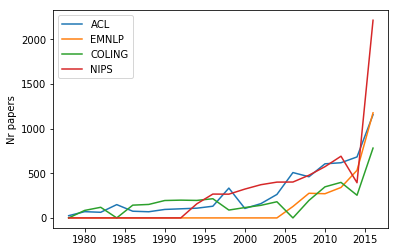

In [86]:
def plot_for_conference(conferences=None, years = range(1978, 2018, 2)):
    documents_per_year = texts_topics_df[texts_topics_df['Conference'].isin(conferences)
                                                     ].groupby('Title', as_index=False).first().groupby('Year').count()[['Document']].to_dict()['Document']
    print(documents_per_year)
    plt.plot(years, [documents_per_year.get(y, 0)+documents_per_year.get(y-1, 0) 
                     for y in years], label=",".join(conferences))
    plt.ylabel('Nr papers')
    plt.legend()
plot_for_conference(['ACL'])
plot_for_conference(['EMNLP'])
plot_for_conference(['COLING'])
plot_for_conference(['NIPS'])
# plot_for_conference(['NAACL'])

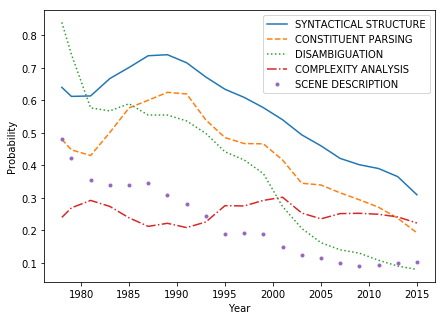

In [87]:
def plot_for_topics(topics, all_years = range(1978, 2018, 2), conferences=None, size=(7,5), smooth_win=3):
    ax = plt.figure(figsize=size)
    styles = ['-', '--', ':', "-.", '.']
    for t, topic in enumerate(topics):
        if conferences:
            documents_per_year = texts_topics_df[texts_topics_df['Conference'].isin(conferences)
                                                 ].groupby('Title', as_index=False).first().groupby('Year').count()[['Document']].to_dict()['Document']
        else:
            documents_per_year = texts_topics_df.groupby('Title', as_index=False).first().groupby('Year').count()[['Document']].to_dict()['Document']
        top_texts_topics_df = texts_topics_df.loc[texts_topics_df.Dominant_Topic.isin(topics)]
        if conferences:
            top_texts_topics_df = top_texts_topics_df.loc[top_texts_topics_df.Conference.isin(conferences)]
        top_topics_per_year = top_texts_topics_df.groupby(['Dominant_Topic', 'Year']).count().reset_index()
        topic_counts = top_topics_per_year[top_topics_per_year['Dominant_Topic']==topic][[
            'Year', 'Document']].values
        years = [t[0] for t in topic_counts]
        counts = [float(t[1])/documents_per_year[t[0]] for t in topic_counts]
        all_counts = [0 for y in all_years]
        j = 0
        for i in range(len(all_years)):
            if all_years[i] not in years:
                continue
            all_counts[i] = float(counts[j])
            j += 1
        df = pd.DataFrame({'years': list(all_years), 'probs': all_counts}, columns=['years', 'probs'])
        df = df.rolling(smooth_win, 1).mean()
        ax = plt.plot(df['years'], df['probs'], styles[t%len(styles)], label=topic_names[int(topic)])
        plt.xlabel('Year')
        plt.ylabel('Probability')
    plt.legend()
    list(range(18))
    plt.yticks = range(0, 18, 1)
plot_for_topics(top_topics_linguistics[:5], conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'], smooth_win=2)



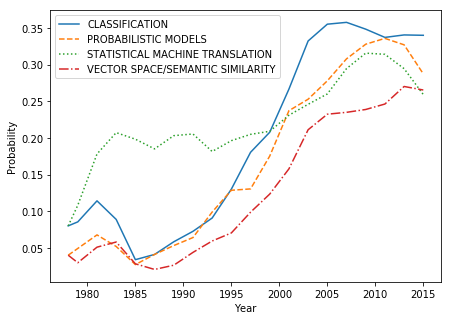

In [88]:
plot_for_topics(topics_in_jurafsky_increasing, conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'], smooth_win=2)


{2006, 2008, 2010, 2012, 2014, 2016}

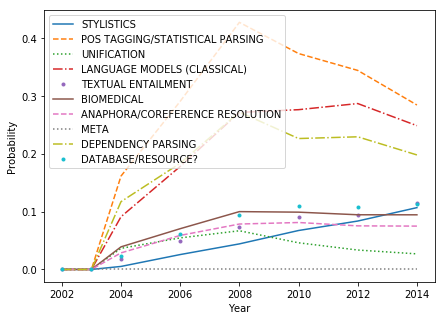

In [89]:
plot_for_topics(range(20,30), conferences=['EMNLP'], smooth_win=3, all_years=range(2002,2018,2))
set(texts_topics_df[texts_topics_df['Conference']=='EMNLP'].Year)

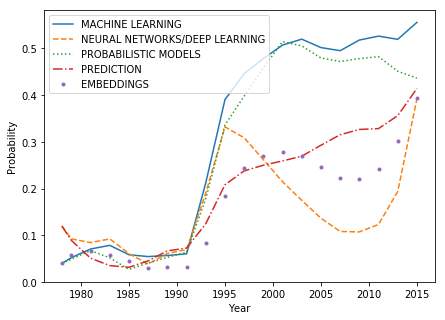

In [90]:
plot_for_topics(top_varying_topics[:5], smooth_win=2)


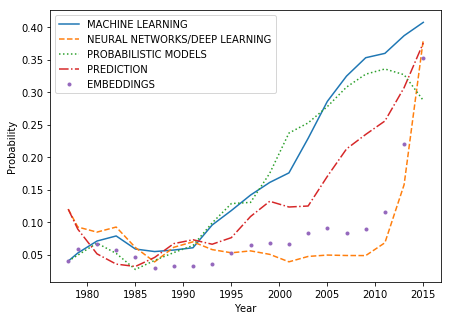

In [91]:
plot_for_topics(top_varying_topics[:5], conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'], smooth_win=2)


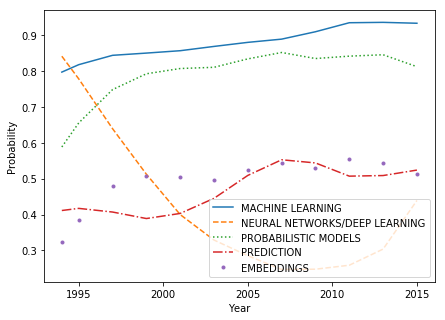

In [92]:
plot_for_topics(top_varying_topics[:5], conferences=['NIPS'], smooth_win=2, all_years=range(1994,2018,2))
# plot_for_topics(bottom_varying_topics[:5], conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])


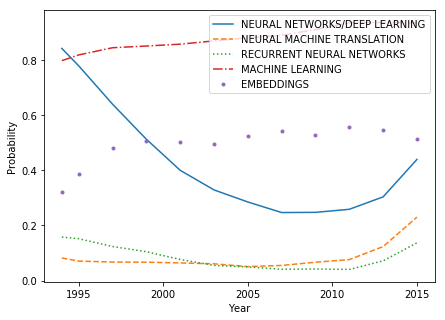

In [93]:
plot_for_topics(neural_topics, conferences=['NIPS'], all_years=range(1994,2018,2), smooth_win=2)

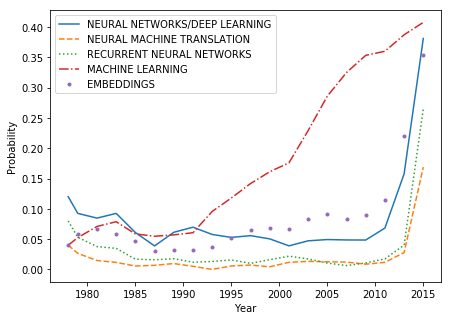

In [94]:
plot_for_topics(neural_topics, conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'], smooth_win=2)

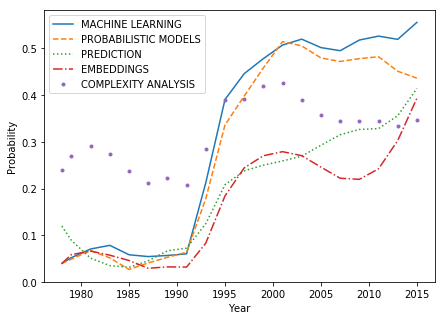

In [95]:
plot_for_topics(top_recent_topics[:5], smooth_win=2)

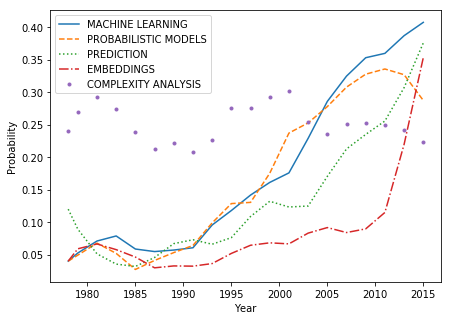

In [96]:
plot_for_topics(top_recent_topics[:5], conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'], smooth_win=2)

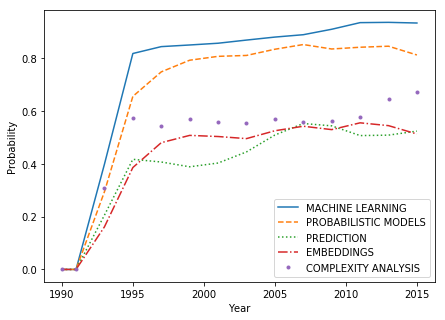

In [97]:
plot_for_topics(top_recent_topics[:5], conferences=['NIPS'], all_years=range(1990,2018,2), smooth_win=2)

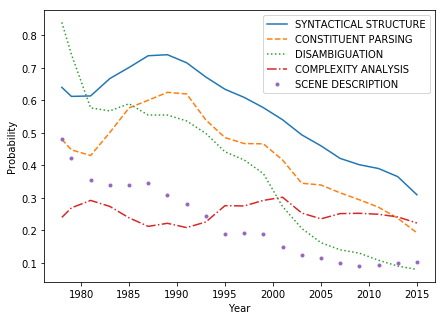

In [98]:
plot_for_topics(top_topics_linguistics[:5], conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'], smooth_win=2)

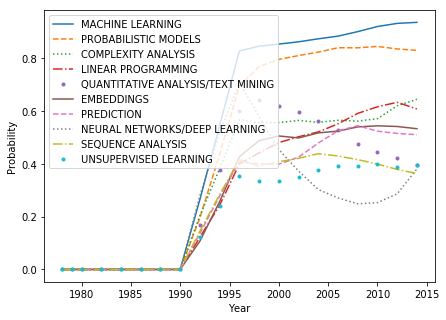

In [99]:
plot_for_topics(top_topics_nips, conferences=['NIPS'])

In [100]:
#pickle.dump(texts_topics_df, open("texts_topics_all_multitopic2.pkl.bak", "wb+"))

In [101]:
#texts_topics_df = pickle.load(open("texts_topics_all_all_multitopic.pkl", "rb"))

In [102]:
gensim.models.word2vec.train_batch_sg?

## Idea relationships

In [103]:
from scipy.stats.stats import pearsonr
import numpy as np
pmis = {}
corrs = {}


In [104]:

def pmi(topic1, topic2, df):
    document_topic_df = df[['Document', 'Dominant_Topic']]
    topic1_docs = document_topic_df[document_topic_df['Dominant_Topic']==topic1].Document.values
    topic2_docs = document_topic_df[document_topic_df['Dominant_Topic']==topic2].Document.values
    freq1 = np.unique(topic1_docs).size
    freq2 = np.unique(topic2_docs).size
    cooc_freq = np.intersect1d(topic1_docs, topic2_docs).size # TODO: unique?
    if not freq1 or not freq2:
        return -1
    return cooc_freq/(freq1*freq2)

def compute_pmis(df):
    for topic1 in range(100):
        for topic2 in range(100):
            if topic1 < topic2:
                pmi_score = pmi(topic1, topic2, df)
#                 if pmi_score < 0:
#                     continue
#                 assert(pmi_score == pmi(topic2, topic1))
                print(topic1, topic2, topic_names[topic1], topic_names[topic2], pmi_score)
                pmis[(topic1, topic2)] = {'names': [topic_names[topic1], topic_names[topic2]], 'score': pmi_score}

def _probs_for_topic(topic, df, time_range=range(1978, 2018)):
    counts_per_year = df[df['Dominant_Topic']==topic].groupby('Year', as_index=False).count()
    documents_per_year = df.groupby(['Document'], as_index=False).first().groupby('Year').count()[['Document']].to_dict()['Document']
    counts_per_year['Docs_per_year'] = counts_per_year['Year'].apply(lambda y: documents_per_year[y])
    counts_per_year['Probability'] = counts_per_year['Document']/counts_per_year['Docs_per_year']
    counts_per_year = counts_per_year.set_index('Year')
    probs = counts_per_year.reindex(time_range, fill_value=0).Probability.values
    return probs

def corr(topic1, topic2, df, time_range=range(1978, 2018)):
    c1 = _probs_for_topic(topic1, df, time_range=time_range)
    c2 = _probs_for_topic(topic2, df, time_range=time_range)
    corr = pearsonr(c1, c2)
    return corr[0]

def compute_corrs(df, time_range=range(1978,2018)):
    for topic1 in range(100):
        for topic2 in range(100):
            if topic1 < topic2:
                corr_coef = corr(topic1, topic2, df, time_range=time_range)
                if np.isnan(corr_coef):
                    continue
#                 assert(corr_coef == corr(topic2, topic1))
                print(topic1, topic2, topic_names[topic1], topic_names[topic2], corr_coef)
                corrs[(topic1, topic2)] = {'names': [topic_names[topic1], topic_names[topic2]], 'score': corr_coef}

df = texts_topics_df[texts_topics_df['Conference']!='NIPS']
compute_corrs(df)
# _probs_for_topic(10)
compute_pmis(df)

0 1 DOMAIN ADAPTATION FINITE STATE MACHINES 0.8591005332707844
0 2 DOMAIN ADAPTATION MORPHOLOGY 0.9036550178000027
0 3 DOMAIN ADAPTATION MULTI-WORD EXPRESSIONS 0.8213601626551597
0 4 DOMAIN ADAPTATION SENTIMENT ANALYSIS 0.7709044688476809
0 5 DOMAIN ADAPTATION TREES 0.9285420759788704
0 6 DOMAIN ADAPTATION REINFORCEMENT LEARNING 0.8240512175516423
0 7 DOMAIN ADAPTATION SVMs 0.7693904438616028
0 8 DOMAIN ADAPTATION LINEAR PROGRAMMING 0.8851815246496335
0 9 DOMAIN ADAPTATION ARGUMENT MINING 0.867125242655575


/home/ana/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


0 11 DOMAIN ADAPTATION TOPIC MODELS 0.8527896442593804
0 12 DOMAIN ADAPTATION CLUSTERING 0.8156173104358478
0 13 DOMAIN ADAPTATION LANGUAGE ACQUISITION/SIMPLIFICATION 0.8928615179184537
0 14 DOMAIN ADAPTATION GENERATION 0.8197402881678418
0 15 DOMAIN ADAPTATION NAMED ENTITY RECOGNITION 0.7712517566303349
0 16 DOMAIN ADAPTATION DISCOURSE SEGMENTATION 0.8615377840298443
0 17 DOMAIN ADAPTATION EVENTS/TEMPORAL 0.8541291424974734
0 19 DOMAIN ADAPTATION PHONOLOGY 0.8536863258761632
0 20 DOMAIN ADAPTATION STYLISTICS 0.8137985321691014
0 21 DOMAIN ADAPTATION POS TAGGING/STATISTICAL PARSING 0.788510057726799
0 22 DOMAIN ADAPTATION UNIFICATION 0.6076365229343107
0 23 DOMAIN ADAPTATION LANGUAGE MODELS (CLASSICAL) 0.7571818293551048
0 24 DOMAIN ADAPTATION TEXTUAL ENTAILMENT 0.7895233683041308
0 25 DOMAIN ADAPTATION BIOMEDICAL 0.9457724813815754
0 26 DOMAIN ADAPTATION ANAPHORA/COREFERENCE RESOLUTION 0.849167739308172
0 28 DOMAIN ADAPTATION DEPENDENCY PARSING 0.8882280288556538
0 29 DOMAIN ADAPTATIO

1 73 FINITE STATE MACHINES QUANTITATIVE ANALYSIS/TEXT MINING 0.6988540760081683
1 74 FINITE STATE MACHINES VISION/MULTIMODAL 0.5778685513018122
1 76 FINITE STATE MACHINES CROSS-LINGUAL/PARALLEL CORPORA 0.5500279540592509
1 78 FINITE STATE MACHINES NEURAL MACHINE TRANSLATION 0.06556618172459408
1 79 FINITE STATE MACHINES RECURRENT NEURAL NETWORKS 0.09924812441387273
1 80 FINITE STATE MACHINES COMPLEXITY ANALYSIS 0.9381579434175318
1 81 FINITE STATE MACHINES OPINION MINING 0.62926172764028
1 82 FINITE STATE MACHINES TWITTER/SOCIAL MEDIA 0.19100093822054168
1 83 FINITE STATE MACHINES TRANSLITERATION 0.7176464516616238
1 84 FINITE STATE MACHINES DICTIONARIES 0.9569491039256264
1 85 FINITE STATE MACHINES RELATION EXTRACTION 0.8741504512660747
1 86 FINITE STATE MACHINES HISTORICAL LINGUISTICS 0.8385995953440419
1 87 FINITE STATE MACHINES WORDNET/DISAMBIGUATION 0.7912034316537302
1 88 FINITE STATE MACHINES DEPENDENCY PARSING 0.8875164168027778
1 89 FINITE STATE MACHINES INFORMATION RETRIEVAL 

3 48 MULTI-WORD EXPRESSIONS SPEECH RECOGNITION 0.8529387998529752
3 50 MULTI-WORD EXPRESSIONS LEXICONS 0.8956702710620053
3 51 MULTI-WORD EXPRESSIONS CONSTITUENT PARSING 0.9342304628938501
3 52 MULTI-WORD EXPRESSIONS MULTILINGUALITY 0.7166740742031633
3 53 MULTI-WORD EXPRESSIONS UNSUPERVISED LEARNING 0.3924573652360065
3 54 MULTI-WORD EXPRESSIONS RANKING 0.43065498961808424
3 55 MULTI-WORD EXPRESSIONS EMBEDDINGS 0.32471379577405457
3 56 MULTI-WORD EXPRESSIONS PLAN-BASED DIALOGUE 0.9142958473267735
3 57 MULTI-WORD EXPRESSIONS QUESTION ANSWERING 0.7673995006022754
3 59 MULTI-WORD EXPRESSIONS EVENT EXTRACTION 0.8340194626916112
3 60 MULTI-WORD EXPRESSIONS GRAMMARS 0.8802165314611318
3 61 MULTI-WORD EXPRESSIONS LOGICAL FORMS 0.8857191321298279
3 63 MULTI-WORD EXPRESSIONS KNOWLEDGE BASE 0.5540596297386394
3 65 MULTI-WORD EXPRESSIONS INFORMATION EXTRACTION? 0.805230059161725
3 66 MULTI-WORD EXPRESSIONS HUMAN-COMPUTER INTERACTION/APPLICATION 0.8442413673727533
3 67 MULTI-WORD EXPRESSIONS DISA

5 16 TREES DISCOURSE SEGMENTATION 0.8865928109970543
5 17 TREES EVENTS/TEMPORAL 0.9234813590404459
5 19 TREES PHONOLOGY 0.9340801623547659
5 20 TREES STYLISTICS 0.7162878103247703
5 21 TREES POS TAGGING/STATISTICAL PARSING 0.7038513027354024
5 22 TREES UNIFICATION 0.8222331206702643
5 23 TREES LANGUAGE MODELS (CLASSICAL) 0.6098882228463153
5 24 TREES TEXTUAL ENTAILMENT 0.6927503629491315
5 25 TREES BIOMEDICAL 0.8492770472875563
5 26 TREES ANAPHORA/COREFERENCE RESOLUTION 0.9480822396759356
5 28 TREES DEPENDENCY PARSING 0.7339265809784445
5 29 TREES DATABASE/RESOURCE? 0.9355325969350847
5 30 TREES SOCIAL MEDIA/WEB DATA 0.812463374633547
5 31 TREES SUMMARIZATION 0.6474498353011133
5 32 TREES SPELLING CORRECTION 0.928537134519315
5 34 TREES EVALUATION/ANNOTATION 0.6357491278202708
5 35 TREES SEMANTIC ROLE LABELING 0.9484772818717444
5 36 TREES DISCOURSE 0.9299532980435671
5 38 TREES SYNTACTICAL STRUCTURE 0.9712567608237218
5 39 TREES VECTOR SPACE/SEMANTIC SIMILARITY 0.5905020354547734
5 40

6 95 REINFORCEMENT LEARNING GRAPH-BASED METHODS 0.7966924876533389
6 98 REINFORCEMENT LEARNING NEWS ARTICLES 0.8017883637816733
6 99 REINFORCEMENT LEARNING SCENE DESCRIPTION 0.9422662437215872
7 8 SVMs LINEAR PROGRAMMING 0.5119854613681364
7 9 SVMs ARGUMENT MINING 0.6455650927583464
7 11 SVMs TOPIC MODELS 0.8773575245684763
7 12 SVMs CLUSTERING 0.9020384405248072
7 13 SVMs LANGUAGE ACQUISITION/SIMPLIFICATION 0.5721202967591108
7 14 SVMs GENERATION 0.33386072185225046
7 15 SVMs NAMED ENTITY RECOGNITION 0.9465889368677752
7 16 SVMs DISCOURSE SEGMENTATION 0.6139356491699874
7 17 SVMs EVENTS/TEMPORAL 0.41113679787318486
7 19 SVMs PHONOLOGY 0.4521984436670371
7 20 SVMs STYLISTICS 0.644362310553659
7 21 SVMs POS TAGGING/STATISTICAL PARSING 0.772595270226604
7 22 SVMs UNIFICATION 0.03864223874581067
7 23 SVMs LANGUAGE MODELS (CLASSICAL) 0.8582145559385984
7 24 SVMs TEXTUAL ENTAILMENT 0.6350175130370844
7 25 SVMs BIOMEDICAL 0.8011517750922956
7 26 SVMs ANAPHORA/COREFERENCE RESOLUTION 0.4312300

8 93 LINEAR PROGRAMMING SEQUENCE ANALYSIS 0.8690276438303198
8 94 LINEAR PROGRAMMING FRAME SEMANTICS 0.8518748446778359
8 95 LINEAR PROGRAMMING GRAPH-BASED METHODS 0.8876469552598241
8 98 LINEAR PROGRAMMING NEWS ARTICLES 0.8526880731918037
8 99 LINEAR PROGRAMMING SCENE DESCRIPTION 0.8669217270336821
9 11 ARGUMENT MINING TOPIC MODELS 0.6632653858668625
9 12 ARGUMENT MINING CLUSTERING 0.5958098687390133
9 13 ARGUMENT MINING LANGUAGE ACQUISITION/SIMPLIFICATION 0.8170443716705296
9 14 ARGUMENT MINING GENERATION 0.8123281295870435
9 15 ARGUMENT MINING NAMED ENTITY RECOGNITION 0.643021361654955
9 16 ARGUMENT MINING DISCOURSE SEGMENTATION 0.6350155016144247
9 17 ARGUMENT MINING EVENTS/TEMPORAL 0.8610818894341934
9 19 ARGUMENT MINING PHONOLOGY 0.8805221078335606
9 20 ARGUMENT MINING STYLISTICS 0.9742013442087352
9 21 ARGUMENT MINING POS TAGGING/STATISTICAL PARSING 0.4998416578461023
9 22 ARGUMENT MINING UNIFICATION 0.5469046464596224
9 23 ARGUMENT MINING LANGUAGE MODELS (CLASSICAL) 0.491157485

11 87 TOPIC MODELS WORDNET/DISAMBIGUATION 0.8880131957145196
11 88 TOPIC MODELS DEPENDENCY PARSING 0.7298991755556077
11 89 TOPIC MODELS INFORMATION RETRIEVAL 0.9272142989728352
11 90 TOPIC MODELS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.5389318627350166
11 91 TOPIC MODELS ASIAN LANGUAGES 0.5160578776312365
11 92 TOPIC MODELS CLASSIFICATION 0.9774578690189994
11 93 TOPIC MODELS SEQUENCE ANALYSIS 0.8469878515552601
11 94 TOPIC MODELS FRAME SEMANTICS 0.45436669974476895
11 95 TOPIC MODELS GRAPH-BASED METHODS 0.8259024344332949
11 98 TOPIC MODELS NEWS ARTICLES 0.8626658054084755
11 99 TOPIC MODELS SCENE DESCRIPTION 0.3153649610746442
12 13 CLUSTERING LANGUAGE ACQUISITION/SIMPLIFICATION 0.7073436227818628
12 14 CLUSTERING GENERATION 0.3739343924173278
12 15 CLUSTERING NAMED ENTITY RECOGNITION 0.9138788385712868
12 16 CLUSTERING DISCOURSE SEGMENTATION 0.8130084819765702
12 17 CLUSTERING EVENTS/TEMPORAL 0.4244957865193809
12 19 CLUSTERING PHONOLOGY 0.5033301307494336
12 20 CLUSTERING S

13 71 LANGUAGE ACQUISITION/SIMPLIFICATION ONTOLOGIES 0.7817462775953358
13 72 LANGUAGE ACQUISITION/SIMPLIFICATION PREDICTION 0.6513579768808482
13 73 LANGUAGE ACQUISITION/SIMPLIFICATION QUANTITATIVE ANALYSIS/TEXT MINING 0.803097195589873
13 74 LANGUAGE ACQUISITION/SIMPLIFICATION VISION/MULTIMODAL 0.6792295857132734
13 76 LANGUAGE ACQUISITION/SIMPLIFICATION CROSS-LINGUAL/PARALLEL CORPORA 0.6832991386877489
13 78 LANGUAGE ACQUISITION/SIMPLIFICATION NEURAL MACHINE TRANSLATION 0.29325156573055755
13 79 LANGUAGE ACQUISITION/SIMPLIFICATION RECURRENT NEURAL NETWORKS 0.32165335169187315
13 80 LANGUAGE ACQUISITION/SIMPLIFICATION COMPLEXITY ANALYSIS 0.9460127874704575
13 81 LANGUAGE ACQUISITION/SIMPLIFICATION OPINION MINING 0.7746055635444762
13 82 LANGUAGE ACQUISITION/SIMPLIFICATION TWITTER/SOCIAL MEDIA 0.4544085569052703
13 83 LANGUAGE ACQUISITION/SIMPLIFICATION TRANSLITERATION 0.8368736882763186
13 84 LANGUAGE ACQUISITION/SIMPLIFICATION DICTIONARIES 0.8287378189063138
13 85 LANGUAGE ACQUISITI

15 60 NAMED ENTITY RECOGNITION GRAMMARS 0.17499406221329628
15 61 NAMED ENTITY RECOGNITION LOGICAL FORMS 0.0907669577434088
15 63 NAMED ENTITY RECOGNITION KNOWLEDGE BASE 0.9410222503719873
15 65 NAMED ENTITY RECOGNITION INFORMATION EXTRACTION? 0.6985070750096138
15 66 NAMED ENTITY RECOGNITION HUMAN-COMPUTER INTERACTION/APPLICATION 0.5916440312536462
15 67 NAMED ENTITY RECOGNITION DISAMBIGUATION 0.12993260482631086
15 68 NAMED ENTITY RECOGNITION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.8261182687845177
15 69 NAMED ENTITY RECOGNITION NEURAL NETWORKS/DEEP LEARNING 0.6573637056973649
15 70 NAMED ENTITY RECOGNITION NARRATIVES 0.6939174315707602
15 71 NAMED ENTITY RECOGNITION ONTOLOGIES 0.4058352148172795
15 72 NAMED ENTITY RECOGNITION PREDICTION 0.9636702467593938
15 73 NAMED ENTITY RECOGNITION QUANTITATIVE ANALYSIS/TEXT MINING 0.7980498891155883
15 74 NAMED ENTITY RECOGNITION VISION/MULTIMODAL 0.7901219288382493
15 76 NAMED ENTITY RECOGNITION CROSS-LINGUAL/PARALLEL CORPORA 0.91232275329775

17 46 EVENTS/TEMPORAL TRANSFER LEARNING 0.7164697771710181
17 48 EVENTS/TEMPORAL SPEECH RECOGNITION 0.8088526655555941
17 50 EVENTS/TEMPORAL LEXICONS 0.8978727219023526
17 51 EVENTS/TEMPORAL CONSTITUENT PARSING 0.9611878561955469
17 52 EVENTS/TEMPORAL MULTILINGUALITY 0.7250195313918837
17 53 EVENTS/TEMPORAL UNSUPERVISED LEARNING 0.3902340977121749
17 54 EVENTS/TEMPORAL RANKING 0.4100339819844838
17 55 EVENTS/TEMPORAL EMBEDDINGS 0.36377787670649236
17 56 EVENTS/TEMPORAL PLAN-BASED DIALOGUE 0.9569135561213795
17 57 EVENTS/TEMPORAL QUESTION ANSWERING 0.8077013437816277
17 59 EVENTS/TEMPORAL EVENT EXTRACTION 0.8421081623050363
17 60 EVENTS/TEMPORAL GRAMMARS 0.8936315806237056
17 61 EVENTS/TEMPORAL LOGICAL FORMS 0.9366935763909291
17 63 EVENTS/TEMPORAL KNOWLEDGE BASE 0.6035152838028516
17 65 EVENTS/TEMPORAL INFORMATION EXTRACTION? 0.7976221852376015
17 66 EVENTS/TEMPORAL HUMAN-COMPUTER INTERACTION/APPLICATION 0.8537020653938487
17 67 EVENTS/TEMPORAL DISAMBIGUATION 0.942279182006362
17 68 EV

20 67 STYLISTICS DISAMBIGUATION 0.6912708471655542
20 68 STYLISTICS GRAPHS/ABSTRACT MEANING REPRESENTATION 0.7396836184096263
20 69 STYLISTICS NEURAL NETWORKS/DEEP LEARNING 0.6359280090824576
20 70 STYLISTICS NARRATIVES 0.9559407901485912
20 71 STYLISTICS ONTOLOGIES 0.7805645160827894
20 72 STYLISTICS PREDICTION 0.6669713296572624
20 73 STYLISTICS QUANTITATIVE ANALYSIS/TEXT MINING 0.5420959057433072
20 74 STYLISTICS VISION/MULTIMODAL 0.8151492322555112
20 76 STYLISTICS CROSS-LINGUAL/PARALLEL CORPORA 0.5993496868339973
20 78 STYLISTICS NEURAL MACHINE TRANSLATION 0.4406133838716632
20 79 STYLISTICS RECURRENT NEURAL NETWORKS 0.47137223803179634
20 80 STYLISTICS COMPLEXITY ANALYSIS 0.8082920127904263
20 81 STYLISTICS OPINION MINING 0.8763779018100785
20 82 STYLISTICS TWITTER/SOCIAL MEDIA 0.6638766268735643
20 83 STYLISTICS TRANSLITERATION 0.7305761101916933
20 84 STYLISTICS DICTIONARIES 0.7522428326735525
20 85 STYLISTICS RELATION EXTRACTION 0.8178641933595069
20 86 STYLISTICS HISTORICAL L

22 65 UNIFICATION INFORMATION EXTRACTION? 0.6188056123184169
22 66 UNIFICATION HUMAN-COMPUTER INTERACTION/APPLICATION 0.705417335267842
22 67 UNIFICATION DISAMBIGUATION 0.885235220434406
22 68 UNIFICATION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.5557840569801671
22 69 UNIFICATION NEURAL NETWORKS/DEEP LEARNING 0.15195581595316754
22 70 UNIFICATION NARRATIVES 0.510447294375503
22 71 UNIFICATION ONTOLOGIES 0.8185441272874557
22 72 UNIFICATION PREDICTION 0.12246346851786012
22 73 UNIFICATION QUANTITATIVE ANALYSIS/TEXT MINING 0.3602882113385526
22 74 UNIFICATION VISION/MULTIMODAL 0.3096169740133522
22 76 UNIFICATION CROSS-LINGUAL/PARALLEL CORPORA 0.2566007941801091
22 78 UNIFICATION NEURAL MACHINE TRANSLATION -0.03417803085191061
22 79 UNIFICATION RECURRENT NEURAL NETWORKS 0.008287263275498752
22 80 UNIFICATION COMPLEXITY ANALYSIS 0.7125837352681267
22 81 UNIFICATION OPINION MINING 0.30013706880664115
22 82 UNIFICATION TWITTER/SOCIAL MEDIA -0.03085976263485564
22 83 UNIFICATION TRANSLITERAT

24 67 TEXTUAL ENTAILMENT DISAMBIGUATION 0.7509081884261066
24 68 TEXTUAL ENTAILMENT GRAPHS/ABSTRACT MEANING REPRESENTATION 0.7769000035095431
24 69 TEXTUAL ENTAILMENT NEURAL NETWORKS/DEEP LEARNING 0.5526191482590134
24 70 TEXTUAL ENTAILMENT NARRATIVES 0.9292749513192086
24 71 TEXTUAL ENTAILMENT ONTOLOGIES 0.8502477183096049
24 72 TEXTUAL ENTAILMENT PREDICTION 0.5719015687724035
24 73 TEXTUAL ENTAILMENT QUANTITATIVE ANALYSIS/TEXT MINING 0.4583804580278374
24 74 TEXTUAL ENTAILMENT VISION/MULTIMODAL 0.8574906820288638
24 76 TEXTUAL ENTAILMENT CROSS-LINGUAL/PARALLEL CORPORA 0.5273001271817658
24 78 TEXTUAL ENTAILMENT NEURAL MACHINE TRANSLATION 0.37749506052343273
24 79 TEXTUAL ENTAILMENT RECURRENT NEURAL NETWORKS 0.4077110916359968
24 80 TEXTUAL ENTAILMENT COMPLEXITY ANALYSIS 0.7081009555192628
24 81 TEXTUAL ENTAILMENT OPINION MINING 0.8136631257415557
24 82 TEXTUAL ENTAILMENT TWITTER/SOCIAL MEDIA 0.5448581526449796
24 83 TEXTUAL ENTAILMENT TRANSLITERATION 0.6021647633180904
24 84 TEXTUAL 

26 79 ANAPHORA/COREFERENCE RESOLUTION RECURRENT NEURAL NETWORKS 0.15536786565592842
26 80 ANAPHORA/COREFERENCE RESOLUTION COMPLEXITY ANALYSIS 0.881488921016995
26 81 ANAPHORA/COREFERENCE RESOLUTION OPINION MINING 0.6309950441276465
26 82 ANAPHORA/COREFERENCE RESOLUTION TWITTER/SOCIAL MEDIA 0.27399298017317414
26 83 ANAPHORA/COREFERENCE RESOLUTION TRANSLITERATION 0.6412229132841871
26 84 ANAPHORA/COREFERENCE RESOLUTION DICTIONARIES 0.8981038758528067
26 85 ANAPHORA/COREFERENCE RESOLUTION RELATION EXTRACTION 0.875853835361876
26 86 ANAPHORA/COREFERENCE RESOLUTION HISTORICAL LINGUISTICS 0.8258546375692267
26 87 ANAPHORA/COREFERENCE RESOLUTION WORDNET/DISAMBIGUATION 0.7563441360010738
26 88 ANAPHORA/COREFERENCE RESOLUTION DEPENDENCY PARSING 0.8838695690742089
26 89 ANAPHORA/COREFERENCE RESOLUTION INFORMATION RETRIEVAL 0.6683918793819001
26 90 ANAPHORA/COREFERENCE RESOLUTION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9331408348199753
26 91 ANAPHORA/COREFERENCE RESOLUTION ASIAN LANGUAGES

29 91 DATABASE/RESOURCE? ASIAN LANGUAGES 0.7956817352581695
29 92 DATABASE/RESOURCE? CLASSIFICATION 0.7078766628297452
29 93 DATABASE/RESOURCE? SEQUENCE ANALYSIS 0.8841117177091043
29 94 DATABASE/RESOURCE? FRAME SEMANTICS 0.820576393392921
29 95 DATABASE/RESOURCE? GRAPH-BASED METHODS 0.9204552923720848
29 98 DATABASE/RESOURCE? NEWS ARTICLES 0.9250265005141397
29 99 DATABASE/RESOURCE? SCENE DESCRIPTION 0.7704895717613567
30 31 SOCIAL MEDIA/WEB DATA SUMMARIZATION 0.6246942043991015
30 32 SOCIAL MEDIA/WEB DATA SPELLING CORRECTION 0.8342087952068252
30 34 SOCIAL MEDIA/WEB DATA EVALUATION/ANNOTATION 0.6079546251583559
30 35 SOCIAL MEDIA/WEB DATA SEMANTIC ROLE LABELING 0.8217772172664016
30 36 SOCIAL MEDIA/WEB DATA DISCOURSE 0.8071618027529427
30 38 SOCIAL MEDIA/WEB DATA SYNTACTICAL STRUCTURE 0.8152344252357745
30 39 SOCIAL MEDIA/WEB DATA VECTOR SPACE/SEMANTIC SIMILARITY 0.5296084792424554
30 40 SOCIAL MEDIA/WEB DATA MACHINE LEARNING 0.5372893732174179
30 41 SOCIAL MEDIA/WEB DATA PROBABILIST

32 54 SPELLING CORRECTION RANKING 0.7921837792939458
32 55 SPELLING CORRECTION EMBEDDINGS 0.5301681974106764
32 56 SPELLING CORRECTION PLAN-BASED DIALOGUE 0.724889006321566
32 57 SPELLING CORRECTION QUESTION ANSWERING 0.7799068093479924
32 59 SPELLING CORRECTION EVENT EXTRACTION 0.7892864190872724
32 60 SPELLING CORRECTION GRAMMARS 0.7272226804573942
32 61 SPELLING CORRECTION LOGICAL FORMS 0.616822758496958
32 63 SPELLING CORRECTION KNOWLEDGE BASE 0.8155313603242141
32 65 SPELLING CORRECTION INFORMATION EXTRACTION? 0.9572577053500927
32 66 SPELLING CORRECTION HUMAN-COMPUTER INTERACTION/APPLICATION 0.951425908976214
32 67 SPELLING CORRECTION DISAMBIGUATION 0.6622289811317753
32 68 SPELLING CORRECTION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.8905625500596172
32 69 SPELLING CORRECTION NEURAL NETWORKS/DEEP LEARNING 0.41857491265515634
32 70 SPELLING CORRECTION NARRATIVES 0.8334941912770606
32 71 SPELLING CORRECTION ONTOLOGIES 0.822648133003288
32 72 SPELLING CORRECTION PREDICTION 0.7023196

35 79 SEMANTIC ROLE LABELING RECURRENT NEURAL NETWORKS 0.20836259360735168
35 80 SEMANTIC ROLE LABELING COMPLEXITY ANALYSIS 0.9053402717021578
35 81 SEMANTIC ROLE LABELING OPINION MINING 0.7043755051240702
35 82 SEMANTIC ROLE LABELING TWITTER/SOCIAL MEDIA 0.3747043410298361
35 83 SEMANTIC ROLE LABELING TRANSLITERATION 0.690848888905121
35 84 SEMANTIC ROLE LABELING DICTIONARIES 0.8800652332723758
35 85 SEMANTIC ROLE LABELING RELATION EXTRACTION 0.94777479645713
35 86 SEMANTIC ROLE LABELING HISTORICAL LINGUISTICS 0.8829367103206056
35 87 SEMANTIC ROLE LABELING WORDNET/DISAMBIGUATION 0.735130321700396
35 88 SEMANTIC ROLE LABELING DEPENDENCY PARSING 0.8811092326378083
35 89 SEMANTIC ROLE LABELING INFORMATION RETRIEVAL 0.717086053447048
35 90 SEMANTIC ROLE LABELING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9392407914733426
35 91 SEMANTIC ROLE LABELING ASIAN LANGUAGES 0.7714257531808741
35 92 SEMANTIC ROLE LABELING CLASSIFICATION 0.5513408007901284
35 93 SEMANTIC ROLE LABELING SEQUENCE 

39 57 VECTOR SPACE/SEMANTIC SIMILARITY QUESTION ANSWERING 0.45865106583892223
39 59 VECTOR SPACE/SEMANTIC SIMILARITY EVENT EXTRACTION 0.46539588092057166
39 60 VECTOR SPACE/SEMANTIC SIMILARITY GRAMMARS 0.2726854060353637
39 61 VECTOR SPACE/SEMANTIC SIMILARITY LOGICAL FORMS 0.08915600434687909
39 63 VECTOR SPACE/SEMANTIC SIMILARITY KNOWLEDGE BASE 0.8849380763396804
39 65 VECTOR SPACE/SEMANTIC SIMILARITY INFORMATION EXTRACTION? 0.7813253268586638
39 66 VECTOR SPACE/SEMANTIC SIMILARITY HUMAN-COMPUTER INTERACTION/APPLICATION 0.6786387625752675
39 67 VECTOR SPACE/SEMANTIC SIMILARITY DISAMBIGUATION 0.09309299919216044
39 68 VECTOR SPACE/SEMANTIC SIMILARITY GRAPHS/ABSTRACT MEANING REPRESENTATION 0.811454812524061
39 69 VECTOR SPACE/SEMANTIC SIMILARITY NEURAL NETWORKS/DEEP LEARNING 0.5710976709638667
39 70 VECTOR SPACE/SEMANTIC SIMILARITY NARRATIVES 0.57898438101136
39 71 VECTOR SPACE/SEMANTIC SIMILARITY ONTOLOGIES 0.38595930027101844
39 72 VECTOR SPACE/SEMANTIC SIMILARITY PREDICTION 0.9282720

41 90 PROBABILISTIC MODELS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.49960666894541933
41 91 PROBABILISTIC MODELS ASIAN LANGUAGES 0.4898738141396707
41 92 PROBABILISTIC MODELS CLASSIFICATION 0.9856032608020046
41 93 PROBABILISTIC MODELS SEQUENCE ANALYSIS 0.8308762694690677
41 94 PROBABILISTIC MODELS FRAME SEMANTICS 0.32351790466347263
41 95 PROBABILISTIC MODELS GRAPH-BASED METHODS 0.8105641792231316
41 98 PROBABILISTIC MODELS NEWS ARTICLES 0.7937037031030599
41 99 PROBABILISTIC MODELS SCENE DESCRIPTION 0.1995937814701466
43 46 STATISTICAL MACHINE TRANSLATION TRANSFER LEARNING 0.9474704282247286
43 48 STATISTICAL MACHINE TRANSLATION SPEECH RECOGNITION 0.8547959752350447
43 50 STATISTICAL MACHINE TRANSLATION LEXICONS 0.8129496746863758
43 51 STATISTICAL MACHINE TRANSLATION CONSTITUENT PARSING 0.7638302438470903
43 52 STATISTICAL MACHINE TRANSLATION MULTILINGUALITY 0.9606049537500534
43 53 STATISTICAL MACHINE TRANSLATION UNSUPERVISED LEARNING 0.834848850494886
43 54 STATISTICAL MACHI

48 78 SPEECH RECOGNITION NEURAL MACHINE TRANSLATION 0.12392079360138683
48 79 SPEECH RECOGNITION RECURRENT NEURAL NETWORKS 0.13690263299964667
48 80 SPEECH RECOGNITION COMPLEXITY ANALYSIS 0.9325361155413789
48 81 SPEECH RECOGNITION OPINION MINING 0.6821260849266589
48 82 SPEECH RECOGNITION TWITTER/SOCIAL MEDIA 0.27423871147974144
48 83 SPEECH RECOGNITION TRANSLITERATION 0.8391760091532208
48 84 SPEECH RECOGNITION DICTIONARIES 0.8556013895688808
48 85 SPEECH RECOGNITION RELATION EXTRACTION 0.8581021191780257
48 86 SPEECH RECOGNITION HISTORICAL LINGUISTICS 0.8442236679358023
48 87 SPEECH RECOGNITION WORDNET/DISAMBIGUATION 0.9332905732670964
48 88 SPEECH RECOGNITION DEPENDENCY PARSING 0.8756272999998
48 89 SPEECH RECOGNITION INFORMATION RETRIEVAL 0.828084111108251
48 90 SPEECH RECOGNITION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.8496887840308519
48 91 SPEECH RECOGNITION ASIAN LANGUAGES 0.8778146683443597
48 92 SPEECH RECOGNITION CLASSIFICATION 0.7465719544531979
48 93 SPEECH RECOGNI

52 91 MULTILINGUALITY ASIAN LANGUAGES 0.6678031085287894
52 92 MULTILINGUALITY CLASSIFICATION 0.8871825207921974
52 93 MULTILINGUALITY SEQUENCE ANALYSIS 0.9548787568106473
52 94 MULTILINGUALITY FRAME SEMANTICS 0.6213542359845073
52 95 MULTILINGUALITY GRAPH-BASED METHODS 0.9431834160399742
52 98 MULTILINGUALITY NEWS ARTICLES 0.900965626282066
52 99 MULTILINGUALITY SCENE DESCRIPTION 0.5458458765093365
53 54 UNSUPERVISED LEARNING RANKING 0.9646061719143965
53 55 UNSUPERVISED LEARNING EMBEDDINGS 0.7640329657422501
53 56 UNSUPERVISED LEARNING PLAN-BASED DIALOGUE 0.2405510760137578
53 57 UNSUPERVISED LEARNING QUESTION ANSWERING 0.5318768087891982
53 59 UNSUPERVISED LEARNING EVENT EXTRACTION 0.5241164366634731
53 60 UNSUPERVISED LEARNING GRAMMARS 0.2513909418058588
53 61 UNSUPERVISED LEARNING LOGICAL FORMS 0.1041040051629725
53 63 UNSUPERVISED LEARNING KNOWLEDGE BASE 0.9195673753557557
53 65 UNSUPERVISED LEARNING INFORMATION EXTRACTION? 0.7693707405932788
53 66 UNSUPERVISED LEARNING HUMAN-COM

56 78 PLAN-BASED DIALOGUE NEURAL MACHINE TRANSLATION 0.1295020771361652
56 79 PLAN-BASED DIALOGUE RECURRENT NEURAL NETWORKS 0.18065906920344996
56 80 PLAN-BASED DIALOGUE COMPLEXITY ANALYSIS 0.7982723057346225
56 81 PLAN-BASED DIALOGUE OPINION MINING 0.5799797032771945
56 82 PLAN-BASED DIALOGUE TWITTER/SOCIAL MEDIA 0.18711662857126266
56 83 PLAN-BASED DIALOGUE TRANSLITERATION 0.4791632730226757
56 84 PLAN-BASED DIALOGUE DICTIONARIES 0.9360497693555744
56 85 PLAN-BASED DIALOGUE RELATION EXTRACTION 0.7893878709565081
56 86 PLAN-BASED DIALOGUE HISTORICAL LINGUISTICS 0.7608663577867982
56 87 PLAN-BASED DIALOGUE WORDNET/DISAMBIGUATION 0.5579271814615125
56 88 PLAN-BASED DIALOGUE DEPENDENCY PARSING 0.842103412765028
56 89 PLAN-BASED DIALOGUE INFORMATION RETRIEVAL 0.5736339875917575
56 90 PLAN-BASED DIALOGUE COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.8386523734715037
56 91 PLAN-BASED DIALOGUE ASIAN LANGUAGES 0.7099838386929435
56 92 PLAN-BASED DIALOGUE CLASSIFICATION 0.27543904681679365
56

61 76 LOGICAL FORMS CROSS-LINGUAL/PARALLEL CORPORA 0.2264115733281041
61 78 LOGICAL FORMS NEURAL MACHINE TRANSLATION 0.044329154371919616
61 79 LOGICAL FORMS RECURRENT NEURAL NETWORKS 0.09748860333747231
61 80 LOGICAL FORMS COMPLEXITY ANALYSIS 0.7433452823976222
61 81 LOGICAL FORMS OPINION MINING 0.444144662039075
61 82 LOGICAL FORMS TWITTER/SOCIAL MEDIA 0.10177030445617509
61 83 LOGICAL FORMS TRANSLITERATION 0.3778329775925682
61 84 LOGICAL FORMS DICTIONARIES 0.8981990581952342
61 85 LOGICAL FORMS RELATION EXTRACTION 0.7696017213656674
61 86 LOGICAL FORMS HISTORICAL LINGUISTICS 0.7219013765499532
61 87 LOGICAL FORMS WORDNET/DISAMBIGUATION 0.4422218644788812
61 88 LOGICAL FORMS DEPENDENCY PARSING 0.7221576121911756
61 89 LOGICAL FORMS INFORMATION RETRIEVAL 0.4263390691234694
61 90 LOGICAL FORMS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.8802590840924656
61 91 LOGICAL FORMS ASIAN LANGUAGES 0.715981407560471
61 92 LOGICAL FORMS CLASSIFICATION 0.15371001180045615
61 93 LOGICAL FORMS S

67 78 DISAMBIGUATION NEURAL MACHINE TRANSLATION 0.031953461599097316
67 79 DISAMBIGUATION RECURRENT NEURAL NETWORKS 0.08738344909322246
67 80 DISAMBIGUATION COMPLEXITY ANALYSIS 0.7550497139537441
67 81 DISAMBIGUATION OPINION MINING 0.4768836716674082
67 82 DISAMBIGUATION TWITTER/SOCIAL MEDIA 0.07402975507393693
67 83 DISAMBIGUATION TRANSLITERATION 0.40389430825967954
67 84 DISAMBIGUATION DICTIONARIES 0.9349131492161047
67 85 DISAMBIGUATION RELATION EXTRACTION 0.7472822549312982
67 86 DISAMBIGUATION HISTORICAL LINGUISTICS 0.7045375002867075
67 87 DISAMBIGUATION WORDNET/DISAMBIGUATION 0.49648669910357185
67 88 DISAMBIGUATION DEPENDENCY PARSING 0.7897910546555241
67 89 DISAMBIGUATION INFORMATION RETRIEVAL 0.4645736460680021
67 90 DISAMBIGUATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.8264600575658153
67 91 DISAMBIGUATION ASIAN LANGUAGES 0.7216912567655311
67 92 DISAMBIGUATION CLASSIFICATION 0.16654206172952715
67 93 DISAMBIGUATION SEQUENCE ANALYSIS 0.6035841905774296
67 94 DISAMBIG

72 73 PREDICTION QUANTITATIVE ANALYSIS/TEXT MINING 0.780672991791654
72 74 PREDICTION VISION/MULTIMODAL 0.7845488613197135
72 76 PREDICTION CROSS-LINGUAL/PARALLEL CORPORA 0.9101145608960586
72 78 PREDICTION NEURAL MACHINE TRANSLATION 0.6363224839616147
72 79 PREDICTION RECURRENT NEURAL NETWORKS 0.6161726906698146
72 80 PREDICTION COMPLEXITY ANALYSIS 0.6552052384283362
72 81 PREDICTION OPINION MINING 0.8840601150940555
72 82 PREDICTION TWITTER/SOCIAL MEDIA 0.8712520873819773
72 83 PREDICTION TRANSLITERATION 0.8693535738782341
72 84 PREDICTION DICTIONARIES 0.3359698734663108
72 85 PREDICTION RELATION EXTRACTION 0.6801774880988664
72 86 PREDICTION HISTORICAL LINGUISTICS 0.6826207853656348
72 87 PREDICTION WORDNET/DISAMBIGUATION 0.7412983268030028
72 88 PREDICTION DEPENDENCY PARSING 0.6664379622312013
72 89 PREDICTION INFORMATION RETRIEVAL 0.7748669041216235
72 90 PREDICTION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.4284639658152943
72 91 PREDICTION ASIAN LANGUAGES 0.3473592773243339


79 93 RECURRENT NEURAL NETWORKS SEQUENCE ANALYSIS 0.30054554106361747
79 94 RECURRENT NEURAL NETWORKS FRAME SEMANTICS 0.22836857160223153
79 95 RECURRENT NEURAL NETWORKS GRAPH-BASED METHODS 0.24027530334036729
79 98 RECURRENT NEURAL NETWORKS NEWS ARTICLES 0.33925440268337226
79 99 RECURRENT NEURAL NETWORKS SCENE DESCRIPTION 0.1652066210007293
80 81 COMPLEXITY ANALYSIS OPINION MINING 0.7957595976054369
80 82 COMPLEXITY ANALYSIS TWITTER/SOCIAL MEDIA 0.45088143395564123
80 83 COMPLEXITY ANALYSIS TRANSLITERATION 0.8708339588029574
80 84 COMPLEXITY ANALYSIS DICTIONARIES 0.899526822906228
80 85 COMPLEXITY ANALYSIS RELATION EXTRACTION 0.9447208644805535
80 86 COMPLEXITY ANALYSIS HISTORICAL LINGUISTICS 0.946555519282894
80 87 COMPLEXITY ANALYSIS WORDNET/DISAMBIGUATION 0.8895894071553283
80 88 COMPLEXITY ANALYSIS DEPENDENCY PARSING 0.9219395736806513
80 89 COMPLEXITY ANALYSIS INFORMATION RETRIEVAL 0.8513984546374918
80 90 COMPLEXITY ANALYSIS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.896710

89 98 INFORMATION RETRIEVAL NEWS ARTICLES 0.9436908649293201
89 99 INFORMATION RETRIEVAL SCENE DESCRIPTION 0.5421270314186228
90 91 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING ASIAN LANGUAGES 0.8693993343356539
90 92 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING CLASSIFICATION 0.5074607331213785
90 93 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING SEQUENCE ANALYSIS 0.8548009382002933
90 94 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING FRAME SEMANTICS 0.8272045608771512
90 95 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING GRAPH-BASED METHODS 0.8824618037603738
90 98 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING NEWS ARTICLES 0.7937534553969761
90 99 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING SCENE DESCRIPTION 0.8456676654032869
91 92 ASIAN LANGUAGES CLASSIFICATION 0.51192626952223
91 93 ASIAN LANGUAGES SEQUENCE ANALYSIS 0.8099945228500898
91 94 ASIAN LANGUAGES FRAME SEMANTICS 0.7089350351431013
91 95 ASIAN LANGUAGES GRAPH-BASED METHODS 0.7925133828301612
91 98 ASIAN LANGUAGES NEWS ARTICLES 

1 18 FINITE STATE MACHINES MACHINE TRANSLATION -1
1 19 FINITE STATE MACHINES PHONOLOGY 0.0001716589022604879
1 20 FINITE STATE MACHINES STYLISTICS 3.134854617237355e-05
1 21 FINITE STATE MACHINES POS TAGGING/STATISTICAL PARSING 7.686346654234105e-05
1 22 FINITE STATE MACHINES UNIFICATION 0.00013544322128881256
1 23 FINITE STATE MACHINES LANGUAGE MODELS (CLASSICAL) 8.957629523991567e-05
1 24 FINITE STATE MACHINES TEXTUAL ENTAILMENT 5.099836989547792e-05
1 25 FINITE STATE MACHINES BIOMEDICAL 4.87563849594733e-05
1 26 FINITE STATE MACHINES ANAPHORA/COREFERENCE RESOLUTION 4.5142818063999716e-05
1 27 FINITE STATE MACHINES META -1
1 28 FINITE STATE MACHINES DEPENDENCY PARSING 6.105902466502242e-05
1 29 FINITE STATE MACHINES DATABASE/RESOURCE? 8.514847538937311e-05
1 30 FINITE STATE MACHINES SOCIAL MEDIA/WEB DATA 4.385910075348347e-05
1 31 FINITE STATE MACHINES SUMMARIZATION 4.6444330664157674e-05
1 32 FINITE STATE MACHINES SPELLING CORRECTION 0.00010330025743315954
1 33 FINITE STATE MACHINES

2 75 MORPHOLOGY MACHINE TRANSLATION (STATISTICAL) -1
2 76 MORPHOLOGY CROSS-LINGUAL/PARALLEL CORPORA 9.655582542706763e-05
2 77 MORPHOLOGY SYNTACTIC STRUCTURE -1
2 78 MORPHOLOGY NEURAL MACHINE TRANSLATION 5.8553511759168916e-05
2 79 MORPHOLOGY RECURRENT NEURAL NETWORKS 4.355176895379251e-05
2 80 MORPHOLOGY COMPLEXITY ANALYSIS 7.40021678282105e-05
2 81 MORPHOLOGY OPINION MINING 2.969214809701167e-05
2 82 MORPHOLOGY TWITTER/SOCIAL MEDIA 5.956103517079127e-05
2 83 MORPHOLOGY TRANSLITERATION 0.0001445243342847852
2 84 MORPHOLOGY DICTIONARIES 0.00013020651219045984
2 85 MORPHOLOGY RELATION EXTRACTION 4.580590821430808e-05
2 86 MORPHOLOGY HISTORICAL LINGUISTICS 0.00020038604604778135
2 87 MORPHOLOGY WORDNET/DISAMBIGUATION 6.0473231204938524e-05
2 88 MORPHOLOGY DEPENDENCY PARSING 6.298053930765552e-05
2 89 MORPHOLOGY INFORMATION RETRIEVAL 5.169764007801826e-05
2 90 MORPHOLOGY COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 8.173425222447198e-05
2 91 MORPHOLOGY ASIAN LANGUAGES 9.29693239968029e-05

4 23 SENTIMENT ANALYSIS LANGUAGE MODELS (CLASSICAL) 6.0724873723984605e-05
4 24 SENTIMENT ANALYSIS TEXTUAL ENTAILMENT 9.074017655311451e-05
4 25 SENTIMENT ANALYSIS BIOMEDICAL 7.812030527011598e-05
4 26 SENTIMENT ANALYSIS ANAPHORA/COREFERENCE RESOLUTION 5.36180866179567e-05
4 27 SENTIMENT ANALYSIS META -1
4 28 SENTIMENT ANALYSIS DEPENDENCY PARSING 5.698365784311184e-05
4 29 SENTIMENT ANALYSIS DATABASE/RESOURCE? 3.5118460110974337e-05
4 30 SENTIMENT ANALYSIS SOCIAL MEDIA/WEB DATA 0.00010417312054075265
4 31 SENTIMENT ANALYSIS SUMMARIZATION 6.82106344391481e-05
4 32 SENTIMENT ANALYSIS SPELLING CORRECTION 4.4355278960585214e-05
4 33 SENTIMENT ANALYSIS METRICS? -1
4 34 SENTIMENT ANALYSIS EVALUATION/ANNOTATION 9.361868099836414e-05
4 35 SENTIMENT ANALYSIS SEMANTIC ROLE LABELING 5.247784104683684e-05
4 36 SENTIMENT ANALYSIS DISCOURSE 8.701340826508931e-05
4 37 SENTIMENT ANALYSIS ? -1
4 38 SENTIMENT ANALYSIS SYNTACTICAL STRUCTURE 5.7927135387300827e-05
4 39 SENTIMENT ANALYSIS VECTOR SPACE/SEMA

5 95 TREES GRAPH-BASED METHODS 0.0001001268273145985
5 96 TREES GERMAN -1
5 97 TREES CONSTITUENT PARSING -1
5 98 TREES NEWS ARTICLES 4.8028350275713065e-05
5 99 TREES SCENE DESCRIPTION 6.228560730930399e-05
6 7 REINFORCEMENT LEARNING SVMs 3.667760386205256e-05
6 8 REINFORCEMENT LEARNING LINEAR PROGRAMMING 6.290544116469684e-05
6 9 REINFORCEMENT LEARNING ARGUMENT MINING 7.07316717467077e-05
6 10 REINFORCEMENT LEARNING TABLES/FIGURES? -1
6 11 REINFORCEMENT LEARNING TOPIC MODELS 5.4801405054560815e-05
6 12 REINFORCEMENT LEARNING CLUSTERING 4.7905255089641247e-05
6 13 REINFORCEMENT LEARNING LANGUAGE ACQUISITION/SIMPLIFICATION 8.26869111787536e-05
6 14 REINFORCEMENT LEARNING GENERATION 0.00012204936931860186
6 15 REINFORCEMENT LEARNING NAMED ENTITY RECOGNITION 4.810428808172188e-05
6 16 REINFORCEMENT LEARNING DISCOURSE SEGMENTATION 4.38367968577784e-05
6 17 REINFORCEMENT LEARNING EVENTS/TEMPORAL 9.912191869729807e-05
6 18 REINFORCEMENT LEARNING MACHINE TRANSLATION -1
6 19 REINFORCEMENT LEAR

7 54 SVMs RANKING 0.0001037669491820518
7 55 SVMs EMBEDDINGS 9.370439591387388e-05
7 56 SVMs PLAN-BASED DIALOGUE 4.047250629061304e-05
7 57 SVMs QUESTION ANSWERING 7.584827065942896e-05
7 58 SVMs ? -1
7 59 SVMs EVENT EXTRACTION 6.78472523493742e-05
7 60 SVMs GRAMMARS 4.04750675299061e-05
7 61 SVMs LOGICAL FORMS 3.9396613193632725e-05
7 62 SVMs Nothing -1
7 63 SVMs KNOWLEDGE BASE 9.16730787727229e-05
7 64 SVMs ? -1
7 65 SVMs INFORMATION EXTRACTION? 6.582794513224065e-05
7 66 SVMs HUMAN-COMPUTER INTERACTION/APPLICATION 5.3105340281832904e-05
7 67 SVMs DISAMBIGUATION 3.329167399396723e-05
7 68 SVMs GRAPHS/ABSTRACT MEANING REPRESENTATION 7.539806513206006e-05
7 69 SVMs NEURAL NETWORKS/DEEP LEARNING 8.168350931862543e-05
7 70 SVMs NARRATIVES 6.329541652175204e-05
7 71 SVMs ONTOLOGIES 5.495700373067022e-05
7 72 SVMs PREDICTION 8.770944744984298e-05
7 73 SVMs QUANTITATIVE ANALYSIS/TEXT MINING 7.067282812140224e-05
7 74 SVMs VISION/MULTIMODAL 7.640187385648511e-05
7 75 SVMs MACHINE TRANSLATION

9 28 ARGUMENT MINING DEPENDENCY PARSING 4.9029049711954335e-05
9 29 ARGUMENT MINING DATABASE/RESOURCE? 5.1681909084780804e-05
9 30 ARGUMENT MINING SOCIAL MEDIA/WEB DATA 0.00013685918027258608
9 31 ARGUMENT MINING SUMMARIZATION 0.00010777814426476258
9 32 ARGUMENT MINING SPELLING CORRECTION 7.420175503281469e-05
9 33 ARGUMENT MINING METRICS? -1
9 34 ARGUMENT MINING EVALUATION/ANNOTATION 9.962566811200952e-05
9 35 ARGUMENT MINING SEMANTIC ROLE LABELING 7.787508835827333e-05
9 36 ARGUMENT MINING DISCOURSE 0.0001535973533994491
9 37 ARGUMENT MINING ? -1
9 38 ARGUMENT MINING SYNTACTICAL STRUCTURE 6.642311524410495e-05
9 39 ARGUMENT MINING VECTOR SPACE/SEMANTIC SIMILARITY 6.139243562416792e-05
9 40 ARGUMENT MINING MACHINE LEARNING 4.699362910627191e-05
9 41 ARGUMENT MINING PROBABILISTIC MODELS 5.269599510437207e-05
9 42 ARGUMENT MINING ? -1
9 43 ARGUMENT MINING STATISTICAL MACHINE TRANSLATION 2.9685681839504082e-05
9 44 ARGUMENT MINING FRENCH -1
9 45 ARGUMENT MINING SYNTACTIC STRUCTURE -1
9 

11 22 TOPIC MODELS UNIFICATION 1.7275593960721583e-05
11 23 TOPIC MODELS LANGUAGE MODELS (CLASSICAL) 7.243981469949259e-05
11 24 TOPIC MODELS TEXTUAL ENTAILMENT 5.559792918667773e-05
11 25 TOPIC MODELS BIOMEDICAL 0.0001092115639274502
11 26 TOPIC MODELS ANAPHORA/COREFERENCE RESOLUTION 7.81234442328814e-05
11 27 TOPIC MODELS META -1
11 28 TOPIC MODELS DEPENDENCY PARSING 3.819513541619859e-05
11 29 TOPIC MODELS DATABASE/RESOURCE? 5.162296562953932e-05
11 30 TOPIC MODELS SOCIAL MEDIA/WEB DATA 9.872158257735522e-05
11 31 TOPIC MODELS SUMMARIZATION 0.00016588125695074824
11 32 TOPIC MODELS SPELLING CORRECTION 4.7477764861723124e-05
11 33 TOPIC MODELS METRICS? -1
11 34 TOPIC MODELS EVALUATION/ANNOTATION 7.48182901824688e-05
11 35 TOPIC MODELS SEMANTIC ROLE LABELING 4.5239527927722166e-05
11 36 TOPIC MODELS DISCOURSE 9.420962724932253e-05
11 37 TOPIC MODELS ? -1
11 38 TOPIC MODELS SYNTACTICAL STRUCTURE 4.487703755455843e-05
11 39 TOPIC MODELS VECTOR SPACE/SEMANTIC SIMILARITY 0.000116199970159

13 15 LANGUAGE ACQUISITION/SIMPLIFICATION NAMED ENTITY RECOGNITION 4.831128571764067e-05
13 16 LANGUAGE ACQUISITION/SIMPLIFICATION DISCOURSE SEGMENTATION 7.007381108100533e-05
13 17 LANGUAGE ACQUISITION/SIMPLIFICATION EVENTS/TEMPORAL 6.335675290473891e-05
13 18 LANGUAGE ACQUISITION/SIMPLIFICATION MACHINE TRANSLATION -1
13 19 LANGUAGE ACQUISITION/SIMPLIFICATION PHONOLOGY 9.360684003901533e-05
13 20 LANGUAGE ACQUISITION/SIMPLIFICATION STYLISTICS 0.0001241405653170359
13 21 LANGUAGE ACQUISITION/SIMPLIFICATION POS TAGGING/STATISTICAL PARSING 6.035187271861046e-05
13 22 LANGUAGE ACQUISITION/SIMPLIFICATION UNIFICATION 5.891522965915552e-05
13 23 LANGUAGE ACQUISITION/SIMPLIFICATION LANGUAGE MODELS (CLASSICAL) 6.854564152755264e-05
13 24 LANGUAGE ACQUISITION/SIMPLIFICATION TEXTUAL ENTAILMENT 7.786626626302235e-05
13 25 LANGUAGE ACQUISITION/SIMPLIFICATION BIOMEDICAL 9.492168960607498e-05
13 26 LANGUAGE ACQUISITION/SIMPLIFICATION ANAPHORA/COREFERENCE RESOLUTION 6.860467469292005e-05
13 27 LANGUA

14 55 GENERATION EMBEDDINGS 4.2149555268154027e-05
14 56 GENERATION PLAN-BASED DIALOGUE 0.0001343198025067469
14 57 GENERATION QUESTION ANSWERING 9.028519738132544e-05
14 58 GENERATION ? -1
14 59 GENERATION EVENT EXTRACTION 7.34373787996385e-05
14 60 GENERATION GRAMMARS 9.508238261005966e-05
14 61 GENERATION LOGICAL FORMS 0.0001037695610203961
14 62 GENERATION Nothing -1
14 63 GENERATION KNOWLEDGE BASE 6.470854931045216e-05
14 64 GENERATION ? -1
14 65 GENERATION INFORMATION EXTRACTION? 6.347549493253965e-05
14 66 GENERATION HUMAN-COMPUTER INTERACTION/APPLICATION 9.410400430366912e-05
14 67 GENERATION DISAMBIGUATION 9.973466423701942e-05
14 68 GENERATION GRAPHS/ABSTRACT MEANING REPRESENTATION 6.139665604340793e-05
14 69 GENERATION NEURAL NETWORKS/DEEP LEARNING 5.695422201476247e-05
14 70 GENERATION NARRATIVES 8.720816286959388e-05
14 71 GENERATION ONTOLOGIES 0.00010128883519499999
14 72 GENERATION PREDICTION 4.958471439476952e-05
14 73 GENERATION QUANTITATIVE ANALYSIS/TEXT MINING 5.1646

16 19 DISCOURSE SEGMENTATION PHONOLOGY 0.00017241504475531584
16 20 DISCOURSE SEGMENTATION STYLISTICS 5.1135562138524474e-05
16 21 DISCOURSE SEGMENTATION POS TAGGING/STATISTICAL PARSING 9.16832550033452e-05
16 22 DISCOURSE SEGMENTATION UNIFICATION 5.39603384504553e-05
16 23 DISCOURSE SEGMENTATION LANGUAGE MODELS (CLASSICAL) 0.0001007261535562851
16 24 DISCOURSE SEGMENTATION TEXTUAL ENTAILMENT 3.970622628534727e-05
16 25 DISCOURSE SEGMENTATION BIOMEDICAL 5.483984905099177e-05
16 26 DISCOURSE SEGMENTATION ANAPHORA/COREFERENCE RESOLUTION 6.315777386071988e-05
16 27 DISCOURSE SEGMENTATION META -1
16 28 DISCOURSE SEGMENTATION DEPENDENCY PARSING 5.8147461963539536e-05
16 29 DISCOURSE SEGMENTATION DATABASE/RESOURCE? 6.432622142629244e-05
16 30 DISCOURSE SEGMENTATION SOCIAL MEDIA/WEB DATA 4.988956648503482e-05
16 31 DISCOURSE SEGMENTATION SUMMARIZATION 6.38353558501912e-05
16 32 DISCOURSE SEGMENTATION SPELLING CORRECTION 8.998083223561995e-05
16 33 DISCOURSE SEGMENTATION METRICS? -1
16 34 DISC

17 88 EVENTS/TEMPORAL DEPENDENCY PARSING 5.375713295290918e-05
17 89 EVENTS/TEMPORAL INFORMATION RETRIEVAL 6.766894315663251e-05
17 90 EVENTS/TEMPORAL COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 7.061449571974424e-05
17 91 EVENTS/TEMPORAL ASIAN LANGUAGES 5.927648988337507e-05
17 92 EVENTS/TEMPORAL CLASSIFICATION 7.239319555062903e-05
17 93 EVENTS/TEMPORAL SEQUENCE ANALYSIS 6.641326659057457e-05
17 94 EVENTS/TEMPORAL FRAME SEMANTICS 0.00010849829320677391
17 95 EVENTS/TEMPORAL GRAPH-BASED METHODS 6.384636011900962e-05
17 96 EVENTS/TEMPORAL GERMAN -1
17 97 EVENTS/TEMPORAL CONSTITUENT PARSING -1
17 98 EVENTS/TEMPORAL NEWS ARTICLES 9.829822218322788e-05
17 99 EVENTS/TEMPORAL SCENE DESCRIPTION 0.0001234584190159893
18 19 MACHINE TRANSLATION PHONOLOGY -1
18 20 MACHINE TRANSLATION STYLISTICS -1
18 21 MACHINE TRANSLATION POS TAGGING/STATISTICAL PARSING -1
18 22 MACHINE TRANSLATION UNIFICATION -1
18 23 MACHINE TRANSLATION LANGUAGE MODELS (CLASSICAL) -1
18 24 MACHINE TRANSLATION TEXTUAL ENTAILM

20 24 STYLISTICS TEXTUAL ENTAILMENT 8.722921483003682e-05
20 25 STYLISTICS BIOMEDICAL 0.00011000911992704058
20 26 STYLISTICS ANAPHORA/COREFERENCE RESOLUTION 6.631144077742829e-05
20 27 STYLISTICS META -1
20 28 STYLISTICS DEPENDENCY PARSING 3.381369270116073e-05
20 29 STYLISTICS DATABASE/RESOURCE? 4.2076916603551294e-05
20 30 STYLISTICS SOCIAL MEDIA/WEB DATA 0.00016973644182637795
20 31 STYLISTICS SUMMARIZATION 5.937157471684326e-05
20 32 STYLISTICS SPELLING CORRECTION 5.4046706710853355e-05
20 33 STYLISTICS METRICS? -1
20 34 STYLISTICS EVALUATION/ANNOTATION 9.460528490802182e-05
20 35 STYLISTICS SEMANTIC ROLE LABELING 3.9961636828644505e-05
20 36 STYLISTICS DISCOURSE 8.555961171492574e-05
20 37 STYLISTICS ? -1
20 38 STYLISTICS SYNTACTICAL STRUCTURE 6.202746791177448e-05
20 39 STYLISTICS VECTOR SPACE/SEMANTIC SIMILARITY 7.120437107649384e-05
20 40 STYLISTICS MACHINE LEARNING 5.162251525804723e-05
20 41 STYLISTICS PROBABILISTIC MODELS 5.789247517188694e-05
20 42 STYLISTICS ? -1
20 43 ST

21 83 POS TAGGING/STATISTICAL PARSING TRANSLITERATION 9.383296330430083e-05
21 84 POS TAGGING/STATISTICAL PARSING DICTIONARIES 6.834835407626405e-05
21 85 POS TAGGING/STATISTICAL PARSING RELATION EXTRACTION 6.09805977585912e-05
21 86 POS TAGGING/STATISTICAL PARSING HISTORICAL LINGUISTICS 7.648334049117019e-05
21 87 POS TAGGING/STATISTICAL PARSING WORDNET/DISAMBIGUATION 7.778157031888375e-05
21 88 POS TAGGING/STATISTICAL PARSING DEPENDENCY PARSING 9.368541905855338e-05
21 89 POS TAGGING/STATISTICAL PARSING INFORMATION RETRIEVAL 4.9112383507822043e-05
21 90 POS TAGGING/STATISTICAL PARSING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 8.896871317441733e-05
21 91 POS TAGGING/STATISTICAL PARSING ASIAN LANGUAGES 7.474934080721387e-05
21 92 POS TAGGING/STATISTICAL PARSING CLASSIFICATION 8.45575209546803e-05
21 93 POS TAGGING/STATISTICAL PARSING SEQUENCE ANALYSIS 8.33207830588898e-05
21 94 POS TAGGING/STATISTICAL PARSING FRAME SEMANTICS 5.9955470572376975e-05
21 95 POS TAGGING/STATISTICAL PARSI

23 76 LANGUAGE MODELS (CLASSICAL) CROSS-LINGUAL/PARALLEL CORPORA 9.131389593569327e-05
23 77 LANGUAGE MODELS (CLASSICAL) SYNTACTIC STRUCTURE -1
23 78 LANGUAGE MODELS (CLASSICAL) NEURAL MACHINE TRANSLATION 7.478707072290397e-05
23 79 LANGUAGE MODELS (CLASSICAL) RECURRENT NEURAL NETWORKS 6.132925268284728e-05
23 80 LANGUAGE MODELS (CLASSICAL) COMPLEXITY ANALYSIS 8.565399367340478e-05
23 81 LANGUAGE MODELS (CLASSICAL) OPINION MINING 6.374982176070243e-05
23 82 LANGUAGE MODELS (CLASSICAL) TWITTER/SOCIAL MEDIA 8.787008009248871e-05
23 83 LANGUAGE MODELS (CLASSICAL) TRANSLITERATION 0.00010988867963726521
23 84 LANGUAGE MODELS (CLASSICAL) DICTIONARIES 6.723721176247783e-05
23 85 LANGUAGE MODELS (CLASSICAL) RELATION EXTRACTION 3.4603545605113776e-05
23 86 LANGUAGE MODELS (CLASSICAL) HISTORICAL LINGUISTICS 7.056901100406111e-05
23 87 LANGUAGE MODELS (CLASSICAL) WORDNET/DISAMBIGUATION 5.540440475550963e-05
23 88 LANGUAGE MODELS (CLASSICAL) DEPENDENCY PARSING 8.51713537045825e-05
23 89 LANGUAGE M

25 67 BIOMEDICAL DISAMBIGUATION 6.813283856611079e-05
25 68 BIOMEDICAL GRAPHS/ABSTRACT MEANING REPRESENTATION 7.67970315286031e-05
25 69 BIOMEDICAL NEURAL NETWORKS/DEEP LEARNING 6.453309113506537e-05
25 70 BIOMEDICAL NARRATIVES 9.478979286275946e-05
25 71 BIOMEDICAL ONTOLOGIES 0.00011346986438698731
25 72 BIOMEDICAL PREDICTION 6.874678408448684e-05
25 73 BIOMEDICAL QUANTITATIVE ANALYSIS/TEXT MINING 7.99527236069107e-05
25 74 BIOMEDICAL VISION/MULTIMODAL 7.357771646301406e-05
25 75 BIOMEDICAL MACHINE TRANSLATION (STATISTICAL) -1
25 76 BIOMEDICAL CROSS-LINGUAL/PARALLEL CORPORA 6.760411032990806e-05
25 77 BIOMEDICAL SYNTACTIC STRUCTURE -1
25 78 BIOMEDICAL NEURAL MACHINE TRANSLATION 4.2693600229325626e-05
25 79 BIOMEDICAL RECURRENT NEURAL NETWORKS 6.330490438240823e-05
25 80 BIOMEDICAL COMPLEXITY ANALYSIS 5.6880519433802764e-05
25 81 BIOMEDICAL OPINION MINING 7.188369792744922e-05
25 82 BIOMEDICAL TWITTER/SOCIAL MEDIA 7.62354149614008e-05
25 83 BIOMEDICAL TRANSLITERATION 4.405751508332696e

27 63 META KNOWLEDGE BASE -1
27 64 META ? -1
27 65 META INFORMATION EXTRACTION? -1
27 66 META HUMAN-COMPUTER INTERACTION/APPLICATION -1
27 67 META DISAMBIGUATION -1
27 68 META GRAPHS/ABSTRACT MEANING REPRESENTATION -1
27 69 META NEURAL NETWORKS/DEEP LEARNING -1
27 70 META NARRATIVES -1
27 71 META ONTOLOGIES -1
27 72 META PREDICTION -1
27 73 META QUANTITATIVE ANALYSIS/TEXT MINING -1
27 74 META VISION/MULTIMODAL -1
27 75 META MACHINE TRANSLATION (STATISTICAL) -1
27 76 META CROSS-LINGUAL/PARALLEL CORPORA -1
27 77 META SYNTACTIC STRUCTURE -1
27 78 META NEURAL MACHINE TRANSLATION -1
27 79 META RECURRENT NEURAL NETWORKS -1
27 80 META COMPLEXITY ANALYSIS -1
27 81 META OPINION MINING -1
27 82 META TWITTER/SOCIAL MEDIA -1
27 83 META TRANSLITERATION -1
27 84 META DICTIONARIES -1
27 85 META RELATION EXTRACTION -1
27 86 META HISTORICAL LINGUISTICS -1
27 87 META WORDNET/DISAMBIGUATION -1
27 88 META DEPENDENCY PARSING -1
27 89 META INFORMATION RETRIEVAL -1
27 90 META COMBINATORY CATEGORICAL GRAMMAR/

29 85 DATABASE/RESOURCE? RELATION EXTRACTION 0.00010906034886481008
29 86 DATABASE/RESOURCE? HISTORICAL LINGUISTICS 5.2768592133961865e-05
29 87 DATABASE/RESOURCE? WORDNET/DISAMBIGUATION 5.627945542108632e-05
29 88 DATABASE/RESOURCE? DEPENDENCY PARSING 7.80947572161912e-05
29 89 DATABASE/RESOURCE? INFORMATION RETRIEVAL 0.00010706650408632373
29 90 DATABASE/RESOURCE? COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 8.404273903785228e-05
29 91 DATABASE/RESOURCE? ASIAN LANGUAGES 6.892158397553481e-05
29 92 DATABASE/RESOURCE? CLASSIFICATION 5.241333153246502e-05
29 93 DATABASE/RESOURCE? SEQUENCE ANALYSIS 7.027155691711775e-05
29 94 DATABASE/RESOURCE? FRAME SEMANTICS 0.00013683581129368856
29 95 DATABASE/RESOURCE? GRAPH-BASED METHODS 7.576215519152109e-05
29 96 DATABASE/RESOURCE? GERMAN -1
29 97 DATABASE/RESOURCE? CONSTITUENT PARSING -1
29 98 DATABASE/RESOURCE? NEWS ARTICLES 6.879601000234163e-05
29 99 DATABASE/RESOURCE? SCENE DESCRIPTION 9.443249786597426e-05
30 31 SOCIAL MEDIA/WEB DATA SUMMAR

31 89 SUMMARIZATION INFORMATION RETRIEVAL 0.00012604665007883255
31 90 SUMMARIZATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 4.099788860873665e-05
31 91 SUMMARIZATION ASIAN LANGUAGES 5.801416889206983e-05
31 92 SUMMARIZATION CLASSIFICATION 4.917930984757332e-05
31 93 SUMMARIZATION SEQUENCE ANALYSIS 7.003764397396615e-05
31 94 SUMMARIZATION FRAME SEMANTICS 4.7462715623519306e-05
31 95 SUMMARIZATION GRAPH-BASED METHODS 6.298661534423935e-05
31 96 SUMMARIZATION GERMAN -1
31 97 SUMMARIZATION CONSTITUENT PARSING -1
31 98 SUMMARIZATION NEWS ARTICLES 0.00012270764625002252
31 99 SUMMARIZATION SCENE DESCRIPTION 5.441930907769417e-05
32 33 SPELLING CORRECTION METRICS? -1
32 34 SPELLING CORRECTION EVALUATION/ANNOTATION 8.454732812773873e-05
32 35 SPELLING CORRECTION SEMANTIC ROLE LABELING 4.4316240693589456e-05
32 36 SPELLING CORRECTION DISCOURSE 4.780090983134349e-05
32 37 SPELLING CORRECTION ? -1
32 38 SPELLING CORRECTION SYNTACTICAL STRUCTURE 6.958055206028599e-05
32 39 SPELLING CORRECTI

34 55 EVALUATION/ANNOTATION EMBEDDINGS 6.584856562762636e-05
34 56 EVALUATION/ANNOTATION PLAN-BASED DIALOGUE 6.813731040015163e-05
34 57 EVALUATION/ANNOTATION QUESTION ANSWERING 8.197714537311279e-05
34 58 EVALUATION/ANNOTATION ? -1
34 59 EVALUATION/ANNOTATION EVENT EXTRACTION 8.058340916391585e-05
34 60 EVALUATION/ANNOTATION GRAMMARS 4.178899459741818e-05
34 61 EVALUATION/ANNOTATION LOGICAL FORMS 4.783919273152792e-05
34 62 EVALUATION/ANNOTATION Nothing -1
34 63 EVALUATION/ANNOTATION KNOWLEDGE BASE 7.849203077023229e-05
34 64 EVALUATION/ANNOTATION ? -1
34 65 EVALUATION/ANNOTATION INFORMATION EXTRACTION? 7.143086001624629e-05
34 66 EVALUATION/ANNOTATION HUMAN-COMPUTER INTERACTION/APPLICATION 7.482043716512572e-05
34 67 EVALUATION/ANNOTATION DISAMBIGUATION 5.2168190245351014e-05
34 68 EVALUATION/ANNOTATION GRAPHS/ABSTRACT MEANING REPRESENTATION 6.0049429540263534e-05
34 69 EVALUATION/ANNOTATION NEURAL NETWORKS/DEEP LEARNING 6.278168381163624e-05
34 70 EVALUATION/ANNOTATION NARRATIVES 9.

36 63 DISCOURSE KNOWLEDGE BASE 7.951578164906797e-05
36 64 DISCOURSE ? -1
36 65 DISCOURSE INFORMATION EXTRACTION? 7.052186177715091e-05
36 66 DISCOURSE HUMAN-COMPUTER INTERACTION/APPLICATION 6.331684184326243e-05
36 67 DISCOURSE DISAMBIGUATION 0.00011359047521253656
36 68 DISCOURSE GRAPHS/ABSTRACT MEANING REPRESENTATION 6.260155459374358e-05
36 69 DISCOURSE NEURAL NETWORKS/DEEP LEARNING 4.6386425012720025e-05
36 70 DISCOURSE NARRATIVES 8.460010282668869e-05
36 71 DISCOURSE ONTOLOGIES 8.986442831858644e-05
36 72 DISCOURSE PREDICTION 6.426774672292045e-05
36 73 DISCOURSE QUANTITATIVE ANALYSIS/TEXT MINING 6.114002964237299e-05
36 74 DISCOURSE VISION/MULTIMODAL 6.534229000820763e-05
36 75 DISCOURSE MACHINE TRANSLATION (STATISTICAL) -1
36 76 DISCOURSE CROSS-LINGUAL/PARALLEL CORPORA 3.55342714380993e-05
36 77 DISCOURSE SYNTACTIC STRUCTURE -1
36 78 DISCOURSE NEURAL MACHINE TRANSLATION 3.329120146836393e-05
36 79 DISCOURSE RECURRENT NEURAL NETWORKS 4.628438824051488e-05
36 80 DISCOURSE COMPLEX

39 51 VECTOR SPACE/SEMANTIC SIMILARITY CONSTITUENT PARSING 2.6608859304349058e-05
39 52 VECTOR SPACE/SEMANTIC SIMILARITY MULTILINGUALITY 7.830393673041912e-05
39 53 VECTOR SPACE/SEMANTIC SIMILARITY UNSUPERVISED LEARNING 8.284607419802596e-05
39 54 VECTOR SPACE/SEMANTIC SIMILARITY RANKING 0.00011591710519643813
39 55 VECTOR SPACE/SEMANTIC SIMILARITY EMBEDDINGS 0.00014146785338527596
39 56 VECTOR SPACE/SEMANTIC SIMILARITY PLAN-BASED DIALOGUE 3.424349127718006e-05
39 57 VECTOR SPACE/SEMANTIC SIMILARITY QUESTION ANSWERING 8.158624918793221e-05
39 58 VECTOR SPACE/SEMANTIC SIMILARITY ? -1
39 59 VECTOR SPACE/SEMANTIC SIMILARITY EVENT EXTRACTION 6.943865788962031e-05
39 60 VECTOR SPACE/SEMANTIC SIMILARITY GRAMMARS 1.841357524961506e-05
39 61 VECTOR SPACE/SEMANTIC SIMILARITY LOGICAL FORMS 4.2038990485627185e-05
39 62 VECTOR SPACE/SEMANTIC SIMILARITY Nothing -1
39 63 VECTOR SPACE/SEMANTIC SIMILARITY KNOWLEDGE BASE 8.151061140191575e-05
39 64 VECTOR SPACE/SEMANTIC SIMILARITY ? -1
39 65 VECTOR SPA

41 57 PROBABILISTIC MODELS QUESTION ANSWERING 5.6730903505097053e-05
41 58 PROBABILISTIC MODELS ? -1
41 59 PROBABILISTIC MODELS EVENT EXTRACTION 6.274278730740692e-05
41 60 PROBABILISTIC MODELS GRAMMARS 7.236739164450008e-05
41 61 PROBABILISTIC MODELS LOGICAL FORMS 4.901320088877271e-05
41 62 PROBABILISTIC MODELS Nothing -1
41 63 PROBABILISTIC MODELS KNOWLEDGE BASE 6.421295483795484e-05
41 64 PROBABILISTIC MODELS ? -1
41 65 PROBABILISTIC MODELS INFORMATION EXTRACTION? 5.970164420868646e-05
41 66 PROBABILISTIC MODELS HUMAN-COMPUTER INTERACTION/APPLICATION 4.0207470548027825e-05
41 67 PROBABILISTIC MODELS DISAMBIGUATION 4.531492649184086e-05
41 68 PROBABILISTIC MODELS GRAPHS/ABSTRACT MEANING REPRESENTATION 8.280096558664484e-05
41 69 PROBABILISTIC MODELS NEURAL NETWORKS/DEEP LEARNING 7.785979009000591e-05
41 70 PROBABILISTIC MODELS NARRATIVES 5.601739622119428e-05
41 71 PROBABILISTIC MODELS ONTOLOGIES 4.703767730769152e-05
41 72 PROBABILISTIC MODELS PREDICTION 9.045746600153564e-05
41 73

43 97 STATISTICAL MACHINE TRANSLATION CONSTITUENT PARSING -1
43 98 STATISTICAL MACHINE TRANSLATION NEWS ARTICLES 6.35875589503004e-05
43 99 STATISTICAL MACHINE TRANSLATION SCENE DESCRIPTION 4.128534484244567e-05
44 45 FRENCH SYNTACTIC STRUCTURE -1
44 46 FRENCH TRANSFER LEARNING -1
44 47 FRENCH ANNOTATION -1
44 48 FRENCH SPEECH RECOGNITION -1
44 49 FRENCH POS TAGGING/CHUNKING -1
44 50 FRENCH LEXICONS -1
44 51 FRENCH CONSTITUENT PARSING -1
44 52 FRENCH MULTILINGUALITY -1
44 53 FRENCH UNSUPERVISED LEARNING -1
44 54 FRENCH RANKING -1
44 55 FRENCH EMBEDDINGS -1
44 56 FRENCH PLAN-BASED DIALOGUE -1
44 57 FRENCH QUESTION ANSWERING -1
44 58 FRENCH ? -1
44 59 FRENCH EVENT EXTRACTION -1
44 60 FRENCH GRAMMARS -1
44 61 FRENCH LOGICAL FORMS -1
44 62 FRENCH Nothing -1
44 63 FRENCH KNOWLEDGE BASE -1
44 64 FRENCH ? -1
44 65 FRENCH INFORMATION EXTRACTION? -1
44 66 FRENCH HUMAN-COMPUTER INTERACTION/APPLICATION -1
44 67 FRENCH DISAMBIGUATION -1
44 68 FRENCH GRAPHS/ABSTRACT MEANING REPRESENTATION -1
44 69 

47 79 ANNOTATION RECURRENT NEURAL NETWORKS -1
47 80 ANNOTATION COMPLEXITY ANALYSIS -1
47 81 ANNOTATION OPINION MINING -1
47 82 ANNOTATION TWITTER/SOCIAL MEDIA -1
47 83 ANNOTATION TRANSLITERATION -1
47 84 ANNOTATION DICTIONARIES -1
47 85 ANNOTATION RELATION EXTRACTION -1
47 86 ANNOTATION HISTORICAL LINGUISTICS -1
47 87 ANNOTATION WORDNET/DISAMBIGUATION -1
47 88 ANNOTATION DEPENDENCY PARSING -1
47 89 ANNOTATION INFORMATION RETRIEVAL -1
47 90 ANNOTATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING -1
47 91 ANNOTATION ASIAN LANGUAGES -1
47 92 ANNOTATION CLASSIFICATION -1
47 93 ANNOTATION SEQUENCE ANALYSIS -1
47 94 ANNOTATION FRAME SEMANTICS -1
47 95 ANNOTATION GRAPH-BASED METHODS -1
47 96 ANNOTATION GERMAN -1
47 97 ANNOTATION CONSTITUENT PARSING -1
47 98 ANNOTATION NEWS ARTICLES -1
47 99 ANNOTATION SCENE DESCRIPTION -1
48 49 SPEECH RECOGNITION POS TAGGING/CHUNKING -1
48 50 SPEECH RECOGNITION LEXICONS 7.232687850059167e-05
48 51 SPEECH RECOGNITION CONSTITUENT PARSING 6.455819104376306e-05
4

50 85 LEXICONS RELATION EXTRACTION 7.750255482905799e-05
50 86 LEXICONS HISTORICAL LINGUISTICS 8.693049229242886e-05
50 87 LEXICONS WORDNET/DISAMBIGUATION 0.0001204200990144622
50 88 LEXICONS DEPENDENCY PARSING 6.31256426937525e-05
50 89 LEXICONS INFORMATION RETRIEVAL 5.6549134182648835e-05
50 90 LEXICONS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00010785238352590164
50 91 LEXICONS ASIAN LANGUAGES 6.973159963552963e-05
50 92 LEXICONS CLASSIFICATION 5.923667304724673e-05
50 93 LEXICONS SEQUENCE ANALYSIS 5.75354993017743e-05
50 94 LEXICONS FRAME SEMANTICS 0.00010932464860049895
50 95 LEXICONS GRAPH-BASED METHODS 6.37144307155814e-05
50 96 LEXICONS GERMAN -1
50 97 LEXICONS CONSTITUENT PARSING -1
50 98 LEXICONS NEWS ARTICLES 5.7755153102304196e-05
50 99 LEXICONS SCENE DESCRIPTION 7.824998905983565e-05
51 52 CONSTITUENT PARSING MULTILINGUALITY 5.886964190332701e-05
51 53 CONSTITUENT PARSING UNSUPERVISED LEARNING 4.9494038844228274e-05
51 54 CONSTITUENT PARSING RANKING 4.523412773295233

53 77 UNSUPERVISED LEARNING SYNTACTIC STRUCTURE -1
53 78 UNSUPERVISED LEARNING NEURAL MACHINE TRANSLATION 7.824748603031121e-05
53 79 UNSUPERVISED LEARNING RECURRENT NEURAL NETWORKS 7.892914783337966e-05
53 80 UNSUPERVISED LEARNING COMPLEXITY ANALYSIS 6.76544391191198e-05
53 81 UNSUPERVISED LEARNING OPINION MINING 8.415639642761738e-05
53 82 UNSUPERVISED LEARNING TWITTER/SOCIAL MEDIA 8.406250472261263e-05
53 83 UNSUPERVISED LEARNING TRANSLITERATION 7.78554522816076e-05
53 84 UNSUPERVISED LEARNING DICTIONARIES 5.5871675878205576e-05
53 85 UNSUPERVISED LEARNING RELATION EXTRACTION 7.425349476346171e-05
53 86 UNSUPERVISED LEARNING HISTORICAL LINGUISTICS 6.617569738306844e-05
53 87 UNSUPERVISED LEARNING WORDNET/DISAMBIGUATION 7.196977999897708e-05
53 88 UNSUPERVISED LEARNING DEPENDENCY PARSING 6.712466008301131e-05
53 89 UNSUPERVISED LEARNING INFORMATION RETRIEVAL 7.090817135514912e-05
53 90 UNSUPERVISED LEARNING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 6.0626500606265004e-05
53 91 UNS

56 88 PLAN-BASED DIALOGUE DEPENDENCY PARSING 6.541203500354766e-05
56 89 PLAN-BASED DIALOGUE INFORMATION RETRIEVAL 5.693117458924273e-05
56 90 PLAN-BASED DIALOGUE COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 5.800694946002354e-05
56 91 PLAN-BASED DIALOGUE ASIAN LANGUAGES 7.510852193149076e-05
56 92 PLAN-BASED DIALOGUE CLASSIFICATION 5.625117864430073e-05
56 93 PLAN-BASED DIALOGUE SEQUENCE ANALYSIS 5.463320570364144e-05
56 94 PLAN-BASED DIALOGUE FRAME SEMANTICS 0.00014528805831102372
56 95 PLAN-BASED DIALOGUE GRAPH-BASED METHODS 3.915509137536303e-05
56 96 PLAN-BASED DIALOGUE GERMAN -1
56 97 PLAN-BASED DIALOGUE CONSTITUENT PARSING -1
56 98 PLAN-BASED DIALOGUE NEWS ARTICLES 5.404136789510416e-05
56 99 PLAN-BASED DIALOGUE SCENE DESCRIPTION 0.00015464145274599037
57 58 QUESTION ANSWERING ? -1
57 59 QUESTION ANSWERING EVENT EXTRACTION 7.127862232678767e-05
57 60 QUESTION ANSWERING GRAMMARS 3.80323135861418e-05
57 61 QUESTION ANSWERING LOGICAL FORMS 8.485081014077856e-05
57 62 QUESTION ANSWE

60 81 GRAMMARS OPINION MINING 3.003110364305888e-05
60 82 GRAMMARS TWITTER/SOCIAL MEDIA 1.596447903414902e-05
60 83 GRAMMARS TRANSLITERATION 4.006632448063744e-05
60 84 GRAMMARS DICTIONARIES 5.8252178041238434e-05
60 85 GRAMMARS RELATION EXTRACTION 5.258702973328291e-05
60 86 GRAMMARS HISTORICAL LINGUISTICS 6.42809688829835e-05
60 87 GRAMMARS WORDNET/DISAMBIGUATION 2.8365715112703066e-05
60 88 GRAMMARS DEPENDENCY PARSING 0.00012790928419560596
60 89 GRAMMARS INFORMATION RETRIEVAL 2.842832002165967e-05
60 90 GRAMMARS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0001301045767227325
60 91 GRAMMARS ASIAN LANGUAGES 7.694922843472998e-05
60 92 GRAMMARS CLASSIFICATION 2.8634972015822802e-05
60 93 GRAMMARS SEQUENCE ANALYSIS 7.991078453507385e-05
60 94 GRAMMARS FRAME SEMANTICS 6.116942839353788e-05
60 95 GRAMMARS GRAPH-BASED METHODS 8.009502799932123e-05
60 96 GRAMMARS GERMAN -1
60 97 GRAMMARS CONSTITUENT PARSING -1
60 98 GRAMMARS NEWS ARTICLES 3.353917461962545e-05
60 99 GRAMMARS SCENE DESCR

65 74 INFORMATION EXTRACTION? VISION/MULTIMODAL 6.206731916925281e-05
65 75 INFORMATION EXTRACTION? MACHINE TRANSLATION (STATISTICAL) -1
65 76 INFORMATION EXTRACTION? CROSS-LINGUAL/PARALLEL CORPORA 7.187829821305091e-05
65 77 INFORMATION EXTRACTION? SYNTACTIC STRUCTURE -1
65 78 INFORMATION EXTRACTION? NEURAL MACHINE TRANSLATION 3.06586437059282e-05
65 79 INFORMATION EXTRACTION? RECURRENT NEURAL NETWORKS 3.951565102035056e-05
65 80 INFORMATION EXTRACTION? COMPLEXITY ANALYSIS 5.923009051991765e-05
65 81 INFORMATION EXTRACTION? OPINION MINING 8.184617099232387e-05
65 82 INFORMATION EXTRACTION? TWITTER/SOCIAL MEDIA 7.581722217362144e-05
65 83 INFORMATION EXTRACTION? TRANSLITERATION 6.81401702842702e-05
65 84 INFORMATION EXTRACTION? DICTIONARIES 9.324673636422725e-05
65 85 INFORMATION EXTRACTION? RELATION EXTRACTION 0.00012210783384913366
65 86 INFORMATION EXTRACTION? HISTORICAL LINGUISTICS 6.751887379917858e-05
65 87 INFORMATION EXTRACTION? WORDNET/DISAMBIGUATION 0.00010827729137588293
65 

68 92 GRAPHS/ABSTRACT MEANING REPRESENTATION CLASSIFICATION 5.586230552143028e-05
68 93 GRAPHS/ABSTRACT MEANING REPRESENTATION SEQUENCE ANALYSIS 8.410665503655437e-05
68 94 GRAPHS/ABSTRACT MEANING REPRESENTATION FRAME SEMANTICS 5.9581586088499995e-05
68 95 GRAPHS/ABSTRACT MEANING REPRESENTATION GRAPH-BASED METHODS 0.00015390035159460933
68 96 GRAPHS/ABSTRACT MEANING REPRESENTATION GERMAN -1
68 97 GRAPHS/ABSTRACT MEANING REPRESENTATION CONSTITUENT PARSING -1
68 98 GRAPHS/ABSTRACT MEANING REPRESENTATION NEWS ARTICLES 5.7569157697304004e-05
68 99 GRAPHS/ABSTRACT MEANING REPRESENTATION SCENE DESCRIPTION 6.347125032755243e-05
69 70 NEURAL NETWORKS/DEEP LEARNING NARRATIVES 7.41020364413822e-05
69 71 NEURAL NETWORKS/DEEP LEARNING ONTOLOGIES 4.998369849833066e-05
69 72 NEURAL NETWORKS/DEEP LEARNING PREDICTION 0.00010782606621060993
69 73 NEURAL NETWORKS/DEEP LEARNING QUANTITATIVE ANALYSIS/TEXT MINING 4.915990333934006e-05
69 74 NEURAL NETWORKS/DEEP LEARNING VISION/MULTIMODAL 0.0001300654391740

73 91 QUANTITATIVE ANALYSIS/TEXT MINING ASIAN LANGUAGES 8.03891717696155e-05
73 92 QUANTITATIVE ANALYSIS/TEXT MINING CLASSIFICATION 7.938731249323603e-05
73 93 QUANTITATIVE ANALYSIS/TEXT MINING SEQUENCE ANALYSIS 7.142196277497001e-05
73 94 QUANTITATIVE ANALYSIS/TEXT MINING FRAME SEMANTICS 5.8272925992028803e-05
73 95 QUANTITATIVE ANALYSIS/TEXT MINING GRAPH-BASED METHODS 6.97759050566478e-05
73 96 QUANTITATIVE ANALYSIS/TEXT MINING GERMAN -1
73 97 QUANTITATIVE ANALYSIS/TEXT MINING CONSTITUENT PARSING -1
73 98 QUANTITATIVE ANALYSIS/TEXT MINING NEWS ARTICLES 7.921583214509585e-05
73 99 QUANTITATIVE ANALYSIS/TEXT MINING SCENE DESCRIPTION 5.704714224893597e-05
74 75 VISION/MULTIMODAL MACHINE TRANSLATION (STATISTICAL) -1
74 76 VISION/MULTIMODAL CROSS-LINGUAL/PARALLEL CORPORA 4.8175885779354445e-05
74 77 VISION/MULTIMODAL SYNTACTIC STRUCTURE -1
74 78 VISION/MULTIMODAL NEURAL MACHINE TRANSLATION 0.00014313210381967134
74 79 VISION/MULTIMODAL RECURRENT NEURAL NETWORKS 0.00013926157399544854
74 8

79 98 RECURRENT NEURAL NETWORKS NEWS ARTICLES 6.090436548126121e-05
79 99 RECURRENT NEURAL NETWORKS SCENE DESCRIPTION 5.155841829188522e-05
80 81 COMPLEXITY ANALYSIS OPINION MINING 5.65846454659993e-05
80 82 COMPLEXITY ANALYSIS TWITTER/SOCIAL MEDIA 5.9745980506597875e-05
80 83 COMPLEXITY ANALYSIS TRANSLITERATION 7.21992940271295e-05
80 84 COMPLEXITY ANALYSIS DICTIONARIES 7.706154298520666e-05
80 85 COMPLEXITY ANALYSIS RELATION EXTRACTION 4.86984648856612e-05
80 86 COMPLEXITY ANALYSIS HISTORICAL LINGUISTICS 6.310489936065227e-05
80 87 COMPLEXITY ANALYSIS WORDNET/DISAMBIGUATION 4.703078949018624e-05
80 88 COMPLEXITY ANALYSIS DEPENDENCY PARSING 0.00010700150129657432
80 89 COMPLEXITY ANALYSIS INFORMATION RETRIEVAL 8.158357323481544e-05
80 90 COMPLEXITY ANALYSIS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 5.589886134785172e-05
80 91 COMPLEXITY ANALYSIS ASIAN LANGUAGES 6.946185426423928e-05
80 92 COMPLEXITY ANALYSIS CLASSIFICATION 5.5034933560302483e-05
80 93 COMPLEXITY ANALYSIS SEQUENCE A

89 91 INFORMATION RETRIEVAL ASIAN LANGUAGES 6.987259436666707e-05
89 92 INFORMATION RETRIEVAL CLASSIFICATION 6.72890685609639e-05
89 93 INFORMATION RETRIEVAL SEQUENCE ANALYSIS 5.628459679720136e-05
89 94 INFORMATION RETRIEVAL FRAME SEMANTICS 6.293939336611518e-05
89 95 INFORMATION RETRIEVAL GRAPH-BASED METHODS 6.036217303822938e-05
89 96 INFORMATION RETRIEVAL GERMAN -1
89 97 INFORMATION RETRIEVAL CONSTITUENT PARSING -1
89 98 INFORMATION RETRIEVAL NEWS ARTICLES 0.00010271818445069623
89 99 INFORMATION RETRIEVAL SCENE DESCRIPTION 7.091299226130687e-05
90 91 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING ASIAN LANGUAGES 8.72213855934802e-05
90 92 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING CLASSIFICATION 7.611376449998217e-05
90 93 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING SEQUENCE ANALYSIS 5.9597101107044265e-05
90 94 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING FRAME SEMANTICS 6.822078400043087e-05
90 95 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING GRAPH-BASED METHODS 6.47050620555013

In [105]:
strengths={}

pmi_mean = pd.Series(list([pmis[p]['score'] for p in pmis if pmis[p]['score']>-1])).mean()
pmi_std = pd.Series(list([pmis[p]['score'] for p in pmis if pmis[p]['score']>-1])).std()
corr_mean = pd.Series(list([corrs[p]['score'] for p in corrs])).mean()
corr_std = pd.Series(list([corrs[p]['score'] for p in corrs])).std()

for topicpair in pmis.keys():
    if topicpair in corrs.keys():
#         pmi_score = np.log(pmis[pair]['score']-pmi_med)
#         pmi_score = pmis[pair]['score']
        pmi_score = (pmis[topicpair]['score'] - pmi_mean) / pmi_std
        corr_score = (corrs[topicpair]['score'] - corr_mean) / corr_std
        strength = abs(pmi_score*corr_score)
        strengths[topicpair] = {'names': corrs[topicpair]['names'], 'score': strength}
#     else:
#         print("missing key", topicpair)

sorted_strengths = sorted(strengths.items(), key=lambda t: t[1]['score'], reverse=True)
sorted_strengths

[((78, 79),
  {'names': ['NEURAL MACHINE TRANSLATION', 'RECURRENT NEURAL NETWORKS'],
   'score': 12.876062969383469}),
 ((69, 79),
  {'names': ['NEURAL NETWORKS/DEEP LEARNING', 'RECURRENT NEURAL NETWORKS'],
   'score': 7.5846883696558}),
 ((22, 82),
  {'names': ['UNIFICATION', 'TWITTER/SOCIAL MEDIA'],
   'score': 7.490792718267825}),
 ((6, 56),
  {'names': ['REINFORCEMENT LEARNING', 'PLAN-BASED DIALOGUE'],
   'score': 6.868892959481504}),
 ((69, 78),
  {'names': ['NEURAL NETWORKS/DEEP LEARNING', 'NEURAL MACHINE TRANSLATION'],
   'score': 6.1135780809841735}),
 ((2, 19), {'names': ['MORPHOLOGY', 'PHONOLOGY'], 'score': 6.053884640359774}),
 ((22, 78),
  {'names': ['UNIFICATION', 'NEURAL MACHINE TRANSLATION'],
   'score': 6.046595901474105}),
 ((22, 79),
  {'names': ['UNIFICATION', 'RECURRENT NEURAL NETWORKS'],
   'score': 5.917172661008109}),
 ((26, 36),
  {'names': ['ANAPHORA/COREFERENCE RESOLUTION', 'DISCOURSE'],
   'score': 5.797973654431212}),
 ((60, 82),
  {'names': ['GRAMMARS', 'TW

In [106]:
friendship = {}
arms_race = {}
tryst = {}
head_to_head = {}

pmi_med = pd.Series(list([pmis[p]['score'] for p in pmis if pmis[p]['score']>-1])).median()
corr_med = pd.Series(list([corrs[p]['score'] for p in corrs])).median()


for pair, strength in strengths.items():
    if pmis[pair]['score']-pmi_med > 0 and corrs[pair]['score']-corr_med > 0:
        friendship[pair] = {'names': strength['names'], 'score': strength['score']}
    elif pmis[pair]['score']-pmi_med > 0 and corrs[pair]['score']-corr_med < 0:
        tryst[pair] = {'names': strength['names'], 'score': strength['score']}
    elif pmis[pair]['score']-pmi_med < 0 and corrs[pair]['score']-corr_med < 0:
        head_to_head[pair] = {'names': strength['names'], 'score': strength['score']}
    elif pmis[pair]['score']-pmi_med < 0 and corrs[pair]['score']-corr_med > 0:
        arms_race[pair] = {'names': strength['names'], 'score': strength['score']}
    

In [107]:
len(friendship), len(head_to_head), len(arms_race), len(tryst)

(1111, 1110, 590, 590)

5.08820615556355
[((78, 79),
  {'names': ['NEURAL MACHINE TRANSLATION', 'RECURRENT NEURAL NETWORKS'],
   'score': 12.876062969383469}),
 ((69, 79),
  {'names': ['NEURAL NETWORKS/DEEP LEARNING', 'RECURRENT NEURAL NETWORKS'],
   'score': 7.5846883696558}),
 ((6, 56),
  {'names': ['REINFORCEMENT LEARNING', 'PLAN-BASED DIALOGUE'],
   'score': 6.868892959481504}),
 ((69, 78),
  {'names': ['NEURAL NETWORKS/DEEP LEARNING', 'NEURAL MACHINE TRANSLATION'],
   'score': 6.1135780809841735}),
 ((2, 19), {'names': ['MORPHOLOGY', 'PHONOLOGY'], 'score': 6.053884640359774}),
 ((26, 36),
  {'names': ['ANAPHORA/COREFERENCE RESOLUTION', 'DISCOURSE'],
   'score': 5.797973654431212}),
 ((9, 20),
  {'names': ['ARGUMENT MINING', 'STYLISTICS'], 'score': 5.412944423129219}),
 ((52, 76),
  {'names': ['MULTILINGUALITY', 'CROSS-LINGUAL/PARALLEL CORPORA'],
   'score': 5.392087510736702}),
 ((4, 81),
  {'names': ['SENTIMENT ANALYSIS', 'OPINION MINING'],
   'score': 5.024198079612747}),
 ((17, 59),
  {'names': ['EVEN

   'score': 0.7701044036985759}),
 ((21, 83),
  {'names': ['POS TAGGING/STATISTICAL PARSING', 'TRANSLITERATION'],
   'score': 0.7687124632068596}),
 ((15, 41),
  {'names': ['NAMED ENTITY RECOGNITION', 'PROBABILISTIC MODELS'],
   'score': 0.7638071526815485}),
 ((26, 94),
  {'names': ['ANAPHORA/COREFERENCE RESOLUTION', 'FRAME SEMANTICS'],
   'score': 0.7615961215794497}),
 ((15, 21),
  {'names': ['NAMED ENTITY RECOGNITION', 'POS TAGGING/STATISTICAL PARSING'],
   'score': 0.7584557241276764}),
 ((13, 86),
  {'names': ['LANGUAGE ACQUISITION/SIMPLIFICATION', 'HISTORICAL LINGUISTICS'],
   'score': 0.7492181415309815}),
 ((0, 66),
  {'names': ['DOMAIN ADAPTATION', 'HUMAN-COMPUTER INTERACTION/APPLICATION'],
   'score': 0.7451937054389367}),
 ((5, 93),
  {'names': ['TREES', 'SEQUENCE ANALYSIS'], 'score': 0.7384784616534112}),
 ((3, 86),
  {'names': ['MULTI-WORD EXPRESSIONS', 'HISTORICAL LINGUISTICS'],
   'score': 0.7358737270112522}),
 ((20, 98),
  {'names': ['STYLISTICS', 'NEWS ARTICLES'], 's

 ((35, 60),
  {'names': ['SEMANTIC ROLE LABELING', 'GRAMMARS'],
   'score': 0.2058905288609986}),
 ((2, 65),
  {'names': ['MORPHOLOGY', 'INFORMATION EXTRACTION?'],
   'score': 0.20352670333808434}),
 ((73, 83),
  {'names': ['QUANTITATIVE ANALYSIS/TEXT MINING', 'TRANSLITERATION'],
   'score': 0.20188830306212838}),
 ((29, 88),
  {'names': ['DATABASE/RESOURCE?', 'DEPENDENCY PARSING'],
   'score': 0.2008870014401899}),
 ((63, 72),
  {'names': ['KNOWLEDGE BASE', 'PREDICTION'], 'score': 0.20088290097356593}),
 ((31, 73),
  {'names': ['SUMMARIZATION', 'QUANTITATIVE ANALYSIS/TEXT MINING'],
   'score': 0.20085858384740934}),
 ((23, 46),
  {'names': ['LANGUAGE MODELS (CLASSICAL)', 'TRANSFER LEARNING'],
   'score': 0.20043623807964617}),
 ((25, 68),
  {'names': ['BIOMEDICAL', 'GRAPHS/ABSTRACT MEANING REPRESENTATION'],
   'score': 0.1996892510070306}),
 ((9, 59),
  {'names': ['ARGUMENT MINING', 'EVENT EXTRACTION'],
   'score': 0.19927097262901358}),
 ((20, 86),
  {'names': ['STYLISTICS', 'HISTORI

 ((29, 91),
  {'names': ['DATABASE/RESOURCE?', 'ASIAN LANGUAGES'],
   'score': 0.029207057643709386}),
 ((21, 95),
  {'names': ['POS TAGGING/STATISTICAL PARSING', 'GRAPH-BASED METHODS'],
   'score': 0.029062839325771483}),
 ((65, 76),
  {'names': ['INFORMATION EXTRACTION?', 'CROSS-LINGUAL/PARALLEL CORPORA'],
   'score': 0.028291863069214274}),
 ((0, 73),
  {'names': ['DOMAIN ADAPTATION', 'QUANTITATIVE ANALYSIS/TEXT MINING'],
   'score': 0.028126932012979246}),
 ((32, 38),
  {'names': ['SPELLING CORRECTION', 'SYNTACTICAL STRUCTURE'],
   'score': 0.02798223858278903}),
 ((12, 93),
  {'names': ['CLUSTERING', 'SEQUENCE ANALYSIS'], 'score': 0.02781869158707726}),
 ((73, 95),
  {'names': ['QUANTITATIVE ANALYSIS/TEXT MINING', 'GRAPH-BASED METHODS'],
   'score': 0.027541140047322464}),
 ((17, 50),
  {'names': ['EVENTS/TEMPORAL', 'LEXICONS'], 'score': 0.027394907063542338}),
 ((3, 24),
  {'names': ['MULTI-WORD EXPRESSIONS', 'TEXTUAL ENTAILMENT'],
   'score': 0.026724971726149217}),
 ((13, 89),


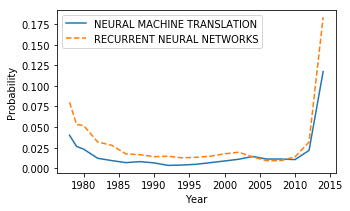

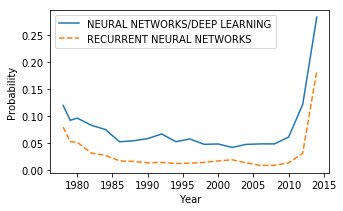

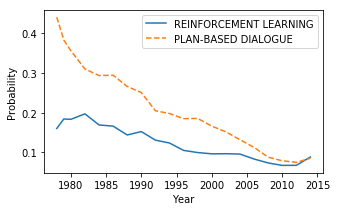

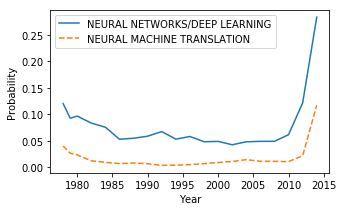

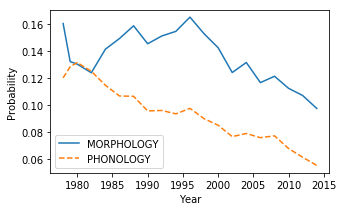

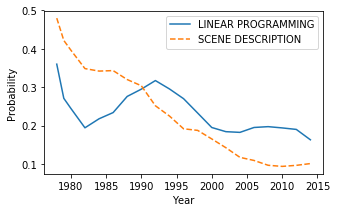

In [303]:
sorted_friendships = sorted(friendship.items(), key=lambda t: t[1]['score'], reverse=True)
avg_strength = sum([t[1]['score'] for t in sorted_friendships[:25]])/25.

plot_for_topics(sorted_friendships[0][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_friendships[1][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_friendships[2][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_friendships[3][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_friendships[4][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_friendships[-4][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])

pprint(avg_strength)
pprint(sorted_friendships)

1.329531914087263
[((19, 35),
  {'names': ['PHONOLOGY', 'SEMANTIC ROLE LABELING'], 'score': 1.938676207888}),
 ((2, 36), {'names': ['MORPHOLOGY', 'DISCOURSE'], 'score': 1.6262303018328526}),
 ((1, 36),
  {'names': ['FINITE STATE MACHINES', 'DISCOURSE'],
   'score': 1.5381074517429871}),
 ((25, 88),
  {'names': ['BIOMEDICAL', 'DEPENDENCY PARSING'], 'score': 1.4797279786108115}),
 ((19, 26),
  {'names': ['PHONOLOGY', 'ANAPHORA/COREFERENCE RESOLUTION'],
   'score': 1.477141604732378}),
 ((9, 88),
  {'names': ['ARGUMENT MINING', 'DEPENDENCY PARSING'],
   'score': 1.4647201623117305}),
 ((19, 85),
  {'names': ['PHONOLOGY', 'RELATION EXTRACTION'], 'score': 1.4527360779199732}),
 ((11, 28),
  {'names': ['TOPIC MODELS', 'DEPENDENCY PARSING'],
   'score': 1.4470475551482247}),
 ((19, 71), {'names': ['PHONOLOGY', 'ONTOLOGIES'], 'score': 1.442147200456071}),
 ((19, 36), {'names': ['PHONOLOGY', 'DISCOURSE'], 'score': 1.4129565700342057}),
 ((88, 98),
  {'names': ['DEPENDENCY PARSING', 'NEWS ARTICL

 ((46, 70),
  {'names': ['TRANSFER LEARNING', 'NARRATIVES'], 'score': 0.2878414803755416}),
 ((8, 52),
  {'names': ['LINEAR PROGRAMMING', 'MULTILINGUALITY'],
   'score': 0.2859924642150414}),
 ((43, 72),
  {'names': ['STATISTICAL MACHINE TRANSLATION', 'PREDICTION'],
   'score': 0.28510958935202324}),
 ((0, 90),
  {'names': ['DOMAIN ADAPTATION',
             'COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING'],
   'score': 0.28122098346908936}),
 ((38, 95),
  {'names': ['SYNTACTICAL STRUCTURE', 'GRAPH-BASED METHODS'],
   'score': 0.28102516893284235}),
 ((25, 52),
  {'names': ['BIOMEDICAL', 'MULTILINGUALITY'], 'score': 0.27995255673557584}),
 ((35, 93),
  {'names': ['SEMANTIC ROLE LABELING', 'SEQUENCE ANALYSIS'],
   'score': 0.2778809808678702}),
 ((32, 59),
  {'names': ['SPELLING CORRECTION', 'EVENT EXTRACTION'],
   'score': 0.27710065962277003}),
 ((3, 32),
  {'names': ['MULTI-WORD EXPRESSIONS', 'SPELLING CORRECTION'],
   'score': 0.2762423738925126}),
 ((5, 73),
  {'names': ['TREES', 'QUA

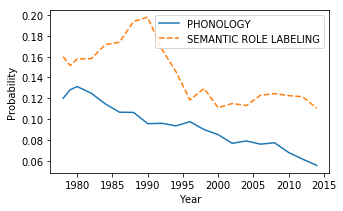

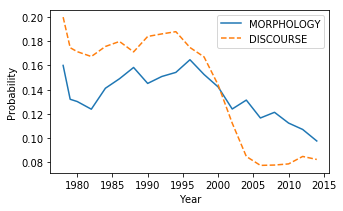

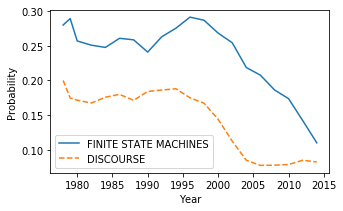

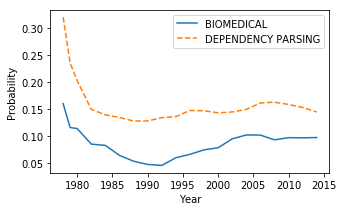

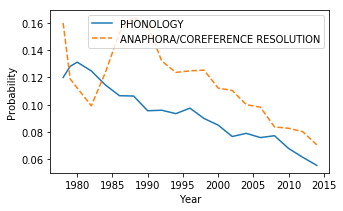

In [54]:
sorted_arms_race = sorted(arms_race.items(), key=lambda t: t[1]['score'], reverse=True)
avg_strength = sum([t[1]['score'] for t in sorted_arms_race[:25]])/25.

plot_for_topics(sorted_arms_race[0][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_arms_race[1][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_arms_race[2][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_arms_race[3][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_arms_race[4][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])

pprint(avg_strength)
pprint(sorted_arms_race)

4.7888557319782885
[((22, 82),
  {'names': ['UNIFICATION', 'TWITTER/SOCIAL MEDIA'],
   'score': 7.490792718267825}),
 ((22, 78),
  {'names': ['UNIFICATION', 'NEURAL MACHINE TRANSLATION'],
   'score': 6.046595901474105}),
 ((22, 79),
  {'names': ['UNIFICATION', 'RECURRENT NEURAL NETWORKS'],
   'score': 5.917172661008109}),
 ((60, 82),
  {'names': ['GRAMMARS', 'TWITTER/SOCIAL MEDIA'], 'score': 5.4251712795135125}),
 ((60, 78),
  {'names': ['GRAMMARS', 'NEURAL MACHINE TRANSLATION'],
   'score': 5.2117064921041685}),
 ((67, 78),
  {'names': ['DISAMBIGUATION', 'NEURAL MACHINE TRANSLATION'],
   'score': 5.130448515604169}),
 ((22, 39),
  {'names': ['UNIFICATION', 'VECTOR SPACE/SEMANTIC SIMILARITY'],
   'score': 5.04803428602995}),
 ((60, 79),
  {'names': ['GRAMMARS', 'RECURRENT NEURAL NETWORKS'],
   'score': 4.961533884418308}),
 ((50, 78),
  {'names': ['LEXICONS', 'NEURAL MACHINE TRANSLATION'],
   'score': 4.779605754567328}),
 ((22, 53),
  {'names': ['UNIFICATION', 'UNSUPERVISED LEARNING']

   'score': 0.8850944180686057}),
 ((50, 53),
  {'names': ['LEXICONS', 'UNSUPERVISED LEARNING'],
   'score': 0.8841227198562324}),
 ((26, 53),
  {'names': ['ANAPHORA/COREFERENCE RESOLUTION', 'UNSUPERVISED LEARNING'],
   'score': 0.8835861098376108}),
 ((71, 72),
  {'names': ['ONTOLOGIES', 'PREDICTION'], 'score': 0.879618107270916}),
 ((1, 39),
  {'names': ['FINITE STATE MACHINES', 'VECTOR SPACE/SEMANTIC SIMILARITY'],
   'score': 0.8762168969376564}),
 ((6, 28),
  {'names': ['REINFORCEMENT LEARNING', 'DEPENDENCY PARSING'],
   'score': 0.8719086168670932}),
 ((17, 69),
  {'names': ['EVENTS/TEMPORAL', 'NEURAL NETWORKS/DEEP LEARNING'],
   'score': 0.8701936555414682}),
 ((59, 76),
  {'names': ['EVENT EXTRACTION', 'CROSS-LINGUAL/PARALLEL CORPORA'],
   'score': 0.8698715522664594}),
 ((51, 92),
  {'names': ['CONSTITUENT PARSING', 'CLASSIFICATION'],
   'score': 0.8698360998434768}),
 ((43, 79),
  {'names': ['STATISTICAL MACHINE TRANSLATION', 'RECURRENT NEURAL NETWORKS'],
   'score': 0.8696570

   'score': 0.31865795907914396}),
 ((38, 76),
  {'names': ['SYNTACTICAL STRUCTURE', 'CROSS-LINGUAL/PARALLEL CORPORA'],
   'score': 0.3178109715347911}),
 ((22, 59),
  {'names': ['UNIFICATION', 'EVENT EXTRACTION'], 'score': 0.31163386635373913}),
 ((41, 59),
  {'names': ['PROBABILISTIC MODELS', 'EVENT EXTRACTION'],
   'score': 0.31062019534058793}),
 ((21, 55),
  {'names': ['POS TAGGING/STATISTICAL PARSING', 'EMBEDDINGS'],
   'score': 0.3097360442856234}),
 ((43, 59),
  {'names': ['STATISTICAL MACHINE TRANSLATION', 'EVENT EXTRACTION'],
   'score': 0.30959320881855873}),
 ((66, 72),
  {'names': ['HUMAN-COMPUTER INTERACTION/APPLICATION', 'PREDICTION'],
   'score': 0.3068861634379625}),
 ((26, 81),
  {'names': ['ANAPHORA/COREFERENCE RESOLUTION', 'OPINION MINING'],
   'score': 0.30648320813415764}),
 ((69, 98),
  {'names': ['NEURAL NETWORKS/DEEP LEARNING', 'NEWS ARTICLES'],
   'score': 0.30523808202605907}),
 ((3, 28),
  {'names': ['MULTI-WORD EXPRESSIONS', 'DEPENDENCY PARSING'],
   'score

 ((24, 80),
  {'names': ['TEXTUAL ENTAILMENT', 'COMPLEXITY ANALYSIS'],
   'score': 0.02322916449084094}),
 ((51, 57),
  {'names': ['CONSTITUENT PARSING', 'QUESTION ANSWERING'],
   'score': 0.023043582582594046}),
 ((74, 76),
  {'names': ['VISION/MULTIMODAL', 'CROSS-LINGUAL/PARALLEL CORPORA'],
   'score': 0.022293321078751857}),
 ((31, 80),
  {'names': ['SUMMARIZATION', 'COMPLEXITY ANALYSIS'],
   'score': 0.021317774240855878}),
 ((16, 17),
  {'names': ['DISCOURSE SEGMENTATION', 'EVENTS/TEMPORAL'],
   'score': 0.021208184762935654}),
 ((31, 55),
  {'names': ['SUMMARIZATION', 'EMBEDDINGS'], 'score': 0.020992412683636462}),
 ((16, 63),
  {'names': ['DISCOURSE SEGMENTATION', 'KNOWLEDGE BASE'],
   'score': 0.01985229046936591}),
 ((29, 76),
  {'names': ['DATABASE/RESOURCE?', 'CROSS-LINGUAL/PARALLEL CORPORA'],
   'score': 0.019832918151355926}),
 ((40, 86),
  {'names': ['MACHINE LEARNING', 'HISTORICAL LINGUISTICS'],
   'score': 0.019832297170064028}),
 ((88, 92),
  {'names': ['DEPENDENCY PAR

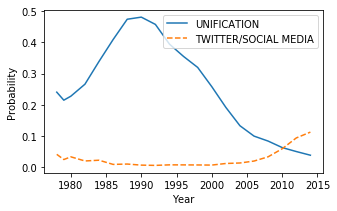

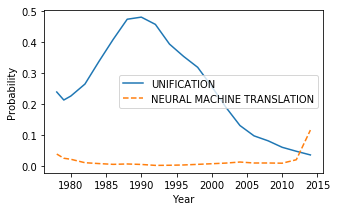

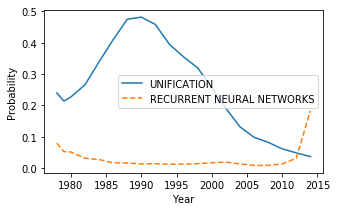

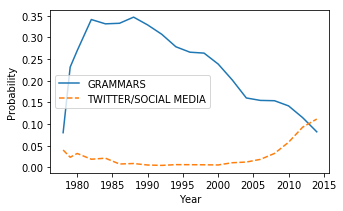

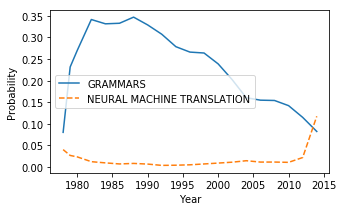

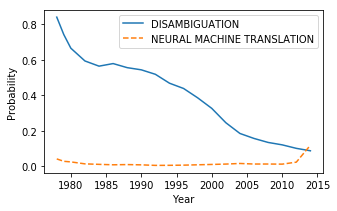

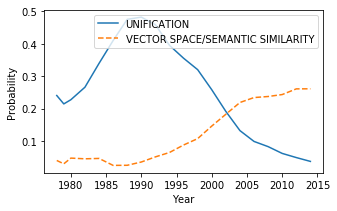

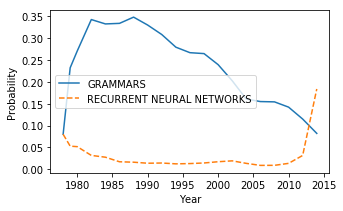

In [55]:
sorted_head_to_head = sorted(head_to_head.items(), key=lambda t: t[1]['score'], reverse=True)
avg_strength = sum([t[1]['score'] for t in sorted_head_to_head[:25]])/25.

plot_for_topics(sorted_head_to_head[0][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_head_to_head[1][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_head_to_head[2][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_head_to_head[3][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_head_to_head[4][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_head_to_head[5][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_head_to_head[6][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_head_to_head[7][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])

pprint(avg_strength)
pprint(sorted_head_to_head)


{'names': ['REINFORCEMENT LEARNING', 'NEURAL MACHINE TRANSLATION'], 'score': 1.0}
{'names': ['QUESTION ANSWERING', 'INFORMATION EXTRACTION?'], 'score': 0.6952937754485422}
2.016761285360581
[((14, 78),
  {'names': ['GENERATION', 'NEURAL MACHINE TRANSLATION'],
   'score': 3.8182831457672233}),
 ((6, 78),
  {'names': ['REINFORCEMENT LEARNING', 'NEURAL MACHINE TRANSLATION'],
   'score': 3.5917403957593215}),
 ((30, 82),
  {'names': ['SOCIAL MEDIA/WEB DATA', 'TWITTER/SOCIAL MEDIA'],
   'score': 3.258055783016212}),
 ((14, 31),
  {'names': ['GENERATION', 'SUMMARIZATION'], 'score': 3.0283936695068507}),
 ((43, 78),
  {'names': ['STATISTICAL MACHINE TRANSLATION', 'NEURAL MACHINE TRANSLATION'],
   'score': 2.7847927172506783}),
 ((31, 78),
  {'names': ['SUMMARIZATION', 'NEURAL MACHINE TRANSLATION'],
   'score': 2.7645187457441955}),
 ((17, 82),
  {'names': ['EVENTS/TEMPORAL', 'TWITTER/SOCIAL MEDIA'],
   'score': 2.5604252269413075}),
 ((59, 82),
  {'names': ['EVENT EXTRACTION', 'TWITTER/SOCIAL

  {'names': ['GRAMMARS', 'SEQUENCE ANALYSIS'], 'score': 0.07187681112976949}),
 ((73, 86),
  {'names': ['QUANTITATIVE ANALYSIS/TEXT MINING', 'HISTORICAL LINGUISTICS'],
   'score': 0.07186699643620907}),
 ((67, 91),
  {'names': ['DISAMBIGUATION', 'ASIAN LANGUAGES'],
   'score': 0.0717354588016225}),
 ((20, 55),
  {'names': ['STYLISTICS', 'EMBEDDINGS'], 'score': 0.06907029621097076}),
 ((39, 85),
  {'names': ['VECTOR SPACE/SEMANTIC SIMILARITY', 'RELATION EXTRACTION'],
   'score': 0.06856236509322584}),
 ((28, 59),
  {'names': ['DEPENDENCY PARSING', 'EVENT EXTRACTION'],
   'score': 0.06775438593496727}),
 ((30, 41),
  {'names': ['SOCIAL MEDIA/WEB DATA', 'PROBABILISTIC MODELS'],
   'score': 0.06758006759374473}),
 ((54, 59),
  {'names': ['RANKING', 'EVENT EXTRACTION'], 'score': 0.06741032490716446}),
 ((54, 55), {'names': ['RANKING', 'EMBEDDINGS'], 'score': 0.06595397277114966}),
 ((20, 69),
  {'names': ['STYLISTICS', 'NEURAL NETWORKS/DEEP LEARNING'],
   'score': 0.06573180373220089}),
 ((

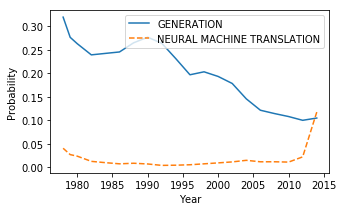

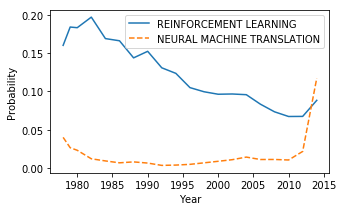

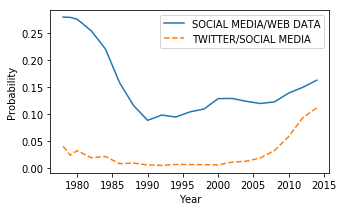

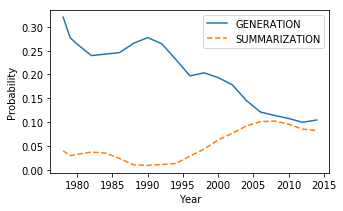

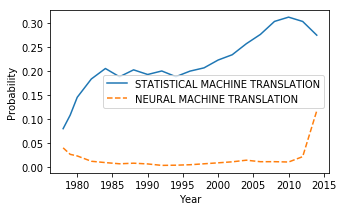

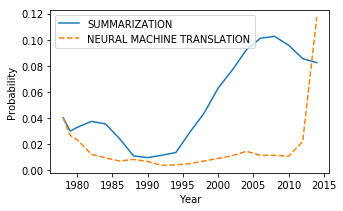

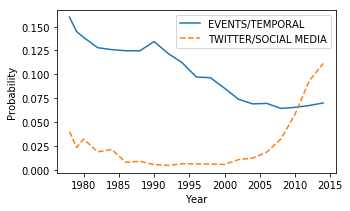

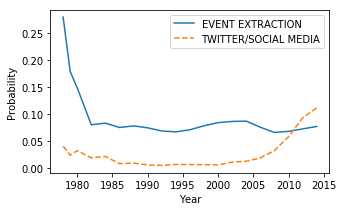

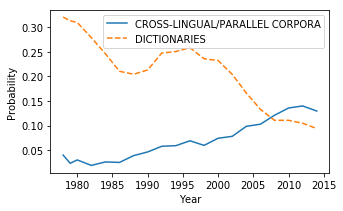

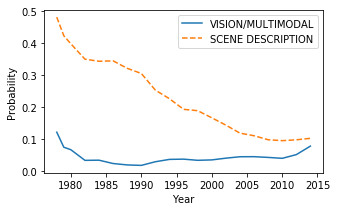

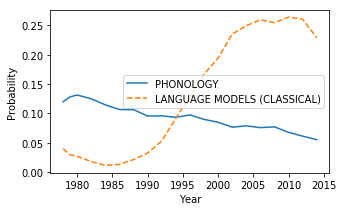

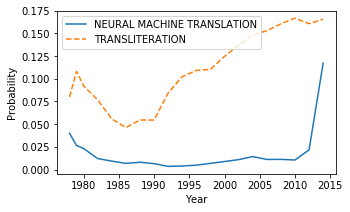

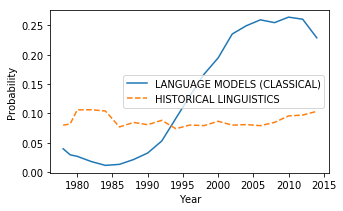

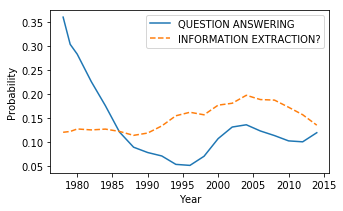

In [306]:
sorted_tryst = sorted(tryst.items(), key=lambda t: t[1]['score'], reverse=True)
avg_strength = sum([t[1]['score'] for t in sorted_tryst[:25]])/25.

plot_for_topics(sorted_tryst[0][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[1][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[2][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[3][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[4][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[5][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[6][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[7][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[8][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[9][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[10][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[11][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[-11][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])
plot_for_topics(sorted_tryst[-5][0], size=(5,3), conferences=['ACL', 'EMNLP', 'COLING', 'NAACL'])


pprint(avg_strength)
pprint(sorted_tryst)

In [57]:
def relationship_kind(topic1, topic2):
    sorted_pair = tuple(sorted((topic1, topic2)))
    if sorted_pair in friendship:
        return 'friendship', friendship[sorted_pair]
    elif sorted_pair in arms_race:
        return 'arms_race', arms_race[sorted_pair]
    elif sorted_pair in head_to_head:
        return 'head_to_head', head_to_head[sorted_pair]
    elif sorted_pair in tryst:
        return 'tryst', tryst[sorted_pair]
    return "not found"

def relation_with_topic(topic1):
    friendships_with_topic = {pair: friendship[pair] for pair in friendship.keys() if topic1 in pair}
    print("Top friendships:")
    pprint(sorted(friendships_with_topic.items(), key=lambda t:t[1]['score'], reverse=True)[:5])
    arms_race_with_topic = {pair: arms_race[pair] for pair in arms_race.keys() if topic1 in pair}
    print("Top arms race:")
    pprint(sorted(arms_race_with_topic.items(), key=lambda t:t[1]['score'], reverse=True)[:5])
    head_to_head_with_topic = {pair: head_to_head[pair] for pair in head_to_head.keys() if topic1 in pair}
    print("Top head to head:")
    pprint(sorted(head_to_head_with_topic.items(), key=lambda t:t[1]['score'], reverse=True)[:5])
    tryst_with_topic = {pair: tryst[pair] for pair in tryst.keys() if topic1 in pair}
    print("Top tryst:")
    pprint(sorted(tryst_with_topic.items(), key=lambda t:t[1]['score'], reverse=True)[:5])
    
for topic in neural_topics:
    relation_with_topic(topic)


Top friendships:
[((69, 79),
  {'names': ['NEURAL NETWORKS/DEEP LEARNING', 'RECURRENT NEURAL NETWORKS'],
   'score': 7.5846883696558}),
 ((69, 78),
  {'names': ['NEURAL NETWORKS/DEEP LEARNING', 'NEURAL MACHINE TRANSLATION'],
   'score': 6.1135780809841735}),
 ((55, 69),
  {'names': ['EMBEDDINGS', 'NEURAL NETWORKS/DEEP LEARNING'],
   'score': 3.302057586698216}),
 ((69, 74),
  {'names': ['NEURAL NETWORKS/DEEP LEARNING', 'VISION/MULTIMODAL'],
   'score': 0.8523171101672382}),
 ((69, 82),
  {'names': ['NEURAL NETWORKS/DEEP LEARNING', 'TWITTER/SOCIAL MEDIA'],
   'score': 0.5975643791492117})]
Top arms race:
[]
Top head to head:
[((22, 69),
  {'names': ['UNIFICATION', 'NEURAL NETWORKS/DEEP LEARNING'],
   'score': 3.7708304576284832}),
 ((60, 69),
  {'names': ['GRAMMARS', 'NEURAL NETWORKS/DEEP LEARNING'],
   'score': 3.3843445844201154}),
 ((69, 91),
  {'names': ['NEURAL NETWORKS/DEEP LEARNING', 'ASIAN LANGUAGES'],
   'score': 2.791480376905162}),
 ((50, 69),
  {'names': ['LEXICONS', 'NEURAL

In [239]:
strengths

{(32, 54): {'names': ['SPELLING CORRECTION', 'RANKING'],
  'score': 0.0589630646101239},
 (14, 74): {'names': ['GENERATION', 'VISION/MULTIMODAL'],
  'score': 0.36686626147424156},
 (21, 28): {'names': ['POS TAGGING/STATISTICAL PARSING', 'DEPENDENCY PARSING'],
  'score': 1.7141922216075614},
 (4, 36): {'names': ['SENTIMENT ANALYSIS', 'DISCOURSE'],
  'score': 0.9082424096553477},
 (8, 63): {'names': ['LINEAR PROGRAMMING', 'KNOWLEDGE BASE'],
  'score': 0.0390075330071073},
 (7, 25): {'names': ['SVMs', 'BIOMEDICAL'], 'score': 0.1728387637422422},
 (63, 76): {'names': ['KNOWLEDGE BASE', 'CROSS-LINGUAL/PARALLEL CORPORA'],
  'score': 0.31642291198764616},
 (48, 86): {'names': ['SPEECH RECOGNITION', 'HISTORICAL LINGUISTICS'],
  'score': 0.18649070959331185},
 (11,
  90): {'names': ['TOPIC MODELS',
   'COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING'], 'score': 0.28908271685784787},
 (72, 92): {'names': ['PREDICTION', 'CLASSIFICATION'],
  'score': 1.215502585621214},
 (73,
  82): {'names': ['QUANT

### Relationships over time

In [434]:
timespan = [1978, 2019]
timestep = 10

time_ranges = []

y0 = timespan[0]
for y1 in range(timespan[0]+timestep, timespan[1], timestep):
    time_ranges.append((y0, y1))
    y0 = y1

print(time_ranges)

[(1978, 1988), (1988, 1998), (1998, 2008), (2008, 2018)]


In [435]:
def _probs_for_topic(topic, df, time_range=range(1978, 2018)):
    counts_per_year = df[df['Dominant_Topic']==topic].groupby('Year', as_index=False).count()
    documents_per_year = df.groupby(['Document'], as_index=False).first().groupby('Year').count()[['Document']].to_dict()['Document']
    counts_per_year['Docs_per_year'] = counts_per_year['Year'].apply(lambda y: documents_per_year[y])
    counts_per_year['Probability'] = counts_per_year['Document']/counts_per_year['Docs_per_year']
    counts_per_year = counts_per_year.set_index('Year')
    probs = counts_per_year.reindex(time_range, fill_value=0).Probability.values
    return probs

def corr_for_range(topic1, topic2, df, time_range=range(1978, 2018)):
    c1 = _probs_for_topic(topic1, df, time_range=time_range)
    # Topic not found in this time range
    if sum(c1) == 0:
        return None
    c2 = _probs_for_topic(topic2, df, time_range=time_range)
    if sum(c2) == 0:
        return None
    corr = pearsonr(c1, c2)
    return corr[0]

In [436]:
def compute_corrs_per_range(df, time_range=(1978,2018)):
    for topic1 in range(100):
        for topic2 in range(100):
            if topic1 < topic2:
                corr_coef = corr_for_range(topic1, topic2, df, time_range=range(*time_range))
                if corr_coef is None or np.isnan(corr_coef):
                    print(topic1, "or", topic2, "doesn't occur in time range", time_range)
                    continue
#                 assert(corr_coef == corr(topic2, topic1))
                print(topic1, topic2, topic_names[topic1], topic_names[topic2], corr_coef)
                corrs_per_range[time_range][(topic1, topic2)] = {'names': [topic_names[topic1], topic_names[topic2]], 
                                                     'score': corr_coef}

In [437]:
%%time
corrs_per_range = {}
for r in time_ranges:
    corrs_per_range[r] = {}
    compute_corrs_per_range(df, r)


0 1 DOMAIN ADAPTATION FINITE STATE MACHINES 0.9591714518421952
0 2 DOMAIN ADAPTATION MORPHOLOGY 0.9830152231478372
0 3 DOMAIN ADAPTATION MULTI-WORD EXPRESSIONS 0.8976344263411551
0 4 DOMAIN ADAPTATION SENTIMENT ANALYSIS 0.9761171498426766
0 5 DOMAIN ADAPTATION TREES 0.9796835184013006
0 6 DOMAIN ADAPTATION REINFORCEMENT LEARNING 0.9516430582897526
0 7 DOMAIN ADAPTATION SVMs 0.7111997049895002
0 8 DOMAIN ADAPTATION LINEAR PROGRAMMING 0.9646723829232197
0 9 DOMAIN ADAPTATION ARGUMENT MINING 0.894316512976263
0 or 10 doesn't occur in time range (1978, 1988)
0 11 DOMAIN ADAPTATION TOPIC MODELS 0.9124219356099644
0 12 DOMAIN ADAPTATION CLUSTERING 0.8953540383074513
0 13 DOMAIN ADAPTATION LANGUAGE ACQUISITION/SIMPLIFICATION 0.8892112983934232
0 14 DOMAIN ADAPTATION GENERATION 0.9931151430111077
0 15 DOMAIN ADAPTATION NAMED ENTITY RECOGNITION 0.6688230784919578
0 16 DOMAIN ADAPTATION DISCOURSE SEGMENTATION 0.8405362700537545
0 17 DOMAIN ADAPTATION EVENTS/TEMPORAL 0.9903773681488024
0 or 18 do

1 40 FINITE STATE MACHINES MACHINE LEARNING 0.852836122327734
1 41 FINITE STATE MACHINES PROBABILISTIC MODELS 0.7776892216012112
1 or 42 doesn't occur in time range (1978, 1988)
1 43 FINITE STATE MACHINES STATISTICAL MACHINE TRANSLATION 0.8529906671195719
1 or 44 doesn't occur in time range (1978, 1988)
1 or 45 doesn't occur in time range (1978, 1988)
1 46 FINITE STATE MACHINES TRANSFER LEARNING 0.9368251183522586
1 or 47 doesn't occur in time range (1978, 1988)
1 48 FINITE STATE MACHINES SPEECH RECOGNITION 0.9467495833001135
1 or 49 doesn't occur in time range (1978, 1988)
1 50 FINITE STATE MACHINES LEXICONS 0.9040356737957373
1 51 FINITE STATE MACHINES CONSTITUENT PARSING 0.9711644634133999
1 52 FINITE STATE MACHINES MULTILINGUALITY 0.8983575750279899
1 53 FINITE STATE MACHINES UNSUPERVISED LEARNING 0.6979405754922067
1 54 FINITE STATE MACHINES RANKING 0.8226236382014546
1 55 FINITE STATE MACHINES EMBEDDINGS 0.8997212315082499
1 56 FINITE STATE MACHINES PLAN-BASED DIALOGUE 0.96075754

2 87 MORPHOLOGY WORDNET/DISAMBIGUATION 0.8387758688821286
2 88 MORPHOLOGY DEPENDENCY PARSING 0.8945270963774967
2 89 MORPHOLOGY INFORMATION RETRIEVAL 0.9024686429481081
2 90 MORPHOLOGY COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.8736510388509198
2 91 MORPHOLOGY ASIAN LANGUAGES 0.7394682911598471
2 92 MORPHOLOGY CLASSIFICATION 0.7238087880642691
2 93 MORPHOLOGY SEQUENCE ANALYSIS 0.9890362435781771
2 94 MORPHOLOGY FRAME SEMANTICS 0.9918048743728612
2 95 MORPHOLOGY GRAPH-BASED METHODS 0.953896362196203
2 or 96 doesn't occur in time range (1978, 1988)
2 or 97 doesn't occur in time range (1978, 1988)
2 98 MORPHOLOGY NEWS ARTICLES 0.9431631356893881
2 99 MORPHOLOGY SCENE DESCRIPTION 0.9764216582842001
3 4 MULTI-WORD EXPRESSIONS SENTIMENT ANALYSIS 0.9376830678002068
3 5 MULTI-WORD EXPRESSIONS TREES 0.8308112670969077
3 6 MULTI-WORD EXPRESSIONS REINFORCEMENT LEARNING 0.8872010222137443
3 7 MULTI-WORD EXPRESSIONS SVMs 0.7512403517679708
3 8 MULTI-WORD EXPRESSIONS LINEAR PROGRAMMING 0.9187511

4 29 SENTIMENT ANALYSIS DATABASE/RESOURCE? 0.8454862844120787
4 30 SENTIMENT ANALYSIS SOCIAL MEDIA/WEB DATA 0.9720210082586023
4 31 SENTIMENT ANALYSIS SUMMARIZATION 0.8949484629749944
4 32 SENTIMENT ANALYSIS SPELLING CORRECTION 0.9922938828266062
4 or 33 doesn't occur in time range (1978, 1988)
4 34 SENTIMENT ANALYSIS EVALUATION/ANNOTATION 0.9093924091832769
4 35 SENTIMENT ANALYSIS SEMANTIC ROLE LABELING 0.9196547093264802
4 36 SENTIMENT ANALYSIS DISCOURSE 0.9595882781976306
4 or 37 doesn't occur in time range (1978, 1988)
4 38 SENTIMENT ANALYSIS SYNTACTICAL STRUCTURE 0.9248904212106724
4 39 SENTIMENT ANALYSIS VECTOR SPACE/SEMANTIC SIMILARITY 0.7853282413901825
4 40 SENTIMENT ANALYSIS MACHINE LEARNING 0.8518758752168554
4 41 SENTIMENT ANALYSIS PROBABILISTIC MODELS 0.8322152429116297
4 or 42 doesn't occur in time range (1978, 1988)
4 43 SENTIMENT ANALYSIS STATISTICAL MACHINE TRANSLATION 0.7589824444022256
4 or 44 doesn't occur in time range (1978, 1988)
4 or 45 doesn't occur in time ran

5 86 TREES HISTORICAL LINGUISTICS 0.891701836991055
5 87 TREES WORDNET/DISAMBIGUATION 0.8118507543955917
5 88 TREES DEPENDENCY PARSING 0.840180776450923
5 89 TREES INFORMATION RETRIEVAL 0.895774314325023
5 90 TREES COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.8701456120659231
5 91 TREES ASIAN LANGUAGES 0.7776483531422195
5 92 TREES CLASSIFICATION 0.7362358031985852
5 93 TREES SEQUENCE ANALYSIS 0.9812387690431211
5 94 TREES FRAME SEMANTICS 0.9852173330456498
5 95 TREES GRAPH-BASED METHODS 0.9777997658259503
5 or 96 doesn't occur in time range (1978, 1988)
5 or 97 doesn't occur in time range (1978, 1988)
5 98 TREES NEWS ARTICLES 0.9029301490314127
5 99 TREES SCENE DESCRIPTION 0.9475176697920599
6 7 REINFORCEMENT LEARNING SVMs 0.5792346797048171
6 8 REINFORCEMENT LEARNING LINEAR PROGRAMMING 0.8584751890992668
6 9 REINFORCEMENT LEARNING ARGUMENT MINING 0.9108380075140797
6 or 10 doesn't occur in time range (1978, 1988)
6 11 REINFORCEMENT LEARNING TOPIC MODELS 0.9068371169600705
6 12 REIN

7 or 42 doesn't occur in time range (1978, 1988)
7 43 SVMs STATISTICAL MACHINE TRANSLATION 0.2671189433329723
7 or 44 doesn't occur in time range (1978, 1988)
7 or 45 doesn't occur in time range (1978, 1988)
7 46 SVMs TRANSFER LEARNING 0.7279804823287818
7 or 47 doesn't occur in time range (1978, 1988)
7 48 SVMs SPEECH RECOGNITION 0.7112305231617284
7 or 49 doesn't occur in time range (1978, 1988)
7 50 SVMs LEXICONS 0.35188580076952186
7 51 SVMs CONSTITUENT PARSING 0.5378240331427726
7 52 SVMs MULTILINGUALITY 0.5929472422277148
7 53 SVMs UNSUPERVISED LEARNING 0.8762095549046147
7 54 SVMs RANKING 0.9117919429466863
7 55 SVMs EMBEDDINGS 0.49033291639280324
7 56 SVMs PLAN-BASED DIALOGUE 0.7733139369688037
7 57 SVMs QUESTION ANSWERING 0.8681646014100469
7 or 58 doesn't occur in time range (1978, 1988)
7 59 SVMs EVENT EXTRACTION 0.9614709747529708
7 60 SVMs GRAMMARS 0.17406521235855793
7 61 SVMs LOGICAL FORMS 0.5519631684800119
7 or 62 doesn't occur in time range (1978, 1988)
7 63 SVMs KNOW

8 98 LINEAR PROGRAMMING NEWS ARTICLES 0.9700479455812079
8 99 LINEAR PROGRAMMING SCENE DESCRIPTION 0.9779175096130451
9 or 10 doesn't occur in time range (1978, 1988)
9 11 ARGUMENT MINING TOPIC MODELS 0.892319464136503
9 12 ARGUMENT MINING CLUSTERING 0.92397218978966
9 13 ARGUMENT MINING LANGUAGE ACQUISITION/SIMPLIFICATION 0.8716805083221583
9 14 ARGUMENT MINING GENERATION 0.9231599130199238
9 15 ARGUMENT MINING NAMED ENTITY RECOGNITION 0.7065603907469884
9 16 ARGUMENT MINING DISCOURSE SEGMENTATION 0.7025008759214777
9 17 ARGUMENT MINING EVENTS/TEMPORAL 0.9346285868423508
9 or 18 doesn't occur in time range (1978, 1988)
9 19 ARGUMENT MINING PHONOLOGY 0.9534496064111017
9 20 ARGUMENT MINING STYLISTICS 0.9945074023350822
9 21 ARGUMENT MINING POS TAGGING/STATISTICAL PARSING 0.8916939940066337
9 22 ARGUMENT MINING UNIFICATION 0.6989372054551223
9 23 ARGUMENT MINING LANGUAGE MODELS (CLASSICAL) 0.8899446839897246
9 24 ARGUMENT MINING TEXTUAL ENTAILMENT 0.8219091869060445
9 25 ARGUMENT MINING

10 or 70 doesn't occur in time range (1978, 1988)
10 or 71 doesn't occur in time range (1978, 1988)
10 or 72 doesn't occur in time range (1978, 1988)
10 or 73 doesn't occur in time range (1978, 1988)
10 or 74 doesn't occur in time range (1978, 1988)
10 or 75 doesn't occur in time range (1978, 1988)
10 or 76 doesn't occur in time range (1978, 1988)
10 or 77 doesn't occur in time range (1978, 1988)
10 or 78 doesn't occur in time range (1978, 1988)
10 or 79 doesn't occur in time range (1978, 1988)
10 or 80 doesn't occur in time range (1978, 1988)
10 or 81 doesn't occur in time range (1978, 1988)
10 or 82 doesn't occur in time range (1978, 1988)
10 or 83 doesn't occur in time range (1978, 1988)
10 or 84 doesn't occur in time range (1978, 1988)
10 or 85 doesn't occur in time range (1978, 1988)
10 or 86 doesn't occur in time range (1978, 1988)
10 or 87 doesn't occur in time range (1978, 1988)
10 or 88 doesn't occur in time range (1978, 1988)
10 or 89 doesn't occur in time range (1978, 1988)


12 or 45 doesn't occur in time range (1978, 1988)
12 46 CLUSTERING TRANSFER LEARNING 0.7773667851570848
12 or 47 doesn't occur in time range (1978, 1988)
12 48 CLUSTERING SPEECH RECOGNITION 0.873199650828132
12 or 49 doesn't occur in time range (1978, 1988)
12 50 CLUSTERING LEXICONS 0.7564655711565511
12 51 CLUSTERING CONSTITUENT PARSING 0.7994443922198627
12 52 CLUSTERING MULTILINGUALITY 0.8444025926407062
12 53 CLUSTERING UNSUPERVISED LEARNING 0.8290382601019477
12 54 CLUSTERING RANKING 0.7977917147465498
12 55 CLUSTERING EMBEDDINGS 0.9504267564180926
12 56 CLUSTERING PLAN-BASED DIALOGUE 0.9074724938103659
12 57 CLUSTERING QUESTION ANSWERING 0.9412532101984689
12 or 58 doesn't occur in time range (1978, 1988)
12 59 CLUSTERING EVENT EXTRACTION 0.7023805076980331
12 60 CLUSTERING GRAMMARS 0.7319478289999174
12 61 CLUSTERING LOGICAL FORMS 0.8591323485618189
12 or 62 doesn't occur in time range (1978, 1988)
12 63 CLUSTERING KNOWLEDGE BASE 0.6651181901383316
12 or 64 doesn't occur in time

13 84 LANGUAGE ACQUISITION/SIMPLIFICATION DICTIONARIES 0.9266093754944831
13 85 LANGUAGE ACQUISITION/SIMPLIFICATION RELATION EXTRACTION 0.9341359958869165
13 86 LANGUAGE ACQUISITION/SIMPLIFICATION HISTORICAL LINGUISTICS 0.8948656187557665
13 87 LANGUAGE ACQUISITION/SIMPLIFICATION WORDNET/DISAMBIGUATION 0.7467688971329963
13 88 LANGUAGE ACQUISITION/SIMPLIFICATION DEPENDENCY PARSING 0.7374332309285682
13 89 LANGUAGE ACQUISITION/SIMPLIFICATION INFORMATION RETRIEVAL 0.8474779798374424
13 90 LANGUAGE ACQUISITION/SIMPLIFICATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.840133831595653
13 91 LANGUAGE ACQUISITION/SIMPLIFICATION ASIAN LANGUAGES 0.8504613854236241
13 92 LANGUAGE ACQUISITION/SIMPLIFICATION CLASSIFICATION 0.8412868179996086
13 93 LANGUAGE ACQUISITION/SIMPLIFICATION SEQUENCE ANALYSIS 0.8852290336127291
13 94 LANGUAGE ACQUISITION/SIMPLIFICATION FRAME SEMANTICS 0.8696059599636204
13 95 LANGUAGE ACQUISITION/SIMPLIFICATION GRAPH-BASED METHODS 0.9548060663104955
13 or 96 doesn't oc

15 52 NAMED ENTITY RECOGNITION MULTILINGUALITY 0.5406755918287247
15 53 NAMED ENTITY RECOGNITION UNSUPERVISED LEARNING 0.8251077422259747
15 54 NAMED ENTITY RECOGNITION RANKING 0.8971595380427666
15 55 NAMED ENTITY RECOGNITION EMBEDDINGS 0.4062222675550204
15 56 NAMED ENTITY RECOGNITION PLAN-BASED DIALOGUE 0.7328163013249324
15 57 NAMED ENTITY RECOGNITION QUESTION ANSWERING 0.8124635385666238
15 or 58 doesn't occur in time range (1978, 1988)
15 59 NAMED ENTITY RECOGNITION EVENT EXTRACTION 0.9628760617380475
15 60 NAMED ENTITY RECOGNITION GRAMMARS 0.10884951319669578
15 61 NAMED ENTITY RECOGNITION LOGICAL FORMS 0.5056177220332153
15 or 62 doesn't occur in time range (1978, 1988)
15 63 NAMED ENTITY RECOGNITION KNOWLEDGE BASE 0.9045168113059098
15 or 64 doesn't occur in time range (1978, 1988)
15 65 NAMED ENTITY RECOGNITION INFORMATION EXTRACTION? 0.5222038573952356
15 66 NAMED ENTITY RECOGNITION HUMAN-COMPUTER INTERACTION/APPLICATION 0.364077151934869
15 67 NAMED ENTITY RECOGNITION DISAM

16 94 DISCOURSE SEGMENTATION FRAME SEMANTICS 0.8859918914057701
16 95 DISCOURSE SEGMENTATION GRAPH-BASED METHODS 0.9181667451513779
16 or 96 doesn't occur in time range (1978, 1988)
16 or 97 doesn't occur in time range (1978, 1988)
16 98 DISCOURSE SEGMENTATION NEWS ARTICLES 0.760153300111711
16 99 DISCOURSE SEGMENTATION SCENE DESCRIPTION 0.8403869834701072
17 or 18 doesn't occur in time range (1978, 1988)
17 19 EVENTS/TEMPORAL PHONOLOGY 0.9763609918523143
17 20 EVENTS/TEMPORAL STYLISTICS 0.8980352067188777
17 21 EVENTS/TEMPORAL POS TAGGING/STATISTICAL PARSING 0.9384782698842372
17 22 EVENTS/TEMPORAL UNIFICATION 0.8998654026149855
17 23 EVENTS/TEMPORAL LANGUAGE MODELS (CLASSICAL) 0.7953863425777261
17 24 EVENTS/TEMPORAL TEXTUAL ENTAILMENT 0.8262085050028756
17 25 EVENTS/TEMPORAL BIOMEDICAL 0.9341344598496572
17 26 EVENTS/TEMPORAL ANAPHORA/COREFERENCE RESOLUTION 0.9564178249863525
17 or 27 doesn't occur in time range (1978, 1988)
17 28 EVENTS/TEMPORAL DEPENDENCY PARSING 0.967586441542998

18 or 80 doesn't occur in time range (1978, 1988)
18 or 81 doesn't occur in time range (1978, 1988)
18 or 82 doesn't occur in time range (1978, 1988)
18 or 83 doesn't occur in time range (1978, 1988)
18 or 84 doesn't occur in time range (1978, 1988)
18 or 85 doesn't occur in time range (1978, 1988)
18 or 86 doesn't occur in time range (1978, 1988)
18 or 87 doesn't occur in time range (1978, 1988)
18 or 88 doesn't occur in time range (1978, 1988)
18 or 89 doesn't occur in time range (1978, 1988)
18 or 90 doesn't occur in time range (1978, 1988)
18 or 91 doesn't occur in time range (1978, 1988)
18 or 92 doesn't occur in time range (1978, 1988)
18 or 93 doesn't occur in time range (1978, 1988)
18 or 94 doesn't occur in time range (1978, 1988)
18 or 95 doesn't occur in time range (1978, 1988)
18 or 96 doesn't occur in time range (1978, 1988)
18 or 97 doesn't occur in time range (1978, 1988)
18 or 98 doesn't occur in time range (1978, 1988)
18 or 99 doesn't occur in time range (1978, 1988)


20 74 STYLISTICS VISION/MULTIMODAL 0.7739847968496611
20 or 75 doesn't occur in time range (1978, 1988)
20 76 STYLISTICS CROSS-LINGUAL/PARALLEL CORPORA 0.7132258162244708
20 or 77 doesn't occur in time range (1978, 1988)
20 78 STYLISTICS NEURAL MACHINE TRANSLATION 0.8238659757977451
20 79 STYLISTICS RECURRENT NEURAL NETWORKS 0.8533287701428642
20 80 STYLISTICS COMPLEXITY ANALYSIS 0.9078329564171855
20 81 STYLISTICS OPINION MINING 0.925024891788546
20 82 STYLISTICS TWITTER/SOCIAL MEDIA 0.7153096488139356
20 83 STYLISTICS TRANSLITERATION 0.9199570386127276
20 84 STYLISTICS DICTIONARIES 0.9571649205607593
20 85 STYLISTICS RELATION EXTRACTION 0.8578046595623267
20 86 STYLISTICS HISTORICAL LINGUISTICS 0.8446928169275896
20 87 STYLISTICS WORDNET/DISAMBIGUATION 0.8656047844738376
20 88 STYLISTICS DEPENDENCY PARSING 0.8658267134654978
20 89 STYLISTICS INFORMATION RETRIEVAL 0.8917080491264767
20 90 STYLISTICS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.7322249316642623
20 91 STYLISTICS ASIAN

22 or 44 doesn't occur in time range (1978, 1988)
22 or 45 doesn't occur in time range (1978, 1988)
22 46 UNIFICATION TRANSFER LEARNING 0.8595445288324256
22 or 47 doesn't occur in time range (1978, 1988)
22 48 UNIFICATION SPEECH RECOGNITION 0.8131449248904961
22 or 49 doesn't occur in time range (1978, 1988)
22 50 UNIFICATION LEXICONS 0.9767656052108631
22 51 UNIFICATION CONSTITUENT PARSING 0.9813308806533546
22 52 UNIFICATION MULTILINGUALITY 0.9183217836411521
22 53 UNIFICATION UNSUPERVISED LEARNING 0.5323630110727743
22 54 UNIFICATION RANKING 0.7312603139888111
22 55 UNIFICATION EMBEDDINGS 0.7680099825219968
22 56 UNIFICATION PLAN-BASED DIALOGUE 0.8561706635830622
22 57 UNIFICATION QUESTION ANSWERING 0.6827138067953847
22 or 58 doesn't occur in time range (1978, 1988)
22 59 UNIFICATION EVENT EXTRACTION 0.6089611886400669
22 60 UNIFICATION GRAMMARS 0.8485240275497821
22 61 UNIFICATION LOGICAL FORMS 0.9456379133649279
22 or 62 doesn't occur in time range (1978, 1988)
22 63 UNIFICATION

23 99 LANGUAGE MODELS (CLASSICAL) SCENE DESCRIPTION 0.8198224145160464
24 25 TEXTUAL ENTAILMENT BIOMEDICAL 0.9384394568860879
24 26 TEXTUAL ENTAILMENT ANAPHORA/COREFERENCE RESOLUTION 0.8388953246271204
24 or 27 doesn't occur in time range (1978, 1988)
24 28 TEXTUAL ENTAILMENT DEPENDENCY PARSING 0.7807674687161478
24 29 TEXTUAL ENTAILMENT DATABASE/RESOURCE? 0.5762845521182293
24 30 TEXTUAL ENTAILMENT SOCIAL MEDIA/WEB DATA 0.7876024849590844
24 31 TEXTUAL ENTAILMENT SUMMARIZATION 0.7149660610090748
24 32 TEXTUAL ENTAILMENT SPELLING CORRECTION 0.8442815734405046
24 or 33 doesn't occur in time range (1978, 1988)
24 34 TEXTUAL ENTAILMENT EVALUATION/ANNOTATION 0.7376777658001815
24 35 TEXTUAL ENTAILMENT SEMANTIC ROLE LABELING 0.7265997741509306
24 36 TEXTUAL ENTAILMENT DISCOURSE 0.7998930052270815
24 or 37 doesn't occur in time range (1978, 1988)
24 38 TEXTUAL ENTAILMENT SYNTACTICAL STRUCTURE 0.7275206308436364
24 39 TEXTUAL ENTAILMENT VECTOR SPACE/SEMANTIC SIMILARITY 0.5886895324366993
24 4

25 91 BIOMEDICAL ASIAN LANGUAGES 0.4964155914751798
25 92 BIOMEDICAL CLASSIFICATION 0.8345193741442276
25 93 BIOMEDICAL SEQUENCE ANALYSIS 0.8754008996582365
25 94 BIOMEDICAL FRAME SEMANTICS 0.8909925125497934
25 95 BIOMEDICAL GRAPH-BASED METHODS 0.8423214263002208
25 or 96 doesn't occur in time range (1978, 1988)
25 or 97 doesn't occur in time range (1978, 1988)
25 98 BIOMEDICAL NEWS ARTICLES 0.9806638763597945
25 99 BIOMEDICAL SCENE DESCRIPTION 0.9487079078960752
26 or 27 doesn't occur in time range (1978, 1988)
26 28 ANAPHORA/COREFERENCE RESOLUTION DEPENDENCY PARSING 0.9476551707297424
26 29 ANAPHORA/COREFERENCE RESOLUTION DATABASE/RESOURCE? 0.8352555255099772
26 30 ANAPHORA/COREFERENCE RESOLUTION SOCIAL MEDIA/WEB DATA 0.8842017464002413
26 31 ANAPHORA/COREFERENCE RESOLUTION SUMMARIZATION 0.8101988742874249
26 32 ANAPHORA/COREFERENCE RESOLUTION SPELLING CORRECTION 0.8757438442812854
26 or 33 doesn't occur in time range (1978, 1988)
26 34 ANAPHORA/COREFERENCE RESOLUTION EVALUATION/ANN

27 or 79 doesn't occur in time range (1978, 1988)
27 or 80 doesn't occur in time range (1978, 1988)
27 or 81 doesn't occur in time range (1978, 1988)
27 or 82 doesn't occur in time range (1978, 1988)
27 or 83 doesn't occur in time range (1978, 1988)
27 or 84 doesn't occur in time range (1978, 1988)
27 or 85 doesn't occur in time range (1978, 1988)
27 or 86 doesn't occur in time range (1978, 1988)
27 or 87 doesn't occur in time range (1978, 1988)
27 or 88 doesn't occur in time range (1978, 1988)
27 or 89 doesn't occur in time range (1978, 1988)
27 or 90 doesn't occur in time range (1978, 1988)
27 or 91 doesn't occur in time range (1978, 1988)
27 or 92 doesn't occur in time range (1978, 1988)
27 or 93 doesn't occur in time range (1978, 1988)
27 or 94 doesn't occur in time range (1978, 1988)
27 or 95 doesn't occur in time range (1978, 1988)
27 or 96 doesn't occur in time range (1978, 1988)
27 or 97 doesn't occur in time range (1978, 1988)
27 or 98 doesn't occur in time range (1978, 1988)


29 or 77 doesn't occur in time range (1978, 1988)
29 78 DATABASE/RESOURCE? NEURAL MACHINE TRANSLATION 0.5470720781535124
29 79 DATABASE/RESOURCE? RECURRENT NEURAL NETWORKS 0.6764852568007886
29 80 DATABASE/RESOURCE? COMPLEXITY ANALYSIS 0.9423309200210789
29 81 DATABASE/RESOURCE? OPINION MINING 0.7012555822748472
29 82 DATABASE/RESOURCE? TWITTER/SOCIAL MEDIA 0.7197962908196441
29 83 DATABASE/RESOURCE? TRANSLITERATION 0.7193030851131513
29 84 DATABASE/RESOURCE? DICTIONARIES 0.9097953448388769
29 85 DATABASE/RESOURCE? RELATION EXTRACTION 0.9857829961104082
29 86 DATABASE/RESOURCE? HISTORICAL LINGUISTICS 0.9888351514016988
29 87 DATABASE/RESOURCE? WORDNET/DISAMBIGUATION 0.7925200137335601
29 88 DATABASE/RESOURCE? DEPENDENCY PARSING 0.7147086328047292
29 89 DATABASE/RESOURCE? INFORMATION RETRIEVAL 0.9047312683098276
29 90 DATABASE/RESOURCE? COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.8944799631232807
29 91 DATABASE/RESOURCE? ASIAN LANGUAGES 0.7484850181511058
29 92 DATABASE/RESOURCE? CLA

31 or 75 doesn't occur in time range (1978, 1988)
31 76 SUMMARIZATION CROSS-LINGUAL/PARALLEL CORPORA 0.6425206579399579
31 or 77 doesn't occur in time range (1978, 1988)
31 78 SUMMARIZATION NEURAL MACHINE TRANSLATION 0.6718592875216834
31 79 SUMMARIZATION RECURRENT NEURAL NETWORKS 0.7540898278365307
31 80 SUMMARIZATION COMPLEXITY ANALYSIS 0.8531505674103866
31 81 SUMMARIZATION OPINION MINING 0.7256480662819669
31 82 SUMMARIZATION TWITTER/SOCIAL MEDIA 0.5900845622682873
31 83 SUMMARIZATION TRANSLITERATION 0.5297924918955519
31 84 SUMMARIZATION DICTIONARIES 0.842070123877145
31 85 SUMMARIZATION RELATION EXTRACTION 0.8239127667391076
31 86 SUMMARIZATION HISTORICAL LINGUISTICS 0.8172223631244839
31 87 SUMMARIZATION WORDNET/DISAMBIGUATION 0.8778779075390457
31 88 SUMMARIZATION DEPENDENCY PARSING 0.8321385438821085
31 89 SUMMARIZATION INFORMATION RETRIEVAL 0.9050440552485892
31 90 SUMMARIZATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.6069036904246848
31 91 SUMMARIZATION ASIAN LANGUAGE

33 or 87 doesn't occur in time range (1978, 1988)
33 or 88 doesn't occur in time range (1978, 1988)
33 or 89 doesn't occur in time range (1978, 1988)
33 or 90 doesn't occur in time range (1978, 1988)
33 or 91 doesn't occur in time range (1978, 1988)
33 or 92 doesn't occur in time range (1978, 1988)
33 or 93 doesn't occur in time range (1978, 1988)
33 or 94 doesn't occur in time range (1978, 1988)
33 or 95 doesn't occur in time range (1978, 1988)
33 or 96 doesn't occur in time range (1978, 1988)
33 or 97 doesn't occur in time range (1978, 1988)
33 or 98 doesn't occur in time range (1978, 1988)
33 or 99 doesn't occur in time range (1978, 1988)
34 35 EVALUATION/ANNOTATION SEMANTIC ROLE LABELING 0.867293919962387
34 36 EVALUATION/ANNOTATION DISCOURSE 0.8604358127866039
34 or 37 doesn't occur in time range (1978, 1988)
34 38 EVALUATION/ANNOTATION SYNTACTICAL STRUCTURE 0.8551289796794637
34 39 EVALUATION/ANNOTATION VECTOR SPACE/SEMANTIC SIMILARITY 0.844176519398179
34 40 EVALUATION/ANNOTATIO

35 90 SEMANTIC ROLE LABELING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9279021144705663
35 91 SEMANTIC ROLE LABELING ASIAN LANGUAGES 0.8072028223620165
35 92 SEMANTIC ROLE LABELING CLASSIFICATION 0.7797600610725876
35 93 SEMANTIC ROLE LABELING SEQUENCE ANALYSIS 0.9997387297734343
35 94 SEMANTIC ROLE LABELING FRAME SEMANTICS 0.9767589999263641
35 95 SEMANTIC ROLE LABELING GRAPH-BASED METHODS 0.9852437601287027
35 or 96 doesn't occur in time range (1978, 1988)
35 or 97 doesn't occur in time range (1978, 1988)
35 98 SEMANTIC ROLE LABELING NEWS ARTICLES 0.9299170491362765
35 99 SEMANTIC ROLE LABELING SCENE DESCRIPTION 0.9678681297211131
36 or 37 doesn't occur in time range (1978, 1988)
36 38 DISCOURSE SYNTACTICAL STRUCTURE 0.9923399545917645
36 39 DISCOURSE VECTOR SPACE/SEMANTIC SIMILARITY 0.7725128984214256
36 40 DISCOURSE MACHINE LEARNING 0.8900145970489808
36 41 DISCOURSE PROBABILISTIC MODELS 0.8083640438756287
36 or 42 doesn't occur in time range (1978, 1988)
36 43 DISCOURSE STATI

38 57 SYNTACTICAL STRUCTURE QUESTION ANSWERING 0.847414409182301
38 or 58 doesn't occur in time range (1978, 1988)
38 59 SYNTACTICAL STRUCTURE EVENT EXTRACTION 0.7212338100833628
38 60 SYNTACTICAL STRUCTURE GRAMMARS 0.8779339112109088
38 61 SYNTACTICAL STRUCTURE LOGICAL FORMS 0.9971648399475995
38 or 62 doesn't occur in time range (1978, 1988)
38 63 SYNTACTICAL STRUCTURE KNOWLEDGE BASE 0.742252274465025
38 or 64 doesn't occur in time range (1978, 1988)
38 65 SYNTACTICAL STRUCTURE INFORMATION EXTRACTION? 0.9907229213780354
38 66 SYNTACTICAL STRUCTURE HUMAN-COMPUTER INTERACTION/APPLICATION 0.9465527824287422
38 67 SYNTACTICAL STRUCTURE DISAMBIGUATION 0.958525025632972
38 68 SYNTACTICAL STRUCTURE GRAPHS/ABSTRACT MEANING REPRESENTATION 0.850988091587885
38 69 SYNTACTICAL STRUCTURE NEURAL NETWORKS/DEEP LEARNING 0.8837973879106575
38 70 SYNTACTICAL STRUCTURE NARRATIVES 0.8469944641946274
38 71 SYNTACTICAL STRUCTURE ONTOLOGIES 0.9624416442851608
38 72 SYNTACTICAL STRUCTURE PREDICTION 0.744829

40 61 MACHINE LEARNING LOGICAL FORMS 0.9148808896875071
40 or 62 doesn't occur in time range (1978, 1988)
40 63 MACHINE LEARNING KNOWLEDGE BASE 0.5506738311355834
40 or 64 doesn't occur in time range (1978, 1988)
40 65 MACHINE LEARNING INFORMATION EXTRACTION? 0.913503324316448
40 66 MACHINE LEARNING HUMAN-COMPUTER INTERACTION/APPLICATION 0.9868144013137806
40 67 MACHINE LEARNING DISAMBIGUATION 0.8463909621525237
40 68 MACHINE LEARNING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.6996972286954708
40 69 MACHINE LEARNING NEURAL NETWORKS/DEEP LEARNING 0.8575649771973151
40 70 MACHINE LEARNING NARRATIVES 0.7614435398672312
40 71 MACHINE LEARNING ONTOLOGIES 0.8322554866581249
40 72 MACHINE LEARNING PREDICTION 0.5750901193917811
40 73 MACHINE LEARNING QUANTITATIVE ANALYSIS/TEXT MINING 0.9036517951808319
40 74 MACHINE LEARNING VISION/MULTIMODAL 0.48629156439480703
40 or 75 doesn't occur in time range (1978, 1988)
40 76 MACHINE LEARNING CROSS-LINGUAL/PARALLEL CORPORA 0.592415920879567
40 or 77 does

42 or 88 doesn't occur in time range (1978, 1988)
42 or 89 doesn't occur in time range (1978, 1988)
42 or 90 doesn't occur in time range (1978, 1988)
42 or 91 doesn't occur in time range (1978, 1988)
42 or 92 doesn't occur in time range (1978, 1988)
42 or 93 doesn't occur in time range (1978, 1988)
42 or 94 doesn't occur in time range (1978, 1988)
42 or 95 doesn't occur in time range (1978, 1988)
42 or 96 doesn't occur in time range (1978, 1988)
42 or 97 doesn't occur in time range (1978, 1988)
42 or 98 doesn't occur in time range (1978, 1988)
42 or 99 doesn't occur in time range (1978, 1988)
43 or 44 doesn't occur in time range (1978, 1988)
43 or 45 doesn't occur in time range (1978, 1988)
43 46 STATISTICAL MACHINE TRANSLATION TRANSFER LEARNING 0.7830496120499819
43 or 47 doesn't occur in time range (1978, 1988)
43 48 STATISTICAL MACHINE TRANSLATION SPEECH RECOGNITION 0.7965752660622973
43 or 49 doesn't occur in time range (1978, 1988)
43 50 STATISTICAL MACHINE TRANSLATION LEXICONS 0.

45 or 64 doesn't occur in time range (1978, 1988)
45 or 65 doesn't occur in time range (1978, 1988)
45 or 66 doesn't occur in time range (1978, 1988)
45 or 67 doesn't occur in time range (1978, 1988)
45 or 68 doesn't occur in time range (1978, 1988)
45 or 69 doesn't occur in time range (1978, 1988)
45 or 70 doesn't occur in time range (1978, 1988)
45 or 71 doesn't occur in time range (1978, 1988)
45 or 72 doesn't occur in time range (1978, 1988)
45 or 73 doesn't occur in time range (1978, 1988)
45 or 74 doesn't occur in time range (1978, 1988)
45 or 75 doesn't occur in time range (1978, 1988)
45 or 76 doesn't occur in time range (1978, 1988)
45 or 77 doesn't occur in time range (1978, 1988)
45 or 78 doesn't occur in time range (1978, 1988)
45 or 79 doesn't occur in time range (1978, 1988)
45 or 80 doesn't occur in time range (1978, 1988)
45 or 81 doesn't occur in time range (1978, 1988)
45 or 82 doesn't occur in time range (1978, 1988)
45 or 83 doesn't occur in time range (1978, 1988)


48 60 SPEECH RECOGNITION GRAMMARS 0.795072674420706
48 61 SPEECH RECOGNITION LOGICAL FORMS 0.9445636410389341
48 or 62 doesn't occur in time range (1978, 1988)
48 63 SPEECH RECOGNITION KNOWLEDGE BASE 0.7764395501833117
48 or 64 doesn't occur in time range (1978, 1988)
48 65 SPEECH RECOGNITION INFORMATION EXTRACTION? 0.9608740771457738
48 66 SPEECH RECOGNITION HUMAN-COMPUTER INTERACTION/APPLICATION 0.8637207753786642
48 67 SPEECH RECOGNITION DISAMBIGUATION 0.9616290114071385
48 68 SPEECH RECOGNITION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.7921880689285121
48 69 SPEECH RECOGNITION NEURAL NETWORKS/DEEP LEARNING 0.9073279378566962
48 70 SPEECH RECOGNITION NARRATIVES 0.9312056619931627
48 71 SPEECH RECOGNITION ONTOLOGIES 0.9173890501234137
48 72 SPEECH RECOGNITION PREDICTION 0.88607638685672
48 73 SPEECH RECOGNITION QUANTITATIVE ANALYSIS/TEXT MINING 0.9789407409775231
48 74 SPEECH RECOGNITION VISION/MULTIMODAL 0.7916907567614123
48 or 75 doesn't occur in time range (1978, 1988)
48 76 SPEEC

51 or 62 doesn't occur in time range (1978, 1988)
51 63 CONSTITUENT PARSING KNOWLEDGE BASE 0.7315583935404174
51 or 64 doesn't occur in time range (1978, 1988)
51 65 CONSTITUENT PARSING INFORMATION EXTRACTION? 0.9734846594451159
51 66 CONSTITUENT PARSING HUMAN-COMPUTER INTERACTION/APPLICATION 0.9268562365323656
51 67 CONSTITUENT PARSING DISAMBIGUATION 0.9444404864563302
51 68 CONSTITUENT PARSING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.8533316505765843
51 69 CONSTITUENT PARSING NEURAL NETWORKS/DEEP LEARNING 0.845255666668254
51 70 CONSTITUENT PARSING NARRATIVES 0.8135283073294517
51 71 CONSTITUENT PARSING ONTOLOGIES 0.9579942200277861
51 72 CONSTITUENT PARSING PREDICTION 0.7138906468518135
51 73 CONSTITUENT PARSING QUANTITATIVE ANALYSIS/TEXT MINING 0.911453967287353
51 74 CONSTITUENT PARSING VISION/MULTIMODAL 0.6333949277221106
51 or 75 doesn't occur in time range (1978, 1988)
51 76 CONSTITUENT PARSING CROSS-LINGUAL/PARALLEL CORPORA 0.7178616361981647
51 or 77 doesn't occur in time ran

54 56 RANKING PLAN-BASED DIALOGUE 0.9173742264928672
54 57 RANKING QUESTION ANSWERING 0.9113854098653578
54 or 58 doesn't occur in time range (1978, 1988)
54 59 RANKING EVENT EXTRACTION 0.9551952739991781
54 60 RANKING GRAMMARS 0.4542295660600919
54 61 RANKING LOGICAL FORMS 0.7892100742972489
54 or 62 doesn't occur in time range (1978, 1988)
54 63 RANKING KNOWLEDGE BASE 0.9511029819899813
54 or 64 doesn't occur in time range (1978, 1988)
54 65 RANKING INFORMATION EXTRACTION? 0.7860066736618581
54 66 RANKING HUMAN-COMPUTER INTERACTION/APPLICATION 0.6934741822988764
54 67 RANKING DISAMBIGUATION 0.920261080991691
54 68 RANKING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9634941367066496
54 69 RANKING NEURAL NETWORKS/DEEP LEARNING 0.9070900260657613
54 70 RANKING NARRATIVES 0.9404179005741345
54 71 RANKING ONTOLOGIES 0.9375858822093588
54 72 RANKING PREDICTION 0.9219046403296653
54 73 RANKING QUANTITATIVE ANALYSIS/TEXT MINING 0.8140100933328506
54 74 RANKING VISION/MULTIMODAL 0.91189552966163

57 70 QUESTION ANSWERING NARRATIVES 0.9885619551259459
57 71 QUESTION ANSWERING ONTOLOGIES 0.9038427526688917
57 72 QUESTION ANSWERING PREDICTION 0.9362379876636236
57 73 QUESTION ANSWERING QUANTITATIVE ANALYSIS/TEXT MINING 0.9397032504311591
57 74 QUESTION ANSWERING VISION/MULTIMODAL 0.8823721754308955
57 or 75 doesn't occur in time range (1978, 1988)
57 76 QUESTION ANSWERING CROSS-LINGUAL/PARALLEL CORPORA 0.7630310329612064
57 or 77 doesn't occur in time range (1978, 1988)
57 78 QUESTION ANSWERING NEURAL MACHINE TRANSLATION 0.9132989910670433
57 79 QUESTION ANSWERING RECURRENT NEURAL NETWORKS 0.9394428049411282
57 80 QUESTION ANSWERING COMPLEXITY ANALYSIS 0.8940072636262368
57 81 QUESTION ANSWERING OPINION MINING 0.9524106828713373
57 82 QUESTION ANSWERING TWITTER/SOCIAL MEDIA 0.7510312521231527
57 83 QUESTION ANSWERING TRANSLITERATION 0.8080578228171106
57 84 QUESTION ANSWERING DICTIONARIES 0.955749063930026
57 85 QUESTION ANSWERING RELATION EXTRACTION 0.8395726101117629
57 86 QUEST

60 95 GRAMMARS GRAPH-BASED METHODS 0.922845292545394
60 or 96 doesn't occur in time range (1978, 1988)
60 or 97 doesn't occur in time range (1978, 1988)
60 98 GRAMMARS NEWS ARTICLES 0.708120111854988
60 99 GRAMMARS SCENE DESCRIPTION 0.7784405414870954
61 or 62 doesn't occur in time range (1978, 1988)
61 63 LOGICAL FORMS KNOWLEDGE BASE 0.7093982335400403
61 or 64 doesn't occur in time range (1978, 1988)
61 65 LOGICAL FORMS INFORMATION EXTRACTION? 0.9957262396358604
61 66 LOGICAL FORMS HUMAN-COMPUTER INTERACTION/APPLICATION 0.9570737195409863
61 67 LOGICAL FORMS DISAMBIGUATION 0.9554638294996728
61 68 LOGICAL FORMS GRAPHS/ABSTRACT MEANING REPRESENTATION 0.8158022556134785
61 69 LOGICAL FORMS NEURAL NETWORKS/DEEP LEARNING 0.8765954946947705
61 70 LOGICAL FORMS NARRATIVES 0.846763273702605
61 71 LOGICAL FORMS ONTOLOGIES 0.9457933385218713
61 72 LOGICAL FORMS PREDICTION 0.7400215194972262
61 73 LOGICAL FORMS QUANTITATIVE ANALYSIS/TEXT MINING 0.9583981733831151
61 74 LOGICAL FORMS VISION/MUL

65 66 INFORMATION EXTRACTION? HUMAN-COMPUTER INTERACTION/APPLICATION 0.9489041035540493
65 67 INFORMATION EXTRACTION? DISAMBIGUATION 0.9521553519636845
65 68 INFORMATION EXTRACTION? GRAPHS/ABSTRACT MEANING REPRESENTATION 0.8122011070000317
65 69 INFORMATION EXTRACTION? NEURAL NETWORKS/DEEP LEARNING 0.8973472853224893
65 70 INFORMATION EXTRACTION? NARRATIVES 0.8578771864681076
65 71 INFORMATION EXTRACTION? ONTOLOGIES 0.9412389479116814
65 72 INFORMATION EXTRACTION? PREDICTION 0.7612163624318518
65 73 INFORMATION EXTRACTION? QUANTITATIVE ANALYSIS/TEXT MINING 0.9665649410907937
65 74 INFORMATION EXTRACTION? VISION/MULTIMODAL 0.6753625769726932
65 or 75 doesn't occur in time range (1978, 1988)
65 76 INFORMATION EXTRACTION? CROSS-LINGUAL/PARALLEL CORPORA 0.7801439541661283
65 or 77 doesn't occur in time range (1978, 1988)
65 78 INFORMATION EXTRACTION? NEURAL MACHINE TRANSLATION 0.6610406193541488
65 79 INFORMATION EXTRACTION? RECURRENT NEURAL NETWORKS 0.7421952889144144
65 80 INFORMATION EX

68 86 GRAPHS/ABSTRACT MEANING REPRESENTATION HISTORICAL LINGUISTICS 0.7274517595437946
68 87 GRAPHS/ABSTRACT MEANING REPRESENTATION WORDNET/DISAMBIGUATION 0.9012619654762863
68 88 GRAPHS/ABSTRACT MEANING REPRESENTATION DEPENDENCY PARSING 0.9322788133881456
68 89 GRAPHS/ABSTRACT MEANING REPRESENTATION INFORMATION RETRIEVAL 0.8860948263788291
68 90 GRAPHS/ABSTRACT MEANING REPRESENTATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.5969145389678092
68 91 GRAPHS/ABSTRACT MEANING REPRESENTATION ASIAN LANGUAGES 0.41404388606957504
68 92 GRAPHS/ABSTRACT MEANING REPRESENTATION CLASSIFICATION 0.6099274739498384
68 93 GRAPHS/ABSTRACT MEANING REPRESENTATION SEQUENCE ANALYSIS 0.8525091596579297
68 94 GRAPHS/ABSTRACT MEANING REPRESENTATION FRAME SEMANTICS 0.9091148020243354
68 95 GRAPHS/ABSTRACT MEANING REPRESENTATION GRAPH-BASED METHODS 0.7849942797152486
68 or 96 doesn't occur in time range (1978, 1988)
68 or 97 doesn't occur in time range (1978, 1988)
68 98 GRAPHS/ABSTRACT MEANING REPRESENTATI

73 78 QUANTITATIVE ANALYSIS/TEXT MINING NEURAL MACHINE TRANSLATION 0.7437733357985518
73 79 QUANTITATIVE ANALYSIS/TEXT MINING RECURRENT NEURAL NETWORKS 0.7942902695864384
73 80 QUANTITATIVE ANALYSIS/TEXT MINING COMPLEXITY ANALYSIS 0.9853462877726773
73 81 QUANTITATIVE ANALYSIS/TEXT MINING OPINION MINING 0.9225834031321442
73 82 QUANTITATIVE ANALYSIS/TEXT MINING TWITTER/SOCIAL MEDIA 0.6471189984978196
73 83 QUANTITATIVE ANALYSIS/TEXT MINING TRANSLITERATION 0.9187349163185586
73 84 QUANTITATIVE ANALYSIS/TEXT MINING DICTIONARIES 0.993713706369852
73 85 QUANTITATIVE ANALYSIS/TEXT MINING RELATION EXTRACTION 0.9470823484345678
73 86 QUANTITATIVE ANALYSIS/TEXT MINING HISTORICAL LINGUISTICS 0.8995442349834609
73 87 QUANTITATIVE ANALYSIS/TEXT MINING WORDNET/DISAMBIGUATION 0.8541114604344715
73 88 QUANTITATIVE ANALYSIS/TEXT MINING DEPENDENCY PARSING 0.884966385155213
73 89 QUANTITATIVE ANALYSIS/TEXT MINING INFORMATION RETRIEVAL 0.9164887725708212
73 90 QUANTITATIVE ANALYSIS/TEXT MINING COMBINATO

78 93 NEURAL MACHINE TRANSLATION SEQUENCE ANALYSIS 0.6432766796198202
78 94 NEURAL MACHINE TRANSLATION FRAME SEMANTICS 0.6926580970097452
78 95 NEURAL MACHINE TRANSLATION GRAPH-BASED METHODS 0.5990270685052567
78 or 96 doesn't occur in time range (1978, 1988)
78 or 97 doesn't occur in time range (1978, 1988)
78 98 NEURAL MACHINE TRANSLATION NEWS ARTICLES 0.872814405606042
78 99 NEURAL MACHINE TRANSLATION SCENE DESCRIPTION 0.7986034604722398
79 80 RECURRENT NEURAL NETWORKS COMPLEXITY ANALYSIS 0.733065770933358
79 81 RECURRENT NEURAL NETWORKS OPINION MINING 0.886369221825061
79 82 RECURRENT NEURAL NETWORKS TWITTER/SOCIAL MEDIA 0.8771887695245468
79 83 RECURRENT NEURAL NETWORKS TRANSLITERATION 0.6380752067652078
79 84 RECURRENT NEURAL NETWORKS DICTIONARIES 0.8428401398966211
79 85 RECURRENT NEURAL NETWORKS RELATION EXTRACTION 0.709089373831811
79 86 RECURRENT NEURAL NETWORKS HISTORICAL LINGUISTICS 0.7427726863770474
79 87 RECURRENT NEURAL NETWORKS WORDNET/DISAMBIGUATION 0.9738079240076228

86 92 HISTORICAL LINGUISTICS CLASSIFICATION 0.9345147719501831
86 93 HISTORICAL LINGUISTICS SEQUENCE ANALYSIS 0.9188711234693259
86 94 HISTORICAL LINGUISTICS FRAME SEMANTICS 0.8450273737288156
86 95 HISTORICAL LINGUISTICS GRAPH-BASED METHODS 0.9389573950156263
86 or 96 doesn't occur in time range (1978, 1988)
86 or 97 doesn't occur in time range (1978, 1988)
86 98 HISTORICAL LINGUISTICS NEWS ARTICLES 0.8726726595427818
86 99 HISTORICAL LINGUISTICS SCENE DESCRIPTION 0.8773675669634258
87 88 WORDNET/DISAMBIGUATION DEPENDENCY PARSING 0.9372656638002027
87 89 WORDNET/DISAMBIGUATION INFORMATION RETRIEVAL 0.9764460655078364
87 90 WORDNET/DISAMBIGUATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.5728111461630065
87 91 WORDNET/DISAMBIGUATION ASIAN LANGUAGES 0.3963685708872839
87 92 WORDNET/DISAMBIGUATION CLASSIFICATION 0.85509268989762
87 93 WORDNET/DISAMBIGUATION SEQUENCE ANALYSIS 0.8144642839922548
87 94 WORDNET/DISAMBIGUATION FRAME SEMANTICS 0.8324203685557285
87 95 WORDNET/DISAMBIGUATI

0 52 DOMAIN ADAPTATION MULTILINGUALITY 0.9667369317471726
0 53 DOMAIN ADAPTATION UNSUPERVISED LEARNING 0.7164178578445124
0 54 DOMAIN ADAPTATION RANKING 0.871505500372595
0 55 DOMAIN ADAPTATION EMBEDDINGS 0.8985572028582444
0 56 DOMAIN ADAPTATION PLAN-BASED DIALOGUE 0.9020231790046487
0 57 DOMAIN ADAPTATION QUESTION ANSWERING 0.9061980766958438
0 or 58 doesn't occur in time range (1988, 1998)
0 59 DOMAIN ADAPTATION EVENT EXTRACTION 0.9800558722602776
0 60 DOMAIN ADAPTATION GRAMMARS 0.9450812280894442
0 61 DOMAIN ADAPTATION LOGICAL FORMS 0.9087419378149973
0 or 62 doesn't occur in time range (1988, 1998)
0 63 DOMAIN ADAPTATION KNOWLEDGE BASE 0.7670846143899271
0 or 64 doesn't occur in time range (1988, 1998)
0 65 DOMAIN ADAPTATION INFORMATION EXTRACTION? 0.9195707859711487
0 66 DOMAIN ADAPTATION HUMAN-COMPUTER INTERACTION/APPLICATION 0.9863560532901856
0 67 DOMAIN ADAPTATION DISAMBIGUATION 0.9535516032248254
0 68 DOMAIN ADAPTATION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.988375279480025

1 88 FINITE STATE MACHINES DEPENDENCY PARSING 0.9970102712357184
1 89 FINITE STATE MACHINES INFORMATION RETRIEVAL 0.9409358917397981
1 90 FINITE STATE MACHINES COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9339271683961307
1 91 FINITE STATE MACHINES ASIAN LANGUAGES 0.9630971464790399
1 92 FINITE STATE MACHINES CLASSIFICATION 0.9075640624184785
1 93 FINITE STATE MACHINES SEQUENCE ANALYSIS 0.9834065074015839
1 94 FINITE STATE MACHINES FRAME SEMANTICS 0.902466573443411
1 95 FINITE STATE MACHINES GRAPH-BASED METHODS 0.9602356165483495
1 or 96 doesn't occur in time range (1988, 1998)
1 or 97 doesn't occur in time range (1988, 1998)
1 98 FINITE STATE MACHINES NEWS ARTICLES 0.9747723850332322
1 99 FINITE STATE MACHINES SCENE DESCRIPTION 0.8896678109613547
2 3 MORPHOLOGY MULTI-WORD EXPRESSIONS 0.9808092976878725
2 4 MORPHOLOGY SENTIMENT ANALYSIS 0.8931731457549161
2 5 MORPHOLOGY TREES 0.9664575982201435
2 6 MORPHOLOGY REINFORCEMENT LEARNING 0.9224153453623903
2 7 MORPHOLOGY SVMs 0.76566194253

3 40 MULTI-WORD EXPRESSIONS MACHINE LEARNING 0.8564423374729263
3 41 MULTI-WORD EXPRESSIONS PROBABILISTIC MODELS 0.8517162909946812
3 or 42 doesn't occur in time range (1988, 1998)
3 43 MULTI-WORD EXPRESSIONS STATISTICAL MACHINE TRANSLATION 0.9989046437431862
3 or 44 doesn't occur in time range (1988, 1998)
3 or 45 doesn't occur in time range (1988, 1998)
3 46 MULTI-WORD EXPRESSIONS TRANSFER LEARNING 0.9654328010221023
3 or 47 doesn't occur in time range (1988, 1998)
3 48 MULTI-WORD EXPRESSIONS SPEECH RECOGNITION 0.9741471847057488
3 or 49 doesn't occur in time range (1988, 1998)
3 50 MULTI-WORD EXPRESSIONS LEXICONS 0.987791644763719
3 51 MULTI-WORD EXPRESSIONS CONSTITUENT PARSING 0.9803863901937262
3 52 MULTI-WORD EXPRESSIONS MULTILINGUALITY 0.9762388137144219
3 53 MULTI-WORD EXPRESSIONS UNSUPERVISED LEARNING 0.7475334631866489
3 54 MULTI-WORD EXPRESSIONS RANKING 0.9093281193173537
3 55 MULTI-WORD EXPRESSIONS EMBEDDINGS 0.9290469188411404
3 56 MULTI-WORD EXPRESSIONS PLAN-BASED DIALOGU

4 80 SENTIMENT ANALYSIS COMPLEXITY ANALYSIS 0.8937816348783513
4 81 SENTIMENT ANALYSIS OPINION MINING 0.8560632872754119
4 82 SENTIMENT ANALYSIS TWITTER/SOCIAL MEDIA 0.9520880759133333
4 83 SENTIMENT ANALYSIS TRANSLITERATION 0.7615131423877659
4 84 SENTIMENT ANALYSIS DICTIONARIES 0.8580630840008328
4 85 SENTIMENT ANALYSIS RELATION EXTRACTION 0.7754492118002149
4 86 SENTIMENT ANALYSIS HISTORICAL LINGUISTICS 0.7780187634571178
4 87 SENTIMENT ANALYSIS WORDNET/DISAMBIGUATION 0.8451857987073166
4 88 SENTIMENT ANALYSIS DEPENDENCY PARSING 0.8983563722794415
4 89 SENTIMENT ANALYSIS INFORMATION RETRIEVAL 0.902572250504144
4 90 SENTIMENT ANALYSIS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.903192273322753
4 91 SENTIMENT ANALYSIS ASIAN LANGUAGES 0.8714847766523187
4 92 SENTIMENT ANALYSIS CLASSIFICATION 0.865021052430908
4 93 SENTIMENT ANALYSIS SEQUENCE ANALYSIS 0.938653067263794
4 94 SENTIMENT ANALYSIS FRAME SEMANTICS 0.93612599522206
4 95 SENTIMENT ANALYSIS GRAPH-BASED METHODS 0.8499701668912

6 or 44 doesn't occur in time range (1988, 1998)
6 or 45 doesn't occur in time range (1988, 1998)
6 46 REINFORCEMENT LEARNING TRANSFER LEARNING 0.993527629741039
6 or 47 doesn't occur in time range (1988, 1998)
6 48 REINFORCEMENT LEARNING SPEECH RECOGNITION 0.9201332734971316
6 or 49 doesn't occur in time range (1988, 1998)
6 50 REINFORCEMENT LEARNING LEXICONS 0.9455807940938747
6 51 REINFORCEMENT LEARNING CONSTITUENT PARSING 0.986546579132147
6 52 REINFORCEMENT LEARNING MULTILINGUALITY 0.9669070136811009
6 53 REINFORCEMENT LEARNING UNSUPERVISED LEARNING 0.6766194703462708
6 54 REINFORCEMENT LEARNING RANKING 0.7735293684218367
6 55 REINFORCEMENT LEARNING EMBEDDINGS 0.8103329570234931
6 56 REINFORCEMENT LEARNING PLAN-BASED DIALOGUE 0.9964997861000858
6 57 REINFORCEMENT LEARNING QUESTION ANSWERING 0.9539745712679263
6 or 58 doesn't occur in time range (1988, 1998)
6 59 REINFORCEMENT LEARNING EVENT EXTRACTION 0.9489044717487898
6 60 REINFORCEMENT LEARNING GRAMMARS 0.988007836889472
6 61 R

8 13 LINEAR PROGRAMMING LANGUAGE ACQUISITION/SIMPLIFICATION 0.9618606771771414
8 14 LINEAR PROGRAMMING GENERATION 0.9816961198611008
8 15 LINEAR PROGRAMMING NAMED ENTITY RECOGNITION 0.7906805020679005
8 16 LINEAR PROGRAMMING DISCOURSE SEGMENTATION 0.9072405026029815
8 17 LINEAR PROGRAMMING EVENTS/TEMPORAL 0.9573115628920996
8 or 18 doesn't occur in time range (1988, 1998)
8 19 LINEAR PROGRAMMING PHONOLOGY 0.9547184605533159
8 20 LINEAR PROGRAMMING STYLISTICS 0.8275213754316634
8 21 LINEAR PROGRAMMING POS TAGGING/STATISTICAL PARSING 0.7885219724690097
8 22 LINEAR PROGRAMMING UNIFICATION 0.9793899599463101
8 23 LINEAR PROGRAMMING LANGUAGE MODELS (CLASSICAL) 0.6801397588175486
8 24 LINEAR PROGRAMMING TEXTUAL ENTAILMENT 0.9201256363020063
8 25 LINEAR PROGRAMMING BIOMEDICAL 0.8877912797596261
8 26 LINEAR PROGRAMMING ANAPHORA/COREFERENCE RESOLUTION 0.9355469757306053
8 or 27 doesn't occur in time range (1988, 1998)
8 28 LINEAR PROGRAMMING DEPENDENCY PARSING 0.9799369722291966
8 29 LINEAR PRO

9 63 ARGUMENT MINING KNOWLEDGE BASE 0.8081356486268937
9 or 64 doesn't occur in time range (1988, 1998)
9 65 ARGUMENT MINING INFORMATION EXTRACTION? 0.9437509576690201
9 66 ARGUMENT MINING HUMAN-COMPUTER INTERACTION/APPLICATION 0.9467360719891067
9 67 ARGUMENT MINING DISAMBIGUATION 0.9704593837395591
9 68 ARGUMENT MINING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.8785075858527756
9 69 ARGUMENT MINING NEURAL NETWORKS/DEEP LEARNING 0.8893434312046271
9 70 ARGUMENT MINING NARRATIVES 0.9352494438492964
9 71 ARGUMENT MINING ONTOLOGIES 0.9519836362076027
9 72 ARGUMENT MINING PREDICTION 0.8956985383406234
9 73 ARGUMENT MINING QUANTITATIVE ANALYSIS/TEXT MINING 0.7806410205412035
9 74 ARGUMENT MINING VISION/MULTIMODAL 0.8278649735496073
9 or 75 doesn't occur in time range (1988, 1998)
9 76 ARGUMENT MINING CROSS-LINGUAL/PARALLEL CORPORA 0.9607083040486719
9 or 77 doesn't occur in time range (1988, 1998)
9 78 ARGUMENT MINING NEURAL MACHINE TRANSLATION 0.5079881007707312
9 79 ARGUMENT MINING RECURRE

11 40 TOPIC MODELS MACHINE LEARNING 0.9861573957233468
11 41 TOPIC MODELS PROBABILISTIC MODELS 0.9531429394759886
11 or 42 doesn't occur in time range (1988, 1998)
11 43 TOPIC MODELS STATISTICAL MACHINE TRANSLATION 0.8737081306619067
11 or 44 doesn't occur in time range (1988, 1998)
11 or 45 doesn't occur in time range (1988, 1998)
11 46 TOPIC MODELS TRANSFER LEARNING 0.8515695308904242
11 or 47 doesn't occur in time range (1988, 1998)
11 48 TOPIC MODELS SPEECH RECOGNITION 0.9541334948556203
11 or 49 doesn't occur in time range (1988, 1998)
11 50 TOPIC MODELS LEXICONS 0.9136678874163825
11 51 TOPIC MODELS CONSTITUENT PARSING 0.8579546944412547
11 52 TOPIC MODELS MULTILINGUALITY 0.9409554231849541
11 53 TOPIC MODELS UNSUPERVISED LEARNING 0.9416690144029775
11 54 TOPIC MODELS RANKING 0.9077094136838042
11 55 TOPIC MODELS EMBEDDINGS 0.928408734906471
11 56 TOPIC MODELS PLAN-BASED DIALOGUE 0.8695352425881561
11 57 TOPIC MODELS QUESTION ANSWERING 0.7432384688234916
11 or 58 doesn't occur in

13 15 LANGUAGE ACQUISITION/SIMPLIFICATION NAMED ENTITY RECOGNITION 0.8634663856977433
13 16 LANGUAGE ACQUISITION/SIMPLIFICATION DISCOURSE SEGMENTATION 0.9407817832744058
13 17 LANGUAGE ACQUISITION/SIMPLIFICATION EVENTS/TEMPORAL 0.9290013618133472
13 or 18 doesn't occur in time range (1988, 1998)
13 19 LANGUAGE ACQUISITION/SIMPLIFICATION PHONOLOGY 0.9438416531194457
13 20 LANGUAGE ACQUISITION/SIMPLIFICATION STYLISTICS 0.8654127760696845
13 21 LANGUAGE ACQUISITION/SIMPLIFICATION POS TAGGING/STATISTICAL PARSING 0.8865721121206376
13 22 LANGUAGE ACQUISITION/SIMPLIFICATION UNIFICATION 0.9213653359002583
13 23 LANGUAGE ACQUISITION/SIMPLIFICATION LANGUAGE MODELS (CLASSICAL) 0.7758078296933189
13 24 LANGUAGE ACQUISITION/SIMPLIFICATION TEXTUAL ENTAILMENT 0.9276077287164223
13 25 LANGUAGE ACQUISITION/SIMPLIFICATION BIOMEDICAL 0.9510842728632644
13 26 LANGUAGE ACQUISITION/SIMPLIFICATION ANAPHORA/COREFERENCE RESOLUTION 0.9147792904134336
13 or 27 doesn't occur in time range (1988, 1998)
13 28 LANG

14 or 49 doesn't occur in time range (1988, 1998)
14 50 GENERATION LEXICONS 0.9682176350891085
14 51 GENERATION CONSTITUENT PARSING 0.9959804552987863
14 52 GENERATION MULTILINGUALITY 0.9633223038226132
14 53 GENERATION UNSUPERVISED LEARNING 0.6427885700033884
14 54 GENERATION RANKING 0.818453491451923
14 55 GENERATION EMBEDDINGS 0.8443080819285258
14 56 GENERATION PLAN-BASED DIALOGUE 0.9573837740194625
14 57 GENERATION QUESTION ANSWERING 0.9749546988317185
14 or 58 doesn't occur in time range (1988, 1998)
14 59 GENERATION EVENT EXTRACTION 0.9776882138916699
14 60 GENERATION GRAMMARS 0.9861086167781073
14 61 GENERATION LOGICAL FORMS 0.9737158656150462
14 or 62 doesn't occur in time range (1988, 1998)
14 63 GENERATION KNOWLEDGE BASE 0.839155434649202
14 or 64 doesn't occur in time range (1988, 1998)
14 65 GENERATION INFORMATION EXTRACTION? 0.8890919955646328
14 66 GENERATION HUMAN-COMPUTER INTERACTION/APPLICATION 0.9667125372994173
14 67 GENERATION DISAMBIGUATION 0.9896381148864196
14 6

15 98 NAMED ENTITY RECOGNITION NEWS ARTICLES 0.8316634816823371
15 99 NAMED ENTITY RECOGNITION SCENE DESCRIPTION 0.6035996237940765
16 17 DISCOURSE SEGMENTATION EVENTS/TEMPORAL 0.7891163127832617
16 or 18 doesn't occur in time range (1988, 1998)
16 19 DISCOURSE SEGMENTATION PHONOLOGY 0.9482239876210936
16 20 DISCOURSE SEGMENTATION STYLISTICS 0.8221182736773393
16 21 DISCOURSE SEGMENTATION POS TAGGING/STATISTICAL PARSING 0.9096529621435085
16 22 DISCOURSE SEGMENTATION UNIFICATION 0.8562123550065773
16 23 DISCOURSE SEGMENTATION LANGUAGE MODELS (CLASSICAL) 0.8545649944280849
16 24 DISCOURSE SEGMENTATION TEXTUAL ENTAILMENT 0.7726719989137524
16 25 DISCOURSE SEGMENTATION BIOMEDICAL 0.9230739004026223
16 26 DISCOURSE SEGMENTATION ANAPHORA/COREFERENCE RESOLUTION 0.8366997350606407
16 or 27 doesn't occur in time range (1988, 1998)
16 28 DISCOURSE SEGMENTATION DEPENDENCY PARSING 0.9129015563960166
16 29 DISCOURSE SEGMENTATION DATABASE/RESOURCE? 0.8216221567428427
16 30 DISCOURSE SEGMENTATION SO

17 66 EVENTS/TEMPORAL HUMAN-COMPUTER INTERACTION/APPLICATION 0.9459319275154825
17 67 EVENTS/TEMPORAL DISAMBIGUATION 0.9758623165639909
17 68 EVENTS/TEMPORAL GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9663134133619274
17 69 EVENTS/TEMPORAL NEURAL NETWORKS/DEEP LEARNING 0.8894254092049377
17 70 EVENTS/TEMPORAL NARRATIVES 0.9542012633560328
17 71 EVENTS/TEMPORAL ONTOLOGIES 0.9917832724316066
17 72 EVENTS/TEMPORAL PREDICTION 0.9250095450419654
17 73 EVENTS/TEMPORAL QUANTITATIVE ANALYSIS/TEXT MINING 0.7352222578244388
17 74 EVENTS/TEMPORAL VISION/MULTIMODAL 0.6208322607996327
17 or 75 doesn't occur in time range (1988, 1998)
17 76 EVENTS/TEMPORAL CROSS-LINGUAL/PARALLEL CORPORA 0.8644317253978071
17 or 77 doesn't occur in time range (1988, 1998)
17 78 EVENTS/TEMPORAL NEURAL MACHINE TRANSLATION 0.6052010860136737
17 79 EVENTS/TEMPORAL RECURRENT NEURAL NETWORKS 0.802863436299929
17 80 EVENTS/TEMPORAL COMPLEXITY ANALYSIS 0.8846998883163402
17 81 EVENTS/TEMPORAL OPINION MINING 0.9797665084629996


19 59 PHONOLOGY EVENT EXTRACTION 0.9054212632114937
19 60 PHONOLOGY GRAMMARS 0.9749150569484982
19 61 PHONOLOGY LOGICAL FORMS 0.9436309992425173
19 or 62 doesn't occur in time range (1988, 1998)
19 63 PHONOLOGY KNOWLEDGE BASE 0.8360255715263522
19 or 64 doesn't occur in time range (1988, 1998)
19 65 PHONOLOGY INFORMATION EXTRACTION? 0.9388774488023193
19 66 PHONOLOGY HUMAN-COMPUTER INTERACTION/APPLICATION 0.9506914810807765
19 67 PHONOLOGY DISAMBIGUATION 0.9699518924669528
19 68 PHONOLOGY GRAPHS/ABSTRACT MEANING REPRESENTATION 0.910387058988821
19 69 PHONOLOGY NEURAL NETWORKS/DEEP LEARNING 0.895289697247202
19 70 PHONOLOGY NARRATIVES 0.9567881057014285
19 71 PHONOLOGY ONTOLOGIES 0.9485322584448651
19 72 PHONOLOGY PREDICTION 0.93623271779455
19 73 PHONOLOGY QUANTITATIVE ANALYSIS/TEXT MINING 0.812127217702035
19 74 PHONOLOGY VISION/MULTIMODAL 0.7928500557514249
19 or 75 doesn't occur in time range (1988, 1998)
19 76 PHONOLOGY CROSS-LINGUAL/PARALLEL CORPORA 0.9515615897600421
19 or 77 doe

21 or 45 doesn't occur in time range (1988, 1998)
21 46 POS TAGGING/STATISTICAL PARSING TRANSFER LEARNING 0.6794839296404768
21 or 47 doesn't occur in time range (1988, 1998)
21 48 POS TAGGING/STATISTICAL PARSING SPEECH RECOGNITION 0.8911393287993119
21 or 49 doesn't occur in time range (1988, 1998)
21 50 POS TAGGING/STATISTICAL PARSING LEXICONS 0.8188988566652133
21 51 POS TAGGING/STATISTICAL PARSING CONSTITUENT PARSING 0.7062769671852811
21 52 POS TAGGING/STATISTICAL PARSING MULTILINGUALITY 0.8322132960724081
21 53 POS TAGGING/STATISTICAL PARSING UNSUPERVISED LEARNING 0.9526084178130412
21 54 POS TAGGING/STATISTICAL PARSING RANKING 0.9205112682344635
21 55 POS TAGGING/STATISTICAL PARSING EMBEDDINGS 0.9322400895133858
21 56 POS TAGGING/STATISTICAL PARSING PLAN-BASED DIALOGUE 0.6575301140840993
21 57 POS TAGGING/STATISTICAL PARSING QUESTION ANSWERING 0.5500286964801373
21 or 58 doesn't occur in time range (1988, 1998)
21 59 POS TAGGING/STATISTICAL PARSING EVENT EXTRACTION 0.74806072898

23 24 LANGUAGE MODELS (CLASSICAL) TEXTUAL ENTAILMENT 0.6069775924550127
23 25 LANGUAGE MODELS (CLASSICAL) BIOMEDICAL 0.8784310001810767
23 26 LANGUAGE MODELS (CLASSICAL) ANAPHORA/COREFERENCE RESOLUTION 0.5846025472713867
23 or 27 doesn't occur in time range (1988, 1998)
23 28 LANGUAGE MODELS (CLASSICAL) DEPENDENCY PARSING 0.6611690221225659
23 29 LANGUAGE MODELS (CLASSICAL) DATABASE/RESOURCE? 0.5741803229238236
23 30 LANGUAGE MODELS (CLASSICAL) SOCIAL MEDIA/WEB DATA 0.6685438011882744
23 31 LANGUAGE MODELS (CLASSICAL) SUMMARIZATION 0.8956653336027441
23 32 LANGUAGE MODELS (CLASSICAL) SPELLING CORRECTION 0.8261935219212957
23 or 33 doesn't occur in time range (1988, 1998)
23 34 LANGUAGE MODELS (CLASSICAL) EVALUATION/ANNOTATION 0.859281394951674
23 35 LANGUAGE MODELS (CLASSICAL) SEMANTIC ROLE LABELING 0.5297937755290226
23 36 LANGUAGE MODELS (CLASSICAL) DISCOURSE 0.6695561224857938
23 or 37 doesn't occur in time range (1988, 1998)
23 38 LANGUAGE MODELS (CLASSICAL) SYNTACTICAL STRUCTURE 0

24 or 75 doesn't occur in time range (1988, 1998)
24 76 TEXTUAL ENTAILMENT CROSS-LINGUAL/PARALLEL CORPORA 0.8229176102973862
24 or 77 doesn't occur in time range (1988, 1998)
24 78 TEXTUAL ENTAILMENT NEURAL MACHINE TRANSLATION 0.6625084228777333
24 79 TEXTUAL ENTAILMENT RECURRENT NEURAL NETWORKS 0.7440225068509909
24 80 TEXTUAL ENTAILMENT COMPLEXITY ANALYSIS 0.8746264631798166
24 81 TEXTUAL ENTAILMENT OPINION MINING 0.9412869901170949
24 82 TEXTUAL ENTAILMENT TWITTER/SOCIAL MEDIA 0.7948946710403937
24 83 TEXTUAL ENTAILMENT TRANSLITERATION 0.7258333293865531
24 84 TEXTUAL ENTAILMENT DICTIONARIES 0.871624080657934
24 85 TEXTUAL ENTAILMENT RELATION EXTRACTION 0.9171106379482877
24 86 TEXTUAL ENTAILMENT HISTORICAL LINGUISTICS 0.8423325497492145
24 87 TEXTUAL ENTAILMENT WORDNET/DISAMBIGUATION 0.831816750583246
24 88 TEXTUAL ENTAILMENT DEPENDENCY PARSING 0.9156148454154331
24 89 TEXTUAL ENTAILMENT INFORMATION RETRIEVAL 0.9403635002314638
24 90 TEXTUAL ENTAILMENT COMBINATORY CATEGORICAL GRAMM

26 65 ANAPHORA/COREFERENCE RESOLUTION INFORMATION EXTRACTION? 0.8819362737205911
26 66 ANAPHORA/COREFERENCE RESOLUTION HUMAN-COMPUTER INTERACTION/APPLICATION 0.9219530483008438
26 67 ANAPHORA/COREFERENCE RESOLUTION DISAMBIGUATION 0.9810285635458061
26 68 ANAPHORA/COREFERENCE RESOLUTION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9445423998400294
26 69 ANAPHORA/COREFERENCE RESOLUTION NEURAL NETWORKS/DEEP LEARNING 0.8642434713642559
26 70 ANAPHORA/COREFERENCE RESOLUTION NARRATIVES 0.997657075977633
26 71 ANAPHORA/COREFERENCE RESOLUTION ONTOLOGIES 0.9791215561821758
26 72 ANAPHORA/COREFERENCE RESOLUTION PREDICTION 0.9216267192499265
26 73 ANAPHORA/COREFERENCE RESOLUTION QUANTITATIVE ANALYSIS/TEXT MINING 0.717693142316405
26 74 ANAPHORA/COREFERENCE RESOLUTION VISION/MULTIMODAL 0.6246666027487159
26 or 75 doesn't occur in time range (1988, 1998)
26 76 ANAPHORA/COREFERENCE RESOLUTION CROSS-LINGUAL/PARALLEL CORPORA 0.8599852258189566
26 or 77 doesn't occur in time range (1988, 1998)
26 78 ANAPHO

28 63 DEPENDENCY PARSING KNOWLEDGE BASE 0.6991105238277706
28 or 64 doesn't occur in time range (1988, 1998)
28 65 DEPENDENCY PARSING INFORMATION EXTRACTION? 0.894285440401748
28 66 DEPENDENCY PARSING HUMAN-COMPUTER INTERACTION/APPLICATION 0.9688958286655979
28 67 DEPENDENCY PARSING DISAMBIGUATION 0.9548946894796627
28 68 DEPENDENCY PARSING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9276264229573938
28 69 DEPENDENCY PARSING NEURAL NETWORKS/DEEP LEARNING 0.9835493246728482
28 70 DEPENDENCY PARSING NARRATIVES 0.9072583928607671
28 71 DEPENDENCY PARSING ONTOLOGIES 0.9317158892546628
28 72 DEPENDENCY PARSING PREDICTION 0.9496923934872458
28 73 DEPENDENCY PARSING QUANTITATIVE ANALYSIS/TEXT MINING 0.8028979645863461
28 74 DEPENDENCY PARSING VISION/MULTIMODAL 0.7476522471438971
28 or 75 doesn't occur in time range (1988, 1998)
28 76 DEPENDENCY PARSING CROSS-LINGUAL/PARALLEL CORPORA 0.9556689416894547
28 or 77 doesn't occur in time range (1988, 1998)
28 78 DEPENDENCY PARSING NEURAL MACHINE TRANS

30 57 SOCIAL MEDIA/WEB DATA QUESTION ANSWERING 0.911231086630131
30 or 58 doesn't occur in time range (1988, 1998)
30 59 SOCIAL MEDIA/WEB DATA EVENT EXTRACTION 0.9105946972839115
30 60 SOCIAL MEDIA/WEB DATA GRAMMARS 0.9653321988620962
30 61 SOCIAL MEDIA/WEB DATA LOGICAL FORMS 0.9215255128824853
30 or 62 doesn't occur in time range (1988, 1998)
30 63 SOCIAL MEDIA/WEB DATA KNOWLEDGE BASE 0.7748392207575369
30 or 64 doesn't occur in time range (1988, 1998)
30 65 SOCIAL MEDIA/WEB DATA INFORMATION EXTRACTION? 0.9667711520099486
30 66 SOCIAL MEDIA/WEB DATA HUMAN-COMPUTER INTERACTION/APPLICATION 0.9835044744934454
30 67 SOCIAL MEDIA/WEB DATA DISAMBIGUATION 0.9722622416120398
30 68 SOCIAL MEDIA/WEB DATA GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9224647456849295
30 69 SOCIAL MEDIA/WEB DATA NEURAL NETWORKS/DEEP LEARNING 0.9237884391249963
30 70 SOCIAL MEDIA/WEB DATA NARRATIVES 0.9163871076391931
30 71 SOCIAL MEDIA/WEB DATA ONTOLOGIES 0.9635889783317859
30 72 SOCIAL MEDIA/WEB DATA PREDICTION 0.940

32 59 SPELLING CORRECTION EVENT EXTRACTION 0.9108529032042045
32 60 SPELLING CORRECTION GRAMMARS 0.9272397930942657
32 61 SPELLING CORRECTION LOGICAL FORMS 0.8805672042690031
32 or 62 doesn't occur in time range (1988, 1998)
32 63 SPELLING CORRECTION KNOWLEDGE BASE 0.8206528104616427
32 or 64 doesn't occur in time range (1988, 1998)
32 65 SPELLING CORRECTION INFORMATION EXTRACTION? 0.9923900009662252
32 66 SPELLING CORRECTION HUMAN-COMPUTER INTERACTION/APPLICATION 0.9615289037791853
32 67 SPELLING CORRECTION DISAMBIGUATION 0.9272898476471232
32 68 SPELLING CORRECTION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9196346189716168
32 69 SPELLING CORRECTION NEURAL NETWORKS/DEEP LEARNING 0.8317275999475354
32 70 SPELLING CORRECTION NARRATIVES 0.8903554525742987
32 71 SPELLING CORRECTION ONTOLOGIES 0.928376861478995
32 72 SPELLING CORRECTION PREDICTION 0.9557977419381206
32 73 SPELLING CORRECTION QUANTITATIVE ANALYSIS/TEXT MINING 0.9320740346749126
32 74 SPELLING CORRECTION VISION/MULTIMODAL 0.8

34 72 EVALUATION/ANNOTATION PREDICTION 0.9772779047300136
34 73 EVALUATION/ANNOTATION QUANTITATIVE ANALYSIS/TEXT MINING 0.9639428528487997
34 74 EVALUATION/ANNOTATION VISION/MULTIMODAL 0.823942776905202
34 or 75 doesn't occur in time range (1988, 1998)
34 76 EVALUATION/ANNOTATION CROSS-LINGUAL/PARALLEL CORPORA 0.9544875283425651
34 or 77 doesn't occur in time range (1988, 1998)
34 78 EVALUATION/ANNOTATION NEURAL MACHINE TRANSLATION 0.5896079376875535
34 79 EVALUATION/ANNOTATION RECURRENT NEURAL NETWORKS 0.8030301217444217
34 80 EVALUATION/ANNOTATION COMPLEXITY ANALYSIS 0.9675984339088567
34 81 EVALUATION/ANNOTATION OPINION MINING 0.8463122668024659
34 82 EVALUATION/ANNOTATION TWITTER/SOCIAL MEDIA 0.8065010360912438
34 83 EVALUATION/ANNOTATION TRANSLITERATION 0.9632939687525455
34 84 EVALUATION/ANNOTATION DICTIONARIES 0.9557175516337457
34 85 EVALUATION/ANNOTATION RELATION EXTRACTION 0.905236155752467
34 86 EVALUATION/ANNOTATION HISTORICAL LINGUISTICS 0.8919140233723889
34 87 EVALUATION

36 79 DISCOURSE RECURRENT NEURAL NETWORKS 0.8622933943439322
36 80 DISCOURSE COMPLEXITY ANALYSIS 0.9480210319720758
36 81 DISCOURSE OPINION MINING 0.9595274089824763
36 82 DISCOURSE TWITTER/SOCIAL MEDIA 0.839102473660237
36 83 DISCOURSE TRANSLITERATION 0.8522368139431139
36 84 DISCOURSE DICTIONARIES 0.9762430588553703
36 85 DISCOURSE RELATION EXTRACTION 0.9518353779504887
36 86 DISCOURSE HISTORICAL LINGUISTICS 0.9354955170616328
36 87 DISCOURSE WORDNET/DISAMBIGUATION 0.9281939092899488
36 88 DISCOURSE DEPENDENCY PARSING 0.9723991250532277
36 89 DISCOURSE INFORMATION RETRIEVAL 0.9718001231905008
36 90 DISCOURSE COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9644555325027219
36 91 DISCOURSE ASIAN LANGUAGES 0.9212593077078121
36 92 DISCOURSE CLASSIFICATION 0.8438570623373536
36 93 DISCOURSE SEQUENCE ANALYSIS 0.9449682992131838
36 94 DISCOURSE FRAME SEMANTICS 0.9404010641131455
36 95 DISCOURSE GRAPH-BASED METHODS 0.97557630205333
36 or 96 doesn't occur in time range (1988, 1998)
36 or 97 d

39 41 VECTOR SPACE/SEMANTIC SIMILARITY PROBABILISTIC MODELS 0.9818392598148735
39 or 42 doesn't occur in time range (1988, 1998)
39 43 VECTOR SPACE/SEMANTIC SIMILARITY STATISTICAL MACHINE TRANSLATION 0.8540960519160967
39 or 44 doesn't occur in time range (1988, 1998)
39 or 45 doesn't occur in time range (1988, 1998)
39 46 VECTOR SPACE/SEMANTIC SIMILARITY TRANSFER LEARNING 0.7530312495078005
39 or 47 doesn't occur in time range (1988, 1998)
39 48 VECTOR SPACE/SEMANTIC SIMILARITY SPEECH RECOGNITION 0.9274150579249401
39 or 49 doesn't occur in time range (1988, 1998)
39 50 VECTOR SPACE/SEMANTIC SIMILARITY LEXICONS 0.878266080221014
39 51 VECTOR SPACE/SEMANTIC SIMILARITY CONSTITUENT PARSING 0.7796211658510964
39 52 VECTOR SPACE/SEMANTIC SIMILARITY MULTILINGUALITY 0.8746636027003531
39 53 VECTOR SPACE/SEMANTIC SIMILARITY UNSUPERVISED LEARNING 0.8944221456247029
39 54 VECTOR SPACE/SEMANTIC SIMILARITY RANKING 0.9384815374125267
39 55 VECTOR SPACE/SEMANTIC SIMILARITY EMBEDDINGS 0.944501165056

41 50 PROBABILISTIC MODELS LEXICONS 0.8862965919268436
41 51 PROBABILISTIC MODELS CONSTITUENT PARSING 0.7855505174233834
41 52 PROBABILISTIC MODELS MULTILINGUALITY 0.8898617352983915
41 53 PROBABILISTIC MODELS UNSUPERVISED LEARNING 0.9550440928381975
41 54 PROBABILISTIC MODELS RANKING 0.9580618194243101
41 55 PROBABILISTIC MODELS EMBEDDINGS 0.9636215469478112
41 56 PROBABILISTIC MODELS PLAN-BASED DIALOGUE 0.7415518699875776
41 57 PROBABILISTIC MODELS QUESTION ANSWERING 0.6520188182311167
41 or 58 doesn't occur in time range (1988, 1998)
41 59 PROBABILISTIC MODELS EVENT EXTRACTION 0.8025272440951209
41 60 PROBABILISTIC MODELS GRAMMARS 0.7868235567048752
41 61 PROBABILISTIC MODELS LOGICAL FORMS 0.7040724656367663
41 or 62 doesn't occur in time range (1988, 1998)
41 63 PROBABILISTIC MODELS KNOWLEDGE BASE 0.6336091248488538
41 or 64 doesn't occur in time range (1988, 1998)
41 65 PROBABILISTIC MODELS INFORMATION EXTRACTION? 0.9520373865200029
41 66 PROBABILISTIC MODELS HUMAN-COMPUTER INTERA

43 76 STATISTICAL MACHINE TRANSLATION CROSS-LINGUAL/PARALLEL CORPORA 0.9425118925633593
43 or 77 doesn't occur in time range (1988, 1998)
43 78 STATISTICAL MACHINE TRANSLATION NEURAL MACHINE TRANSLATION 0.7068210747976276
43 79 STATISTICAL MACHINE TRANSLATION RECURRENT NEURAL NETWORKS 0.909652991521897
43 80 STATISTICAL MACHINE TRANSLATION COMPLEXITY ANALYSIS 0.9773026746899741
43 81 STATISTICAL MACHINE TRANSLATION OPINION MINING 0.9566867878180232
43 82 STATISTICAL MACHINE TRANSLATION TWITTER/SOCIAL MEDIA 0.8251445877015368
43 83 STATISTICAL MACHINE TRANSLATION TRANSLITERATION 0.8577169788992051
43 84 STATISTICAL MACHINE TRANSLATION DICTIONARIES 0.9579409258373212
43 85 STATISTICAL MACHINE TRANSLATION RELATION EXTRACTION 0.9662663262110606
43 86 STATISTICAL MACHINE TRANSLATION HISTORICAL LINGUISTICS 0.9748240393525957
43 87 STATISTICAL MACHINE TRANSLATION WORDNET/DISAMBIGUATION 0.9537842625476116
43 88 STATISTICAL MACHINE TRANSLATION DEPENDENCY PARSING 0.9921887329040975
43 89 STATIST

46 65 TRANSFER LEARNING INFORMATION EXTRACTION? 0.9034890329901785
46 66 TRANSFER LEARNING HUMAN-COMPUTER INTERACTION/APPLICATION 0.9547488646090883
46 67 TRANSFER LEARNING DISAMBIGUATION 0.9970277644964344
46 68 TRANSFER LEARNING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9585258866993086
46 69 TRANSFER LEARNING NEURAL NETWORKS/DEEP LEARNING 0.9096660218095266
46 70 TRANSFER LEARNING NARRATIVES 0.9853148682256349
46 71 TRANSFER LEARNING ONTOLOGIES 0.9977008302100747
46 72 TRANSFER LEARNING PREDICTION 0.9332435152971368
46 73 TRANSFER LEARNING QUANTITATIVE ANALYSIS/TEXT MINING 0.7381473029362154
46 74 TRANSFER LEARNING VISION/MULTIMODAL 0.664036494341944
46 or 75 doesn't occur in time range (1988, 1998)
46 76 TRANSFER LEARNING CROSS-LINGUAL/PARALLEL CORPORA 0.8968314308841823
46 or 77 doesn't occur in time range (1988, 1998)
46 78 TRANSFER LEARNING NEURAL MACHINE TRANSLATION 0.6439878685954246
46 79 TRANSFER LEARNING RECURRENT NEURAL NETWORKS 0.885712231565036
46 80 TRANSFER LEARNING COM

49 or 57 doesn't occur in time range (1988, 1998)
49 or 58 doesn't occur in time range (1988, 1998)
49 or 59 doesn't occur in time range (1988, 1998)
49 or 60 doesn't occur in time range (1988, 1998)
49 or 61 doesn't occur in time range (1988, 1998)
49 or 62 doesn't occur in time range (1988, 1998)
49 or 63 doesn't occur in time range (1988, 1998)
49 or 64 doesn't occur in time range (1988, 1998)
49 or 65 doesn't occur in time range (1988, 1998)
49 or 66 doesn't occur in time range (1988, 1998)
49 or 67 doesn't occur in time range (1988, 1998)
49 or 68 doesn't occur in time range (1988, 1998)
49 or 69 doesn't occur in time range (1988, 1998)
49 or 70 doesn't occur in time range (1988, 1998)
49 or 71 doesn't occur in time range (1988, 1998)
49 or 72 doesn't occur in time range (1988, 1998)
49 or 73 doesn't occur in time range (1988, 1998)
49 or 74 doesn't occur in time range (1988, 1998)
49 or 75 doesn't occur in time range (1988, 1998)
49 or 76 doesn't occur in time range (1988, 1998)


52 61 MULTILINGUALITY LOGICAL FORMS 0.9460293591222388
52 or 62 doesn't occur in time range (1988, 1998)
52 63 MULTILINGUALITY KNOWLEDGE BASE 0.8723985292239403
52 or 64 doesn't occur in time range (1988, 1998)
52 65 MULTILINGUALITY INFORMATION EXTRACTION? 0.9678754004268603
52 66 MULTILINGUALITY HUMAN-COMPUTER INTERACTION/APPLICATION 0.9801051810905891
52 67 MULTILINGUALITY DISAMBIGUATION 0.9736927317021797
52 68 MULTILINGUALITY GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9717188406327466
52 69 MULTILINGUALITY NEURAL NETWORKS/DEEP LEARNING 0.8832165513883284
52 70 MULTILINGUALITY NARRATIVES 0.9486901580064757
52 71 MULTILINGUALITY ONTOLOGIES 0.9797223664657703
52 72 MULTILINGUALITY PREDICTION 0.9765411918941272
52 73 MULTILINGUALITY QUANTITATIVE ANALYSIS/TEXT MINING 0.8729139028607518
52 74 MULTILINGUALITY VISION/MULTIMODAL 0.7665669758019449
52 or 75 doesn't occur in time range (1988, 1998)
52 76 MULTILINGUALITY CROSS-LINGUAL/PARALLEL CORPORA 0.9404596296521143
52 or 77 doesn't occur in

55 66 EMBEDDINGS HUMAN-COMPUTER INTERACTION/APPLICATION 0.9334250825610423
55 67 EMBEDDINGS DISAMBIGUATION 0.8556003552002496
55 68 EMBEDDINGS GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9011752409525617
55 69 EMBEDDINGS NEURAL NETWORKS/DEEP LEARNING 0.8488920535185547
55 70 EMBEDDINGS NARRATIVES 0.8115008625672799
55 71 EMBEDDINGS ONTOLOGIES 0.8470804924692846
55 72 EMBEDDINGS PREDICTION 0.9623640032504873
55 73 EMBEDDINGS QUANTITATIVE ANALYSIS/TEXT MINING 0.956436016834618
55 74 EMBEDDINGS VISION/MULTIMODAL 0.8168884459066984
55 or 75 doesn't occur in time range (1988, 1998)
55 76 EMBEDDINGS CROSS-LINGUAL/PARALLEL CORPORA 0.9331172811391405
55 or 77 doesn't occur in time range (1988, 1998)
55 78 EMBEDDINGS NEURAL MACHINE TRANSLATION 0.6952879828487907
55 79 EMBEDDINGS RECURRENT NEURAL NETWORKS 0.8514653938174829
55 80 EMBEDDINGS COMPLEXITY ANALYSIS 0.9796536993125607
55 81 EMBEDDINGS OPINION MINING 0.8094027443811815
55 82 EMBEDDINGS TWITTER/SOCIAL MEDIA 0.8734674007041463
55 83 EMBEDDI

58 or 80 doesn't occur in time range (1988, 1998)
58 or 81 doesn't occur in time range (1988, 1998)
58 or 82 doesn't occur in time range (1988, 1998)
58 or 83 doesn't occur in time range (1988, 1998)
58 or 84 doesn't occur in time range (1988, 1998)
58 or 85 doesn't occur in time range (1988, 1998)
58 or 86 doesn't occur in time range (1988, 1998)
58 or 87 doesn't occur in time range (1988, 1998)
58 or 88 doesn't occur in time range (1988, 1998)
58 or 89 doesn't occur in time range (1988, 1998)
58 or 90 doesn't occur in time range (1988, 1998)
58 or 91 doesn't occur in time range (1988, 1998)
58 or 92 doesn't occur in time range (1988, 1998)
58 or 93 doesn't occur in time range (1988, 1998)
58 or 94 doesn't occur in time range (1988, 1998)
58 or 95 doesn't occur in time range (1988, 1998)
58 or 96 doesn't occur in time range (1988, 1998)
58 or 97 doesn't occur in time range (1988, 1998)
58 or 98 doesn't occur in time range (1988, 1998)
58 or 99 doesn't occur in time range (1988, 1998)


62 or 72 doesn't occur in time range (1988, 1998)
62 or 73 doesn't occur in time range (1988, 1998)
62 or 74 doesn't occur in time range (1988, 1998)
62 or 75 doesn't occur in time range (1988, 1998)
62 or 76 doesn't occur in time range (1988, 1998)
62 or 77 doesn't occur in time range (1988, 1998)
62 or 78 doesn't occur in time range (1988, 1998)
62 or 79 doesn't occur in time range (1988, 1998)
62 or 80 doesn't occur in time range (1988, 1998)
62 or 81 doesn't occur in time range (1988, 1998)
62 or 82 doesn't occur in time range (1988, 1998)
62 or 83 doesn't occur in time range (1988, 1998)
62 or 84 doesn't occur in time range (1988, 1998)
62 or 85 doesn't occur in time range (1988, 1998)
62 or 86 doesn't occur in time range (1988, 1998)
62 or 87 doesn't occur in time range (1988, 1998)
62 or 88 doesn't occur in time range (1988, 1998)
62 or 89 doesn't occur in time range (1988, 1998)
62 or 90 doesn't occur in time range (1988, 1998)
62 or 91 doesn't occur in time range (1988, 1998)


66 74 HUMAN-COMPUTER INTERACTION/APPLICATION VISION/MULTIMODAL 0.7929325873389238
66 or 75 doesn't occur in time range (1988, 1998)
66 76 HUMAN-COMPUTER INTERACTION/APPLICATION CROSS-LINGUAL/PARALLEL CORPORA 0.9716583063954537
66 or 77 doesn't occur in time range (1988, 1998)
66 78 HUMAN-COMPUTER INTERACTION/APPLICATION NEURAL MACHINE TRANSLATION 0.5951837015396991
66 79 HUMAN-COMPUTER INTERACTION/APPLICATION RECURRENT NEURAL NETWORKS 0.875597544870798
66 80 HUMAN-COMPUTER INTERACTION/APPLICATION COMPLEXITY ANALYSIS 0.9740971837459543
66 81 HUMAN-COMPUTER INTERACTION/APPLICATION OPINION MINING 0.9416500962277224
66 82 HUMAN-COMPUTER INTERACTION/APPLICATION TWITTER/SOCIAL MEDIA 0.8120883480923334
66 83 HUMAN-COMPUTER INTERACTION/APPLICATION TRANSLITERATION 0.9038044961422248
66 84 HUMAN-COMPUTER INTERACTION/APPLICATION DICTIONARIES 0.9849985564815557
66 85 HUMAN-COMPUTER INTERACTION/APPLICATION RELATION EXTRACTION 0.9694671093334736
66 86 HUMAN-COMPUTER INTERACTION/APPLICATION HISTORICA

69 94 NEURAL NETWORKS/DEEP LEARNING FRAME SEMANTICS 0.8235335111583947
69 95 NEURAL NETWORKS/DEEP LEARNING GRAPH-BASED METHODS 0.9544426304628864
69 or 96 doesn't occur in time range (1988, 1998)
69 or 97 doesn't occur in time range (1988, 1998)
69 98 NEURAL NETWORKS/DEEP LEARNING NEWS ARTICLES 0.8894109338930549
69 99 NEURAL NETWORKS/DEEP LEARNING SCENE DESCRIPTION 0.8395880061418636
70 71 NARRATIVES ONTOLOGIES 0.9746719214656243
70 72 NARRATIVES PREDICTION 0.9045372016032691
70 73 NARRATIVES QUANTITATIVE ANALYSIS/TEXT MINING 0.6842687315695165
70 74 NARRATIVES VISION/MULTIMODAL 0.6132802405275491
70 or 75 doesn't occur in time range (1988, 1998)
70 76 NARRATIVES CROSS-LINGUAL/PARALLEL CORPORA 0.8538553025875919
70 or 77 doesn't occur in time range (1988, 1998)
70 78 NARRATIVES NEURAL MACHINE TRANSLATION 0.7235720383872855
70 79 NARRATIVES RECURRENT NEURAL NETWORKS 0.9105409972735825
70 80 NARRATIVES COMPLEXITY ANALYSIS 0.9042841082183639
70 81 NARRATIVES OPINION MINING 0.986743469250

74 94 VISION/MULTIMODAL FRAME SEMANTICS 0.5751954170638709
74 95 VISION/MULTIMODAL GRAPH-BASED METHODS 0.6986476246701571
74 or 96 doesn't occur in time range (1988, 1998)
74 or 97 doesn't occur in time range (1988, 1998)
74 98 VISION/MULTIMODAL NEWS ARTICLES 0.7418390785362018
74 99 VISION/MULTIMODAL SCENE DESCRIPTION 0.6037183377554276
75 or 76 doesn't occur in time range (1988, 1998)
75 or 77 doesn't occur in time range (1988, 1998)
75 or 78 doesn't occur in time range (1988, 1998)
75 or 79 doesn't occur in time range (1988, 1998)
75 or 80 doesn't occur in time range (1988, 1998)
75 or 81 doesn't occur in time range (1988, 1998)
75 or 82 doesn't occur in time range (1988, 1998)
75 or 83 doesn't occur in time range (1988, 1998)
75 or 84 doesn't occur in time range (1988, 1998)
75 or 85 doesn't occur in time range (1988, 1998)
75 or 86 doesn't occur in time range (1988, 1998)
75 or 87 doesn't occur in time range (1988, 1998)
75 or 88 doesn't occur in time range (1988, 1998)
75 or 89 d

80 98 COMPLEXITY ANALYSIS NEWS ARTICLES 0.9609228769963796
80 99 COMPLEXITY ANALYSIS SCENE DESCRIPTION 0.8624810566296778
81 82 OPINION MINING TWITTER/SOCIAL MEDIA 0.7897820081008428
81 83 OPINION MINING TRANSLITERATION 0.7148495083462242
81 84 OPINION MINING DICTIONARIES 0.9162599938044605
81 85 OPINION MINING RELATION EXTRACTION 0.9621013127649317
81 86 OPINION MINING HISTORICAL LINGUISTICS 0.9542311074362028
81 87 OPINION MINING WORDNET/DISAMBIGUATION 0.8502764031653837
81 88 OPINION MINING DEPENDENCY PARSING 0.9447842299444389
81 89 OPINION MINING INFORMATION RETRIEVAL 0.8773265959878677
81 90 OPINION MINING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9875060958455361
81 91 OPINION MINING ASIAN LANGUAGES 0.8022218996834451
81 92 OPINION MINING CLASSIFICATION 0.7173601234321105
81 93 OPINION MINING SEQUENCE ANALYSIS 0.9064083112609088
81 94 OPINION MINING FRAME SEMANTICS 0.9676629864795928
81 95 OPINION MINING GRAPH-BASED METHODS 0.9908143981888946
81 or 96 doesn't occur in time 

90 95 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING GRAPH-BASED METHODS 0.9762419867881038
90 or 96 doesn't occur in time range (1988, 1998)
90 or 97 doesn't occur in time range (1988, 1998)
90 98 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING NEWS ARTICLES 0.9285396310581815
90 99 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING SCENE DESCRIPTION 0.9893182499752218
91 92 ASIAN LANGUAGES CLASSIFICATION 0.9666939849278487
91 93 ASIAN LANGUAGES SEQUENCE ANALYSIS 0.9421289515505872
91 94 ASIAN LANGUAGES FRAME SEMANTICS 0.7967014297660939
91 95 ASIAN LANGUAGES GRAPH-BASED METHODS 0.860535312623841
91 or 96 doesn't occur in time range (1988, 1998)
91 or 97 doesn't occur in time range (1988, 1998)
91 98 ASIAN LANGUAGES NEWS ARTICLES 0.9381020774196142
91 99 ASIAN LANGUAGES SCENE DESCRIPTION 0.7690783432665516
92 93 CLASSIFICATION SEQUENCE ANALYSIS 0.9031156292219366
92 94 CLASSIFICATION FRAME SEMANTICS 0.7605218868109525
92 95 CLASSIFICATION GRAPH-BASED METHODS 0.7753823579451364
92 or 96 doesn't o

1 2 FINITE STATE MACHINES MORPHOLOGY 0.9349930834069237
1 3 FINITE STATE MACHINES MULTI-WORD EXPRESSIONS 0.9755681910226853
1 4 FINITE STATE MACHINES SENTIMENT ANALYSIS 0.8151375942268189
1 5 FINITE STATE MACHINES TREES 0.9834477267769633
1 6 FINITE STATE MACHINES REINFORCEMENT LEARNING 0.9750709372907168
1 7 FINITE STATE MACHINES SVMs 0.5907314680504617
1 8 FINITE STATE MACHINES LINEAR PROGRAMMING 0.9753675431980279
1 9 FINITE STATE MACHINES ARGUMENT MINING 0.9376878799004404
1 or 10 doesn't occur in time range (1998, 2008)
1 11 FINITE STATE MACHINES TOPIC MODELS 0.9078267268516748
1 12 FINITE STATE MACHINES CLUSTERING 0.8604721199348208
1 13 FINITE STATE MACHINES LANGUAGE ACQUISITION/SIMPLIFICATION 0.9243757454825527
1 14 FINITE STATE MACHINES GENERATION 0.9813009946473447
1 15 FINITE STATE MACHINES NAMED ENTITY RECOGNITION 0.793616965452999
1 16 FINITE STATE MACHINES DISCOURSE SEGMENTATION 0.9797139223600447
1 17 FINITE STATE MACHINES EVENTS/TEMPORAL 0.9819231820269845
1 or 18 doesn

2 43 MORPHOLOGY STATISTICAL MACHINE TRANSLATION 0.9695601943891233
2 or 44 doesn't occur in time range (1998, 2008)
2 or 45 doesn't occur in time range (1998, 2008)
2 46 MORPHOLOGY TRANSFER LEARNING 0.950125801269617
2 or 47 doesn't occur in time range (1998, 2008)
2 48 MORPHOLOGY SPEECH RECOGNITION 0.9637431422129387
2 or 49 doesn't occur in time range (1998, 2008)
2 50 MORPHOLOGY LEXICONS 0.9536348179563838
2 51 MORPHOLOGY CONSTITUENT PARSING 0.9546125114184295
2 52 MORPHOLOGY MULTILINGUALITY 0.9367955095746088
2 53 MORPHOLOGY UNSUPERVISED LEARNING 0.9158373486225778
2 54 MORPHOLOGY RANKING 0.9217379786149642
2 55 MORPHOLOGY EMBEDDINGS 0.9136666133843548
2 56 MORPHOLOGY PLAN-BASED DIALOGUE 0.933004204145937
2 57 MORPHOLOGY QUESTION ANSWERING 0.9122041584612651
2 or 58 doesn't occur in time range (1998, 2008)
2 59 MORPHOLOGY EVENT EXTRACTION 0.9356962987744797
2 60 MORPHOLOGY GRAMMARS 0.9235584934029202
2 61 MORPHOLOGY LOGICAL FORMS 0.8585027302748603
2 or 62 doesn't occur in time ran

3 86 MULTI-WORD EXPRESSIONS HISTORICAL LINGUISTICS 0.9268924797418728
3 87 MULTI-WORD EXPRESSIONS WORDNET/DISAMBIGUATION 0.9545786977203368
3 88 MULTI-WORD EXPRESSIONS DEPENDENCY PARSING 0.9409799836330066
3 89 MULTI-WORD EXPRESSIONS INFORMATION RETRIEVAL 0.8075437190596229
3 90 MULTI-WORD EXPRESSIONS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9133371992681742
3 91 MULTI-WORD EXPRESSIONS ASIAN LANGUAGES 0.9425895019586303
3 92 MULTI-WORD EXPRESSIONS CLASSIFICATION 0.8168740700617602
3 93 MULTI-WORD EXPRESSIONS SEQUENCE ANALYSIS 0.9132547088645441
3 94 MULTI-WORD EXPRESSIONS FRAME SEMANTICS 0.9704177175041357
3 95 MULTI-WORD EXPRESSIONS GRAPH-BASED METHODS 0.8888626702188474
3 or 96 doesn't occur in time range (1998, 2008)
3 or 97 doesn't occur in time range (1998, 2008)
3 98 MULTI-WORD EXPRESSIONS NEWS ARTICLES 0.9241228222250868
3 99 MULTI-WORD EXPRESSIONS SCENE DESCRIPTION 0.9859608530422614
4 5 SENTIMENT ANALYSIS TREES 0.8841872982540322
4 6 SENTIMENT ANALYSIS REINFORCEMENT LEAR

5 39 TREES VECTOR SPACE/SEMANTIC SIMILARITY 0.8985657091078582
5 40 TREES MACHINE LEARNING 0.90221574664527
5 41 TREES PROBABILISTIC MODELS 0.9379298795090871
5 or 42 doesn't occur in time range (1998, 2008)
5 43 TREES STATISTICAL MACHINE TRANSLATION 0.9693769760782929
5 or 44 doesn't occur in time range (1998, 2008)
5 or 45 doesn't occur in time range (1998, 2008)
5 46 TREES TRANSFER LEARNING 0.9622020980729556
5 or 47 doesn't occur in time range (1998, 2008)
5 48 TREES SPEECH RECOGNITION 0.991642618577159
5 or 49 doesn't occur in time range (1998, 2008)
5 50 TREES LEXICONS 0.9808335652407718
5 51 TREES CONSTITUENT PARSING 0.9919670640076068
5 52 TREES MULTILINGUALITY 0.9606114508416312
5 53 TREES UNSUPERVISED LEARNING 0.8852449513301803
5 54 TREES RANKING 0.9348252050399837
5 55 TREES EMBEDDINGS 0.9468211668793943
5 56 TREES PLAN-BASED DIALOGUE 0.976562878506467
5 57 TREES QUESTION ANSWERING 0.9313457196260629
5 or 58 doesn't occur in time range (1998, 2008)
5 59 TREES EVENT EXTRACTI

6 89 REINFORCEMENT LEARNING INFORMATION RETRIEVAL 0.9534973867441171
6 90 REINFORCEMENT LEARNING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9800732616025069
6 91 REINFORCEMENT LEARNING ASIAN LANGUAGES 0.961749133049673
6 92 REINFORCEMENT LEARNING CLASSIFICATION 0.9533109622516641
6 93 REINFORCEMENT LEARNING SEQUENCE ANALYSIS 0.989803393731782
6 94 REINFORCEMENT LEARNING FRAME SEMANTICS 0.9792234378424922
6 95 REINFORCEMENT LEARNING GRAPH-BASED METHODS 0.9756255927831693
6 or 96 doesn't occur in time range (1998, 2008)
6 or 97 doesn't occur in time range (1998, 2008)
6 98 REINFORCEMENT LEARNING NEWS ARTICLES 0.9972048436827791
6 99 REINFORCEMENT LEARNING SCENE DESCRIPTION 0.9379495977044306
7 8 SVMs LINEAR PROGRAMMING 0.7186110686323367
7 9 SVMs ARGUMENT MINING 0.8114272888241943
7 or 10 doesn't occur in time range (1998, 2008)
7 11 SVMs TOPIC MODELS 0.7827113024517443
7 12 SVMs CLUSTERING 0.8893325356803051
7 13 SVMs LANGUAGE ACQUISITION/SIMPLIFICATION 0.5093855536925401
7 14 SVMs 

8 60 LINEAR PROGRAMMING GRAMMARS 0.9456337891619173
8 61 LINEAR PROGRAMMING LOGICAL FORMS 0.9142623769097558
8 or 62 doesn't occur in time range (1998, 2008)
8 63 LINEAR PROGRAMMING KNOWLEDGE BASE 0.9083973530280671
8 or 64 doesn't occur in time range (1998, 2008)
8 65 LINEAR PROGRAMMING INFORMATION EXTRACTION? 0.9486371687138833
8 66 LINEAR PROGRAMMING HUMAN-COMPUTER INTERACTION/APPLICATION 0.9702390994860747
8 67 LINEAR PROGRAMMING DISAMBIGUATION 0.9055297639147504
8 68 LINEAR PROGRAMMING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9541488871607715
8 69 LINEAR PROGRAMMING NEURAL NETWORKS/DEEP LEARNING 0.9666028996753978
8 70 LINEAR PROGRAMMING NARRATIVES 0.9724853094183192
8 71 LINEAR PROGRAMMING ONTOLOGIES 0.9920832047848968
8 72 LINEAR PROGRAMMING PREDICTION 0.9482021592116338
8 73 LINEAR PROGRAMMING QUANTITATIVE ANALYSIS/TEXT MINING 0.9726500545808865
8 74 LINEAR PROGRAMMING VISION/MULTIMODAL 0.9284757226571253
8 or 75 doesn't occur in time range (1998, 2008)
8 76 LINEAR PROGRAMMING 

10 or 22 doesn't occur in time range (1998, 2008)
10 or 23 doesn't occur in time range (1998, 2008)
10 or 24 doesn't occur in time range (1998, 2008)
10 or 25 doesn't occur in time range (1998, 2008)
10 or 26 doesn't occur in time range (1998, 2008)
10 or 27 doesn't occur in time range (1998, 2008)
10 or 28 doesn't occur in time range (1998, 2008)
10 or 29 doesn't occur in time range (1998, 2008)
10 or 30 doesn't occur in time range (1998, 2008)
10 or 31 doesn't occur in time range (1998, 2008)
10 or 32 doesn't occur in time range (1998, 2008)
10 or 33 doesn't occur in time range (1998, 2008)
10 or 34 doesn't occur in time range (1998, 2008)
10 or 35 doesn't occur in time range (1998, 2008)
10 or 36 doesn't occur in time range (1998, 2008)
10 or 37 doesn't occur in time range (1998, 2008)
10 or 38 doesn't occur in time range (1998, 2008)
10 or 39 doesn't occur in time range (1998, 2008)
10 or 40 doesn't occur in time range (1998, 2008)
10 or 41 doesn't occur in time range (1998, 2008)


11 89 TOPIC MODELS INFORMATION RETRIEVAL 0.994181310534312
11 90 TOPIC MODELS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9307061399363186
11 91 TOPIC MODELS ASIAN LANGUAGES 0.9118159435291346
11 92 TOPIC MODELS CLASSIFICATION 0.9813465119548448
11 93 TOPIC MODELS SEQUENCE ANALYSIS 0.967888592261535
11 94 TOPIC MODELS FRAME SEMANTICS 0.9504725622753837
11 95 TOPIC MODELS GRAPH-BASED METHODS 0.947864318405144
11 or 96 doesn't occur in time range (1998, 2008)
11 or 97 doesn't occur in time range (1998, 2008)
11 98 TOPIC MODELS NEWS ARTICLES 0.9765274970347091
11 99 TOPIC MODELS SCENE DESCRIPTION 0.8381006047451132
12 13 CLUSTERING LANGUAGE ACQUISITION/SIMPLIFICATION 0.7314533868333053
12 14 CLUSTERING GENERATION 0.8187683387535835
12 15 CLUSTERING NAMED ENTITY RECOGNITION 0.9729599287823476
12 16 CLUSTERING DISCOURSE SEGMENTATION 0.9053135478309746
12 17 CLUSTERING EVENTS/TEMPORAL 0.857436286358986
12 or 18 doesn't occur in time range (1998, 2008)
12 19 CLUSTERING PHONOLOGY 0.90173593

13 53 LANGUAGE ACQUISITION/SIMPLIFICATION UNSUPERVISED LEARNING 0.7147595135192963
13 54 LANGUAGE ACQUISITION/SIMPLIFICATION RANKING 0.7804698228687688
13 55 LANGUAGE ACQUISITION/SIMPLIFICATION EMBEDDINGS 0.8069426337162391
13 56 LANGUAGE ACQUISITION/SIMPLIFICATION PLAN-BASED DIALOGUE 0.9061519638654693
13 57 LANGUAGE ACQUISITION/SIMPLIFICATION QUESTION ANSWERING 0.828112826251373
13 or 58 doesn't occur in time range (1998, 2008)
13 59 LANGUAGE ACQUISITION/SIMPLIFICATION EVENT EXTRACTION 0.8135744692002028
13 60 LANGUAGE ACQUISITION/SIMPLIFICATION GRAMMARS 0.9468036481779281
13 61 LANGUAGE ACQUISITION/SIMPLIFICATION LOGICAL FORMS 0.9014010681804532
13 or 62 doesn't occur in time range (1998, 2008)
13 63 LANGUAGE ACQUISITION/SIMPLIFICATION KNOWLEDGE BASE 0.7937383445006776
13 or 64 doesn't occur in time range (1998, 2008)
13 65 LANGUAGE ACQUISITION/SIMPLIFICATION INFORMATION EXTRACTION? 0.812138371877753
13 66 LANGUAGE ACQUISITION/SIMPLIFICATION HUMAN-COMPUTER INTERACTION/APPLICATION 0.

15 16 NAMED ENTITY RECOGNITION DISCOURSE SEGMENTATION 0.8645566648410251
15 17 NAMED ENTITY RECOGNITION EVENTS/TEMPORAL 0.7899804830371128
15 or 18 doesn't occur in time range (1998, 2008)
15 19 NAMED ENTITY RECOGNITION PHONOLOGY 0.8838982570354778
15 20 NAMED ENTITY RECOGNITION STYLISTICS 0.8798783419722778
15 21 NAMED ENTITY RECOGNITION POS TAGGING/STATISTICAL PARSING 0.9173869437587778
15 22 NAMED ENTITY RECOGNITION UNIFICATION 0.561960597334547
15 23 NAMED ENTITY RECOGNITION LANGUAGE MODELS (CLASSICAL) 0.9601964675173148
15 24 NAMED ENTITY RECOGNITION TEXTUAL ENTAILMENT 0.9514695605951939
15 25 NAMED ENTITY RECOGNITION BIOMEDICAL 0.9526886325745062
15 26 NAMED ENTITY RECOGNITION ANAPHORA/COREFERENCE RESOLUTION 0.7961148937637876
15 or 27 doesn't occur in time range (1998, 2008)
15 28 NAMED ENTITY RECOGNITION DEPENDENCY PARSING 0.9890853041511488
15 29 NAMED ENTITY RECOGNITION DATABASE/RESOURCE? 0.8113231770696405
15 30 NAMED ENTITY RECOGNITION SOCIAL MEDIA/WEB DATA 0.87691935310667

16 60 DISCOURSE SEGMENTATION GRAMMARS 0.9646930615552767
16 61 DISCOURSE SEGMENTATION LOGICAL FORMS 0.913938613888591
16 or 62 doesn't occur in time range (1998, 2008)
16 63 DISCOURSE SEGMENTATION KNOWLEDGE BASE 0.9307330777913373
16 or 64 doesn't occur in time range (1998, 2008)
16 65 DISCOURSE SEGMENTATION INFORMATION EXTRACTION? 0.9668327231463721
16 66 DISCOURSE SEGMENTATION HUMAN-COMPUTER INTERACTION/APPLICATION 0.9948549829679167
16 67 DISCOURSE SEGMENTATION DISAMBIGUATION 0.9045836190683326
16 68 DISCOURSE SEGMENTATION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9636732441804738
16 69 DISCOURSE SEGMENTATION NEURAL NETWORKS/DEEP LEARNING 0.9314208708905344
16 70 DISCOURSE SEGMENTATION NARRATIVES 0.9922150409462941
16 71 DISCOURSE SEGMENTATION ONTOLOGIES 0.9856901285883178
16 72 DISCOURSE SEGMENTATION PREDICTION 0.9411778044277609
16 73 DISCOURSE SEGMENTATION QUANTITATIVE ANALYSIS/TEXT MINING 0.9791707994011317
16 74 DISCOURSE SEGMENTATION VISION/MULTIMODAL 0.9335055339873303
16 or 7

18 or 35 doesn't occur in time range (1998, 2008)
18 or 36 doesn't occur in time range (1998, 2008)
18 or 37 doesn't occur in time range (1998, 2008)
18 or 38 doesn't occur in time range (1998, 2008)
18 or 39 doesn't occur in time range (1998, 2008)
18 or 40 doesn't occur in time range (1998, 2008)
18 or 41 doesn't occur in time range (1998, 2008)
18 or 42 doesn't occur in time range (1998, 2008)
18 or 43 doesn't occur in time range (1998, 2008)
18 or 44 doesn't occur in time range (1998, 2008)
18 or 45 doesn't occur in time range (1998, 2008)
18 or 46 doesn't occur in time range (1998, 2008)
18 or 47 doesn't occur in time range (1998, 2008)
18 or 48 doesn't occur in time range (1998, 2008)
18 or 49 doesn't occur in time range (1998, 2008)
18 or 50 doesn't occur in time range (1998, 2008)
18 or 51 doesn't occur in time range (1998, 2008)
18 or 52 doesn't occur in time range (1998, 2008)
18 or 53 doesn't occur in time range (1998, 2008)
18 or 54 doesn't occur in time range (1998, 2008)


20 or 33 doesn't occur in time range (1998, 2008)
20 34 STYLISTICS EVALUATION/ANNOTATION 0.9336963831828957
20 35 STYLISTICS SEMANTIC ROLE LABELING 0.9530404455420678
20 36 STYLISTICS DISCOURSE 0.7981394746266078
20 or 37 doesn't occur in time range (1998, 2008)
20 38 STYLISTICS SYNTACTICAL STRUCTURE 0.8995178803468815
20 39 STYLISTICS VECTOR SPACE/SEMANTIC SIMILARITY 0.8933744034404252
20 40 STYLISTICS MACHINE LEARNING 0.9241974307478523
20 41 STYLISTICS PROBABILISTIC MODELS 0.8913576506780974
20 or 42 doesn't occur in time range (1998, 2008)
20 43 STYLISTICS STATISTICAL MACHINE TRANSLATION 0.8993973659663387
20 or 44 doesn't occur in time range (1998, 2008)
20 or 45 doesn't occur in time range (1998, 2008)
20 46 STYLISTICS TRANSFER LEARNING 0.8770076687589939
20 or 47 doesn't occur in time range (1998, 2008)
20 48 STYLISTICS SPEECH RECOGNITION 0.9326035430965058
20 or 49 doesn't occur in time range (1998, 2008)
20 50 STYLISTICS LEXICONS 0.8894370688623893
20 51 STYLISTICS CONSTITUENT

21 86 POS TAGGING/STATISTICAL PARSING HISTORICAL LINGUISTICS 0.9810936410497085
21 87 POS TAGGING/STATISTICAL PARSING WORDNET/DISAMBIGUATION 0.9819627487806308
21 88 POS TAGGING/STATISTICAL PARSING DEPENDENCY PARSING 0.9849195462022658
21 89 POS TAGGING/STATISTICAL PARSING INFORMATION RETRIEVAL 0.9539634589235416
21 90 POS TAGGING/STATISTICAL PARSING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9909831774044561
21 91 POS TAGGING/STATISTICAL PARSING ASIAN LANGUAGES 0.9427947753438447
21 92 POS TAGGING/STATISTICAL PARSING CLASSIFICATION 0.9591907262508318
21 93 POS TAGGING/STATISTICAL PARSING SEQUENCE ANALYSIS 0.9898802995546694
21 94 POS TAGGING/STATISTICAL PARSING FRAME SEMANTICS 0.9506415735042457
21 95 POS TAGGING/STATISTICAL PARSING GRAPH-BASED METHODS 0.9875229371426926
21 or 96 doesn't occur in time range (1998, 2008)
21 or 97 doesn't occur in time range (1998, 2008)
21 98 POS TAGGING/STATISTICAL PARSING NEWS ARTICLES 0.9929653251468565
21 99 POS TAGGING/STATISTICAL PARSING SCEN

23 68 LANGUAGE MODELS (CLASSICAL) GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9587328614524628
23 69 LANGUAGE MODELS (CLASSICAL) NEURAL NETWORKS/DEEP LEARNING 0.9021963943194027
23 70 LANGUAGE MODELS (CLASSICAL) NARRATIVES 0.9522667669839819
23 71 LANGUAGE MODELS (CLASSICAL) ONTOLOGIES 0.9483205586510756
23 72 LANGUAGE MODELS (CLASSICAL) PREDICTION 0.942089087986836
23 73 LANGUAGE MODELS (CLASSICAL) QUANTITATIVE ANALYSIS/TEXT MINING 0.9882149973984622
23 74 LANGUAGE MODELS (CLASSICAL) VISION/MULTIMODAL 0.9639172410424804
23 or 75 doesn't occur in time range (1998, 2008)
23 76 LANGUAGE MODELS (CLASSICAL) CROSS-LINGUAL/PARALLEL CORPORA 0.956830226871765
23 or 77 doesn't occur in time range (1998, 2008)
23 78 LANGUAGE MODELS (CLASSICAL) NEURAL MACHINE TRANSLATION 0.8775477768851919
23 79 LANGUAGE MODELS (CLASSICAL) RECURRENT NEURAL NETWORKS 0.8320110462196192
23 80 LANGUAGE MODELS (CLASSICAL) COMPLEXITY ANALYSIS 0.9332003156045126
23 81 LANGUAGE MODELS (CLASSICAL) OPINION MINING 0.9682114048

25 51 BIOMEDICAL CONSTITUENT PARSING 0.8959158727370063
25 52 BIOMEDICAL MULTILINGUALITY 0.9245191953557935
25 53 BIOMEDICAL UNSUPERVISED LEARNING 0.9506063405951843
25 54 BIOMEDICAL RANKING 0.9970068972763224
25 55 BIOMEDICAL EMBEDDINGS 0.9881838295995369
25 56 BIOMEDICAL PLAN-BASED DIALOGUE 0.8985908278326962
25 57 BIOMEDICAL QUESTION ANSWERING 0.9745873174926891
25 or 58 doesn't occur in time range (1998, 2008)
25 59 BIOMEDICAL EVENT EXTRACTION 0.9701726277984455
25 60 BIOMEDICAL GRAMMARS 0.8200149731233921
25 61 BIOMEDICAL LOGICAL FORMS 0.7636549791005504
25 or 62 doesn't occur in time range (1998, 2008)
25 63 BIOMEDICAL KNOWLEDGE BASE 0.9781545167595351
25 or 64 doesn't occur in time range (1998, 2008)
25 65 BIOMEDICAL INFORMATION EXTRACTION? 0.974664054083407
25 66 BIOMEDICAL HUMAN-COMPUTER INTERACTION/APPLICATION 0.9292550520931828
25 67 BIOMEDICAL DISAMBIGUATION 0.739399539316239
25 68 BIOMEDICAL GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9474886757584494
25 69 BIOMEDICAL NEURAL 

27 or 35 doesn't occur in time range (1998, 2008)
27 or 36 doesn't occur in time range (1998, 2008)
27 or 37 doesn't occur in time range (1998, 2008)
27 or 38 doesn't occur in time range (1998, 2008)
27 or 39 doesn't occur in time range (1998, 2008)
27 or 40 doesn't occur in time range (1998, 2008)
27 or 41 doesn't occur in time range (1998, 2008)
27 or 42 doesn't occur in time range (1998, 2008)
27 or 43 doesn't occur in time range (1998, 2008)
27 or 44 doesn't occur in time range (1998, 2008)
27 or 45 doesn't occur in time range (1998, 2008)
27 or 46 doesn't occur in time range (1998, 2008)
27 or 47 doesn't occur in time range (1998, 2008)
27 or 48 doesn't occur in time range (1998, 2008)
27 or 49 doesn't occur in time range (1998, 2008)
27 or 50 doesn't occur in time range (1998, 2008)
27 or 51 doesn't occur in time range (1998, 2008)
27 or 52 doesn't occur in time range (1998, 2008)
27 or 53 doesn't occur in time range (1998, 2008)
27 or 54 doesn't occur in time range (1998, 2008)


29 40 DATABASE/RESOURCE? MACHINE LEARNING 0.8346400285079446
29 41 DATABASE/RESOURCE? PROBABILISTIC MODELS 0.9001414561988204
29 or 42 doesn't occur in time range (1998, 2008)
29 43 DATABASE/RESOURCE? STATISTICAL MACHINE TRANSLATION 0.9219062690716435
29 or 44 doesn't occur in time range (1998, 2008)
29 or 45 doesn't occur in time range (1998, 2008)
29 46 DATABASE/RESOURCE? TRANSFER LEARNING 0.9348283410402459
29 or 47 doesn't occur in time range (1998, 2008)
29 48 DATABASE/RESOURCE? SPEECH RECOGNITION 0.9623111318437564
29 or 49 doesn't occur in time range (1998, 2008)
29 50 DATABASE/RESOURCE? LEXICONS 0.95981826720378
29 51 DATABASE/RESOURCE? CONSTITUENT PARSING 0.9801813860375415
29 52 DATABASE/RESOURCE? MULTILINGUALITY 0.9055728944897636
29 53 DATABASE/RESOURCE? UNSUPERVISED LEARNING 0.8212715102989611
29 54 DATABASE/RESOURCE? RANKING 0.8965222508810535
29 55 DATABASE/RESOURCE? EMBEDDINGS 0.9023817257765283
29 56 DATABASE/RESOURCE? PLAN-BASED DIALOGUE 0.9683604503980067
29 57 DATAB

31 35 SUMMARIZATION SEMANTIC ROLE LABELING 0.9432853783283943
31 36 SUMMARIZATION DISCOURSE 0.701715535477548
31 or 37 doesn't occur in time range (1998, 2008)
31 38 SUMMARIZATION SYNTACTICAL STRUCTURE 0.8867230645594207
31 39 SUMMARIZATION VECTOR SPACE/SEMANTIC SIMILARITY 0.9991683294149458
31 40 SUMMARIZATION MACHINE LEARNING 0.9939716564676925
31 41 SUMMARIZATION PROBABILISTIC MODELS 0.9752411299634327
31 or 42 doesn't occur in time range (1998, 2008)
31 43 SUMMARIZATION STATISTICAL MACHINE TRANSLATION 0.9757359125976648
31 or 44 doesn't occur in time range (1998, 2008)
31 or 45 doesn't occur in time range (1998, 2008)
31 46 SUMMARIZATION TRANSFER LEARNING 0.9651210925609035
31 or 47 doesn't occur in time range (1998, 2008)
31 48 SUMMARIZATION SPEECH RECOGNITION 0.9447389894151675
31 or 49 doesn't occur in time range (1998, 2008)
31 50 SUMMARIZATION LEXICONS 0.8501903949588172
31 51 SUMMARIZATION CONSTITUENT PARSING 0.8533321057758769
31 52 SUMMARIZATION MULTILINGUALITY 0.9210101301

33 or 41 doesn't occur in time range (1998, 2008)
33 or 42 doesn't occur in time range (1998, 2008)
33 or 43 doesn't occur in time range (1998, 2008)
33 or 44 doesn't occur in time range (1998, 2008)
33 or 45 doesn't occur in time range (1998, 2008)
33 or 46 doesn't occur in time range (1998, 2008)
33 or 47 doesn't occur in time range (1998, 2008)
33 or 48 doesn't occur in time range (1998, 2008)
33 or 49 doesn't occur in time range (1998, 2008)
33 or 50 doesn't occur in time range (1998, 2008)
33 or 51 doesn't occur in time range (1998, 2008)
33 or 52 doesn't occur in time range (1998, 2008)
33 or 53 doesn't occur in time range (1998, 2008)
33 or 54 doesn't occur in time range (1998, 2008)
33 or 55 doesn't occur in time range (1998, 2008)
33 or 56 doesn't occur in time range (1998, 2008)
33 or 57 doesn't occur in time range (1998, 2008)
33 or 58 doesn't occur in time range (1998, 2008)
33 or 59 doesn't occur in time range (1998, 2008)
33 or 60 doesn't occur in time range (1998, 2008)


35 54 SEMANTIC ROLE LABELING RANKING 0.9600305022436955
35 55 SEMANTIC ROLE LABELING EMBEDDINGS 0.9834000744096281
35 56 SEMANTIC ROLE LABELING PLAN-BASED DIALOGUE 0.9707061050062568
35 57 SEMANTIC ROLE LABELING QUESTION ANSWERING 0.9331422995414395
35 or 58 doesn't occur in time range (1998, 2008)
35 59 SEMANTIC ROLE LABELING EVENT EXTRACTION 0.9698869569959658
35 60 SEMANTIC ROLE LABELING GRAMMARS 0.9303111123612257
35 61 SEMANTIC ROLE LABELING LOGICAL FORMS 0.8870246295875902
35 or 62 doesn't occur in time range (1998, 2008)
35 63 SEMANTIC ROLE LABELING KNOWLEDGE BASE 0.9437946877977306
35 or 64 doesn't occur in time range (1998, 2008)
35 65 SEMANTIC ROLE LABELING INFORMATION EXTRACTION? 0.9660305356361094
35 66 SEMANTIC ROLE LABELING HUMAN-COMPUTER INTERACTION/APPLICATION 0.9798195143047923
35 67 SEMANTIC ROLE LABELING DISAMBIGUATION 0.8674104249696871
35 68 SEMANTIC ROLE LABELING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9674162552771514
35 69 SEMANTIC ROLE LABELING NEURAL NETWORKS

37 or 74 doesn't occur in time range (1998, 2008)
37 or 75 doesn't occur in time range (1998, 2008)
37 or 76 doesn't occur in time range (1998, 2008)
37 or 77 doesn't occur in time range (1998, 2008)
37 or 78 doesn't occur in time range (1998, 2008)
37 or 79 doesn't occur in time range (1998, 2008)
37 or 80 doesn't occur in time range (1998, 2008)
37 or 81 doesn't occur in time range (1998, 2008)
37 or 82 doesn't occur in time range (1998, 2008)
37 or 83 doesn't occur in time range (1998, 2008)
37 or 84 doesn't occur in time range (1998, 2008)
37 or 85 doesn't occur in time range (1998, 2008)
37 or 86 doesn't occur in time range (1998, 2008)
37 or 87 doesn't occur in time range (1998, 2008)
37 or 88 doesn't occur in time range (1998, 2008)
37 or 89 doesn't occur in time range (1998, 2008)
37 or 90 doesn't occur in time range (1998, 2008)
37 or 91 doesn't occur in time range (1998, 2008)
37 or 92 doesn't occur in time range (1998, 2008)
37 or 93 doesn't occur in time range (1998, 2008)


39 83 VECTOR SPACE/SEMANTIC SIMILARITY TRANSLITERATION 0.9690768743517529
39 84 VECTOR SPACE/SEMANTIC SIMILARITY DICTIONARIES 0.786356744286045
39 85 VECTOR SPACE/SEMANTIC SIMILARITY RELATION EXTRACTION 0.9707352340254829
39 86 VECTOR SPACE/SEMANTIC SIMILARITY HISTORICAL LINGUISTICS 0.9023440119528083
39 87 VECTOR SPACE/SEMANTIC SIMILARITY WORDNET/DISAMBIGUATION 0.9373848991288083
39 88 VECTOR SPACE/SEMANTIC SIMILARITY DEPENDENCY PARSING 0.9497027876908459
39 89 VECTOR SPACE/SEMANTIC SIMILARITY INFORMATION RETRIEVAL 0.9842020603620245
39 90 VECTOR SPACE/SEMANTIC SIMILARITY COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.8949467876312054
39 91 VECTOR SPACE/SEMANTIC SIMILARITY ASIAN LANGUAGES 0.8180095627059114
39 92 VECTOR SPACE/SEMANTIC SIMILARITY CLASSIFICATION 0.9979207131270177
39 93 VECTOR SPACE/SEMANTIC SIMILARITY SEQUENCE ANALYSIS 0.9614044402639829
39 94 VECTOR SPACE/SEMANTIC SIMILARITY FRAME SEMANTICS 0.902026425809216
39 95 VECTOR SPACE/SEMANTIC SIMILARITY GRAPH-BASED METHODS 0

41 or 97 doesn't occur in time range (1998, 2008)
41 98 PROBABILISTIC MODELS NEWS ARTICLES 0.9500124865881289
41 99 PROBABILISTIC MODELS SCENE DESCRIPTION 0.8182837277321343
42 or 43 doesn't occur in time range (1998, 2008)
42 or 44 doesn't occur in time range (1998, 2008)
42 or 45 doesn't occur in time range (1998, 2008)
42 or 46 doesn't occur in time range (1998, 2008)
42 or 47 doesn't occur in time range (1998, 2008)
42 or 48 doesn't occur in time range (1998, 2008)
42 or 49 doesn't occur in time range (1998, 2008)
42 or 50 doesn't occur in time range (1998, 2008)
42 or 51 doesn't occur in time range (1998, 2008)
42 or 52 doesn't occur in time range (1998, 2008)
42 or 53 doesn't occur in time range (1998, 2008)
42 or 54 doesn't occur in time range (1998, 2008)
42 or 55 doesn't occur in time range (1998, 2008)
42 or 56 doesn't occur in time range (1998, 2008)
42 or 57 doesn't occur in time range (1998, 2008)
42 or 58 doesn't occur in time range (1998, 2008)
42 or 59 doesn't occur in 

44 or 70 doesn't occur in time range (1998, 2008)
44 or 71 doesn't occur in time range (1998, 2008)
44 or 72 doesn't occur in time range (1998, 2008)
44 or 73 doesn't occur in time range (1998, 2008)
44 or 74 doesn't occur in time range (1998, 2008)
44 or 75 doesn't occur in time range (1998, 2008)
44 or 76 doesn't occur in time range (1998, 2008)
44 or 77 doesn't occur in time range (1998, 2008)
44 or 78 doesn't occur in time range (1998, 2008)
44 or 79 doesn't occur in time range (1998, 2008)
44 or 80 doesn't occur in time range (1998, 2008)
44 or 81 doesn't occur in time range (1998, 2008)
44 or 82 doesn't occur in time range (1998, 2008)
44 or 83 doesn't occur in time range (1998, 2008)
44 or 84 doesn't occur in time range (1998, 2008)
44 or 85 doesn't occur in time range (1998, 2008)
44 or 86 doesn't occur in time range (1998, 2008)
44 or 87 doesn't occur in time range (1998, 2008)
44 or 88 doesn't occur in time range (1998, 2008)
44 or 89 doesn't occur in time range (1998, 2008)


47 or 65 doesn't occur in time range (1998, 2008)
47 or 66 doesn't occur in time range (1998, 2008)
47 or 67 doesn't occur in time range (1998, 2008)
47 or 68 doesn't occur in time range (1998, 2008)
47 or 69 doesn't occur in time range (1998, 2008)
47 or 70 doesn't occur in time range (1998, 2008)
47 or 71 doesn't occur in time range (1998, 2008)
47 or 72 doesn't occur in time range (1998, 2008)
47 or 73 doesn't occur in time range (1998, 2008)
47 or 74 doesn't occur in time range (1998, 2008)
47 or 75 doesn't occur in time range (1998, 2008)
47 or 76 doesn't occur in time range (1998, 2008)
47 or 77 doesn't occur in time range (1998, 2008)
47 or 78 doesn't occur in time range (1998, 2008)
47 or 79 doesn't occur in time range (1998, 2008)
47 or 80 doesn't occur in time range (1998, 2008)
47 or 81 doesn't occur in time range (1998, 2008)
47 or 82 doesn't occur in time range (1998, 2008)
47 or 83 doesn't occur in time range (1998, 2008)
47 or 84 doesn't occur in time range (1998, 2008)


50 67 LEXICONS DISAMBIGUATION 0.9607245034609994
50 68 LEXICONS GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9178357333099781
50 69 LEXICONS NEURAL NETWORKS/DEEP LEARNING 0.9459551495107417
50 70 LEXICONS NARRATIVES 0.9639703036073212
50 71 LEXICONS ONTOLOGIES 0.9860380056102961
50 72 LEXICONS PREDICTION 0.9002296399223276
50 73 LEXICONS QUANTITATIVE ANALYSIS/TEXT MINING 0.9480663464410153
50 74 LEXICONS VISION/MULTIMODAL 0.8765294340514903
50 or 75 doesn't occur in time range (1998, 2008)
50 76 LEXICONS CROSS-LINGUAL/PARALLEL CORPORA 0.8626563361107925
50 or 77 doesn't occur in time range (1998, 2008)
50 78 LEXICONS NEURAL MACHINE TRANSLATION 0.677375638322889
50 79 LEXICONS RECURRENT NEURAL NETWORKS 0.8454035940509722
50 80 LEXICONS COMPLEXITY ANALYSIS 0.9762489082883478
50 81 LEXICONS OPINION MINING 0.8623849801075639
50 82 LEXICONS TWITTER/SOCIAL MEDIA 0.6766146005477027
50 83 LEXICONS TRANSLITERATION 0.9012632516422989
50 84 LEXICONS DICTIONARIES 0.9831663404955057
50 85 LEXICONS RELA

53 65 UNSUPERVISED LEARNING INFORMATION EXTRACTION? 0.963111969547762
53 66 UNSUPERVISED LEARNING HUMAN-COMPUTER INTERACTION/APPLICATION 0.8653549345677543
53 67 UNSUPERVISED LEARNING DISAMBIGUATION 0.624898872695771
53 68 UNSUPERVISED LEARNING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9524856124728847
53 69 UNSUPERVISED LEARNING NEURAL NETWORKS/DEEP LEARNING 0.8609698079677762
53 70 UNSUPERVISED LEARNING NARRATIVES 0.8997040022426137
53 71 UNSUPERVISED LEARNING ONTOLOGIES 0.8797067606805918
53 72 UNSUPERVISED LEARNING PREDICTION 0.9446030154465676
53 73 UNSUPERVISED LEARNING QUANTITATIVE ANALYSIS/TEXT MINING 0.9428773977739545
53 74 UNSUPERVISED LEARNING VISION/MULTIMODAL 0.9520835887625039
53 or 75 doesn't occur in time range (1998, 2008)
53 76 UNSUPERVISED LEARNING CROSS-LINGUAL/PARALLEL CORPORA 0.9710113309188625
53 or 77 doesn't occur in time range (1998, 2008)
53 78 UNSUPERVISED LEARNING NEURAL MACHINE TRANSLATION 0.9633531060959427
53 79 UNSUPERVISED LEARNING RECURRENT NEURAL NET

56 74 PLAN-BASED DIALOGUE VISION/MULTIMODAL 0.8633865704763584
56 or 75 doesn't occur in time range (1998, 2008)
56 76 PLAN-BASED DIALOGUE CROSS-LINGUAL/PARALLEL CORPORA 0.8533836313525013
56 or 77 doesn't occur in time range (1998, 2008)
56 78 PLAN-BASED DIALOGUE NEURAL MACHINE TRANSLATION 0.6652490442414383
56 79 PLAN-BASED DIALOGUE RECURRENT NEURAL NETWORKS 0.8706615972322826
56 80 PLAN-BASED DIALOGUE COMPLEXITY ANALYSIS 0.9704288353372423
56 81 PLAN-BASED DIALOGUE OPINION MINING 0.8649691916485804
56 82 PLAN-BASED DIALOGUE TWITTER/SOCIAL MEDIA 0.7042082815519433
56 83 PLAN-BASED DIALOGUE TRANSLITERATION 0.8956874089252381
56 84 PLAN-BASED DIALOGUE DICTIONARIES 0.9896435557087552
56 85 PLAN-BASED DIALOGUE RELATION EXTRACTION 0.9251899667510479
56 86 PLAN-BASED DIALOGUE HISTORICAL LINGUISTICS 0.949135792248066
56 87 PLAN-BASED DIALOGUE WORDNET/DISAMBIGUATION 0.975114575400964
56 88 PLAN-BASED DIALOGUE DEPENDENCY PARSING 0.9638219996988763
56 89 PLAN-BASED DIALOGUE INFORMATION RETRIEV

59 91 EVENT EXTRACTION ASIAN LANGUAGES 0.9490994570221674
59 92 EVENT EXTRACTION CLASSIFICATION 0.9479501511826943
59 93 EVENT EXTRACTION SEQUENCE ANALYSIS 0.9684297012381353
59 94 EVENT EXTRACTION FRAME SEMANTICS 0.9885620829590264
59 95 EVENT EXTRACTION GRAPH-BASED METHODS 0.945121503968713
59 or 96 doesn't occur in time range (1998, 2008)
59 or 97 doesn't occur in time range (1998, 2008)
59 98 EVENT EXTRACTION NEWS ARTICLES 0.9868316588323472
59 99 EVENT EXTRACTION SCENE DESCRIPTION 0.9120151832195597
60 61 GRAMMARS LOGICAL FORMS 0.9800761358137511
60 or 62 doesn't occur in time range (1998, 2008)
60 63 GRAMMARS KNOWLEDGE BASE 0.8041941031314699
60 or 64 doesn't occur in time range (1998, 2008)
60 65 GRAMMARS INFORMATION EXTRACTION? 0.869600931707677
60 66 GRAMMARS HUMAN-COMPUTER INTERACTION/APPLICATION 0.968831077730826
60 67 GRAMMARS DISAMBIGUATION 0.9700848866202748
60 68 GRAMMARS GRAPHS/ABSTRACT MEANING REPRESENTATION 0.8784556495456378
60 69 GRAMMARS NEURAL NETWORKS/DEEP LEARNI

63 89 KNOWLEDGE BASE INFORMATION RETRIEVAL 0.9840868622470201
63 90 KNOWLEDGE BASE COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9327133857731087
63 91 KNOWLEDGE BASE ASIAN LANGUAGES 0.8630190933181264
63 92 KNOWLEDGE BASE CLASSIFICATION 0.9922885469282038
63 93 KNOWLEDGE BASE SEQUENCE ANALYSIS 0.9766500375592606
63 94 KNOWLEDGE BASE FRAME SEMANTICS 0.8978373332494383
63 95 KNOWLEDGE BASE GRAPH-BASED METHODS 0.9752398108178938
63 or 96 doesn't occur in time range (1998, 2008)
63 or 97 doesn't occur in time range (1998, 2008)
63 98 KNOWLEDGE BASE NEWS ARTICLES 0.953027002587104
63 99 KNOWLEDGE BASE SCENE DESCRIPTION 0.8106826480309064
64 or 65 doesn't occur in time range (1998, 2008)
64 or 66 doesn't occur in time range (1998, 2008)
64 or 67 doesn't occur in time range (1998, 2008)
64 or 68 doesn't occur in time range (1998, 2008)
64 or 69 doesn't occur in time range (1998, 2008)
64 or 70 doesn't occur in time range (1998, 2008)
64 or 71 doesn't occur in time range (1998, 2008)
64 or 7

67 82 DISAMBIGUATION TWITTER/SOCIAL MEDIA 0.47970602587893263
67 83 DISAMBIGUATION TRANSLITERATION 0.7573071879298188
67 84 DISAMBIGUATION DICTIONARIES 0.9716793250063446
67 85 DISAMBIGUATION RELATION EXTRACTION 0.8021350742350253
67 86 DISAMBIGUATION HISTORICAL LINGUISTICS 0.8727068357744121
67 87 DISAMBIGUATION WORDNET/DISAMBIGUATION 0.8795436832368796
67 88 DISAMBIGUATION DEPENDENCY PARSING 0.8595119652014618
67 89 DISAMBIGUATION INFORMATION RETRIEVAL 0.6902422974513668
67 90 DISAMBIGUATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.8672857896514276
67 91 DISAMBIGUATION ASIAN LANGUAGES 0.9241271386070286
67 92 DISAMBIGUATION CLASSIFICATION 0.6923853884782682
67 93 DISAMBIGUATION SEQUENCE ANALYSIS 0.8273331142538867
67 94 DISAMBIGUATION FRAME SEMANTICS 0.9037886307251632
67 95 DISAMBIGUATION GRAPH-BASED METHODS 0.8007166213655935
67 or 96 doesn't occur in time range (1998, 2008)
67 or 97 doesn't occur in time range (1998, 2008)
67 98 DISAMBIGUATION NEWS ARTICLES 0.859142193535227

71 88 ONTOLOGIES DEPENDENCY PARSING 0.9925529439368029
71 89 ONTOLOGIES INFORMATION RETRIEVAL 0.9209638316717883
71 90 ONTOLOGIES COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9667673935496598
71 91 ONTOLOGIES ASIAN LANGUAGES 0.9554657330002128
71 92 ONTOLOGIES CLASSIFICATION 0.9291103690851452
71 93 ONTOLOGIES SEQUENCE ANALYSIS 0.981511337050351
71 94 ONTOLOGIES FRAME SEMANTICS 0.9907149049732813
71 95 ONTOLOGIES GRAPH-BASED METHODS 0.9660008834988516
71 or 96 doesn't occur in time range (1998, 2008)
71 or 97 doesn't occur in time range (1998, 2008)
71 98 ONTOLOGIES NEWS ARTICLES 0.9828901242320539
71 99 ONTOLOGIES SCENE DESCRIPTION 0.9630312575438231
72 73 PREDICTION QUANTITATIVE ANALYSIS/TEXT MINING 0.9589639518020081
72 74 PREDICTION VISION/MULTIMODAL 0.9858695748530665
72 or 75 doesn't occur in time range (1998, 2008)
72 76 PREDICTION CROSS-LINGUAL/PARALLEL CORPORA 0.9455857221891761
72 or 77 doesn't occur in time range (1998, 2008)
72 78 PREDICTION NEURAL MACHINE TRANSLATION 0.8

76 95 CROSS-LINGUAL/PARALLEL CORPORA GRAPH-BASED METHODS 0.9423195078341227
76 or 96 doesn't occur in time range (1998, 2008)
76 or 97 doesn't occur in time range (1998, 2008)
76 98 CROSS-LINGUAL/PARALLEL CORPORA NEWS ARTICLES 0.931880881361048
76 99 CROSS-LINGUAL/PARALLEL CORPORA SCENE DESCRIPTION 0.7997250109966043
77 or 78 doesn't occur in time range (1998, 2008)
77 or 79 doesn't occur in time range (1998, 2008)
77 or 80 doesn't occur in time range (1998, 2008)
77 or 81 doesn't occur in time range (1998, 2008)
77 or 82 doesn't occur in time range (1998, 2008)
77 or 83 doesn't occur in time range (1998, 2008)
77 or 84 doesn't occur in time range (1998, 2008)
77 or 85 doesn't occur in time range (1998, 2008)
77 or 86 doesn't occur in time range (1998, 2008)
77 or 87 doesn't occur in time range (1998, 2008)
77 or 88 doesn't occur in time range (1998, 2008)
77 or 89 doesn't occur in time range (1998, 2008)
77 or 90 doesn't occur in time range (1998, 2008)
77 or 91 doesn't occur in time 

83 94 TRANSLITERATION FRAME SEMANTICS 0.9237060063548285
83 95 TRANSLITERATION GRAPH-BASED METHODS 0.980573583242355
83 or 96 doesn't occur in time range (1998, 2008)
83 or 97 doesn't occur in time range (1998, 2008)
83 98 TRANSLITERATION NEWS ARTICLES 0.9759742265265987
83 99 TRANSLITERATION SCENE DESCRIPTION 0.8555530690654607
84 85 DICTIONARIES RELATION EXTRACTION 0.8842976395574185
84 86 DICTIONARIES HISTORICAL LINGUISTICS 0.9292949885664167
84 87 DICTIONARIES WORDNET/DISAMBIGUATION 0.9434967607408847
84 88 DICTIONARIES DEPENDENCY PARSING 0.9278470257261864
84 89 DICTIONARIES INFORMATION RETRIEVAL 0.8239686505283461
84 90 DICTIONARIES COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9483454339896081
84 91 DICTIONARIES ASIAN LANGUAGES 0.9793547502092745
84 92 DICTIONARIES CLASSIFICATION 0.8141947602762375
84 93 DICTIONARIES SEQUENCE ANALYSIS 0.9078550393852437
84 94 DICTIONARIES FRAME SEMANTICS 0.9550932304729637
84 95 DICTIONARIES GRAPH-BASED METHODS 0.8855560965124304
84 or 96 doesn

0 or 10 doesn't occur in time range (2008, 2018)
0 11 DOMAIN ADAPTATION TOPIC MODELS 0.9952649841540053
0 12 DOMAIN ADAPTATION CLUSTERING 0.9816479398011164
0 13 DOMAIN ADAPTATION LANGUAGE ACQUISITION/SIMPLIFICATION 0.9884159020330908
0 14 DOMAIN ADAPTATION GENERATION 0.9777996218596191
0 15 DOMAIN ADAPTATION NAMED ENTITY RECOGNITION 0.9907850845343757
0 16 DOMAIN ADAPTATION DISCOURSE SEGMENTATION 0.9795229461310957
0 17 DOMAIN ADAPTATION EVENTS/TEMPORAL 0.9947748352873247
0 or 18 doesn't occur in time range (2008, 2018)
0 19 DOMAIN ADAPTATION PHONOLOGY 0.9729678748189021
0 20 DOMAIN ADAPTATION STYLISTICS 0.9582102229313708
0 21 DOMAIN ADAPTATION POS TAGGING/STATISTICAL PARSING 0.9705430341127268
0 22 DOMAIN ADAPTATION UNIFICATION 0.8850009154602594
0 23 DOMAIN ADAPTATION LANGUAGE MODELS (CLASSICAL) 0.9759377425136245
0 24 DOMAIN ADAPTATION TEXTUAL ENTAILMENT 0.9732817607012104
0 25 DOMAIN ADAPTATION BIOMEDICAL 0.9973360009130742
0 26 DOMAIN ADAPTATION ANAPHORA/COREFERENCE RESOLUTION 0

1 or 49 doesn't occur in time range (2008, 2018)
1 50 FINITE STATE MACHINES LEXICONS 0.9685498408238962
1 51 FINITE STATE MACHINES CONSTITUENT PARSING 0.9853436164497206
1 52 FINITE STATE MACHINES MULTILINGUALITY 0.8768894459184138
1 53 FINITE STATE MACHINES UNSUPERVISED LEARNING 0.926912800132219
1 54 FINITE STATE MACHINES RANKING 0.936265875049205
1 55 FINITE STATE MACHINES EMBEDDINGS 0.4363396039130595
1 56 FINITE STATE MACHINES PLAN-BASED DIALOGUE 0.8543425449408991
1 57 FINITE STATE MACHINES QUESTION ANSWERING 0.8169564319498858
1 or 58 doesn't occur in time range (2008, 2018)
1 59 FINITE STATE MACHINES EVENT EXTRACTION 0.8549459325438098
1 60 FINITE STATE MACHINES GRAMMARS 0.9953909529363328
1 61 FINITE STATE MACHINES LOGICAL FORMS 0.9300785915782658
1 or 62 doesn't occur in time range (2008, 2018)
1 63 FINITE STATE MACHINES KNOWLEDGE BASE 0.8324322028033043
1 or 64 doesn't occur in time range (2008, 2018)
1 65 FINITE STATE MACHINES INFORMATION EXTRACTION? 0.9838673675878812
1 66

2 or 96 doesn't occur in time range (2008, 2018)
2 or 97 doesn't occur in time range (2008, 2018)
2 98 MORPHOLOGY NEWS ARTICLES 0.9815808035039795
2 99 MORPHOLOGY SCENE DESCRIPTION 0.9606118445446866
3 4 MULTI-WORD EXPRESSIONS SENTIMENT ANALYSIS 0.9661611008246687
3 5 MULTI-WORD EXPRESSIONS TREES 0.967705217653066
3 6 MULTI-WORD EXPRESSIONS REINFORCEMENT LEARNING 0.857130059996741
3 7 MULTI-WORD EXPRESSIONS SVMs 0.9722603210409055
3 8 MULTI-WORD EXPRESSIONS LINEAR PROGRAMMING 0.9899297693341585
3 9 MULTI-WORD EXPRESSIONS ARGUMENT MINING 0.9505317360339292
3 or 10 doesn't occur in time range (2008, 2018)
3 11 MULTI-WORD EXPRESSIONS TOPIC MODELS 0.991148697429205
3 12 MULTI-WORD EXPRESSIONS CLUSTERING 0.9902890197809089
3 13 MULTI-WORD EXPRESSIONS LANGUAGE ACQUISITION/SIMPLIFICATION 0.9708483195955476
3 14 MULTI-WORD EXPRESSIONS GENERATION 0.9641807982942538
3 15 MULTI-WORD EXPRESSIONS NAMED ENTITY RECOGNITION 0.9652897512162866
3 16 MULTI-WORD EXPRESSIONS DISCOURSE SEGMENTATION 0.992593

4 38 SENTIMENT ANALYSIS SYNTACTICAL STRUCTURE 0.9458230548008972
4 39 SENTIMENT ANALYSIS VECTOR SPACE/SEMANTIC SIMILARITY 0.9920359945822074
4 40 SENTIMENT ANALYSIS MACHINE LEARNING 0.9966777618208527
4 41 SENTIMENT ANALYSIS PROBABILISTIC MODELS 0.9684424408464266
4 or 42 doesn't occur in time range (2008, 2018)
4 43 SENTIMENT ANALYSIS STATISTICAL MACHINE TRANSLATION 0.960355618803695
4 or 44 doesn't occur in time range (2008, 2018)
4 or 45 doesn't occur in time range (2008, 2018)
4 46 SENTIMENT ANALYSIS TRANSFER LEARNING 0.9926260797100923
4 or 47 doesn't occur in time range (2008, 2018)
4 48 SENTIMENT ANALYSIS SPEECH RECOGNITION 0.8535642566208673
4 or 49 doesn't occur in time range (2008, 2018)
4 50 SENTIMENT ANALYSIS LEXICONS 0.9277779559492564
4 51 SENTIMENT ANALYSIS CONSTITUENT PARSING 0.9122146257210033
4 52 SENTIMENT ANALYSIS MULTILINGUALITY 0.9906696091317485
4 53 SENTIMENT ANALYSIS UNSUPERVISED LEARNING 0.9820381641409848
4 54 SENTIMENT ANALYSIS RANKING 0.9760737594984538
4 5

5 or 96 doesn't occur in time range (2008, 2018)
5 or 97 doesn't occur in time range (2008, 2018)
5 98 TREES NEWS ARTICLES 0.9628823815918328
5 99 TREES SCENE DESCRIPTION 0.9437576290098565
6 7 REINFORCEMENT LEARNING SVMs 0.80241353203086
6 8 REINFORCEMENT LEARNING LINEAR PROGRAMMING 0.8120731079171227
6 9 REINFORCEMENT LEARNING ARGUMENT MINING 0.9513958224981949
6 or 10 doesn't occur in time range (2008, 2018)
6 11 REINFORCEMENT LEARNING TOPIC MODELS 0.8759625666771095
6 12 REINFORCEMENT LEARNING CLUSTERING 0.8118698533268016
6 13 REINFORCEMENT LEARNING LANGUAGE ACQUISITION/SIMPLIFICATION 0.9461951126219745
6 14 REINFORCEMENT LEARNING GENERATION 0.9505321929793858
6 15 REINFORCEMENT LEARNING NAMED ENTITY RECOGNITION 0.9291373569131702
6 16 REINFORCEMENT LEARNING DISCOURSE SEGMENTATION 0.8109329417111939
6 17 REINFORCEMENT LEARNING EVENTS/TEMPORAL 0.9051271560188976
6 or 18 doesn't occur in time range (2008, 2018)
6 19 REINFORCEMENT LEARNING PHONOLOGY 0.8312851172885045
6 20 REINFORCEM

7 52 SVMs MULTILINGUALITY 0.953708029729288
7 53 SVMs UNSUPERVISED LEARNING 0.984657251196528
7 54 SVMs RANKING 0.9885657612607953
7 55 SVMs EMBEDDINGS 0.6331979244314031
7 56 SVMs PLAN-BASED DIALOGUE 0.9060650320981153
7 57 SVMs QUESTION ANSWERING 0.8862398486967499
7 or 58 doesn't occur in time range (2008, 2018)
7 59 SVMs EVENT EXTRACTION 0.9417766093158504
7 60 SVMs GRAMMARS 0.9298025651411087
7 61 SVMs LOGICAL FORMS 0.9799327263397272
7 or 62 doesn't occur in time range (2008, 2018)
7 63 SVMs KNOWLEDGE BASE 0.9419446224628973
7 or 64 doesn't occur in time range (2008, 2018)
7 65 SVMs INFORMATION EXTRACTION? 0.9867273302840668
7 66 SVMs HUMAN-COMPUTER INTERACTION/APPLICATION 0.9701396983159346
7 67 SVMs DISAMBIGUATION 0.9666182600154752
7 68 SVMs GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9917582496931123
7 69 SVMs NEURAL NETWORKS/DEEP LEARNING 0.4178413970848668
7 70 SVMs NARRATIVES 0.8770664864861387
7 71 SVMs ONTOLOGIES 0.9959772965504142
7 72 SVMs PREDICTION 0.8786435642280788
7 

9 17 ARGUMENT MINING EVENTS/TEMPORAL 0.9835482757260962
9 or 18 doesn't occur in time range (2008, 2018)
9 19 ARGUMENT MINING PHONOLOGY 0.9207664639103559
9 20 ARGUMENT MINING STYLISTICS 0.9943737146782325
9 21 ARGUMENT MINING POS TAGGING/STATISTICAL PARSING 0.9101559483950334
9 22 ARGUMENT MINING UNIFICATION 0.789431971885658
9 23 ARGUMENT MINING LANGUAGE MODELS (CLASSICAL) 0.9235601485786328
9 24 ARGUMENT MINING TEXTUAL ENTAILMENT 0.9961886979071524
9 25 ARGUMENT MINING BIOMEDICAL 0.9780505052384939
9 26 ARGUMENT MINING ANAPHORA/COREFERENCE RESOLUTION 0.9309424547781002
9 or 27 doesn't occur in time range (2008, 2018)
9 28 ARGUMENT MINING DEPENDENCY PARSING 0.961677287259511
9 29 ARGUMENT MINING DATABASE/RESOURCE? 0.9895816653750866
9 30 ARGUMENT MINING SOCIAL MEDIA/WEB DATA 0.9989502214336845
9 31 ARGUMENT MINING SUMMARIZATION 0.9360439211350279
9 32 ARGUMENT MINING SPELLING CORRECTION 0.9130765292212635
9 or 33 doesn't occur in time range (2008, 2018)
9 34 ARGUMENT MINING EVALUATIO

10 or 81 doesn't occur in time range (2008, 2018)
10 or 82 doesn't occur in time range (2008, 2018)
10 or 83 doesn't occur in time range (2008, 2018)
10 or 84 doesn't occur in time range (2008, 2018)
10 or 85 doesn't occur in time range (2008, 2018)
10 or 86 doesn't occur in time range (2008, 2018)
10 or 87 doesn't occur in time range (2008, 2018)
10 or 88 doesn't occur in time range (2008, 2018)
10 or 89 doesn't occur in time range (2008, 2018)
10 or 90 doesn't occur in time range (2008, 2018)
10 or 91 doesn't occur in time range (2008, 2018)
10 or 92 doesn't occur in time range (2008, 2018)
10 or 93 doesn't occur in time range (2008, 2018)
10 or 94 doesn't occur in time range (2008, 2018)
10 or 95 doesn't occur in time range (2008, 2018)
10 or 96 doesn't occur in time range (2008, 2018)
10 or 97 doesn't occur in time range (2008, 2018)
10 or 98 doesn't occur in time range (2008, 2018)
10 or 99 doesn't occur in time range (2008, 2018)
11 12 TOPIC MODELS CLUSTERING 0.9892601630764672
1

12 55 CLUSTERING EMBEDDINGS 0.635692055395977
12 56 CLUSTERING PLAN-BASED DIALOGUE 0.913922635300156
12 57 CLUSTERING QUESTION ANSWERING 0.8816359513156113
12 or 58 doesn't occur in time range (2008, 2018)
12 59 CLUSTERING EVENT EXTRACTION 0.9563552545319322
12 60 CLUSTERING GRAMMARS 0.9230363465492848
12 61 CLUSTERING LOGICAL FORMS 0.9796357386680477
12 or 62 doesn't occur in time range (2008, 2018)
12 63 CLUSTERING KNOWLEDGE BASE 0.9487475446482773
12 or 64 doesn't occur in time range (2008, 2018)
12 65 CLUSTERING INFORMATION EXTRACTION? 0.982105447607645
12 66 CLUSTERING HUMAN-COMPUTER INTERACTION/APPLICATION 0.9816201071379581
12 67 CLUSTERING DISAMBIGUATION 0.9514914143381596
12 68 CLUSTERING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9923587463602542
12 69 CLUSTERING NEURAL NETWORKS/DEEP LEARNING 0.421390815494685
12 70 CLUSTERING NARRATIVES 0.9038691825665832
12 71 CLUSTERING ONTOLOGIES 0.9950406490825165
12 72 CLUSTERING PREDICTION 0.8859146856035548
12 73 CLUSTERING QUANTITATIVE

13 91 LANGUAGE ACQUISITION/SIMPLIFICATION ASIAN LANGUAGES 0.9009422495637086
13 92 LANGUAGE ACQUISITION/SIMPLIFICATION CLASSIFICATION 0.9778020798908864
13 93 LANGUAGE ACQUISITION/SIMPLIFICATION SEQUENCE ANALYSIS 0.9745884733363295
13 94 LANGUAGE ACQUISITION/SIMPLIFICATION FRAME SEMANTICS 0.9629981353861503
13 95 LANGUAGE ACQUISITION/SIMPLIFICATION GRAPH-BASED METHODS 0.9514670233521213
13 or 96 doesn't occur in time range (2008, 2018)
13 or 97 doesn't occur in time range (2008, 2018)
13 98 LANGUAGE ACQUISITION/SIMPLIFICATION NEWS ARTICLES 0.9859265152268359
13 99 LANGUAGE ACQUISITION/SIMPLIFICATION SCENE DESCRIPTION 0.9879431652666466
14 15 GENERATION NAMED ENTITY RECOGNITION 0.9630748672106698
14 16 GENERATION DISCOURSE SEGMENTATION 0.9403819861949922
14 17 GENERATION EVENTS/TEMPORAL 0.9649126981310036
14 or 18 doesn't occur in time range (2008, 2018)
14 19 GENERATION PHONOLOGY 0.9588097838652702
14 20 GENERATION STYLISTICS 0.9436117947901412
14 21 GENERATION POS TAGGING/STATISTICAL 

15 61 NAMED ENTITY RECOGNITION LOGICAL FORMS 0.9790111699724775
15 or 62 doesn't occur in time range (2008, 2018)
15 63 NAMED ENTITY RECOGNITION KNOWLEDGE BASE 0.9976194490597068
15 or 64 doesn't occur in time range (2008, 2018)
15 65 NAMED ENTITY RECOGNITION INFORMATION EXTRACTION? 0.9234437698001277
15 66 NAMED ENTITY RECOGNITION HUMAN-COMPUTER INTERACTION/APPLICATION 0.9856394584468
15 67 NAMED ENTITY RECOGNITION DISAMBIGUATION 0.8890401218652163
15 68 NAMED ENTITY RECOGNITION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9771615334825609
15 69 NAMED ENTITY RECOGNITION NEURAL NETWORKS/DEEP LEARNING 0.6598511872787721
15 70 NAMED ENTITY RECOGNITION NARRATIVES 0.9862618010990445
15 71 NAMED ENTITY RECOGNITION ONTOLOGIES 0.9638438275956577
15 72 NAMED ENTITY RECOGNITION PREDICTION 0.9791904034685663
15 73 NAMED ENTITY RECOGNITION QUANTITATIVE ANALYSIS/TEXT MINING 0.9372398345227207
15 74 NAMED ENTITY RECOGNITION VISION/MULTIMODAL 0.863664416753949
15 or 75 doesn't occur in time range (2008,

17 22 EVENTS/TEMPORAL UNIFICATION 0.8723778694351515
17 23 EVENTS/TEMPORAL LANGUAGE MODELS (CLASSICAL) 0.9714165731001287
17 24 EVENTS/TEMPORAL TEXTUAL ENTAILMENT 0.9755526077820719
17 25 EVENTS/TEMPORAL BIOMEDICAL 0.9960841487788306
17 26 EVENTS/TEMPORAL ANAPHORA/COREFERENCE RESOLUTION 0.9702884005933957
17 or 27 doesn't occur in time range (2008, 2018)
17 28 EVENTS/TEMPORAL DEPENDENCY PARSING 0.9830747993905856
17 29 EVENTS/TEMPORAL DATABASE/RESOURCE? 0.9947927858241783
17 30 EVENTS/TEMPORAL SOCIAL MEDIA/WEB DATA 0.9839104297534932
17 31 EVENTS/TEMPORAL SUMMARIZATION 0.9573359097545456
17 32 EVENTS/TEMPORAL SPELLING CORRECTION 0.9609607282761462
17 or 33 doesn't occur in time range (2008, 2018)
17 34 EVENTS/TEMPORAL EVALUATION/ANNOTATION 0.9956168685965187
17 35 EVENTS/TEMPORAL SEMANTIC ROLE LABELING 0.9757675240593546
17 36 EVENTS/TEMPORAL DISCOURSE 0.9919593245268923
17 or 37 doesn't occur in time range (2008, 2018)
17 38 EVENTS/TEMPORAL SYNTACTICAL STRUCTURE 0.9720666367702548
17 

18 or 91 doesn't occur in time range (2008, 2018)
18 or 92 doesn't occur in time range (2008, 2018)
18 or 93 doesn't occur in time range (2008, 2018)
18 or 94 doesn't occur in time range (2008, 2018)
18 or 95 doesn't occur in time range (2008, 2018)
18 or 96 doesn't occur in time range (2008, 2018)
18 or 97 doesn't occur in time range (2008, 2018)
18 or 98 doesn't occur in time range (2008, 2018)
18 or 99 doesn't occur in time range (2008, 2018)
19 20 PHONOLOGY STYLISTICS 0.8764862526326669
19 21 PHONOLOGY POS TAGGING/STATISTICAL PARSING 0.9912908149327107
19 22 PHONOLOGY UNIFICATION 0.953898498928256
19 23 PHONOLOGY LANGUAGE MODELS (CLASSICAL) 0.985929476542061
19 24 PHONOLOGY TEXTUAL ENTAILMENT 0.9048547768231142
19 25 PHONOLOGY BIOMEDICAL 0.9803596022843386
19 26 PHONOLOGY ANAPHORA/COREFERENCE RESOLUTION 0.9846251785785273
19 or 27 doesn't occur in time range (2008, 2018)
19 28 PHONOLOGY DEPENDENCY PARSING 0.9649276044939425
19 29 PHONOLOGY DATABASE/RESOURCE? 0.9333141678766813
19 3

20 84 STYLISTICS DICTIONARIES 0.8843012380052861
20 85 STYLISTICS RELATION EXTRACTION 0.9762224337270687
20 86 STYLISTICS HISTORICAL LINGUISTICS 0.9591086001323295
20 87 STYLISTICS WORDNET/DISAMBIGUATION 0.8473110346450792
20 88 STYLISTICS DEPENDENCY PARSING 0.9151402710418957
20 89 STYLISTICS INFORMATION RETRIEVAL 0.8785037278142904
20 90 STYLISTICS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.8764873767666063
20 91 STYLISTICS ASIAN LANGUAGES 0.8568315336823884
20 92 STYLISTICS CLASSIFICATION 0.9450136602058049
20 93 STYLISTICS SEQUENCE ANALYSIS 0.9391957177629126
20 94 STYLISTICS FRAME SEMANTICS 0.9623743124877816
20 95 STYLISTICS GRAPH-BASED METHODS 0.8945543862210181
20 or 96 doesn't occur in time range (2008, 2018)
20 or 97 doesn't occur in time range (2008, 2018)
20 98 STYLISTICS NEWS ARTICLES 0.9496489598524025
20 99 STYLISTICS SCENE DESCRIPTION 0.9714135055916698
21 22 POS TAGGING/STATISTICAL PARSING UNIFICATION 0.963439218165859
21 23 POS TAGGING/STATISTICAL PARSING LANGUAGE

22 54 UNIFICATION RANKING 0.9184990312017296
22 55 UNIFICATION EMBEDDINGS 0.4011987530225821
22 56 UNIFICATION PLAN-BASED DIALOGUE 0.8313768175678832
22 57 UNIFICATION QUESTION ANSWERING 0.7937316409327807
22 or 58 doesn't occur in time range (2008, 2018)
22 59 UNIFICATION EVENT EXTRACTION 0.8296663938210077
22 60 UNIFICATION GRAMMARS 0.9942155609791108
22 61 UNIFICATION LOGICAL FORMS 0.912147295079643
22 or 62 doesn't occur in time range (2008, 2018)
22 63 UNIFICATION KNOWLEDGE BASE 0.8073182034591923
22 or 64 doesn't occur in time range (2008, 2018)
22 65 UNIFICATION INFORMATION EXTRACTION? 0.9744586224109555
22 66 UNIFICATION HUMAN-COMPUTER INTERACTION/APPLICATION 0.8928074427692074
22 67 UNIFICATION DISAMBIGUATION 0.9874645767365327
22 68 UNIFICATION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9047696053431727
22 69 UNIFICATION NEURAL NETWORKS/DEEP LEARNING 0.21681486329437075
22 70 UNIFICATION NARRATIVES 0.7295558044074346
22 71 UNIFICATION ONTOLOGIES 0.9290618995946349
22 72 UNIFICA

24 32 TEXTUAL ENTAILMENT SPELLING CORRECTION 0.8963587398390264
24 or 33 doesn't occur in time range (2008, 2018)
24 34 TEXTUAL ENTAILMENT EVALUATION/ANNOTATION 0.9779213131935639
24 35 TEXTUAL ENTAILMENT SEMANTIC ROLE LABELING 0.9326213702650488
24 36 TEXTUAL ENTAILMENT DISCOURSE 0.9622941768807812
24 or 37 doesn't occur in time range (2008, 2018)
24 38 TEXTUAL ENTAILMENT SYNTACTICAL STRUCTURE 0.9144223287203029
24 39 TEXTUAL ENTAILMENT VECTOR SPACE/SEMANTIC SIMILARITY 0.9742976192888722
24 40 TEXTUAL ENTAILMENT MACHINE LEARNING 0.9871570475640599
24 41 TEXTUAL ENTAILMENT PROBABILISTIC MODELS 0.9386316701021392
24 or 42 doesn't occur in time range (2008, 2018)
24 43 TEXTUAL ENTAILMENT STATISTICAL MACHINE TRANSLATION 0.9316188911920661
24 or 44 doesn't occur in time range (2008, 2018)
24 or 45 doesn't occur in time range (2008, 2018)
24 46 TEXTUAL ENTAILMENT TRANSFER LEARNING 0.9851061307980999
24 or 47 doesn't occur in time range (2008, 2018)
24 48 TEXTUAL ENTAILMENT SPEECH RECOGNITIO

26 or 27 doesn't occur in time range (2008, 2018)
26 28 ANAPHORA/COREFERENCE RESOLUTION DEPENDENCY PARSING 0.9878031656760315
26 29 ANAPHORA/COREFERENCE RESOLUTION DATABASE/RESOURCE? 0.953445082353857
26 30 ANAPHORA/COREFERENCE RESOLUTION SOCIAL MEDIA/WEB DATA 0.9383717229178778
26 31 ANAPHORA/COREFERENCE RESOLUTION SUMMARIZATION 0.976828588321772
26 32 ANAPHORA/COREFERENCE RESOLUTION SPELLING CORRECTION 0.9954751060037331
26 or 33 doesn't occur in time range (2008, 2018)
26 34 ANAPHORA/COREFERENCE RESOLUTION EVALUATION/ANNOTATION 0.9794722004844071
26 35 ANAPHORA/COREFERENCE RESOLUTION SEMANTIC ROLE LABELING 0.9971007859869143
26 36 ANAPHORA/COREFERENCE RESOLUTION DISCOURSE 0.9815814148607341
26 or 37 doesn't occur in time range (2008, 2018)
26 38 ANAPHORA/COREFERENCE RESOLUTION SYNTACTICAL STRUCTURE 0.9982249194532047
26 39 ANAPHORA/COREFERENCE RESOLUTION VECTOR SPACE/SEMANTIC SIMILARITY 0.9767633670101302
26 40 ANAPHORA/COREFERENCE RESOLUTION MACHINE LEARNING 0.967033889860674
26 41

27 or 89 doesn't occur in time range (2008, 2018)
27 or 90 doesn't occur in time range (2008, 2018)
27 or 91 doesn't occur in time range (2008, 2018)
27 or 92 doesn't occur in time range (2008, 2018)
27 or 93 doesn't occur in time range (2008, 2018)
27 or 94 doesn't occur in time range (2008, 2018)
27 or 95 doesn't occur in time range (2008, 2018)
27 or 96 doesn't occur in time range (2008, 2018)
27 or 97 doesn't occur in time range (2008, 2018)
27 or 98 doesn't occur in time range (2008, 2018)
27 or 99 doesn't occur in time range (2008, 2018)
28 29 DEPENDENCY PARSING DATABASE/RESOURCE? 0.9780825707366728
28 30 DEPENDENCY PARSING SOCIAL MEDIA/WEB DATA 0.9639875550064462
28 31 DEPENDENCY PARSING SUMMARIZATION 0.9542932235808368
28 32 DEPENDENCY PARSING SPELLING CORRECTION 0.9758354346791357
28 or 33 doesn't occur in time range (2008, 2018)
28 34 DEPENDENCY PARSING EVALUATION/ANNOTATION 0.9866427877265048
28 35 DEPENDENCY PARSING SEMANTIC ROLE LABELING 0.9895212883126476
28 36 DEPENDENCY

29 85 DATABASE/RESOURCE? RELATION EXTRACTION 0.9992387248459943
29 86 DATABASE/RESOURCE? HISTORICAL LINGUISTICS 0.9549832723768102
29 87 DATABASE/RESOURCE? WORDNET/DISAMBIGUATION 0.9271700976828015
29 88 DATABASE/RESOURCE? DEPENDENCY PARSING 0.9699002396111779
29 89 DATABASE/RESOURCE? INFORMATION RETRIEVAL 0.9438139013097241
29 90 DATABASE/RESOURCE? COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9453237867317424
29 91 DATABASE/RESOURCE? ASIAN LANGUAGES 0.9387277120087941
29 92 DATABASE/RESOURCE? CLASSIFICATION 0.9845336722582517
29 93 DATABASE/RESOURCE? SEQUENCE ANALYSIS 0.9808905805821847
29 94 DATABASE/RESOURCE? FRAME SEMANTICS 0.9844956012722144
29 95 DATABASE/RESOURCE? GRAPH-BASED METHODS 0.9559111197035767
29 or 96 doesn't occur in time range (2008, 2018)
29 or 97 doesn't occur in time range (2008, 2018)
29 98 DATABASE/RESOURCE? NEWS ARTICLES 0.9820191679347183
29 99 DATABASE/RESOURCE? SCENE DESCRIPTION 0.9935102056759004
30 31 SOCIAL MEDIA/WEB DATA SUMMARIZATION 0.946899772846998

31 83 SUMMARIZATION TRANSLITERATION 0.9799927375288984
31 84 SUMMARIZATION DICTIONARIES 0.9590742550898946
31 85 SUMMARIZATION RELATION EXTRACTION 0.9344619240112539
31 86 SUMMARIZATION HISTORICAL LINGUISTICS 0.9227225094029516
31 87 SUMMARIZATION WORDNET/DISAMBIGUATION 0.9616549920994466
31 88 SUMMARIZATION DEPENDENCY PARSING 0.9875578359844246
31 89 SUMMARIZATION INFORMATION RETRIEVAL 0.9821462217545167
31 90 SUMMARIZATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9669108079615811
31 91 SUMMARIZATION ASIAN LANGUAGES 0.9400651616844127
31 92 SUMMARIZATION CLASSIFICATION 0.9830428916170741
31 93 SUMMARIZATION SEQUENCE ANALYSIS 0.9868452166904484
31 94 SUMMARIZATION FRAME SEMANTICS 0.962739339889722
31 95 SUMMARIZATION GRAPH-BASED METHODS 0.977662002256891
31 or 96 doesn't occur in time range (2008, 2018)
31 or 97 doesn't occur in time range (2008, 2018)
31 98 SUMMARIZATION NEWS ARTICLES 0.9816466432215577
31 99 SUMMARIZATION SCENE DESCRIPTION 0.9710223933174003
32 or 33 doesn't oc

33 or 97 doesn't occur in time range (2008, 2018)
33 or 98 doesn't occur in time range (2008, 2018)
33 or 99 doesn't occur in time range (2008, 2018)
34 35 EVALUATION/ANNOTATION SEMANTIC ROLE LABELING 0.9839840105297236
34 36 EVALUATION/ANNOTATION DISCOURSE 0.9920985976074542
34 or 37 doesn't occur in time range (2008, 2018)
34 38 EVALUATION/ANNOTATION SYNTACTICAL STRUCTURE 0.9787949883788328
34 39 EVALUATION/ANNOTATION VECTOR SPACE/SEMANTIC SIMILARITY 0.9957400188769052
34 40 EVALUATION/ANNOTATION MACHINE LEARNING 0.9964023296426529
34 41 EVALUATION/ANNOTATION PROBABILISTIC MODELS 0.9892661013096467
34 or 42 doesn't occur in time range (2008, 2018)
34 43 EVALUATION/ANNOTATION STATISTICAL MACHINE TRANSLATION 0.9867806477726333
34 or 44 doesn't occur in time range (2008, 2018)
34 or 45 doesn't occur in time range (2008, 2018)
34 46 EVALUATION/ANNOTATION TRANSFER LEARNING 0.9918997072979813
34 or 47 doesn't occur in time range (2008, 2018)
34 48 EVALUATION/ANNOTATION SPEECH RECOGNITION 0

35 or 97 doesn't occur in time range (2008, 2018)
35 98 SEMANTIC ROLE LABELING NEWS ARTICLES 0.986102624097502
35 99 SEMANTIC ROLE LABELING SCENE DESCRIPTION 0.9770767168277555
36 or 37 doesn't occur in time range (2008, 2018)
36 38 DISCOURSE SYNTACTICAL STRUCTURE 0.9778808524457892
36 39 DISCOURSE VECTOR SPACE/SEMANTIC SIMILARITY 0.9987839359581852
36 40 DISCOURSE MACHINE LEARNING 0.9921136721055364
36 41 DISCOURSE PROBABILISTIC MODELS 0.9907492283190938
36 or 42 doesn't occur in time range (2008, 2018)
36 43 DISCOURSE STATISTICAL MACHINE TRANSLATION 0.9843161430453647
36 or 44 doesn't occur in time range (2008, 2018)
36 or 45 doesn't occur in time range (2008, 2018)
36 46 DISCOURSE TRANSFER LEARNING 0.9775121187405241
36 or 47 doesn't occur in time range (2008, 2018)
36 48 DISCOURSE SPEECH RECOGNITION 0.9073754490709022
36 or 49 doesn't occur in time range (2008, 2018)
36 50 DISCOURSE LEXICONS 0.9707023131413635
36 51 DISCOURSE CONSTITUENT PARSING 0.9554702057060621
36 52 DISCOURSE M

38 or 64 doesn't occur in time range (2008, 2018)
38 65 SYNTACTICAL STRUCTURE INFORMATION EXTRACTION? 0.9969949326879025
38 66 SYNTACTICAL STRUCTURE HUMAN-COMPUTER INTERACTION/APPLICATION 0.9829077152056661
38 67 SYNTACTICAL STRUCTURE DISAMBIGUATION 0.9812750510548733
38 68 SYNTACTICAL STRUCTURE GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9874751963725973
38 69 SYNTACTICAL STRUCTURE NEURAL NETWORKS/DEEP LEARNING 0.4233600859708484
38 70 SYNTACTICAL STRUCTURE NARRATIVES 0.89203391762571
38 71 SYNTACTICAL STRUCTURE ONTOLOGIES 0.994461171713683
38 72 SYNTACTICAL STRUCTURE PREDICTION 0.8788025175392394
38 73 SYNTACTICAL STRUCTURE QUANTITATIVE ANALYSIS/TEXT MINING 0.9987647928199487
38 74 SYNTACTICAL STRUCTURE VISION/MULTIMODAL 0.6848814309667304
38 or 75 doesn't occur in time range (2008, 2018)
38 76 SYNTACTICAL STRUCTURE CROSS-LINGUAL/PARALLEL CORPORA 0.9773528985370701
38 or 77 doesn't occur in time range (2008, 2018)
38 78 SYNTACTICAL STRUCTURE NEURAL MACHINE TRANSLATION 0.2518840097704387

40 67 MACHINE LEARNING DISAMBIGUATION 0.9196068618039891
40 68 MACHINE LEARNING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9852514927461505
40 69 MACHINE LEARNING NEURAL NETWORKS/DEEP LEARNING 0.6448678059241577
40 70 MACHINE LEARNING NARRATIVES 0.9727329022485263
40 71 MACHINE LEARNING ONTOLOGIES 0.9759584171088517
40 72 MACHINE LEARNING PREDICTION 0.9751326878695932
40 73 MACHINE LEARNING QUANTITATIVE ANALYSIS/TEXT MINING 0.953735383107798
40 74 MACHINE LEARNING VISION/MULTIMODAL 0.8520537548642446
40 or 75 doesn't occur in time range (2008, 2018)
40 76 MACHINE LEARNING CROSS-LINGUAL/PARALLEL CORPORA 0.9710835023583386
40 or 77 doesn't occur in time range (2008, 2018)
40 78 MACHINE LEARNING NEURAL MACHINE TRANSLATION 0.47327475577305456
40 79 MACHINE LEARNING RECURRENT NEURAL NETWORKS 0.46217914765294044
40 80 MACHINE LEARNING COMPLEXITY ANALYSIS 0.9835167925491232
40 81 MACHINE LEARNING OPINION MINING 0.9958270407782147
40 82 MACHINE LEARNING TWITTER/SOCIAL MEDIA 0.8878868960822933
40

42 or 94 doesn't occur in time range (2008, 2018)
42 or 95 doesn't occur in time range (2008, 2018)
42 or 96 doesn't occur in time range (2008, 2018)
42 or 97 doesn't occur in time range (2008, 2018)
42 or 98 doesn't occur in time range (2008, 2018)
42 or 99 doesn't occur in time range (2008, 2018)
43 or 44 doesn't occur in time range (2008, 2018)
43 or 45 doesn't occur in time range (2008, 2018)
43 46 STATISTICAL MACHINE TRANSLATION TRANSFER LEARNING 0.9700833882908424
43 or 47 doesn't occur in time range (2008, 2018)
43 48 STATISTICAL MACHINE TRANSLATION SPEECH RECOGNITION 0.9466006086981905
43 or 49 doesn't occur in time range (2008, 2018)
43 50 STATISTICAL MACHINE TRANSLATION LEXICONS 0.9921415435149693
43 51 STATISTICAL MACHINE TRANSLATION CONSTITUENT PARSING 0.9888999762982377
43 52 STATISTICAL MACHINE TRANSLATION MULTILINGUALITY 0.9783260775100604
43 53 STATISTICAL MACHINE TRANSLATION UNSUPERVISED LEARNING 0.9948467208744931
43 54 STATISTICAL MACHINE TRANSLATION RANKING 0.996380

45 or 70 doesn't occur in time range (2008, 2018)
45 or 71 doesn't occur in time range (2008, 2018)
45 or 72 doesn't occur in time range (2008, 2018)
45 or 73 doesn't occur in time range (2008, 2018)
45 or 74 doesn't occur in time range (2008, 2018)
45 or 75 doesn't occur in time range (2008, 2018)
45 or 76 doesn't occur in time range (2008, 2018)
45 or 77 doesn't occur in time range (2008, 2018)
45 or 78 doesn't occur in time range (2008, 2018)
45 or 79 doesn't occur in time range (2008, 2018)
45 or 80 doesn't occur in time range (2008, 2018)
45 or 81 doesn't occur in time range (2008, 2018)
45 or 82 doesn't occur in time range (2008, 2018)
45 or 83 doesn't occur in time range (2008, 2018)
45 or 84 doesn't occur in time range (2008, 2018)
45 or 85 doesn't occur in time range (2008, 2018)
45 or 86 doesn't occur in time range (2008, 2018)
45 or 87 doesn't occur in time range (2008, 2018)
45 or 88 doesn't occur in time range (2008, 2018)
45 or 89 doesn't occur in time range (2008, 2018)


48 65 SPEECH RECOGNITION INFORMATION EXTRACTION? 0.9730084899686194
48 66 SPEECH RECOGNITION HUMAN-COMPUTER INTERACTION/APPLICATION 0.9237023377774404
48 67 SPEECH RECOGNITION DISAMBIGUATION 0.9849773540522851
48 68 SPEECH RECOGNITION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.926444582099651
48 69 SPEECH RECOGNITION NEURAL NETWORKS/DEEP LEARNING 0.33501110921696536
48 70 SPEECH RECOGNITION NARRATIVES 0.785053294926917
48 71 SPEECH RECOGNITION ONTOLOGIES 0.9410939136187176
48 72 SPEECH RECOGNITION PREDICTION 0.7859254041556905
48 73 SPEECH RECOGNITION QUANTITATIVE ANALYSIS/TEXT MINING 0.9704161649709163
48 74 SPEECH RECOGNITION VISION/MULTIMODAL 0.5914239917791849
48 or 75 doesn't occur in time range (2008, 2018)
48 76 SPEECH RECOGNITION CROSS-LINGUAL/PARALLEL CORPORA 0.8855669216874472
48 or 77 doesn't occur in time range (2008, 2018)
48 78 SPEECH RECOGNITION NEURAL MACHINE TRANSLATION 0.18745090066226147
48 79 SPEECH RECOGNITION RECURRENT NEURAL NETWORKS 0.17385679107811547
48 80 SPEEC

51 67 CONSTITUENT PARSING DISAMBIGUATION 0.9878449382440329
51 68 CONSTITUENT PARSING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9711321935475201
51 69 CONSTITUENT PARSING NEURAL NETWORKS/DEEP LEARNING 0.343593401678667
51 70 CONSTITUENT PARSING NARRATIVES 0.8423788787352984
51 71 CONSTITUENT PARSING ONTOLOGIES 0.9844612651973657
51 72 CONSTITUENT PARSING PREDICTION 0.8315431045315402
51 73 CONSTITUENT PARSING QUANTITATIVE ANALYSIS/TEXT MINING 0.9947150781136243
51 74 CONSTITUENT PARSING VISION/MULTIMODAL 0.6159803410946442
51 or 75 doesn't occur in time range (2008, 2018)
51 76 CONSTITUENT PARSING CROSS-LINGUAL/PARALLEL CORPORA 0.9575722154589242
51 or 77 doesn't occur in time range (2008, 2018)
51 78 CONSTITUENT PARSING NEURAL MACHINE TRANSLATION 0.1764219317295306
51 79 CONSTITUENT PARSING RECURRENT NEURAL NETWORKS 0.16494808986152304
51 80 CONSTITUENT PARSING COMPLEXITY ANALYSIS 0.9812257770436482
51 81 CONSTITUENT PARSING OPINION MINING 0.905899858614691
51 82 CONSTITUENT PARSING TW

54 or 62 doesn't occur in time range (2008, 2018)
54 63 RANKING KNOWLEDGE BASE 0.9714506873666725
54 or 64 doesn't occur in time range (2008, 2018)
54 65 RANKING INFORMATION EXTRACTION? 0.9828337960115615
54 66 RANKING HUMAN-COMPUTER INTERACTION/APPLICATION 0.9893041943346662
54 67 RANKING DISAMBIGUATION 0.9612026660512681
54 68 RANKING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9972698668062465
54 69 RANKING NEURAL NETWORKS/DEEP LEARNING 0.5124278796204409
54 70 RANKING NARRATIVES 0.929127373139594
54 71 RANKING ONTOLOGIES 0.9977173460197195
54 72 RANKING PREDICTION 0.9258482907130683
54 73 RANKING QUANTITATIVE ANALYSIS/TEXT MINING 0.9870037131225424
54 74 RANKING VISION/MULTIMODAL 0.7545867411027245
54 or 75 doesn't occur in time range (2008, 2018)
54 76 RANKING CROSS-LINGUAL/PARALLEL CORPORA 0.9819940067843553
54 or 77 doesn't occur in time range (2008, 2018)
54 78 RANKING NEURAL MACHINE TRANSLATION 0.3342217874421136
54 79 RANKING RECURRENT NEURAL NETWORKS 0.3227976597539755
54 80 RA

57 or 75 doesn't occur in time range (2008, 2018)
57 76 QUESTION ANSWERING CROSS-LINGUAL/PARALLEL CORPORA 0.9135244760655966
57 or 77 doesn't occur in time range (2008, 2018)
57 78 QUESTION ANSWERING NEURAL MACHINE TRANSLATION 0.6433634876073072
57 79 QUESTION ANSWERING RECURRENT NEURAL NETWORKS 0.6334728489178927
57 80 QUESTION ANSWERING COMPLEXITY ANALYSIS 0.9353308416192305
57 81 QUESTION ANSWERING OPINION MINING 0.9787005699732083
57 82 QUESTION ANSWERING TWITTER/SOCIAL MEDIA 0.8582275297386346
57 83 QUESTION ANSWERING TRANSLITERATION 0.9631645717925981
57 84 QUESTION ANSWERING DICTIONARIES 0.8844516943814694
57 85 QUESTION ANSWERING RELATION EXTRACTION 0.9475708801971052
57 86 QUESTION ANSWERING HISTORICAL LINGUISTICS 0.9241095634114653
57 87 QUESTION ANSWERING WORDNET/DISAMBIGUATION 0.8679183903518349
57 88 QUESTION ANSWERING DEPENDENCY PARSING 0.9423308439200753
57 89 QUESTION ANSWERING INFORMATION RETRIEVAL 0.9061469271762883
57 90 QUESTION ANSWERING COMBINATORY CATEGORICAL GRA

61 63 LOGICAL FORMS KNOWLEDGE BASE 0.9770943636329819
61 or 64 doesn't occur in time range (2008, 2018)
61 65 LOGICAL FORMS INFORMATION EXTRACTION? 0.977925667242072
61 66 LOGICAL FORMS HUMAN-COMPUTER INTERACTION/APPLICATION 0.9920875512796791
61 67 LOGICAL FORMS DISAMBIGUATION 0.961820213278353
61 68 LOGICAL FORMS GRAPHS/ABSTRACT MEANING REPRESENTATION 0.9920611722976815
61 69 LOGICAL FORMS NEURAL NETWORKS/DEEP LEARNING 0.5591455184485051
61 70 LOGICAL FORMS NARRATIVES 0.9411505903527082
61 71 LOGICAL FORMS ONTOLOGIES 0.9910522268680274
61 72 LOGICAL FORMS PREDICTION 0.9405343673994109
61 73 LOGICAL FORMS QUANTITATIVE ANALYSIS/TEXT MINING 0.9820005123246156
61 74 LOGICAL FORMS VISION/MULTIMODAL 0.7885658143002272
61 or 75 doesn't occur in time range (2008, 2018)
61 76 LOGICAL FORMS CROSS-LINGUAL/PARALLEL CORPORA 0.978317381539319
61 or 77 doesn't occur in time range (2008, 2018)
61 78 LOGICAL FORMS NEURAL MACHINE TRANSLATION 0.3936685571050508
61 79 LOGICAL FORMS RECURRENT NEURAL NETW

65 70 INFORMATION EXTRACTION? NARRATIVES 0.8595218341290343
65 71 INFORMATION EXTRACTION? ONTOLOGIES 0.9866595409441048
65 72 INFORMATION EXTRACTION? PREDICTION 0.8491727369148893
65 73 INFORMATION EXTRACTION? QUANTITATIVE ANALYSIS/TEXT MINING 0.998383584189322
65 74 INFORMATION EXTRACTION? VISION/MULTIMODAL 0.646467573944661
65 or 75 doesn't occur in time range (2008, 2018)
65 76 INFORMATION EXTRACTION? CROSS-LINGUAL/PARALLEL CORPORA 0.9608131471435714
65 or 77 doesn't occur in time range (2008, 2018)
65 78 INFORMATION EXTRACTION? NEURAL MACHINE TRANSLATION 0.2172909933319767
65 79 INFORMATION EXTRACTION? RECURRENT NEURAL NETWORKS 0.2054864049144269
65 80 INFORMATION EXTRACTION? COMPLEXITY ANALYSIS 0.9874440431149349
65 81 INFORMATION EXTRACTION? OPINION MINING 0.9214184592231702
65 82 INFORMATION EXTRACTION? TWITTER/SOCIAL MEDIA 0.7037541296212962
65 83 INFORMATION EXTRACTION? TRANSLITERATION 0.9653703832577779
65 84 INFORMATION EXTRACTION? DICTIONARIES 0.9904456310506553
65 85 INFOR

68 90 GRAPHS/ABSTRACT MEANING REPRESENTATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9789174982611683
68 91 GRAPHS/ABSTRACT MEANING REPRESENTATION ASIAN LANGUAGES 0.9637536194440347
68 92 GRAPHS/ABSTRACT MEANING REPRESENTATION CLASSIFICATION 0.992702436059845
68 93 GRAPHS/ABSTRACT MEANING REPRESENTATION SEQUENCE ANALYSIS 0.9903647070321783
68 94 GRAPHS/ABSTRACT MEANING REPRESENTATION FRAME SEMANTICS 0.9637862833782724
68 95 GRAPHS/ABSTRACT MEANING REPRESENTATION GRAPH-BASED METHODS 0.9914088157648299
68 or 96 doesn't occur in time range (2008, 2018)
68 or 97 doesn't occur in time range (2008, 2018)
68 98 GRAPHS/ABSTRACT MEANING REPRESENTATION NEWS ARTICLES 0.9885778231775232
68 99 GRAPHS/ABSTRACT MEANING REPRESENTATION SCENE DESCRIPTION 0.9841469779015202
69 70 NEURAL NETWORKS/DEEP LEARNING NARRATIVES 0.7502779667305985
69 71 NEURAL NETWORKS/DEEP LEARNING ONTOLOGIES 0.46516544023193107
69 72 NEURAL NETWORKS/DEEP LEARNING PREDICTION 0.7923391984650032
69 73 NEURAL NETWORKS/DEEP L

73 82 QUANTITATIVE ANALYSIS/TEXT MINING TWITTER/SOCIAL MEDIA 0.7315909425077515
73 83 QUANTITATIVE ANALYSIS/TEXT MINING TRANSLITERATION 0.9726448415304746
73 84 QUANTITATIVE ANALYSIS/TEXT MINING DICTIONARIES 0.99512985910863
73 85 QUANTITATIVE ANALYSIS/TEXT MINING RELATION EXTRACTION 0.9439109390746824
73 86 QUANTITATIVE ANALYSIS/TEXT MINING HISTORICAL LINGUISTICS 0.9265265867738096
73 87 QUANTITATIVE ANALYSIS/TEXT MINING WORDNET/DISAMBIGUATION 0.9986074072389928
73 88 QUANTITATIVE ANALYSIS/TEXT MINING DEPENDENCY PARSING 0.9884496021772989
73 89 QUANTITATIVE ANALYSIS/TEXT MINING INFORMATION RETRIEVAL 0.9964582037498946
73 90 QUANTITATIVE ANALYSIS/TEXT MINING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9986645779251729
73 91 QUANTITATIVE ANALYSIS/TEXT MINING ASIAN LANGUAGES 0.9829549303344831
73 92 QUANTITATIVE ANALYSIS/TEXT MINING CLASSIFICATION 0.9799271901613626
73 93 QUANTITATIVE ANALYSIS/TEXT MINING SEQUENCE ANALYSIS 0.9816100552655077
73 94 QUANTITATIVE ANALYSIS/TEXT MINING FRA

78 98 NEURAL MACHINE TRANSLATION NEWS ARTICLES 0.40706885816863436
78 99 NEURAL MACHINE TRANSLATION SCENE DESCRIPTION 0.4706065435268771
79 80 RECURRENT NEURAL NETWORKS COMPLEXITY ANALYSIS 0.3269409195771583
79 81 RECURRENT NEURAL NETWORKS OPINION MINING 0.5194523550176554
79 82 RECURRENT NEURAL NETWORKS TWITTER/SOCIAL MEDIA 0.5932307934107143
79 83 RECURRENT NEURAL NETWORKS TRANSLITERATION 0.4257828333572485
79 84 RECURRENT NEURAL NETWORKS DICTIONARIES 0.22123748583824016
79 85 RECURRENT NEURAL NETWORKS RELATION EXTRACTION 0.42738163387541084
79 86 RECURRENT NEURAL NETWORKS HISTORICAL LINGUISTICS 0.44017719757743223
79 87 RECURRENT NEURAL NETWORKS WORDNET/DISAMBIGUATION 0.1702718109387359
79 88 RECURRENT NEURAL NETWORKS DEPENDENCY PARSING 0.33940224927325535
79 89 RECURRENT NEURAL NETWORKS INFORMATION RETRIEVAL 0.254764552015181
79 90 RECURRENT NEURAL NETWORKS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.2264712272678727
79 91 RECURRENT NEURAL NETWORKS ASIAN LANGUAGES 0.207994612120

86 or 97 doesn't occur in time range (2008, 2018)
86 98 HISTORICAL LINGUISTICS NEWS ARTICLES 0.9688243183584349
86 99 HISTORICAL LINGUISTICS SCENE DESCRIPTION 0.9650391828306134
87 88 WORDNET/DISAMBIGUATION DEPENDENCY PARSING 0.9812838344952325
87 89 WORDNET/DISAMBIGUATION INFORMATION RETRIEVAL 0.994773265655115
87 90 WORDNET/DISAMBIGUATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.9961070930960007
87 91 WORDNET/DISAMBIGUATION ASIAN LANGUAGES 0.9782142700367269
87 92 WORDNET/DISAMBIGUATION CLASSIFICATION 0.9694184536614339
87 93 WORDNET/DISAMBIGUATION SEQUENCE ANALYSIS 0.971349765208198
87 94 WORDNET/DISAMBIGUATION FRAME SEMANTICS 0.9128456326844012
87 95 WORDNET/DISAMBIGUATION GRAPH-BASED METHODS 0.9892008938206968
87 or 96 doesn't occur in time range (2008, 2018)
87 or 97 doesn't occur in time range (2008, 2018)
87 98 WORDNET/DISAMBIGUATION NEWS ARTICLES 0.9685895869580344
87 99 WORDNET/DISAMBIGUATION SCENE DESCRIPTION 0.9445947321301216
88 89 DEPENDENCY PARSING INFORMATION RETR

In [438]:
pmis_per_range = {}

def pmi_for_range(topic1, topic2, df, time_range=(1978,1983)):
    document_topic_df = df[df['Year'].between(time_range[0], time_range[1])][['Document', 'Dominant_Topic']]
    topic1_docs = document_topic_df[document_topic_df['Dominant_Topic']==topic1].Document.values
    topic2_docs = document_topic_df[document_topic_df['Dominant_Topic']==topic2].Document.values
    freq1 = np.unique(topic1_docs).size
    freq2 = np.unique(topic2_docs).size
    # TODO: filter by time range
    cooc_freq = np.intersect1d(topic1_docs, topic2_docs).size # TODO: unique?
    if not freq1 or not freq2:
        return -1
    return cooc_freq/(freq1*freq2)

def compute_pmis_for_range(df, time_range=(1978,2018)):
    for topic1 in range(100):
        for topic2 in range(100):
            if topic1 < topic2:
                pmi_score = pmi_for_range(topic1, topic2, df, time_range)
#                 if pmi_score < 0:
#                     continue
#                 assert(pmi_score == pmi(topic2, topic1))
                print(topic1, topic2, topic_names[topic1], topic_names[topic2], pmi_score)
                pmis_per_range[time_range][(topic1, topic2)] = {'names': 
                                                [topic_names[topic1], topic_names[topic2]], 'score': pmi_score}

In [439]:
for r in time_ranges:
    pmis_per_range[r] = {}
    compute_pmis_for_range(df, r)

0 1 DOMAIN ADAPTATION FINITE STATE MACHINES 0.0007755845968899057
0 2 DOMAIN ADAPTATION MORPHOLOGY 0.0008561033031319113
0 3 DOMAIN ADAPTATION MULTI-WORD EXPRESSIONS 0.0010995052226498076
0 4 DOMAIN ADAPTATION SENTIMENT ANALYSIS 0.0013845621322256837
0 5 DOMAIN ADAPTATION TREES 0.0008043511567335682
0 6 DOMAIN ADAPTATION REINFORCEMENT LEARNING 0.0014816503305219969
0 7 DOMAIN ADAPTATION SVMs 0.0036344755970924196
0 8 DOMAIN ADAPTATION LINEAR PROGRAMMING 0.0017717145767816805
0 9 DOMAIN ADAPTATION ARGUMENT MINING 0.0009214163485586416
0 10 DOMAIN ADAPTATION TABLES/FIGURES? -1
0 11 DOMAIN ADAPTATION TOPIC MODELS 0.0014018691588785046
0 12 DOMAIN ADAPTATION CLUSTERING 0.0029906542056074765
0 13 DOMAIN ADAPTATION LANGUAGE ACQUISITION/SIMPLIFICATION 0.0014805218839640973
0 14 DOMAIN ADAPTATION GENERATION 0.0013755714690294129
0 15 DOMAIN ADAPTATION NAMED ENTITY RECOGNITION 0.0027258566978193145
0 16 DOMAIN ADAPTATION DISCOURSE SEGMENTATION 0.0006068697657482705
0 17 DOMAIN ADAPTATION EVENTS

1 53 FINITE STATE MACHINES UNSUPERVISED LEARNING 0.001475334255417243
1 54 FINITE STATE MACHINES RANKING 0.0015088645794039985
1 55 FINITE STATE MACHINES EMBEDDINGS 0.001751959428307976
1 56 FINITE STATE MACHINES PLAN-BASED DIALOGUE 0.0004898570769940064
1 57 FINITE STATE MACHINES QUESTION ANSWERING 0.0008985913259507889
1 58 FINITE STATE MACHINES ? -1
1 59 FINITE STATE MACHINES EVENT EXTRACTION 0.0005777614370502652
1 60 FINITE STATE MACHINES GRAMMARS 0.001726759619597433
1 61 FINITE STATE MACHINES LOGICAL FORMS 0.0009466597068009096
1 62 FINITE STATE MACHINES Nothing -1
1 63 FINITE STATE MACHINES KNOWLEDGE BASE 0.0006820894674018076
1 64 FINITE STATE MACHINES ? -1
1 65 FINITE STATE MACHINES INFORMATION EXTRACTION? 0.0013947487708776457
1 66 FINITE STATE MACHINES HUMAN-COMPUTER INTERACTION/APPLICATION 0.0010082599759568774
1 67 FINITE STATE MACHINES DISAMBIGUATION 0.0009674322986342577
1 68 FINITE STATE MACHINES GRAPHS/ABSTRACT MEANING REPRESENTATION 0.002100950680182783
1 69 FINITE S

3 8 MULTI-WORD EXPRESSIONS LINEAR PROGRAMMING 0.000882817582009107
3 9 MULTI-WORD EXPRESSIONS ARGUMENT MINING 0.0009665838166252416
3 10 MULTI-WORD EXPRESSIONS TABLES/FIGURES? -1
3 11 MULTI-WORD EXPRESSIONS TOPIC MODELS 0.0017973856209150326
3 12 MULTI-WORD EXPRESSIONS CLUSTERING 0.001568627450980392
3 13 MULTI-WORD EXPRESSIONS LANGUAGE ACQUISITION/SIMPLIFICATION 0.0011648223645894002
3 14 MULTI-WORD EXPRESSIONS GENERATION 0.0013156777862660216
3 15 MULTI-WORD EXPRESSIONS NAMED ENTITY RECOGNITION 0.002042483660130719
3 16 MULTI-WORD EXPRESSIONS DISCOURSE SEGMENTATION 0.0007639419404125286
3 17 MULTI-WORD EXPRESSIONS EVENTS/TEMPORAL 0.0015522875816993463
3 18 MULTI-WORD EXPRESSIONS MACHINE TRANSLATION -1
3 19 MULTI-WORD EXPRESSIONS PHONOLOGY 0.0009628851540616247
3 20 MULTI-WORD EXPRESSIONS STYLISTICS 0.0019805902158843334
3 21 MULTI-WORD EXPRESSIONS POS TAGGING/STATISTICAL PARSING 0.0014005602240896359
3 22 MULTI-WORD EXPRESSIONS UNIFICATION 0.0009653092006033183
3 23 MULTI-WORD EXPRES

4 57 SENTIMENT ANALYSIS QUESTION ANSWERING 0.001887237556027365
4 58 SENTIMENT ANALYSIS ? -1
4 59 SENTIMENT ANALYSIS EVENT EXTRACTION 0.0032817627754336614
4 60 SENTIMENT ANALYSIS GRAMMARS 0.0013802622498274672
4 61 SENTIMENT ANALYSIS LOGICAL FORMS 0.001658374792703151
4 62 SENTIMENT ANALYSIS Nothing -1
4 63 SENTIMENT ANALYSIS KNOWLEDGE BASE 0.0035514967021816335
4 64 SENTIMENT ANALYSIS ? -1
4 65 SENTIMENT ANALYSIS INFORMATION EXTRACTION? 0.001556178026766262
4 66 SENTIMENT ANALYSIS HUMAN-COMPUTER INTERACTION/APPLICATION 0.0008653513326410523
4 67 SENTIMENT ANALYSIS DISAMBIGUATION 0.0009444781758078661
4 68 SENTIMENT ANALYSIS GRAPHS/ABSTRACT MEANING REPRESENTATION 0.0046882325363338025
4 69 SENTIMENT ANALYSIS NEURAL NETWORKS/DEEP LEARNING 0.0030358227079538553
4 70 SENTIMENT ANALYSIS NARRATIVES 0.002072002072002072
4 71 SENTIMENT ANALYSIS ONTOLOGIES 0.0011899449650453666
4 72 SENTIMENT ANALYSIS PREDICTION 0.005050505050505051
4 73 SENTIMENT ANALYSIS QUANTITATIVE ANALYSIS/TEXT MINING 0.

6 39 REINFORCEMENT LEARNING VECTOR SPACE/SEMANTIC SIMILARITY 0.0016629711751662971
6 40 REINFORCEMENT LEARNING MACHINE LEARNING 0.0014994002399040384
6 41 REINFORCEMENT LEARNING PROBABILISTIC MODELS 0.0017232237539766702
6 42 REINFORCEMENT LEARNING ? -1
6 43 REINFORCEMENT LEARNING STATISTICAL MACHINE TRANSLATION 0.0009163964472014663
6 44 REINFORCEMENT LEARNING FRENCH -1
6 45 REINFORCEMENT LEARNING SYNTACTIC STRUCTURE -1
6 46 REINFORCEMENT LEARNING TRANSFER LEARNING 0.0015072622636338722
6 47 REINFORCEMENT LEARNING ANNOTATION -1
6 48 REINFORCEMENT LEARNING SPEECH RECOGNITION 0.0010513036164844407
6 49 REINFORCEMENT LEARNING POS TAGGING/CHUNKING -1
6 50 REINFORCEMENT LEARNING LEXICONS 0.0010276788161140038
6 51 REINFORCEMENT LEARNING CONSTITUENT PARSING 0.0010304029481646706
6 52 REINFORCEMENT LEARNING MULTILINGUALITY 0.0009786208973200843
6 53 REINFORCEMENT LEARNING UNSUPERVISED LEARNING 0.0017615176151761518
6 54 REINFORCEMENT LEARNING RANKING 0.0018477457501847746
6 55 REINFORCEMENT 

8 17 LINEAR PROGRAMMING EVENTS/TEMPORAL 0.0007898894154818325
8 18 LINEAR PROGRAMMING MACHINE TRANSLATION -1
8 19 LINEAR PROGRAMMING PHONOLOGY 0.0008886255924170616
8 20 LINEAR PROGRAMMING STYLISTICS 0.0008138254583752214
8 21 LINEAR PROGRAMMING POS TAGGING/STATISTICAL PARSING 0.0012573749879098558
8 22 LINEAR PROGRAMMING UNIFICATION 0.0014145096609551587
8 23 LINEAR PROGRAMMING LANGUAGE MODELS (CLASSICAL) 0.0017772511848341231
8 24 LINEAR PROGRAMMING TEXTUAL ENTAILMENT 0.001630739438414106
8 25 LINEAR PROGRAMMING BIOMEDICAL 0.001184834123222749
8 26 LINEAR PROGRAMMING ANAPHORA/COREFERENCE RESOLUTION 0.0012788685774467764
8 27 LINEAR PROGRAMMING META -1
8 28 LINEAR PROGRAMMING DEPENDENCY PARSING 0.0012788685774467764
8 29 LINEAR PROGRAMMING DATABASE/RESOURCE? 0.0007109004739336493
8 30 LINEAR PROGRAMMING SOCIAL MEDIA/WEB DATA 0.001184834123222749
8 31 LINEAR PROGRAMMING SUMMARIZATION 0.001854522975479085
8 32 LINEAR PROGRAMMING SPELLING CORRECTION 0.0013164823591363876
8 33 LINEAR PROG

9 72 ARGUMENT MINING PREDICTION 0.0019206145966709346
9 73 ARGUMENT MINING QUANTITATIVE ANALYSIS/TEXT MINING 0.0017424132423406419
9 74 ARGUMENT MINING VISION/MULTIMODAL 0.0024283632831471587
9 75 ARGUMENT MINING MACHINE TRANSLATION (STATISTICAL) -1
9 76 ARGUMENT MINING CROSS-LINGUAL/PARALLEL CORPORA 0.0027085590465872156
9 77 ARGUMENT MINING SYNTACTIC STRUCTURE -1
9 78 ARGUMENT MINING NEURAL MACHINE TRANSLATION 0.007042253521126761
9 79 ARGUMENT MINING RECURRENT NEURAL NETWORKS 0.0033802816901408453
9 80 ARGUMENT MINING COMPLEXITY ANALYSIS 0.0010742420625447602
9 81 ARGUMENT MINING OPINION MINING 0.002437703141928494
9 82 ARGUMENT MINING TWITTER/SOCIAL MEDIA 0.0044014084507042256
9 83 ARGUMENT MINING TRANSLITERATION 0.002498864152657883
9 84 ARGUMENT MINING DICTIONARIES 0.0013355998057309373
9 85 ARGUMENT MINING RELATION EXTRACTION 0.0016943767870380175
9 86 ARGUMENT MINING HISTORICAL LINGUISTICS 0.0019206145966709346
9 87 ARGUMENT MINING WORDNET/DISAMBIGUATION 0.00204865556978233
9 8

11 87 TOPIC MODELS WORDNET/DISAMBIGUATION 0.0018181818181818182
11 88 TOPIC MODELS DEPENDENCY PARSING 0.0017543859649122807
11 89 TOPIC MODELS INFORMATION RETRIEVAL 0.0022935779816513763
11 90 TOPIC MODELS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0006944444444444445
11 91 TOPIC MODELS ASIAN LANGUAGES 0.0011737089201877935
11 92 TOPIC MODELS CLASSIFICATION 0.003076923076923077
11 93 TOPIC MODELS SEQUENCE ANALYSIS 0.001238095238095238
11 94 TOPIC MODELS FRAME SEMANTICS 0.0017897091722595079
11 95 TOPIC MODELS GRAPH-BASED METHODS 0.001718213058419244
11 96 TOPIC MODELS GERMAN -1
11 97 TOPIC MODELS CONSTITUENT PARSING -1
11 98 TOPIC MODELS NEWS ARTICLES 0.0011363636363636363
11 99 TOPIC MODELS SCENE DESCRIPTION 0.0015015015015015015
12 13 CLUSTERING LANGUAGE ACQUISITION/SIMPLIFICATION 0.0031683168316831685
12 14 CLUSTERING GENERATION 0.0008658008658008658
12 15 CLUSTERING NAMED ENTITY RECOGNITION 0.006666666666666667
12 16 CLUSTERING DISCOURSE SEGMENTATION 0.003116883116883117
12 17 

13 77 LANGUAGE ACQUISITION/SIMPLIFICATION SYNTACTIC STRUCTURE -1
13 78 LANGUAGE ACQUISITION/SIMPLIFICATION NEURAL MACHINE TRANSLATION 0.0049504950495049506
13 79 LANGUAGE ACQUISITION/SIMPLIFICATION RECURRENT NEURAL NETWORKS 0.0019801980198019802
13 80 LANGUAGE ACQUISITION/SIMPLIFICATION COMPLEXITY ANALYSIS 0.001048833696929015
13 81 LANGUAGE ACQUISITION/SIMPLIFICATION OPINION MINING 0.0024752475247524753
13 82 LANGUAGE ACQUISITION/SIMPLIFICATION TWITTER/SOCIAL MEDIA 0.0037128712871287127
13 83 LANGUAGE ACQUISITION/SIMPLIFICATION TRANSLITERATION 0.0017566272756307888
13 84 LANGUAGE ACQUISITION/SIMPLIFICATION DICTIONARIES 0.001408330488221236
13 85 LANGUAGE ACQUISITION/SIMPLIFICATION RELATION EXTRACTION 0.0010422094841063053
13 86 LANGUAGE ACQUISITION/SIMPLIFICATION HISTORICAL LINGUISTICS 0.0016876687668766876
13 87 LANGUAGE ACQUISITION/SIMPLIFICATION WORDNET/DISAMBIGUATION 0.0016201620162016202
13 88 LANGUAGE ACQUISITION/SIMPLIFICATION DEPENDENCY PARSING 0.0008933224149482617
13 89 LANG

15 44 NAMED ENTITY RECOGNITION FRENCH -1
15 45 NAMED ENTITY RECOGNITION SYNTACTIC STRUCTURE -1
15 46 NAMED ENTITY RECOGNITION TRANSFER LEARNING 0.0023408239700374533
15 47 NAMED ENTITY RECOGNITION ANNOTATION -1
15 48 NAMED ENTITY RECOGNITION SPEECH RECOGNITION 0.003232758620689655
15 49 NAMED ENTITY RECOGNITION POS TAGGING/CHUNKING -1
15 50 NAMED ENTITY RECOGNITION LEXICONS 0.001560549313358302
15 51 NAMED ENTITY RECOGNITION CONSTITUENT PARSING 0.0014910536779324055
15 52 NAMED ENTITY RECOGNITION MULTILINGUALITY 0.0030864197530864196
15 53 NAMED ENTITY RECOGNITION UNSUPERVISED LEARNING 0.005555555555555556
15 54 NAMED ENTITY RECOGNITION RANKING 0.007575757575757576
15 55 NAMED ENTITY RECOGNITION EMBEDDINGS 0.003703703703703704
15 56 NAMED ENTITY RECOGNITION PLAN-BASED DIALOGUE 0.001591435185185185
15 57 NAMED ENTITY RECOGNITION QUESTION ANSWERING 0.0021231422505307855
15 58 NAMED ENTITY RECOGNITION ? -1
15 59 NAMED ENTITY RECOGNITION EVENT EXTRACTION 0.0031645569620253164
15 60 NAMED E

16 98 DISCOURSE SEGMENTATION NEWS ARTICLES 0.0007378984651711924
16 99 DISCOURSE SEGMENTATION SCENE DESCRIPTION 0.001014001014001014
17 18 EVENTS/TEMPORAL MACHINE TRANSLATION -1
17 19 EVENTS/TEMPORAL PHONOLOGY 0.000818452380952381
17 20 EVENTS/TEMPORAL STYLISTICS 0.0017676767676767678
17 21 EVENTS/TEMPORAL POS TAGGING/STATISTICAL PARSING 0.0013605442176870747
17 22 EVENTS/TEMPORAL UNIFICATION 0.0008461538461538462
17 23 EVENTS/TEMPORAL LANGUAGE MODELS (CLASSICAL) 0.0026041666666666665
17 24 EVENTS/TEMPORAL TEXTUAL ENTAILMENT 0.0015232974910394266
17 25 EVENTS/TEMPORAL BIOMEDICAL 0.0023148148148148147
17 26 EVENTS/TEMPORAL ANAPHORA/COREFERENCE RESOLUTION 0.0016534391534391533
17 27 EVENTS/TEMPORAL META -1
17 28 EVENTS/TEMPORAL DEPENDENCY PARSING 0.000925925925925926
17 29 EVENTS/TEMPORAL DATABASE/RESOURCE? 0.0010833333333333333
17 30 EVENTS/TEMPORAL SOCIAL MEDIA/WEB DATA 0.0011081560283687944
17 31 EVENTS/TEMPORAL SUMMARIZATION 0.0018115942028985507
17 32 EVENTS/TEMPORAL SPELLING CORREC

18 96 MACHINE TRANSLATION GERMAN -1
18 97 MACHINE TRANSLATION CONSTITUENT PARSING -1
18 98 MACHINE TRANSLATION NEWS ARTICLES -1
18 99 MACHINE TRANSLATION SCENE DESCRIPTION -1
19 20 PHONOLOGY STYLISTICS 0.0010822510822510823
19 21 PHONOLOGY POS TAGGING/STATISTICAL PARSING 0.0016399416909620992
19 22 PHONOLOGY UNIFICATION 0.0008516483516483517
19 23 PHONOLOGY LANGUAGE MODELS (CLASSICAL) 0.0033482142857142855
19 24 PHONOLOGY TEXTUAL ENTAILMENT 0.0009600614439324117
19 25 PHONOLOGY BIOMEDICAL 0.001240079365079365
19 26 PHONOLOGY ANAPHORA/COREFERENCE RESOLUTION 0.0007086167800453515
19 27 PHONOLOGY META -1
19 28 PHONOLOGY DEPENDENCY PARSING 0.0011337868480725624
19 29 PHONOLOGY DATABASE/RESOURCE? 0.0009821428571428572
19 30 PHONOLOGY SOCIAL MEDIA/WEB DATA 0.0008548632218844985
19 31 PHONOLOGY SUMMARIZATION 0.002717391304347826
19 32 PHONOLOGY SPELLING CORRECTION 0.002054988662131519
19 33 PHONOLOGY METRICS? -1
19 34 PHONOLOGY EVALUATION/ANNOTATION 0.001524390243902439
19 35 PHONOLOGY SEMANT

21 23 POS TAGGING/STATISTICAL PARSING LANGUAGE MODELS (CLASSICAL) 0.007653061224489796
21 24 POS TAGGING/STATISTICAL PARSING TEXTUAL ENTAILMENT 0.0019749835418038184
21 25 POS TAGGING/STATISTICAL PARSING BIOMEDICAL 0.002551020408163265
21 26 POS TAGGING/STATISTICAL PARSING ANAPHORA/COREFERENCE RESOLUTION 0.0016196954972465176
21 27 POS TAGGING/STATISTICAL PARSING META -1
21 28 POS TAGGING/STATISTICAL PARSING DEPENDENCY PARSING 0.003239390994493035
21 29 POS TAGGING/STATISTICAL PARSING DATABASE/RESOURCE? 0.0012244897959183673
21 30 POS TAGGING/STATISTICAL PARSING SOCIAL MEDIA/WEB DATA 0.0006513243595310464
21 31 POS TAGGING/STATISTICAL PARSING SUMMARIZATION 0.005323868677905945
21 32 POS TAGGING/STATISTICAL PARSING SPELLING CORRECTION 0.0022675736961451248
21 33 POS TAGGING/STATISTICAL PARSING METRICS? -1
21 34 POS TAGGING/STATISTICAL PARSING EVALUATION/ANNOTATION 0.0017421602787456446
21 35 POS TAGGING/STATISTICAL PARSING SEMANTIC ROLE LABELING 0.001530612244897959
21 36 POS TAGGING/ST

22 79 UNIFICATION RECURRENT NEURAL NETWORKS 0.0013538461538461538
22 80 UNIFICATION COMPLEXITY ANALYSIS 0.0009908735332464147
22 81 UNIFICATION OPINION MINING 0.00047337278106508875
22 82 UNIFICATION TWITTER/SOCIAL MEDIA 0.001153846153846154
22 83 UNIFICATION TRANSLITERATION 0.0008933002481389578
22 84 UNIFICATION DICTIONARIES 0.0009814323607427056
22 85 UNIFICATION RELATION EXTRACTION 0.0009947946790052054
22 86 UNIFICATION HISTORICAL LINGUISTICS 0.0008041958041958042
22 87 UNIFICATION WORDNET/DISAMBIGUATION 0.0008391608391608392
22 88 UNIFICATION DEPENDENCY PARSING 0.0013186813186813187
22 89 UNIFICATION INFORMATION RETRIEVAL 0.0008186309103740296
22 90 UNIFICATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0016666666666666668
22 91 UNIFICATION ASIAN LANGUAGES 0.0009967497291440953
22 92 UNIFICATION CLASSIFICATION 0.0009940828402366863
22 93 UNIFICATION SEQUENCE ANALYSIS 0.0012131868131868132
22 94 UNIFICATION FRAME SEMANTICS 0.001218378936499742
22 95 UNIFICATION GRAPH-BASED MET

24 65 TEXTUAL ENTAILMENT INFORMATION EXTRACTION? 0.0013553808620222283
24 66 TEXTUAL ENTAILMENT HUMAN-COMPUTER INTERACTION/APPLICATION 0.0007536930961712391
24 67 TEXTUAL ENTAILMENT DISAMBIGUATION 0.0012535009890906241
24 68 TEXTUAL ENTAILMENT GRAPHS/ABSTRACT MEANING REPRESENTATION 0.0012249897917517355
24 69 TEXTUAL ENTAILMENT NEURAL NETWORKS/DEEP LEARNING 0.0014101886127269522
24 70 TEXTUAL ENTAILMENT NARRATIVES 0.0019550342130987292
24 71 TEXTUAL ENTAILMENT ONTOLOGIES 0.0015977890054843027
24 72 TEXTUAL ENTAILMENT PREDICTION 0.001710654936461388
24 73 TEXTUAL ENTAILMENT QUANTITATIVE ANALYSIS/TEXT MINING 0.0011085245538188671
24 74 TEXTUAL ENTAILMENT VISION/MULTIMODAL 0.002224694104560623
24 75 TEXTUAL ENTAILMENT MACHINE TRANSLATION (STATISTICAL) -1
24 76 TEXTUAL ENTAILMENT CROSS-LINGUAL/PARALLEL CORPORA 0.0016542597187758478
24 77 TEXTUAL ENTAILMENT SYNTACTIC STRUCTURE -1
24 78 TEXTUAL ENTAILMENT NEURAL MACHINE TRANSLATION 0.004301075268817204
24 79 TEXTUAL ENTAILMENT RECURRENT NEUR

26 80 ANAPHORA/COREFERENCE RESOLUTION COMPLEXITY ANALYSIS 0.0008407317729351628
26 81 ANAPHORA/COREFERENCE RESOLUTION OPINION MINING 0.001678876678876679
26 82 ANAPHORA/COREFERENCE RESOLUTION TWITTER/SOCIAL MEDIA 0.002976190476190476
26 83 ANAPHORA/COREFERENCE RESOLUTION TRANSLITERATION 0.0008960573476702509
26 84 ANAPHORA/COREFERENCE RESOLUTION DICTIONARIES 0.0008210180623973727
26 85 ANAPHORA/COREFERENCE RESOLUTION RELATION EXTRACTION 0.0007757488960496479
26 86 ANAPHORA/COREFERENCE RESOLUTION HISTORICAL LINGUISTICS 0.001443001443001443
26 87 ANAPHORA/COREFERENCE RESOLUTION WORDNET/DISAMBIGUATION 0.0011544011544011544
26 88 ANAPHORA/COREFERENCE RESOLUTION DEPENDENCY PARSING 0.0014321518080916578
26 89 ANAPHORA/COREFERENCE RESOLUTION INFORMATION RETRIEVAL 0.0009465559924275521
26 90 ANAPHORA/COREFERENCE RESOLUTION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.000992063492063492
26 91 ANAPHORA/COREFERENCE RESOLUTION ASIAN LANGUAGES 0.0011178180192264698
26 92 ANAPHORA/COREFERENCE RESO

29 56 DATABASE/RESOURCE? PLAN-BASED DIALOGUE 0.0011111111111111111
29 57 DATABASE/RESOURCE? QUESTION ANSWERING 0.002356687898089172
29 58 DATABASE/RESOURCE? ? -1
29 59 DATABASE/RESOURCE? EVENT EXTRACTION 0.0012658227848101266
29 60 DATABASE/RESOURCE? GRAMMARS 0.0007453416149068323
29 61 DATABASE/RESOURCE? LOGICAL FORMS 0.001044776119402985
29 62 DATABASE/RESOURCE? Nothing -1
29 63 DATABASE/RESOURCE? KNOWLEDGE BASE 0.0019178082191780822
29 64 DATABASE/RESOURCE? ? -1
29 65 DATABASE/RESOURCE? INFORMATION EXTRACTION? 0.0019327731092436975
29 66 DATABASE/RESOURCE? HUMAN-COMPUTER INTERACTION/APPLICATION 0.0027570093457943926
29 67 DATABASE/RESOURCE? DISAMBIGUATION 0.001092896174863388
29 68 DATABASE/RESOURCE? GRAPHS/ABSTRACT MEANING REPRESENTATION 0.0015189873417721519
29 69 DATABASE/RESOURCE? NEURAL NETWORKS/DEEP LEARNING 0.000819672131147541
29 70 DATABASE/RESOURCE? NARRATIVES 0.0012587412587412587
29 71 DATABASE/RESOURCE? ONTOLOGIES 0.0017670682730923696
29 72 DATABASE/RESOURCE? PREDICTIO

31 52 SUMMARIZATION MULTILINGUALITY 0.0021470746108427268
31 53 SUMMARIZATION UNSUPERVISED LEARNING 0.005797101449275362
31 54 SUMMARIZATION RANKING 0.006587615283267457
31 55 SUMMARIZATION EMBEDDINGS 0.004830917874396135
31 56 SUMMARIZATION PLAN-BASED DIALOGUE 0.0015096618357487923
31 57 SUMMARIZATION QUESTION ANSWERING 0.001661589587371919
31 58 SUMMARIZATION ? -1
31 59 SUMMARIZATION EVENT EXTRACTION 0.00275178866263071
31 60 SUMMARIZATION GRAMMARS 0.0012152308938698352
31 61 SUMMARIZATION LOGICAL FORMS 0.0011124501715027348
31 62 SUMMARIZATION Nothing -1
31 63 SUMMARIZATION KNOWLEDGE BASE 0.0023823704586063135
31 64 SUMMARIZATION ? -1
31 65 SUMMARIZATION INFORMATION EXTRACTION? 0.0029229082937522835
31 66 SUMMARIZATION HUMAN-COMPUTER INTERACTION/APPLICATION 0.0018285249898415277
31 67 SUMMARIZATION DISAMBIGUATION 0.0013463213748317099
31 68 SUMMARIZATION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.004402861860209136
31 69 SUMMARIZATION NEURAL NETWORKS/DEEP LEARNING 0.003563791874554526

33 83 METRICS? TRANSLITERATION -1
33 84 METRICS? DICTIONARIES -1
33 85 METRICS? RELATION EXTRACTION -1
33 86 METRICS? HISTORICAL LINGUISTICS -1
33 87 METRICS? WORDNET/DISAMBIGUATION -1
33 88 METRICS? DEPENDENCY PARSING -1
33 89 METRICS? INFORMATION RETRIEVAL -1
33 90 METRICS? COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING -1
33 91 METRICS? ASIAN LANGUAGES -1
33 92 METRICS? CLASSIFICATION -1
33 93 METRICS? SEQUENCE ANALYSIS -1
33 94 METRICS? FRAME SEMANTICS -1
33 95 METRICS? GRAPH-BASED METHODS -1
33 96 METRICS? GERMAN -1
33 97 METRICS? CONSTITUENT PARSING -1
33 98 METRICS? NEWS ARTICLES -1
33 99 METRICS? SCENE DESCRIPTION -1
34 35 EVALUATION/ANNOTATION SEMANTIC ROLE LABELING 0.0009908536585365854
34 36 EVALUATION/ANNOTATION DISCOURSE 0.001122250486308544
34 37 EVALUATION/ANNOTATION ? -1
34 38 EVALUATION/ANNOTATION SYNTACTICAL STRUCTURE 0.0010334849111202976
34 39 EVALUATION/ANNOTATION VECTOR SPACE/SEMANTIC SIMILARITY 0.003695491500369549
34 40 EVALUATION/ANNOTATION MACHINE LEARNING 0.002

35 89 SEMANTIC ROLE LABELING INFORMATION RETRIEVAL 0.0012041284403669725
35 90 SEMANTIC ROLE LABELING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0015625
35 91 SEMANTIC ROLE LABELING ASIAN LANGUAGES 0.0011443661971830986
35 92 SEMANTIC ROLE LABELING CLASSIFICATION 0.0010576923076923077
35 93 SEMANTIC ROLE LABELING SEQUENCE ANALYSIS 0.001
35 94 SEMANTIC ROLE LABELING FRAME SEMANTICS 0.0016359060402684564
35 95 SEMANTIC ROLE LABELING GRAPH-BASED METHODS 0.0005154639175257732
35 96 SEMANTIC ROLE LABELING GERMAN -1
35 97 SEMANTIC ROLE LABELING CONSTITUENT PARSING -1
35 98 SEMANTIC ROLE LABELING NEWS ARTICLES 0.0009943181818181817
35 99 SEMANTIC ROLE LABELING SCENE DESCRIPTION 0.0012575075075075075
36 37 DISCOURSE ? -1
36 38 DISCOURSE SYNTACTICAL STRUCTURE 0.0010209193946326108
36 39 DISCOURSE VECTOR SPACE/SEMANTIC SIMILARITY 0.0016731734523145567
36 40 DISCOURSE MACHINE LEARNING 0.0013074524791310469
36 41 DISCOURSE PROBABILISTIC MODELS 0.0014670578821018938
36 42 DISCOURSE ? -1
36 43 D

38 87 SYNTACTICAL STRUCTURE WORDNET/DISAMBIGUATION 0.0011486202549376664
38 88 SYNTACTICAL STRUCTURE DEPENDENCY PARSING 0.0010194978972855868
38 89 SYNTACTICAL STRUCTURE INFORMATION RETRIEVAL 0.0008764365785046861
38 90 SYNTACTICAL STRUCTURE COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0013298848044610756
38 91 SYNTACTICAL STRUCTURE ASIAN LANGUAGES 0.0011827513617917057
38 92 SYNTACTICAL STRUCTURE CLASSIFICATION 0.0010430247718383311
38 93 SYNTACTICAL STRUCTURE SEQUENCE ANALYSIS 0.0010213515298261062
38 94 SYNTACTICAL STRUCTURE FRAME SEMANTICS 0.0012202562538133007
38 95 SYNTACTICAL STRUCTURE GRAPH-BASED METHODS 0.0009848617222372245
38 96 SYNTACTICAL STRUCTURE GERMAN -1
38 97 SYNTACTICAL STRUCTURE CONSTITUENT PARSING -1
38 98 SYNTACTICAL STRUCTURE NEWS ARTICLES 0.0009892842134752767
38 99 SYNTACTICAL STRUCTURE SCENE DESCRIPTION 0.0010411027360179902
39 40 VECTOR SPACE/SEMANTIC SIMILARITY MACHINE LEARNING 0.003477396920019871
39 41 VECTOR SPACE/SEMANTIC SIMILARITY PROBABILISTIC MODEL

41 48 PROBABILISTIC MODELS SPEECH RECOGNITION 0.0022488755622188904
41 49 PROBABILISTIC MODELS POS TAGGING/CHUNKING -1
41 50 PROBABILISTIC MODELS LEXICONS 0.0012212994626282364
41 51 PROBABILISTIC MODELS CONSTITUENT PARSING 0.0010804736796611635
41 52 PROBABILISTIC MODELS MULTILINGUALITY 0.0021470746108427268
41 53 PROBABILISTIC MODELS UNSUPERVISED LEARNING 0.003864734299516908
41 54 PROBABILISTIC MODELS RANKING 0.00461133069828722
41 55 PROBABILISTIC MODELS EMBEDDINGS 0.0024154589371980675
41 56 PROBABILISTIC MODELS PLAN-BASED DIALOGUE 0.000981280193236715
41 57 PROBABILISTIC MODELS QUESTION ANSWERING 0.0013846579894765993
41 58 PROBABILISTIC MODELS ? -1
41 59 PROBABILISTIC MODELS EVENT EXTRACTION 0.001375894331315355
41 60 PROBABILISTIC MODELS GRAMMARS 0.0014177693761814746
41 61 PROBABILISTIC MODELS LOGICAL FORMS 0.0008806897191063317
41 62 PROBABILISTIC MODELS Nothing -1
41 63 PROBABILISTIC MODELS KNOWLEDGE BASE 0.002084574151280524
41 64 PROBABILISTIC MODELS ? -1
41 65 PROBABILIST

44 45 FRENCH SYNTACTIC STRUCTURE -1
44 46 FRENCH TRANSFER LEARNING -1
44 47 FRENCH ANNOTATION -1
44 48 FRENCH SPEECH RECOGNITION -1
44 49 FRENCH POS TAGGING/CHUNKING -1
44 50 FRENCH LEXICONS -1
44 51 FRENCH CONSTITUENT PARSING -1
44 52 FRENCH MULTILINGUALITY -1
44 53 FRENCH UNSUPERVISED LEARNING -1
44 54 FRENCH RANKING -1
44 55 FRENCH EMBEDDINGS -1
44 56 FRENCH PLAN-BASED DIALOGUE -1
44 57 FRENCH QUESTION ANSWERING -1
44 58 FRENCH ? -1
44 59 FRENCH EVENT EXTRACTION -1
44 60 FRENCH GRAMMARS -1
44 61 FRENCH LOGICAL FORMS -1
44 62 FRENCH Nothing -1
44 63 FRENCH KNOWLEDGE BASE -1
44 64 FRENCH ? -1
44 65 FRENCH INFORMATION EXTRACTION? -1
44 66 FRENCH HUMAN-COMPUTER INTERACTION/APPLICATION -1
44 67 FRENCH DISAMBIGUATION -1
44 68 FRENCH GRAPHS/ABSTRACT MEANING REPRESENTATION -1
44 69 FRENCH NEURAL NETWORKS/DEEP LEARNING -1
44 70 FRENCH NARRATIVES -1
44 71 FRENCH ONTOLOGIES -1
44 72 FRENCH PREDICTION -1
44 73 FRENCH QUANTITATIVE ANALYSIS/TEXT MINING -1
44 74 FRENCH VISION/MULTIMODAL -1
44 75 F

47 77 ANNOTATION SYNTACTIC STRUCTURE -1
47 78 ANNOTATION NEURAL MACHINE TRANSLATION -1
47 79 ANNOTATION RECURRENT NEURAL NETWORKS -1
47 80 ANNOTATION COMPLEXITY ANALYSIS -1
47 81 ANNOTATION OPINION MINING -1
47 82 ANNOTATION TWITTER/SOCIAL MEDIA -1
47 83 ANNOTATION TRANSLITERATION -1
47 84 ANNOTATION DICTIONARIES -1
47 85 ANNOTATION RELATION EXTRACTION -1
47 86 ANNOTATION HISTORICAL LINGUISTICS -1
47 87 ANNOTATION WORDNET/DISAMBIGUATION -1
47 88 ANNOTATION DEPENDENCY PARSING -1
47 89 ANNOTATION INFORMATION RETRIEVAL -1
47 90 ANNOTATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING -1
47 91 ANNOTATION ASIAN LANGUAGES -1
47 92 ANNOTATION CLASSIFICATION -1
47 93 ANNOTATION SEQUENCE ANALYSIS -1
47 94 ANNOTATION FRAME SEMANTICS -1
47 95 ANNOTATION GRAPH-BASED METHODS -1
47 96 ANNOTATION GERMAN -1
47 97 ANNOTATION CONSTITUENT PARSING -1
47 98 ANNOTATION NEWS ARTICLES -1
47 99 ANNOTATION SCENE DESCRIPTION -1
48 49 SPEECH RECOGNITION POS TAGGING/CHUNKING -1
48 50 SPEECH RECOGNITION LEXICONS 0.0

50 88 LEXICONS DEPENDENCY PARSING 0.001070090957731407
50 89 LEXICONS INFORMATION RETRIEVAL 0.001546232347180703
50 90 LEXICONS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0013822008204030676
50 91 LEXICONS ASIAN LANGUAGES 0.0010550192541013874
50 92 LEXICONS CLASSIFICATION 0.0012676462114664363
50 93 LEXICONS SEQUENCE ANALYSIS 0.0009416800428036383
50 94 LEXICONS FRAME SEMANTICS 0.0014076364276198376
50 95 LEXICONS GRAPH-BASED METHODS 0.0012355689408857485
50 96 LEXICONS GERMAN -1
50 97 LEXICONS CONSTITUENT PARSING -1
50 98 LEXICONS NEWS ARTICLES 0.0008937691521961185
50 99 LEXICONS SCENE DESCRIPTION 0.0010797314168100685
51 52 CONSTITUENT PARSING MULTILINGUALITY 0.0012517487666593035
51 53 CONSTITUENT PARSING UNSUPERVISED LEARNING 0.0007510492599955821
51 54 CONSTITUENT PARSING RANKING 0.0009036688957166094
51 55 CONSTITUENT PARSING EMBEDDINGS 0.0011928429423459245
51 56 CONSTITUENT PARSING PLAN-BASED DIALOGUE 0.0009802297327148222
51 57 CONSTITUENT PARSING QUESTION ANSWERING 0.00

54 60 RANKING GRAMMARS 0.0012234142668925278
54 61 RANKING LOGICAL FORMS 0.0009045680687471732
54 62 RANKING Nothing -1
54 63 RANKING KNOWLEDGE BASE 0.0029057700290577005
54 64 RANKING ? -1
54 65 RANKING INFORMATION EXTRACTION? 0.002291825821237586
54 66 RANKING HUMAN-COMPUTER INTERACTION/APPLICATION 0.0011328235627301047
54 67 RANKING DISAMBIGUATION 0.0014351161892145498
54 68 RANKING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.0015343306482546988
54 69 RANKING NEURAL NETWORKS/DEEP LEARNING 0.003477396920019871
54 70 RANKING NARRATIVES 0.0012714558169103624
54 71 RANKING ONTOLOGIES 0.0013386880856760374
54 72 RANKING PREDICTION 0.005509641873278237
54 73 RANKING QUANTITATIVE ANALYSIS/TEXT MINING 0.0028116213683223993
54 74 RANKING VISION/MULTIMODAL 0.006269592476489028
54 75 RANKING MACHINE TRANSLATION (STATISTICAL) -1
54 76 RANKING CROSS-LINGUAL/PARALLEL CORPORA 0.004662004662004662
54 77 RANKING SYNTACTIC STRUCTURE -1
54 78 RANKING NEURAL MACHINE TRANSLATION 0.012121212121212121
54 79 

57 94 QUESTION ANSWERING FRAME SEMANTICS 0.00145342623861839
57 95 QUESTION ANSWERING GRAPH-BASED METHODS 0.0013132838663077024
57 96 QUESTION ANSWERING GERMAN -1
57 97 QUESTION ANSWERING CONSTITUENT PARSING -1
57 98 QUESTION ANSWERING NEWS ARTICLES 0.0015923566878980893
57 99 QUESTION ANSWERING SCENE DESCRIPTION 0.001128517052083931
58 59 ? EVENT EXTRACTION -1
58 60 ? GRAMMARS -1
58 61 ? LOGICAL FORMS -1
58 62 ? Nothing -1
58 63 ? KNOWLEDGE BASE -1
58 64 ? ? -1
58 65 ? INFORMATION EXTRACTION? -1
58 66 ? HUMAN-COMPUTER INTERACTION/APPLICATION -1
58 67 ? DISAMBIGUATION -1
58 68 ? GRAPHS/ABSTRACT MEANING REPRESENTATION -1
58 69 ? NEURAL NETWORKS/DEEP LEARNING -1
58 70 ? NARRATIVES -1
58 71 ? ONTOLOGIES -1
58 72 ? PREDICTION -1
58 73 ? QUANTITATIVE ANALYSIS/TEXT MINING -1
58 74 ? VISION/MULTIMODAL -1
58 75 ? MACHINE TRANSLATION (STATISTICAL) -1
58 76 ? CROSS-LINGUAL/PARALLEL CORPORA -1
58 77 ? SYNTACTIC STRUCTURE -1
58 78 ? NEURAL MACHINE TRANSLATION -1
58 79 ? RECURRENT NEURAL NETWORKS -

61 97 LOGICAL FORMS CONSTITUENT PARSING -1
61 98 LOGICAL FORMS NEWS ARTICLES 0.0010176390773405698
61 99 LOGICAL FORMS SCENE DESCRIPTION 0.0012805982955236687
62 63 Nothing KNOWLEDGE BASE -1
62 64 Nothing ? -1
62 65 Nothing INFORMATION EXTRACTION? -1
62 66 Nothing HUMAN-COMPUTER INTERACTION/APPLICATION -1
62 67 Nothing DISAMBIGUATION -1
62 68 Nothing GRAPHS/ABSTRACT MEANING REPRESENTATION -1
62 69 Nothing NEURAL NETWORKS/DEEP LEARNING -1
62 70 Nothing NARRATIVES -1
62 71 Nothing ONTOLOGIES -1
62 72 Nothing PREDICTION -1
62 73 Nothing QUANTITATIVE ANALYSIS/TEXT MINING -1
62 74 Nothing VISION/MULTIMODAL -1
62 75 Nothing MACHINE TRANSLATION (STATISTICAL) -1
62 76 Nothing CROSS-LINGUAL/PARALLEL CORPORA -1
62 77 Nothing SYNTACTIC STRUCTURE -1
62 78 Nothing NEURAL MACHINE TRANSLATION -1
62 79 Nothing RECURRENT NEURAL NETWORKS -1
62 80 Nothing COMPLEXITY ANALYSIS -1
62 81 Nothing OPINION MINING -1
62 82 Nothing TWITTER/SOCIAL MEDIA -1
62 83 Nothing TRANSLITERATION -1
62 84 Nothing DICTIONARIE

66 87 HUMAN-COMPUTER INTERACTION/APPLICATION WORDNET/DISAMBIGUATION 0.0016992353440951572
66 88 HUMAN-COMPUTER INTERACTION/APPLICATION DEPENDENCY PARSING 0.0009486332654065069
66 89 HUMAN-COMPUTER INTERACTION/APPLICATION INFORMATION RETRIEVAL 0.0024007545228500386
66 90 HUMAN-COMPUTER INTERACTION/APPLICATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0008344459279038719
66 91 HUMAN-COMPUTER INTERACTION/APPLICATION ASIAN LANGUAGES 0.00082269316835593
66 92 HUMAN-COMPUTER INTERACTION/APPLICATION CLASSIFICATION 0.00100647016534867
66 93 HUMAN-COMPUTER INTERACTION/APPLICATION SEQUENCE ANALYSIS 0.0008277703604806408
66 94 HUMAN-COMPUTER INTERACTION/APPLICATION FRAME SEMANTICS 0.0012858307721256978
66 95 HUMAN-COMPUTER INTERACTION/APPLICATION GRAPH-BASED METHODS 0.0008189613642932846
66 96 HUMAN-COMPUTER INTERACTION/APPLICATION GERMAN -1
66 97 HUMAN-COMPUTER INTERACTION/APPLICATION CONSTITUENT PARSING -1
66 98 HUMAN-COMPUTER INTERACTION/APPLICATION NEWS ARTICLES 0.0013806287170773151
66 

70 96 NARRATIVES GERMAN -1
70 97 NARRATIVES CONSTITUENT PARSING -1
70 98 NARRATIVES NEWS ARTICLES 0.00270184361093452
70 99 NARRATIVES SCENE DESCRIPTION 0.001365001365001365
71 72 ONTOLOGIES PREDICTION 0.0007301935012778386
71 73 ONTOLOGIES QUANTITATIVE ANALYSIS/TEXT MINING 0.0009108599345836956
71 74 ONTOLOGIES VISION/MULTIMODAL 0.0016618196925633569
71 75 ONTOLOGIES MACHINE TRANSLATION (STATISTICAL) -1
71 76 ONTOLOGIES CROSS-LINGUAL/PARALLEL CORPORA 0.0015446400988569664
71 77 ONTOLOGIES SYNTACTIC STRUCTURE -1
71 78 ONTOLOGIES NEURAL MACHINE TRANSLATION 0.0024096385542168677
71 79 ONTOLOGIES RECURRENT NEURAL NETWORKS 0.0017670682730923696
71 80 ONTOLOGIES COMPLEXITY ANALYSIS 0.0009359471785446872
71 81 ONTOLOGIES OPINION MINING 0.0015446400988569664
71 82 ONTOLOGIES TWITTER/SOCIAL MEDIA 0.0012550200803212851
71 83 ONTOLOGIES TRANSLITERATION 0.0008420779893768623
71 84 ONTOLOGIES DICTIONARIES 0.001142501038637308
71 85 ONTOLOGIES RELATION EXTRACTION 0.001841954283298608
71 86 ONTOLOGI

76 82 CROSS-LINGUAL/PARALLEL CORPORA TWITTER/SOCIAL MEDIA 0.009615384615384616
76 83 CROSS-LINGUAL/PARALLEL CORPORA TRANSLITERATION 0.003101736972704715
76 84 CROSS-LINGUAL/PARALLEL CORPORA DICTIONARIES 0.001989389920424403
76 85 CROSS-LINGUAL/PARALLEL CORPORA RELATION EXTRACTION 0.001735106998264893
76 86 CROSS-LINGUAL/PARALLEL CORPORA HISTORICAL LINGUISTICS 0.0026223776223776225
76 87 CROSS-LINGUAL/PARALLEL CORPORA WORDNET/DISAMBIGUATION 0.004195804195804196
76 88 CROSS-LINGUAL/PARALLEL CORPORA DEPENDENCY PARSING 0.001735106998264893
76 89 CROSS-LINGUAL/PARALLEL CORPORA INFORMATION RETRIEVAL 0.0017642907551164433
76 90 CROSS-LINGUAL/PARALLEL CORPORA COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0022893772893772895
76 91 CROSS-LINGUAL/PARALLEL CORPORA ASIAN LANGUAGES 0.002437703141928494
76 92 CROSS-LINGUAL/PARALLEL CORPORA CLASSIFICATION 0.0035502958579881655
76 93 CROSS-LINGUAL/PARALLEL CORPORA SEQUENCE ANALYSIS 0.0013186813186813187
76 94 CROSS-LINGUAL/PARALLEL CORPORA FRAME SEMAN

83 85 TRANSLITERATION RELATION EXTRACTION 0.0013339801115692456
83 86 TRANSLITERATION HISTORICAL LINGUISTICS 0.0016495601173020528
83 87 TRANSLITERATION WORDNET/DISAMBIGUATION 0.001466275659824047
83 88 TRANSLITERATION DEPENDENCY PARSING 0.00109143827310211
83 89 TRANSLITERATION INFORMATION RETRIEVAL 0.0010358094110683633
83 90 TRANSLITERATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0013440860215053765
83 91 TRANSLITERATION ASIAN LANGUAGES 0.002839618355293049
83 92 TRANSLITERATION CLASSIFICATION 0.0022332506203473945
83 93 TRANSLITERATION SEQUENCE ANALYSIS 0.0016589861751152074
83 94 TRANSLITERATION FRAME SEMANTICS 0.0006494912318683698
83 95 TRANSLITERATION GRAPH-BASED METHODS 0.0014965081476554707
83 96 TRANSLITERATION GERMAN -1
83 97 TRANSLITERATION CONSTITUENT PARSING -1
83 98 TRANSLITERATION NEWS ARTICLES 0.0011913489736070381
83 99 TRANSLITERATION SCENE DESCRIPTION 0.0007749685169040007
84 85 DICTIONARIES RELATION EXTRACTION 0.0013935701322271195
84 86 DICTIONARIES HISTOR

98 99 NEWS ARTICLES SCENE DESCRIPTION 0.0011943761943761944
0 1 DOMAIN ADAPTATION FINITE STATE MACHINES 0.00038171006107360977
0 2 DOMAIN ADAPTATION MORPHOLOGY 0.0002955082742316785
0 3 DOMAIN ADAPTATION MULTI-WORD EXPRESSIONS 0.0006073225750477182
0 4 DOMAIN ADAPTATION SENTIMENT ANALYSIS 0.00035014005602240897
0 5 DOMAIN ADAPTATION TREES 0.0004717368118795635
0 6 DOMAIN ADAPTATION REINFORCEMENT LEARNING 0.0009717543405027209
0 7 DOMAIN ADAPTATION SVMs 0.0011832319134550372
0 8 DOMAIN ADAPTATION LINEAR PROGRAMMING 0.0006893382352941177
0 9 DOMAIN ADAPTATION ARGUMENT MINING 0.0005446623093681918
0 10 DOMAIN ADAPTATION TABLES/FIGURES? -1
0 11 DOMAIN ADAPTATION TOPIC MODELS 0.0007659313725490196
0 12 DOMAIN ADAPTATION CLUSTERING 0.000592544710191769
0 13 DOMAIN ADAPTATION LANGUAGE ACQUISITION/SIMPLIFICATION 0.0006091193873999304
0 14 DOMAIN ADAPTATION GENERATION 0.0007052349241583426
0 15 DOMAIN ADAPTATION NAMED ENTITY RECOGNITION 0.0005279034690799396
0 16 DOMAIN ADAPTATION DISCOURSE SEG

1 39 FINITE STATE MACHINES VECTOR SPACE/SEMANTIC SIMILARITY 0.0003616200578592093
1 40 FINITE STATE MACHINES MACHINE LEARNING 0.0006535223748338503
1 41 FINITE STATE MACHINES PROBABILISTIC MODELS 0.0006216614477804384
1 42 FINITE STATE MACHINES ? -1
1 43 FINITE STATE MACHINES STATISTICAL MACHINE TRANSLATION 0.0005422622037535961
1 44 FINITE STATE MACHINES FRENCH -1
1 45 FINITE STATE MACHINES SYNTACTIC STRUCTURE -1
1 46 FINITE STATE MACHINES TRANSFER LEARNING 0.0005438582860694585
1 47 FINITE STATE MACHINES ANNOTATION -1
1 48 FINITE STATE MACHINES SPEECH RECOGNITION 0.0006161870915969277
1 49 FINITE STATE MACHINES POS TAGGING/CHUNKING -1
1 50 FINITE STATE MACHINES LEXICONS 0.000570456109935497
1 51 FINITE STATE MACHINES CONSTITUENT PARSING 0.0005833740501743804
1 52 FINITE STATE MACHINES MULTILINGUALITY 0.0004914323863214895
1 53 FINITE STATE MACHINES UNSUPERVISED LEARNING 0.0005976775956284153
1 54 FINITE STATE MACHINES RANKING 0.0005817028027498678
1 55 FINITE STATE MACHINES EMBEDDING

2 98 MORPHOLOGY NEWS ARTICLES 0.0003345376689415228
2 99 MORPHOLOGY SCENE DESCRIPTION 0.00028531833374093095
3 4 MULTI-WORD EXPRESSIONS SENTIMENT ANALYSIS 0.0003950695322376738
3 5 MULTI-WORD EXPRESSIONS TREES 0.0004073018106416855
3 6 MULTI-WORD EXPRESSIONS REINFORCEMENT LEARNING 0.000389848348992242
3 7 MULTI-WORD EXPRESSIONS SVMs 0.0006103143118706134
3 8 MULTI-WORD EXPRESSIONS LINEAR PROGRAMMING 0.000527170907079646
3 9 MULTI-WORD EXPRESSIONS ARGUMENT MINING 0.0007647765759860155
3 10 MULTI-WORD EXPRESSIONS TABLES/FIGURES? -1
3 11 MULTI-WORD EXPRESSIONS TOPIC MODELS 0.000518528761061947
3 12 MULTI-WORD EXPRESSIONS CLUSTERING 0.00048623942429252165
3 13 MULTI-WORD EXPRESSIONS LANGUAGE ACQUISITION/SIMPLIFICATION 0.000523642456930408
3 14 MULTI-WORD EXPRESSIONS GENERATION 0.0006157121389213558
3 15 MULTI-WORD EXPRESSIONS NAMED ENTITY RECOGNITION 0.0008849557522123894
3 16 MULTI-WORD EXPRESSIONS DISCOURSE SEGMENTATION 0.00068660360085444
3 17 MULTI-WORD EXPRESSIONS EVENTS/TEMPORAL 0.00

4 44 SENTIMENT ANALYSIS FRENCH -1
4 45 SENTIMENT ANALYSIS SYNTACTIC STRUCTURE -1
4 46 SENTIMENT ANALYSIS TRANSFER LEARNING 0.00033852403520649965
4 47 SENTIMENT ANALYSIS ANNOTATION -1
4 48 SENTIMENT ANALYSIS SPEECH RECOGNITION 0.0003746253746253746
4 49 SENTIMENT ANALYSIS POS TAGGING/CHUNKING -1
4 50 SENTIMENT ANALYSIS LEXICONS 0.0003610308820262164
4 51 SENTIMENT ANALYSIS CONSTITUENT PARSING 0.000532227279400969
4 52 SENTIMENT ANALYSIS MULTILINGUALITY 0.0003232062055591467
4 53 SENTIMENT ANALYSIS UNSUPERVISED LEARNING 0.0011160714285714285
4 54 SENTIMENT ANALYSIS RANKING 0.0002304147465437788
4 55 SENTIMENT ANALYSIS EMBEDDINGS 0.0006377551020408163
4 56 SENTIMENT ANALYSIS PLAN-BASED DIALOGUE 0.0010667903525046383
4 57 SENTIMENT ANALYSIS QUESTION ANSWERING 0.0007832080200501253
4 58 SENTIMENT ANALYSIS ? -1
4 59 SENTIMENT ANALYSIS EVENT EXTRACTION 0.0002685284640171858
4 60 SENTIMENT ANALYSIS GRAMMARS 0.00036992198009147163
4 61 SENTIMENT ANALYSIS LOGICAL FORMS 0.0008541533205210335
4 6

6 33 REINFORCEMENT LEARNING METRICS? -1
6 34 REINFORCEMENT LEARNING EVALUATION/ANNOTATION 0.0004719949653870359
6 35 REINFORCEMENT LEARNING SEMANTIC ROLE LABELING 0.0005779985628143843
6 36 REINFORCEMENT LEARNING DISCOURSE 0.0009217214503558116
6 37 REINFORCEMENT LEARNING ? -1
6 38 REINFORCEMENT LEARNING SYNTACTICAL STRUCTURE 0.00048137234880532136
6 39 REINFORCEMENT LEARNING VECTOR SPACE/SEMANTIC SIMILARITY 0.0002961537037722578
6 40 REINFORCEMENT LEARNING MACHINE LEARNING 0.00038099773782593164
6 41 REINFORCEMENT LEARNING PROBABILISTIC MODELS 0.00044547839429787654
6 42 REINFORCEMENT LEARNING ? -1
6 43 REINFORCEMENT LEARNING STATISTICAL MACHINE TRANSLATION 0.0003926717632189268
6 44 REINFORCEMENT LEARNING FRENCH -1
6 45 REINFORCEMENT LEARNING SYNTACTIC STRUCTURE -1
6 46 REINFORCEMENT LEARNING TRANSFER LEARNING 0.0004593189552581581
6 47 REINFORCEMENT LEARNING ANNOTATION -1
6 48 REINFORCEMENT LEARNING SPEECH RECOGNITION 0.000585317765934506
6 49 REINFORCEMENT LEARNING POS TAGGING/CHUN

8 11 LINEAR PROGRAMMING TOPIC MODELS 0.000244140625
8 12 LINEAR PROGRAMMING CLUSTERING 0.00045072115384615387
8 13 LINEAR PROGRAMMING LANGUAGE ACQUISITION/SIMPLIFICATION 0.0004969489644970415
8 14 LINEAR PROGRAMMING GENERATION 0.0005665905070754717
8 15 LINEAR PROGRAMMING NAMED ENTITY RECOGNITION 0.000390625
8 16 LINEAR PROGRAMMING DISCOURSE SEGMENTATION 0.00039567618534482756
8 17 LINEAR PROGRAMMING EVENTS/TEMPORAL 0.0005258413461538461
8 18 LINEAR PROGRAMMING MACHINE TRANSLATION -1
8 19 LINEAR PROGRAMMING PHONOLOGY 0.0004064306358381503
8 20 LINEAR PROGRAMMING STYLISTICS 0.0003662109375
8 21 LINEAR PROGRAMMING POS TAGGING/STATISTICAL PARSING 0.0004700033422459893
8 22 LINEAR PROGRAMMING UNIFICATION 0.0007157088926174497
8 23 LINEAR PROGRAMMING LANGUAGE MODELS (CLASSICAL) 0.0004913522012578616
8 24 LINEAR PROGRAMMING TEXTUAL ENTAILMENT 0.000579833984375
8 25 LINEAR PROGRAMMING BIOMEDICAL 0.0003720238095238095
8 26 LINEAR PROGRAMMING ANAPHORA/COREFERENCE RESOLUTION 0.000751798115079365

9 76 ARGUMENT MINING CROSS-LINGUAL/PARALLEL CORPORA 0.0004615207107418945
9 77 ARGUMENT MINING SYNTACTIC STRUCTURE -1
9 78 ARGUMENT MINING NEURAL MACHINE TRANSLATION 0.0012345679012345679
9 79 ARGUMENT MINING RECURRENT NEURAL NETWORKS 0.0015432098765432098
9 80 ARGUMENT MINING COMPLEXITY ANALYSIS 0.0003065518490650169
9 81 ARGUMENT MINING OPINION MINING 0.0011646866992778943
9 82 ARGUMENT MINING TWITTER/SOCIAL MEDIA 0.0
9 83 ARGUMENT MINING TRANSLITERATION 0.0005575467941059339
9 84 ARGUMENT MINING DICTIONARIES 0.0006015296038497895
9 85 ARGUMENT MINING RELATION EXTRACTION 0.0006604684245287812
9 86 ARGUMENT MINING HISTORICAL LINGUISTICS 0.0002536783358701167
9 87 ARGUMENT MINING WORDNET/DISAMBIGUATION 0.0007716049382716049
9 88 ARGUMENT MINING DEPENDENCY PARSING 0.00024495394865765234
9 89 ARGUMENT MINING INFORMATION RETRIEVAL 0.00026838432635534085
9 90 ARGUMENT MINING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0005272176090681429
9 91 ARGUMENT MINING ASIAN LANGUAGES 0.0002896346

11 75 TOPIC MODELS MACHINE TRANSLATION (STATISTICAL) -1
11 76 TOPIC MODELS CROSS-LINGUAL/PARALLEL CORPORA 0.000657126168224299
11 77 TOPIC MODELS SYNTACTIC STRUCTURE -1
11 78 TOPIC MODELS NEURAL MACHINE TRANSLATION 0.0
11 79 TOPIC MODELS RECURRENT NEURAL NETWORKS 0.0006510416666666666
11 80 TOPIC MODELS COMPLEXITY ANALYSIS 0.0006701467268623025
11 81 TOPIC MODELS OPINION MINING 0.0004422169811320755
11 82 TOPIC MODELS TWITTER/SOCIAL MEDIA 0.00078125
11 83 TOPIC MODELS TRANSLITERATION 0.0007056451612903225
11 84 TOPIC MODELS DICTIONARIES 0.0007431844547563805
11 85 TOPIC MODELS RELATION EXTRACTION 0.00038580246913580245
11 86 TOPIC MODELS HISTORICAL LINGUISTICS 0.000802654109589041
11 87 TOPIC MODELS WORDNET/DISAMBIGUATION 0.0009765625
11 88 TOPIC MODELS DEPENDENCY PARSING 0.00027901785714285713
11 89 TOPIC MODELS INFORMATION RETRIEVAL 0.001754981884057971
11 90 TOPIC MODELS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00025022241992882563
11 91 TOPIC MODELS ASIAN LANGUAGES 0.00071022

13 63 LANGUAGE ACQUISITION/SIMPLIFICATION KNOWLEDGE BASE 0.0005071851225697379
13 64 LANGUAGE ACQUISITION/SIMPLIFICATION ? -1
13 65 LANGUAGE ACQUISITION/SIMPLIFICATION INFORMATION EXTRACTION? 0.0005963029218843172
13 66 LANGUAGE ACQUISITION/SIMPLIFICATION HUMAN-COMPUTER INTERACTION/APPLICATION 0.0007954672323322541
13 67 LANGUAGE ACQUISITION/SIMPLIFICATION DISAMBIGUATION 0.0006011726243549215
13 68 LANGUAGE ACQUISITION/SIMPLIFICATION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00029884645269260656
13 69 LANGUAGE ACQUISITION/SIMPLIFICATION NEURAL NETWORKS/DEEP LEARNING 0.00044240446828512967
13 70 LANGUAGE ACQUISITION/SIMPLIFICATION NARRATIVES 0.0010227189714369202
13 71 LANGUAGE ACQUISITION/SIMPLIFICATION ONTOLOGIES 0.0008635854789700943
13 72 LANGUAGE ACQUISITION/SIMPLIFICATION PREDICTION 0.0005486108389827187
13 73 LANGUAGE ACQUISITION/SIMPLIFICATION QUANTITATIVE ANALYSIS/TEXT MINING 0.00047442706342826267
13 74 LANGUAGE ACQUISITION/SIMPLIFICATION VISION/MULTIMODAL 0.0007396449704142012

15 26 NAMED ENTITY RECOGNITION ANAPHORA/COREFERENCE RESOLUTION 0.0006105006105006105
15 27 NAMED ENTITY RECOGNITION META -1
15 28 NAMED ENTITY RECOGNITION DEPENDENCY PARSING 0.0004662004662004662
15 29 NAMED ENTITY RECOGNITION DATABASE/RESOURCE? 0.0007839294463498286
15 30 NAMED ENTITY RECOGNITION SOCIAL MEDIA/WEB DATA 0.0005244755244755245
15 31 NAMED ENTITY RECOGNITION SUMMARIZATION 0.0012145748987854252
15 32 NAMED ENTITY RECOGNITION SPELLING CORRECTION 0.0010256410256410256
15 33 NAMED ENTITY RECOGNITION METRICS? -1
15 34 NAMED ENTITY RECOGNITION EVALUATION/ANNOTATION 0.0010204081632653062
15 35 NAMED ENTITY RECOGNITION SEMANTIC ROLE LABELING 0.00027277686852154935
15 36 NAMED ENTITY RECOGNITION DISCOURSE 0.0005680473372781065
15 37 NAMED ENTITY RECOGNITION ? -1
15 38 NAMED ENTITY RECOGNITION SYNTACTICAL STRUCTURE 0.00042027508914926133
15 39 NAMED ENTITY RECOGNITION VECTOR SPACE/SEMANTIC SIMILARITY 0.0009049773755656109
15 40 NAMED ENTITY RECOGNITION MACHINE LEARNING 0.00083160083

16 81 DISCOURSE SEGMENTATION OPINION MINING 0.0004066363044892648
16 82 DISCOURSE SEGMENTATION TWITTER/SOCIAL MEDIA 0.0
16 83 DISCOURSE SEGMENTATION TRANSLITERATION 0.0017519466073414906
16 84 DISCOURSE SEGMENTATION DICTIONARIES 0.0006400512040963277
16 85 DISCOURSE SEGMENTATION RELATION EXTRACTION 0.00031928480204342275
16 86 DISCOURSE SEGMENTATION HISTORICAL LINGUISTICS 0.0006495040151157298
16 87 DISCOURSE SEGMENTATION WORDNET/DISAMBIGUATION 0.0002469468390804598
16 88 DISCOURSE SEGMENTATION DEPENDENCY PARSING 0.0007354953475643131
16 89 DISCOURSE SEGMENTATION INFORMATION RETRIEVAL 0.0005934532733633184
16 90 DISCOURSE SEGMENTATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00027610749785249723
16 91 DISCOURSE SEGMENTATION ASIAN LANGUAGES 0.0008216199817979573
16 92 DISCOURSE SEGMENTATION CLASSIFICATION 0.0006741297597646674
16 93 DISCOURSE SEGMENTATION SEQUENCE ANALYSIS 0.0009149316851008457
16 94 DISCOURSE SEGMENTATION FRAME SEMANTICS 0.0003007217321571772
16 95 DISCOURSE SEGM

18 79 MACHINE TRANSLATION RECURRENT NEURAL NETWORKS -1
18 80 MACHINE TRANSLATION COMPLEXITY ANALYSIS -1
18 81 MACHINE TRANSLATION OPINION MINING -1
18 82 MACHINE TRANSLATION TWITTER/SOCIAL MEDIA -1
18 83 MACHINE TRANSLATION TRANSLITERATION -1
18 84 MACHINE TRANSLATION DICTIONARIES -1
18 85 MACHINE TRANSLATION RELATION EXTRACTION -1
18 86 MACHINE TRANSLATION HISTORICAL LINGUISTICS -1
18 87 MACHINE TRANSLATION WORDNET/DISAMBIGUATION -1
18 88 MACHINE TRANSLATION DEPENDENCY PARSING -1
18 89 MACHINE TRANSLATION INFORMATION RETRIEVAL -1
18 90 MACHINE TRANSLATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING -1
18 91 MACHINE TRANSLATION ASIAN LANGUAGES -1
18 92 MACHINE TRANSLATION CLASSIFICATION -1
18 93 MACHINE TRANSLATION SEQUENCE ANALYSIS -1
18 94 MACHINE TRANSLATION FRAME SEMANTICS -1
18 95 MACHINE TRANSLATION GRAPH-BASED METHODS -1
18 96 MACHINE TRANSLATION GERMAN -1
18 97 MACHINE TRANSLATION CONSTITUENT PARSING -1
18 98 MACHINE TRANSLATION NEWS ARTICLES -1
18 99 MACHINE TRANSLATION SCENE

20 79 STYLISTICS RECURRENT NEURAL NETWORKS 0.0
20 80 STYLISTICS COMPLEXITY ANALYSIS 0.0003762227238525207
20 81 STYLISTICS OPINION MINING 0.0005896226415094339
20 82 STYLISTICS TWITTER/SOCIAL MEDIA 0.0010416666666666667
20 83 STYLISTICS TRANSLITERATION 0.00047043010752688175
20 84 STYLISTICS DICTIONARIES 0.0006525522041763341
20 85 STYLISTICS RELATION EXTRACTION 0.0004286694101508916
20 86 STYLISTICS HISTORICAL LINGUISTICS 0.0005707762557077625
20 87 STYLISTICS WORDNET/DISAMBIGUATION 0.0008680555555555555
20 88 STYLISTICS DEPENDENCY PARSING 0.00033068783068783067
20 89 STYLISTICS INFORMATION RETRIEVAL 0.00030193236714975844
20 90 STYLISTICS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0005931198102016608
20 91 STYLISTICS ASIAN LANGUAGES 0.0006414956011730205
20 92 STYLISTICS CLASSIFICATION 0.0006417851500789889
20 93 STYLISTICS SEQUENCE ANALYSIS 0.0004422169811320755
20 94 STYLISTICS FRAME SEMANTICS 0.00024224806201550387
20 95 STYLISTICS GRAPH-BASED METHODS 0.0002962085308056872
20 

22 53 UNIFICATION UNSUPERVISED LEARNING 0.00036353467561521253
22 54 UNIFICATION RANKING 0.00025113660965576966
22 55 UNIFICATION EMBEDDINGS 0.0003994886545222116
22 56 UNIFICATION PLAN-BASED DIALOGUE 0.00039048200122025626
22 57 UNIFICATION QUESTION ANSWERING 0.00032968326857411986
22 58 UNIFICATION ? -1
22 59 UNIFICATION EVENT EXTRACTION 0.00034313972851592067
22 60 UNIFICATION GRAMMARS 0.0008164916138980523
22 61 UNIFICATION LOGICAL FORMS 0.0007283233514912571
22 62 UNIFICATION Nothing -1
22 63 UNIFICATION KNOWLEDGE BASE 0.0004346436561201662
22 64 UNIFICATION ? -1
22 65 UNIFICATION INFORMATION EXTRACTION? 0.00038499557775349875
22 66 UNIFICATION HUMAN-COMPUTER INTERACTION/APPLICATION 0.0005476763327846017
22 67 UNIFICATION DISAMBIGUATION 0.0005684778278324293
22 68 UNIFICATION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.0008812961833096062
22 69 UNIFICATION NEURAL NETWORKS/DEEP LEARNING 0.0004892429279307533
22 70 UNIFICATION NARRATIVES 0.0002568564089816886
22 71 UNIFICATION ONTOLOGI

24 51 TEXTUAL ENTAILMENT CONSTITUENT PARSING 0.0004978160328879753
24 52 TEXTUAL ENTAILMENT MULTILINGUALITY 0.0004242081447963801
24 53 TEXTUAL ENTAILMENT UNSUPERVISED LEARNING 0.0008138020833333334
24 54 TEXTUAL ENTAILMENT RANKING 0.0006048387096774194
24 55 TEXTUAL ENTAILMENT EMBEDDINGS 0.0006510416666666666
24 56 TEXTUAL ENTAILMENT PLAN-BASED DIALOGUE 0.0010551948051948051
24 57 TEXTUAL ENTAILMENT QUESTION ANSWERING 0.0010279605263157894
24 58 TEXTUAL ENTAILMENT ? -1
24 59 TEXTUAL ENTAILMENT EVENT EXTRACTION 0.0008223684210526315
24 60 TEXTUAL ENTAILMENT GRAMMARS 0.00039724576271186443
24 61 TEXTUAL ENTAILMENT LOGICAL FORMS 0.0007357062780269058
24 62 TEXTUAL ENTAILMENT Nothing -1
24 63 TEXTUAL ENTAILMENT KNOWLEDGE BASE 0.000744047619047619
24 64 TEXTUAL ENTAILMENT ? -1
24 65 TEXTUAL ENTAILMENT INFORMATION EXTRACTION? 0.0005147771317829458
24 66 TEXTUAL ENTAILMENT HUMAN-COMPUTER INTERACTION/APPLICATION 0.0004606426886792453
24 67 TEXTUAL ENTAILMENT DISAMBIGUATION 0.00065996004566210

26 63 ANAPHORA/COREFERENCE RESOLUTION KNOWLEDGE BASE 0.001436130007558579
26 64 ANAPHORA/COREFERENCE RESOLUTION ? -1
26 65 ANAPHORA/COREFERENCE RESOLUTION INFORMATION EXTRACTION? 0.0003999015626922604
26 66 ANAPHORA/COREFERENCE RESOLUTION HUMAN-COMPUTER INTERACTION/APPLICATION 0.0004679544773884397
26 67 ANAPHORA/COREFERENCE RESOLUTION DISAMBIGUATION 0.0006206059288251069
26 68 ANAPHORA/COREFERENCE RESOLUTION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00026054192720859385
26 69 ANAPHORA/COREFERENCE RESOLUTION NEURAL NETWORKS/DEEP LEARNING 0.00011125945705384957
26 70 ANAPHORA/COREFERENCE RESOLUTION NARRATIVES 0.0006858710562414266
26 71 ANAPHORA/COREFERENCE RESOLUTION ONTOLOGIES 0.0005791505791505791
26 72 ANAPHORA/COREFERENCE RESOLUTION PREDICTION 0.00044675706927362556
26 73 ANAPHORA/COREFERENCE RESOLUTION QUANTITATIVE ANALYSIS/TEXT MINING 0.00023862551702195356
26 74 ANAPHORA/COREFERENCE RESOLUTION VISION/MULTIMODAL 0.00033068783068783067
26 75 ANAPHORA/COREFERENCE RESOLUTION MACHINE 

28 80 DEPENDENCY PARSING COMPLEXITY ANALYSIS 0.0005130309870716191
28 81 DEPENDENCY PARSING OPINION MINING 0.0001429388221841052
28 82 DEPENDENCY PARSING TWITTER/SOCIAL MEDIA 0.0015151515151515152
28 83 DEPENDENCY PARSING TRANSLITERATION 0.0004398826979472141
28 84 DEPENDENCY PARSING DICTIONARIES 0.0005273149124657245
28 85 DEPENDENCY PARSING RELATION EXTRACTION 0.001122334455667789
28 86 DEPENDENCY PARSING HISTORICAL LINGUISTICS 0.0006226650062266501
28 87 DEPENDENCY PARSING WORDNET/DISAMBIGUATION 0.0005129419191919192
28 88 DEPENDENCY PARSING DEPENDENCY PARSING 0.0007515632515632516
28 89 DEPENDENCY PARSING INFORMATION RETRIEVAL 0.00027448397013614406
28 90 DEPENDENCY PARSING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00078183974981128
28 91 DEPENDENCY PARSING ASIAN LANGUAGES 0.0007997867235403892
28 92 DEPENDENCY PARSING CLASSIFICATION 0.00035904064340083297
28 93 DEPENDENCY PARSING SEQUENCE ANALYSIS 0.0008576329331046312
28 94 DEPENDENCY PARSING FRAME SEMANTICS 0.00066067653276

30 77 SOCIAL MEDIA/WEB DATA SYNTACTIC STRUCTURE -1
30 78 SOCIAL MEDIA/WEB DATA NEURAL MACHINE TRANSLATION 0.0005681818181818182
30 79 SOCIAL MEDIA/WEB DATA RECURRENT NEURAL NETWORKS 0.0004734848484848485
30 80 SOCIAL MEDIA/WEB DATA COMPLEXITY ANALYSIS 0.000589985635132362
30 81 SOCIAL MEDIA/WEB DATA OPINION MINING 0.0009648370497427101
30 82 SOCIAL MEDIA/WEB DATA TWITTER/SOCIAL MEDIA 0.0017045454545454545
30 83 SOCIAL MEDIA/WEB DATA TRANSLITERATION 0.00047653958944281525
30 84 SOCIAL MEDIA/WEB DATA DICTIONARIES 0.0005668635309006539
30 85 SOCIAL MEDIA/WEB DATA RELATION EXTRACTION 0.0004910213243546577
30 86 SOCIAL MEDIA/WEB DATA HISTORICAL LINGUISTICS 0.00046699875466998757
30 87 SOCIAL MEDIA/WEB DATA WORDNET/DISAMBIGUATION 0.0005326704545454545
30 88 SOCIAL MEDIA/WEB DATA DEPENDENCY PARSING 0.0006087662337662338
30 89 SOCIAL MEDIA/WEB DATA INFORMATION RETRIEVAL 0.0013998682476943347
30 90 SOCIAL MEDIA/WEB DATA COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00032351989647363315
30 91 S

32 96 SPELLING CORRECTION GERMAN -1
32 97 SPELLING CORRECTION CONSTITUENT PARSING -1
32 98 SPELLING CORRECTION NEWS ARTICLES 0.0007522505857688988
32 99 SPELLING CORRECTION SCENE DESCRIPTION 0.0002974983096686951
33 34 METRICS? EVALUATION/ANNOTATION -1
33 35 METRICS? SEMANTIC ROLE LABELING -1
33 36 METRICS? DISCOURSE -1
33 37 METRICS? ? -1
33 38 METRICS? SYNTACTICAL STRUCTURE -1
33 39 METRICS? VECTOR SPACE/SEMANTIC SIMILARITY -1
33 40 METRICS? MACHINE LEARNING -1
33 41 METRICS? PROBABILISTIC MODELS -1
33 42 METRICS? ? -1
33 43 METRICS? STATISTICAL MACHINE TRANSLATION -1
33 44 METRICS? FRENCH -1
33 45 METRICS? SYNTACTIC STRUCTURE -1
33 46 METRICS? TRANSFER LEARNING -1
33 47 METRICS? ANNOTATION -1
33 48 METRICS? SPEECH RECOGNITION -1
33 49 METRICS? POS TAGGING/CHUNKING -1
33 50 METRICS? LEXICONS -1
33 51 METRICS? CONSTITUENT PARSING -1
33 52 METRICS? MULTILINGUALITY -1
33 53 METRICS? UNSUPERVISED LEARNING -1
33 54 METRICS? RANKING -1
33 55 METRICS? EMBEDDINGS -1
33 56 METRICS? PLAN-BASED

35 61 SEMANTIC ROLE LABELING LOGICAL FORMS 0.0008851996734832342
35 62 SEMANTIC ROLE LABELING Nothing -1
35 63 SEMANTIC ROLE LABELING KNOWLEDGE BASE 0.0006754474839581223
35 64 SEMANTIC ROLE LABELING ? -1
35 65 SEMANTIC ROLE LABELING INFORMATION EXTRACTION? 0.00039859255594040354
35 66 SEMANTIC ROLE LABELING HUMAN-COMPUTER INTERACTION/APPLICATION 0.0004014452027298274
35 67 SEMANTIC ROLE LABELING DISAMBIGUATION 0.0005424398458499304
35 68 SEMANTIC ROLE LABELING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00048355899419729207
35 69 SEMANTIC ROLE LABELING NEURAL NETWORKS/DEEP LEARNING 0.0003314111486710413
35 70 SEMANTIC ROLE LABELING NARRATIVES 0.00043779003589878294
35 71 SEMANTIC ROLE LABELING ONTOLOGIES 0.0007283879624305156
35 72 SEMANTIC ROLE LABELING PREDICTION 0.00046968202526889296
35 73 SEMANTIC ROLE LABELING QUANTITATIVE ANALYSIS/TEXT MINING 0.00026852422246442055
35 74 SEMANTIC ROLE LABELING VISION/MULTIMODAL 0.00022163120567375886
35 75 SEMANTIC ROLE LABELING MACHINE TRANSLATIO

38 51 SYNTACTICAL STRUCTURE CONSTITUENT PARSING 0.0006372385535280385
38 52 SYNTACTICAL STRUCTURE MULTILINGUALITY 0.0006030685325582092
38 53 SYNTACTICAL STRUCTURE UNSUPERVISED LEARNING 0.0005518763796909492
38 54 SYNTACTICAL STRUCTURE RANKING 0.0005233924375133518
38 55 SYNTACTICAL STRUCTURE EMBEDDINGS 0.0004927467675812047
38 56 SYNTACTICAL STRUCTURE PLAN-BASED DIALOGUE 0.0004837877354433646
38 57 SYNTACTICAL STRUCTURE QUESTION ANSWERING 0.0005155687231323342
38 58 SYNTACTICAL STRUCTURE ? -1
38 59 SYNTACTICAL STRUCTURE EVENT EXTRACTION 0.0006099686301847334
38 60 SYNTACTICAL STRUCTURE GRAMMARS 0.0005674661079308065
38 61 SYNTACTICAL STRUCTURE LOGICAL FORMS 0.0005828111543373028
38 62 SYNTACTICAL STRUCTURE Nothing -1
38 63 SYNTACTICAL STRUCTURE KNOWLEDGE BASE 0.0005834121728161463
38 64 SYNTACTICAL STRUCTURE ? -1
38 65 SYNTACTICAL STRUCTURE INFORMATION EXTRACTION? 0.0006352995533651625
38 66 SYNTACTICAL STRUCTURE HUMAN-COMPUTER INTERACTION/APPLICATION 0.0005622891415719105
38 67 SYNTA

40 60 MACHINE LEARNING GRAMMARS 0.0007227566549600448
40 61 MACHINE LEARNING LOGICAL FORMS 0.0003474326344281501
40 62 MACHINE LEARNING Nothing -1
40 63 MACHINE LEARNING KNOWLEDGE BASE 0.0002574002574002574
40 64 MACHINE LEARNING ? -1
40 65 MACHINE LEARNING INFORMATION EXTRACTION? 0.00048187722606327256
40 66 MACHINE LEARNING HUMAN-COMPUTER INTERACTION/APPLICATION 0.000395206527281999
40 67 MACHINE LEARNING DISAMBIGUATION 0.00046896211279772923
40 68 MACHINE LEARNING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.0005733005733005733
40 69 MACHINE LEARNING NEURAL NETWORKS/DEEP LEARNING 0.0005556958827986865
40 70 MACHINE LEARNING NARRATIVES 0.0004004004004004004
40 71 MACHINE LEARNING ONTOLOGIES 0.0005113221329437546
40 72 MACHINE LEARNING PREDICTION 0.0012887059244675138
40 73 MACHINE LEARNING QUANTITATIVE ANALYSIS/TEXT MINING 0.0011677601878047313
40 74 MACHINE LEARNING VISION/MULTIMODAL 0.00045045045045045046
40 75 MACHINE LEARNING MACHINE TRANSLATION (STATISTICAL) -1
40 76 MACHINE LEARNIN

43 50 STATISTICAL MACHINE TRANSLATION LEXICONS 0.000589160316587029
43 51 STATISTICAL MACHINE TRANSLATION CONSTITUENT PARSING 0.0004924035304188007
43 52 STATISTICAL MACHINE TRANSLATION MULTILINGUALITY 0.001109164471445317
43 53 STATISTICAL MACHINE TRANSLATION UNSUPERVISED LEARNING 0.00034818941504178273
43 54 STATISTICAL MACHINE TRANSLATION RANKING 0.0007547847964776709
43 55 STATISTICAL MACHINE TRANSLATION EMBEDDINGS 0.0004974134500596896
43 56 STATISTICAL MACHINE TRANSLATION PLAN-BASED DIALOGUE 0.00048475201678544296
43 57 STATISTICAL MACHINE TRANSLATION QUESTION ANSWERING 0.0005375555881346821
43 58 STATISTICAL MACHINE TRANSLATION ? -1
43 59 STATISTICAL MACHINE TRANSLATION EVENT EXTRACTION 0.000335099587408633
43 60 STATISTICAL MACHINE TRANSLATION GRAMMARS 0.0004931044069894926
43 61 STATISTICAL MACHINE TRANSLATION LOGICAL FORMS 0.0004413522032218711
43 62 STATISTICAL MACHINE TRANSLATION Nothing -1
43 63 STATISTICAL MACHINE TRANSLATION KNOWLEDGE BASE 0.000477516912057302
43 64 STAT

45 99 SYNTACTIC STRUCTURE SCENE DESCRIPTION -1
46 47 TRANSFER LEARNING ANNOTATION -1
46 48 TRANSFER LEARNING SPEECH RECOGNITION 0.00044741987869949956
46 49 TRANSFER LEARNING POS TAGGING/CHUNKING -1
46 50 TRANSFER LEARNING LEXICONS 0.0006928423488829759
46 51 TRANSFER LEARNING CONSTITUENT PARSING 0.0006088561784289562
46 52 TRANSFER LEARNING MULTILINGUALITY 0.0009435783062769403
46 53 TRANSFER LEARNING UNSUPERVISED LEARNING 0.0004443127962085308
46 54 TRANSFER LEARNING RANKING 0.0006726800183458187
46 55 TRANSFER LEARNING EMBEDDINGS 0.0005077860528097495
46 56 TRANSFER LEARNING PLAN-BASED DIALOGUE 0.0004923985966639995
46 57 TRANSFER LEARNING QUESTION ANSWERING 0.0002494387627837366
46 58 TRANSFER LEARNING ? -1
46 59 TRANSFER LEARNING EVENT EXTRACTION 0.0003919751986601575
46 60 TRANSFER LEARNING GRAMMARS 0.0005355182477842932
46 61 TRANSFER LEARNING LOGICAL FORMS 0.0004958947003024958
46 62 TRANSFER LEARNING Nothing -1
46 63 TRANSFER LEARNING KNOWLEDGE BASE 0.000631911532385466
46 64 

49 53 POS TAGGING/CHUNKING UNSUPERVISED LEARNING -1
49 54 POS TAGGING/CHUNKING RANKING -1
49 55 POS TAGGING/CHUNKING EMBEDDINGS -1
49 56 POS TAGGING/CHUNKING PLAN-BASED DIALOGUE -1
49 57 POS TAGGING/CHUNKING QUESTION ANSWERING -1
49 58 POS TAGGING/CHUNKING ? -1
49 59 POS TAGGING/CHUNKING EVENT EXTRACTION -1
49 60 POS TAGGING/CHUNKING GRAMMARS -1
49 61 POS TAGGING/CHUNKING LOGICAL FORMS -1
49 62 POS TAGGING/CHUNKING Nothing -1
49 63 POS TAGGING/CHUNKING KNOWLEDGE BASE -1
49 64 POS TAGGING/CHUNKING ? -1
49 65 POS TAGGING/CHUNKING INFORMATION EXTRACTION? -1
49 66 POS TAGGING/CHUNKING HUMAN-COMPUTER INTERACTION/APPLICATION -1
49 67 POS TAGGING/CHUNKING DISAMBIGUATION -1
49 68 POS TAGGING/CHUNKING GRAPHS/ABSTRACT MEANING REPRESENTATION -1
49 69 POS TAGGING/CHUNKING NEURAL NETWORKS/DEEP LEARNING -1
49 70 POS TAGGING/CHUNKING NARRATIVES -1
49 71 POS TAGGING/CHUNKING ONTOLOGIES -1
49 72 POS TAGGING/CHUNKING PREDICTION -1
49 73 POS TAGGING/CHUNKING QUANTITATIVE ANALYSIS/TEXT MINING -1
49 74 POS

52 58 MULTILINGUALITY ? -1
52 59 MULTILINGUALITY EVENT EXTRACTION 0.00027217364678664986
52 60 MULTILINGUALITY GRAMMARS 0.0005368509855050234
52 61 MULTILINGUALITY LOGICAL FORMS 0.0004869833411115395
52 62 MULTILINGUALITY Nothing -1
52 63 MULTILINGUALITY KNOWLEDGE BASE 0.00038784744667097606
52 64 MULTILINGUALITY ? -1
52 65 MULTILINGUALITY INFORMATION EXTRACTION? 0.000719071170507559
52 66 MULTILINGUALITY HUMAN-COMPUTER INTERACTION/APPLICATION 0.0008644241441133783
52 67 MULTILINGUALITY DISAMBIGUATION 0.0005062088059670654
52 68 MULTILINGUALITY GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00025138260432378077
52 69 MULTILINGUALITY NEURAL NETWORKS/DEEP LEARNING 0.0005074639489152958
52 70 MULTILINGUALITY NARRATIVES 0.0005865594100888219
52 71 MULTILINGUALITY ONTOLOGIES 0.0005625535037299743
52 72 MULTILINGUALITY PREDICTION 0.00020976296784633365
52 73 MULTILINGUALITY QUANTITATIVE ANALYSIS/TEXT MINING 0.0004938072539277832
52 74 MULTILINGUALITY VISION/MULTIMODAL 0.000471342383107089
52 75 MU

55 85 EMBEDDINGS RELATION EXTRACTION 0.0003429355281207133
55 86 EMBEDDINGS HISTORICAL LINGUISTICS 0.0005707762557077625
55 87 EMBEDDINGS WORDNET/DISAMBIGUATION 0.0006820436507936508
55 88 EMBEDDINGS DEPENDENCY PARSING 0.0010393046107331821
55 89 EMBEDDINGS INFORMATION RETRIEVAL 0.0006901311249137336
55 90 EMBEDDINGS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00042365700728690055
55 91 EMBEDDINGS ASIAN LANGUAGES 0.0006633151794442117
55 92 EMBEDDINGS CLASSIFICATION 0.000733468742947416
55 93 EMBEDDINGS SEQUENCE ANALYSIS 0.000814240790655885
55 94 EMBEDDINGS FRAME SEMANTICS 0.0006229235880398671
55 95 EMBEDDINGS GRAPH-BASED METHODS 0.0008463100880162492
55 96 EMBEDDINGS GERMAN -1
55 97 EMBEDDINGS CONSTITUENT PARSING -1
55 98 EMBEDDINGS NEWS ARTICLES 0.0005241090146750524
55 99 EMBEDDINGS SCENE DESCRIPTION 0.0003557744937055282
56 57 PLAN-BASED DIALOGUE QUESTION ANSWERING 0.001139211665527455
56 58 PLAN-BASED DIALOGUE ? -1
56 59 PLAN-BASED DIALOGUE EVENT EXTRACTION 0.0008397617420173

59 80 EVENT EXTRACTION COMPLEXITY ANALYSIS 0.00047522870381371034
59 81 EVENT EXTRACTION OPINION MINING 0.0009930486593843098
59 82 EVENT EXTRACTION TWITTER/SOCIAL MEDIA 0.002255639097744361
59 83 EVENT EXTRACTION TRANSLITERATION 0.00033955857385398983
59 84 EVENT EXTRACTION DICTIONARIES 0.00033145508783559825
59 85 EVENT EXTRACTION RELATION EXTRACTION 0.0005260063739595904
59 86 EVENT EXTRACTION HISTORICAL LINGUISTICS 0.0005664847049129673
59 87 EVENT EXTRACTION WORDNET/DISAMBIGUATION 0.0009790100250626566
59 88 EVENT EXTRACTION DEPENDENCY PARSING 0.00038787444802482397
59 89 EVENT EXTRACTION INFORMATION RETRIEVAL 0.0005993243979514003
59 90 EVENT EXTRACTION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00032108741604901936
59 91 EVENT EXTRACTION ASIAN LANGUAGES 0.0004630344188918043
59 92 EVENT EXTRACTION CLASSIFICATION 0.0007483162883512097
59 93 EVENT EXTRACTION SEQUENCE ANALYSIS 0.00042559228259327563
59 94 EVENT EXTRACTION FRAME SEMANTICS 0.0009179926560587516
59 95 EVENT EXTRAC

63 87 KNOWLEDGE BASE WORDNET/DISAMBIGUATION 0.000744047619047619
63 88 KNOWLEDGE BASE DEPENDENCY PARSING 0.0003779289493575208
63 89 KNOWLEDGE BASE INFORMATION RETRIEVAL 0.0008281573498964803
63 90 KNOWLEDGE BASE COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00044060328757837655
63 91 KNOWLEDGE BASE ASIAN LANGUAGES 0.00030721966205837174
63 92 KNOWLEDGE BASE CLASSIFICATION 0.0005867749943579328
63 93 KNOWLEDGE BASE SEQUENCE ANALYSIS 0.00040431266846361187
63 94 KNOWLEDGE BASE FRAME SEMANTICS 0.0009413067552602436
63 95 KNOWLEDGE BASE GRAPH-BASED METHODS 0.000315955766192733
63 96 KNOWLEDGE BASE GERMAN -1
63 97 KNOWLEDGE BASE CONSTITUENT PARSING -1
63 98 KNOWLEDGE BASE NEWS ARTICLES 0.001108116202455825
63 99 KNOWLEDGE BASE SCENE DESCRIPTION 0.001050903119868637
64 65 ? INFORMATION EXTRACTION? -1
64 66 ? HUMAN-COMPUTER INTERACTION/APPLICATION -1
64 67 ? DISAMBIGUATION -1
64 68 ? GRAPHS/ABSTRACT MEANING REPRESENTATION -1
64 69 ? NEURAL NETWORKS/DEEP LEARNING -1
64 70 ? NARRATIVES -1
64 

67 89 DISAMBIGUATION INFORMATION RETRIEVAL 0.0005542320164118854
67 90 DISAMBIGUATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0005362453078535563
67 91 DISAMBIGUATION ASIAN LANGUAGES 0.0005222351665126742
67 92 DISAMBIGUATION CLASSIFICATION 0.0004923283343071696
67 93 DISAMBIGUATION SEQUENCE ANALYSIS 0.0005680839148789524
67 94 DISAMBIGUATION FRAME SEMANTICS 0.0007433365190612722
67 95 DISAMBIGUATION GRAPH-BASED METHODS 0.0005410201475902962
67 96 DISAMBIGUATION GERMAN -1
67 97 DISAMBIGUATION CONSTITUENT PARSING -1
67 98 DISAMBIGUATION NEWS ARTICLES 0.0005528273168490279
67 99 DISAMBIGUATION SCENE DESCRIPTION 0.0006324463339106702
68 69 GRAPHS/ABSTRACT MEANING REPRESENTATION NEURAL NETWORKS/DEEP LEARNING 0.0010856225809496838
68 70 GRAPHS/ABSTRACT MEANING REPRESENTATION NARRATIVES 0.00024940765681506424
68 71 GRAPHS/ABSTRACT MEANING REPRESENTATION ONTOLOGIES 0.000546000546000546
68 72 GRAPHS/ABSTRACT MEANING REPRESENTATION PREDICTION 0.0005685999063482507
68 73 GRAPHS/ABSTRACT M

72 79 PREDICTION RECURRENT NEURAL NETWORKS 0.0008278145695364238
72 80 PREDICTION COMPLEXITY ANALYSIS 0.0006727161287429178
72 81 PREDICTION OPINION MINING 0.00012495314257153568
72 82 PREDICTION TWITTER/SOCIAL MEDIA 0.0006622516556291391
72 83 PREDICTION TRANSLITERATION 0.0004272591326639607
72 84 PREDICTION DICTIONARIES 0.00021511654707211014
72 85 PREDICTION RELATION EXTRACTION 0.00046330362739487095
72 86 PREDICTION HISTORICAL LINGUISTICS 0.0006350358341649278
72 87 PREDICTION WORDNET/DISAMBIGUATION 0.0002414459161147903
72 88 PREDICTION DEPENDENCY PARSING 0.0009723536213602439
72 89 PREDICTION INFORMATION RETRIEVAL 0.00023994625203954315
72 90 PREDICTION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0008013009356366808
72 91 PREDICTION ASIAN LANGUAGES 0.0004272591326639607
72 92 PREDICTION CLASSIFICATION 0.0012554533756002637
72 93 PREDICTION SEQUENCE ANALYSIS 0.0007184805697863302
72 94 PREDICTION FRAME SEMANTICS 0.00023101801940551362
72 95 PREDICTION GRAPH-BASED METHODS 0.0005

77 94 SYNTACTIC STRUCTURE FRAME SEMANTICS -1
77 95 SYNTACTIC STRUCTURE GRAPH-BASED METHODS -1
77 96 SYNTACTIC STRUCTURE GERMAN -1
77 97 SYNTACTIC STRUCTURE CONSTITUENT PARSING -1
77 98 SYNTACTIC STRUCTURE NEWS ARTICLES -1
77 99 SYNTACTIC STRUCTURE SCENE DESCRIPTION -1
78 79 NEURAL MACHINE TRANSLATION RECURRENT NEURAL NETWORKS 0.0
78 80 NEURAL MACHINE TRANSLATION COMPLEXITY ANALYSIS 0.001128668171557562
78 81 NEURAL MACHINE TRANSLATION OPINION MINING 0.0018867924528301887
78 82 NEURAL MACHINE TRANSLATION TWITTER/SOCIAL MEDIA 0.0
78 83 NEURAL MACHINE TRANSLATION TRANSLITERATION 0.0012903225806451613
78 84 NEURAL MACHINE TRANSLATION DICTIONARIES 0.0013921113689095127
78 85 NEURAL MACHINE TRANSLATION RELATION EXTRACTION 0.0
78 86 NEURAL MACHINE TRANSLATION HISTORICAL LINGUISTICS 0.0013698630136986301
78 87 NEURAL MACHINE TRANSLATION WORDNET/DISAMBIGUATION 0.0
78 88 NEURAL MACHINE TRANSLATION DEPENDENCY PARSING 0.0011904761904761906
78 89 NEURAL MACHINE TRANSLATION INFORMATION RETRIEVAL 0.0

84 98 DICTIONARIES NEWS ARTICLES 0.0007369142990558741
84 99 DICTIONARIES SCENE DESCRIPTION 0.0004800384030722458
85 86 RELATION EXTRACTION HISTORICAL LINGUISTICS 0.00033823778116015557
85 87 RELATION EXTRACTION WORDNET/DISAMBIGUATION 0.0008573388203017832
85 88 RELATION EXTRACTION DEPENDENCY PARSING 0.0003755960546084003
85 89 RELATION EXTRACTION INFORMATION RETRIEVAL 0.0006560505755352777
85 90 RELATION EXTRACTION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.000541862542653369
85 91 RELATION EXTRACTION ASIAN LANGUAGES 0.0005430650591940915
85 92 RELATION EXTRACTION CLASSIFICATION 0.0004290757318666745
85 93 RELATION EXTRACTION SEQUENCE ANALYSIS 0.0005823433496389472
85 94 RELATION EXTRACTION FRAME SEMANTICS 0.0005742176284811944
85 95 RELATION EXTRACTION GRAPH-BASED METHODS 0.0004485791742242506
85 96 RELATION EXTRACTION GERMAN -1
85 97 RELATION EXTRACTION CONSTITUENT PARSING -1
85 98 RELATION EXTRACTION NEWS ARTICLES 0.000595284312964257
85 99 RELATION EXTRACTION SCENE DESCRIPTION

0 33 DOMAIN ADAPTATION METRICS? -1
0 34 DOMAIN ADAPTATION EVALUATION/ANNOTATION 0.000305817518531455
0 35 DOMAIN ADAPTATION SEMANTIC ROLE LABELING 0.0002609262883235486
0 36 DOMAIN ADAPTATION DISCOURSE 0.00031296371239714017
0 37 DOMAIN ADAPTATION ? -1
0 38 DOMAIN ADAPTATION SYNTACTICAL STRUCTURE 0.00024363233665559246
0 39 DOMAIN ADAPTATION VECTOR SPACE/SEMANTIC SIMILARITY 0.000258272800645682
0 40 DOMAIN ADAPTATION MACHINE LEARNING 0.00023619047619047618
0 41 DOMAIN ADAPTATION PROBABILISTIC MODELS 0.00022918773171553758
0 42 DOMAIN ADAPTATION ? -1
0 43 DOMAIN ADAPTATION STATISTICAL MACHINE TRANSLATION 0.00021985505131572546
0 44 DOMAIN ADAPTATION FRENCH -1
0 45 DOMAIN ADAPTATION SYNTACTIC STRUCTURE -1
0 46 DOMAIN ADAPTATION TRANSFER LEARNING 0.000337888198757764
0 47 DOMAIN ADAPTATION ANNOTATION -1
0 48 DOMAIN ADAPTATION SPEECH RECOGNITION 0.00040816326530612246
0 49 DOMAIN ADAPTATION POS TAGGING/CHUNKING -1
0 50 DOMAIN ADAPTATION LEXICONS 0.0002667548500881834
0 51 DOMAIN ADAPTATION

1 75 FINITE STATE MACHINES MACHINE TRANSLATION (STATISTICAL) -1
1 76 FINITE STATE MACHINES CROSS-LINGUAL/PARALLEL CORPORA 0.00026830296631578216
1 77 FINITE STATE MACHINES SYNTACTIC STRUCTURE -1
1 78 FINITE STATE MACHINES NEURAL MACHINE TRANSLATION 0.0002838489923360772
1 79 FINITE STATE MACHINES RECURRENT NEURAL NETWORKS 0.0003075030750307503
1 80 FINITE STATE MACHINES COMPLEXITY ANALYSIS 0.0003823536654755378
1 81 FINITE STATE MACHINES OPINION MINING 0.00018131655420139858
1 82 FINITE STATE MACHINES TWITTER/SOCIAL MEDIA 0.00011181930001118193
1 83 FINITE STATE MACHINES TRANSLITERATION 0.0004092504160335721
1 84 FINITE STATE MACHINES DICTIONARIES 0.00028187781877818776
1 85 FINITE STATE MACHINES RELATION EXTRACTION 0.0001892326615573848
1 86 FINITE STATE MACHINES HISTORICAL LINGUISTICS 0.0003439179128633392
1 87 FINITE STATE MACHINES WORDNET/DISAMBIGUATION 0.00011357256429707154
1 88 FINITE STATE MACHINES DEPENDENCY PARSING 0.0004299695170864752
1 89 FINITE STATE MACHINES INFORMATION 

3 25 MULTI-WORD EXPRESSIONS BIOMEDICAL 0.0004967066191555987
3 26 MULTI-WORD EXPRESSIONS ANAPHORA/COREFERENCE RESOLUTION 0.00029835390946502055
3 27 MULTI-WORD EXPRESSIONS META -1
3 28 MULTI-WORD EXPRESSIONS DEPENDENCY PARSING 0.00023854362837413685
3 29 MULTI-WORD EXPRESSIONS DATABASE/RESOURCE? 0.00030086108517481065
3 30 MULTI-WORD EXPRESSIONS SOCIAL MEDIA/WEB DATA 0.00019057088408318834
3 31 MULTI-WORD EXPRESSIONS SUMMARIZATION 0.00016733601070950468
3 32 MULTI-WORD EXPRESSIONS SPELLING CORRECTION 0.00019656528036416304
3 33 MULTI-WORD EXPRESSIONS METRICS? -1
3 34 MULTI-WORD EXPRESSIONS EVALUATION/ANNOTATION 0.0002867578254701319
3 35 MULTI-WORD EXPRESSIONS SEMANTIC ROLE LABELING 0.0003297818366311517
3 36 MULTI-WORD EXPRESSIONS DISCOURSE 0.00039869898226838735
3 37 MULTI-WORD EXPRESSIONS ? -1
3 38 MULTI-WORD EXPRESSIONS SYNTACTICAL STRUCTURE 0.0003962101636520241
3 39 MULTI-WORD EXPRESSIONS VECTOR SPACE/SEMANTIC SIMILARITY 0.00031387319522912746
3 40 MULTI-WORD EXPRESSIONS MACHINE 

4 74 SENTIMENT ANALYSIS VISION/MULTIMODAL 0.00036075036075036075
4 75 SENTIMENT ANALYSIS MACHINE TRANSLATION (STATISTICAL) -1
4 76 SENTIMENT ANALYSIS CROSS-LINGUAL/PARALLEL CORPORA 0.0001824190917675337
4 77 SENTIMENT ANALYSIS SYNTACTIC STRUCTURE -1
4 78 SENTIMENT ANALYSIS NEURAL MACHINE TRANSLATION 0.00019425019425019425
4 79 SENTIMENT ANALYSIS RECURRENT NEURAL NETWORKS 9.46969696969697e-05
4 80 SENTIMENT ANALYSIS COMPLEXITY ANALYSIS 0.0001915892326851231
4 81 SENTIMENT ANALYSIS OPINION MINING 0.0010865628395508873
4 82 SENTIMENT ANALYSIS TWITTER/SOCIAL MEDIA 0.0006198347107438017
4 83 SENTIMENT ANALYSIS TRANSLITERATION 0.0002088903743315508
4 84 SENTIMENT ANALYSIS DICTIONARIES 0.00024989478114478115
4 85 SENTIMENT ANALYSIS RELATION EXTRACTION 0.0002913752913752914
4 86 SENTIMENT ANALYSIS HISTORICAL LINGUISTICS 0.00019936204146730463
4 87 SENTIMENT ANALYSIS WORDNET/DISAMBIGUATION 0.0003365536902122268
4 88 SENTIMENT ANALYSIS DEPENDENCY PARSING 0.00014492753623188405
4 89 SENTIMENT ANA

6 38 REINFORCEMENT LEARNING SYNTACTICAL STRUCTURE 0.00024147410654580577
6 39 REINFORCEMENT LEARNING VECTOR SPACE/SEMANTIC SIMILARITY 0.00014579020373139612
6 40 REINFORCEMENT LEARNING MACHINE LEARNING 0.00019808306709265177
6 41 REINFORCEMENT LEARNING PROBABILISTIC MODELS 0.0002099774839528746
6 42 REINFORCEMENT LEARNING ? -1
6 43 REINFORCEMENT LEARNING STATISTICAL MACHINE TRANSLATION 0.00015990757994563143
6 44 REINFORCEMENT LEARNING FRENCH -1
6 45 REINFORCEMENT LEARNING SYNTACTIC STRUCTURE -1
6 46 REINFORCEMENT LEARNING TRANSFER LEARNING 0.00010557021808584526
6 47 REINFORCEMENT LEARNING ANNOTATION -1
6 48 REINFORCEMENT LEARNING SPEECH RECOGNITION 0.000555445518975569
6 49 REINFORCEMENT LEARNING POS TAGGING/CHUNKING -1
6 50 REINFORCEMENT LEARNING LEXICONS 0.0002514495325996923
6 51 REINFORCEMENT LEARNING CONSTITUENT PARSING 0.00023104556814850517
6 52 REINFORCEMENT LEARNING MULTILINGUALITY 0.0001945806160045695
6 53 REINFORCEMENT LEARNING UNSUPERVISED LEARNING 0.00019770347641792933

8 12 LINEAR PROGRAMMING CLUSTERING 0.000231809752372641
8 13 LINEAR PROGRAMMING LANGUAGE ACQUISITION/SIMPLIFICATION 0.0002035999227010463
8 14 LINEAR PROGRAMMING GENERATION 0.00034023604215660655
8 15 LINEAR PROGRAMMING NAMED ENTITY RECOGNITION 0.0003002540993369595
8 16 LINEAR PROGRAMMING DISCOURSE SEGMENTATION 0.00022719762062128223
8 17 LINEAR PROGRAMMING EVENTS/TEMPORAL 0.0002756970453599667
8 18 LINEAR PROGRAMMING MACHINE TRANSLATION -1
8 19 LINEAR PROGRAMMING PHONOLOGY 0.00017735935882195038
8 20 LINEAR PROGRAMMING STYLISTICS 0.0001100295137989955
8 21 LINEAR PROGRAMMING POS TAGGING/STATISTICAL PARSING 0.00027217413074979703
8 22 LINEAR PROGRAMMING UNIFICATION 0.0004431005220529787
8 23 LINEAR PROGRAMMING LANGUAGE MODELS (CLASSICAL) 0.0002346144024514811
8 24 LINEAR PROGRAMMING TEXTUAL ENTAILMENT 0.00031469998601333396
8 25 LINEAR PROGRAMMING BIOMEDICAL 0.00016788416811347332
8 26 LINEAR PROGRAMMING ANAPHORA/COREFERENCE RESOLUTION 0.0003316167290886392
8 27 LINEAR PROGRAMMING MET

9 65 ARGUMENT MINING INFORMATION EXTRACTION? 0.00021940002531538753
9 66 ARGUMENT MINING HUMAN-COMPUTER INTERACTION/APPLICATION 0.0003171411816800105
9 67 ARGUMENT MINING DISAMBIGUATION 0.00028235072666096735
9 68 ARGUMENT MINING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00016929886086052194
9 69 ARGUMENT MINING NEURAL NETWORKS/DEEP LEARNING 0.0002583395227177318
9 70 ARGUMENT MINING NARRATIVES 0.0005810930666421995
9 71 ARGUMENT MINING ONTOLOGIES 0.00018520504147618165
9 72 ARGUMENT MINING PREDICTION 0.00034002040122407346
9 73 ARGUMENT MINING QUANTITATIVE ANALYSIS/TEXT MINING 0.0003201198994532498
9 74 ARGUMENT MINING VISION/MULTIMODAL 0.0002752546105147261
9 75 ARGUMENT MINING MACHINE TRANSLATION (STATISTICAL) -1
9 76 ARGUMENT MINING CROSS-LINGUAL/PARALLEL CORPORA 0.00014737428155037744
9 77 ARGUMENT MINING SYNTACTIC STRUCTURE -1
9 78 ARGUMENT MINING NEURAL MACHINE TRANSLATION 0.0
9 79 ARGUMENT MINING RECURRENT NEURAL NETWORKS 0.00014450867052023122
9 80 ARGUMENT MINING COMPLEXITY AN

11 55 TOPIC MODELS EMBEDDINGS 0.0004483357467882155
11 56 TOPIC MODELS PLAN-BASED DIALOGUE 0.0002084052217465724
11 57 TOPIC MODELS QUESTION ANSWERING 0.00041470189726118
11 58 TOPIC MODELS ? -1
11 59 TOPIC MODELS EVENT EXTRACTION 0.0004283179342837912
11 60 TOPIC MODELS GRAMMARS 6.322563120255151e-05
11 61 TOPIC MODELS LOGICAL FORMS 0.00017412387764019436
11 62 TOPIC MODELS Nothing -1
11 63 TOPIC MODELS KNOWLEDGE BASE 0.00041685837005289467
11 64 TOPIC MODELS ? -1
11 65 TOPIC MODELS INFORMATION EXTRACTION? 0.00028792190118430373
11 66 TOPIC MODELS HUMAN-COMPUTER INTERACTION/APPLICATION 0.0003477240028455946
11 67 TOPIC MODELS DISAMBIGUATION 0.0001860706273925233
11 68 TOPIC MODELS GRAPHS/ABSTRACT MEANING REPRESENTATION 0.0002514328448659347
11 69 TOPIC MODELS NEURAL NETWORKS/DEEP LEARNING 0.0002668480085391363
11 70 TOPIC MODELS NARRATIVES 0.0004891530315259128
11 71 TOPIC MODELS ONTOLOGIES 0.00030660738923808065
11 72 TOPIC MODELS PREDICTION 0.00025998559345885786
11 73 TOPIC MODELS 

13 37 LANGUAGE ACQUISITION/SIMPLIFICATION ? -1
13 38 LANGUAGE ACQUISITION/SIMPLIFICATION SYNTACTICAL STRUCTURE 0.0002956973887206445
13 39 LANGUAGE ACQUISITION/SIMPLIFICATION VECTOR SPACE/SEMANTIC SIMILARITY 0.0002562714427121207
13 40 LANGUAGE ACQUISITION/SIMPLIFICATION MACHINE LEARNING 0.00014496314496314496
13 41 LANGUAGE ACQUISITION/SIMPLIFICATION PROBABILISTIC MODELS 0.0002186210477413713
13 42 LANGUAGE ACQUISITION/SIMPLIFICATION ? -1
13 43 LANGUAGE ACQUISITION/SIMPLIFICATION STATISTICAL MACHINE TRANSLATION 0.0001957570905476932
13 44 LANGUAGE ACQUISITION/SIMPLIFICATION FRENCH -1
13 45 LANGUAGE ACQUISITION/SIMPLIFICATION SYNTACTIC STRUCTURE -1
13 46 LANGUAGE ACQUISITION/SIMPLIFICATION TRANSFER LEARNING 0.0002478367695759
13 47 LANGUAGE ACQUISITION/SIMPLIFICATION ANNOTATION -1
13 48 LANGUAGE ACQUISITION/SIMPLIFICATION SPEECH RECOGNITION 0.00036093432319847415
13 49 LANGUAGE ACQUISITION/SIMPLIFICATION POS TAGGING/CHUNKING -1
13 50 LANGUAGE ACQUISITION/SIMPLIFICATION LEXICONS 0.00028

14 83 GENERATION TRANSLITERATION 0.0001781235750113999
14 84 GENERATION DICTIONARIES 0.0002254252799310939
14 85 GENERATION RELATION EXTRACTION 0.00021119061816736237
14 86 GENERATION HISTORICAL LINGUISTICS 0.00033787229702162384
14 87 GENERATION WORDNET/DISAMBIGUATION 0.00020595305620830294
14 88 GENERATION DEPENDENCY PARSING 0.00027637344118638355
14 89 GENERATION INFORMATION RETRIEVAL 0.0002278475827675545
14 90 GENERATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00020094309291608615
14 91 GENERATION ASIAN LANGUAGES 0.00025933246421912893
14 92 GENERATION CLASSIFICATION 0.00016639260825307336
14 93 GENERATION SEQUENCE ANALYSIS 0.0002706901421711703
14 94 GENERATION FRAME SEMANTICS 0.00031389889725952613
14 95 GENERATION GRAPH-BASED METHODS 0.0002161743958494516
14 96 GENERATION GERMAN -1
14 97 GENERATION CONSTITUENT PARSING -1
14 98 GENERATION NEWS ARTICLES 0.0002627419327716962
14 99 GENERATION SCENE DESCRIPTION 0.000448887277498662
15 16 NAMED ENTITY RECOGNITION DISCOURSE SE

16 45 DISCOURSE SEGMENTATION SYNTACTIC STRUCTURE -1
16 46 DISCOURSE SEGMENTATION TRANSFER LEARNING 0.00022698209718670077
16 47 DISCOURSE SEGMENTATION ANNOTATION -1
16 48 DISCOURSE SEGMENTATION SPEECH RECOGNITION 0.00043602346599016964
16 49 DISCOURSE SEGMENTATION POS TAGGING/CHUNKING -1
16 50 DISCOURSE SEGMENTATION LEXICONS 0.00028722426470588236
16 51 DISCOURSE SEGMENTATION CONSTITUENT PARSING 0.00021155429512395937
16 52 DISCOURSE SEGMENTATION MULTILINGUALITY 0.00027447128163642667
16 53 DISCOURSE SEGMENTATION UNSUPERVISED LEARNING 0.00023205445544554454
16 54 DISCOURSE SEGMENTATION RANKING 0.0002874965151937552
16 55 DISCOURSE SEGMENTATION EMBEDDINGS 0.0002459177650993508
16 56 DISCOURSE SEGMENTATION PLAN-BASED DIALOGUE 0.0003179209599582627
16 57 DISCOURSE SEGMENTATION QUESTION ANSWERING 0.00020472226013375187
16 58 DISCOURSE SEGMENTATION ? -1
16 59 DISCOURSE SEGMENTATION EVENT EXTRACTION 0.0002256317689530686
16 60 DISCOURSE SEGMENTATION GRAMMARS 0.00018717593420346863
16 61 DISC

17 96 EVENTS/TEMPORAL GERMAN -1
17 97 EVENTS/TEMPORAL CONSTITUENT PARSING -1
17 98 EVENTS/TEMPORAL NEWS ARTICLES 0.0003735839961436491
17 99 EVENTS/TEMPORAL SCENE DESCRIPTION 0.0005031757815722181
18 19 MACHINE TRANSLATION PHONOLOGY -1
18 20 MACHINE TRANSLATION STYLISTICS -1
18 21 MACHINE TRANSLATION POS TAGGING/STATISTICAL PARSING -1
18 22 MACHINE TRANSLATION UNIFICATION -1
18 23 MACHINE TRANSLATION LANGUAGE MODELS (CLASSICAL) -1
18 24 MACHINE TRANSLATION TEXTUAL ENTAILMENT -1
18 25 MACHINE TRANSLATION BIOMEDICAL -1
18 26 MACHINE TRANSLATION ANAPHORA/COREFERENCE RESOLUTION -1
18 27 MACHINE TRANSLATION META -1
18 28 MACHINE TRANSLATION DEPENDENCY PARSING -1
18 29 MACHINE TRANSLATION DATABASE/RESOURCE? -1
18 30 MACHINE TRANSLATION SOCIAL MEDIA/WEB DATA -1
18 31 MACHINE TRANSLATION SUMMARIZATION -1
18 32 MACHINE TRANSLATION SPELLING CORRECTION -1
18 33 MACHINE TRANSLATION METRICS? -1
18 34 MACHINE TRANSLATION EVALUATION/ANNOTATION -1
18 35 MACHINE TRANSLATION SEMANTIC ROLE LABELING -1
18

20 22 STYLISTICS UNIFICATION 8.811271378347182e-05
20 23 STYLISTICS LANGUAGE MODELS (CLASSICAL) 0.00018328445747800586
20 24 STYLISTICS TEXTUAL ENTAILMENT 0.0004589173375145802
20 25 STYLISTICS BIOMEDICAL 0.0005105399631873816
20 26 STYLISTICS ANAPHORA/COREFERENCE RESOLUTION 0.0002816180235535074
20 27 STYLISTICS META -1
20 28 STYLISTICS DEPENDENCY PARSING 0.00011716004061548074
20 29 STYLISTICS DATABASE/RESOURCE? 0.00021944261575597982
20 30 STYLISTICS SOCIAL MEDIA/WEB DATA 0.000618563077969876
20 31 STYLISTICS SUMMARIZATION 0.00031924934762089834
20 32 STYLISTICS SPELLING CORRECTION 0.0002123934814509693
20 33 STYLISTICS METRICS? -1
20 34 STYLISTICS EVALUATION/ANNOTATION 0.00038308564217547574
20 35 STYLISTICS SEMANTIC ROLE LABELING 0.00016833954085390232
20 36 STYLISTICS DISCOURSE 0.0003916397958251198
20 37 STYLISTICS ? -1
20 38 STYLISTICS SYNTACTICAL STRUCTURE 0.0002625656414103526
20 39 STYLISTICS VECTOR SPACE/SEMANTIC SIMILARITY 0.0002703693244972633
20 40 STYLISTICS MACHINE LEA

21 81 POS TAGGING/STATISTICAL PARSING OPINION MINING 0.0001883082121211306
21 82 POS TAGGING/STATISTICAL PARSING TWITTER/SOCIAL MEDIA 0.0002455343441163833
21 83 POS TAGGING/STATISTICAL PARSING TRANSLITERATION 0.00030285578107002424
21 84 POS TAGGING/STATISTICAL PARSING DICTIONARIES 0.00025320729237002026
21 85 POS TAGGING/STATISTICAL PARSING RELATION EXTRACTION 0.0002654708934249785
21 86 POS TAGGING/STATISTICAL PARSING HISTORICAL LINGUISTICS 0.00024210170937133516
21 87 POS TAGGING/STATISTICAL PARSING WORDNET/DISAMBIGUATION 0.00029055610320741
21 88 POS TAGGING/STATISTICAL PARSING DEPENDENCY PARSING 0.0003064909138948419
21 89 POS TAGGING/STATISTICAL PARSING INFORMATION RETRIEVAL 0.0001712577723823651
21 90 POS TAGGING/STATISTICAL PARSING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0003609468007978169
21 91 POS TAGGING/STATISTICAL PARSING ASIAN LANGUAGES 0.00026618054122562706
21 92 POS TAGGING/STATISTICAL PARSING CLASSIFICATION 0.00033647299008541414
21 93 POS TAGGING/STATISTICAL

23 70 LANGUAGE MODELS (CLASSICAL) NARRATIVES 0.00022546897546897547
23 71 LANGUAGE MODELS (CLASSICAL) ONTOLOGIES 0.0001322244366089223
23 72 LANGUAGE MODELS (CLASSICAL) PREDICTION 0.00033422459893048126
23 73 LANGUAGE MODELS (CLASSICAL) QUANTITATIVE ANALYSIS/TEXT MINING 0.0003318267635448252
23 74 LANGUAGE MODELS (CLASSICAL) VISION/MULTIMODAL 0.0001932591218305504
23 75 LANGUAGE MODELS (CLASSICAL) MACHINE TRANSLATION (STATISTICAL) -1
23 76 LANGUAGE MODELS (CLASSICAL) CROSS-LINGUAL/PARALLEL CORPORA 0.0002961627607519959
23 77 LANGUAGE MODELS (CLASSICAL) SYNTACTIC STRUCTURE -1
23 78 LANGUAGE MODELS (CLASSICAL) NEURAL MACHINE TRANSLATION 0.0004953379953379954
23 79 LANGUAGE MODELS (CLASSICAL) RECURRENT NEURAL NETWORKS 0.00034090909090909094
23 80 LANGUAGE MODELS (CLASSICAL) COMPLEXITY ANALYSIS 0.00030893763770476097
23 81 LANGUAGE MODELS (CLASSICAL) OPINION MINING 0.0002263672582397682
23 82 LANGUAGE MODELS (CLASSICAL) TWITTER/SOCIAL MEDIA 0.00024793388429752067
23 83 LANGUAGE MODELS (CLA

25 69 BIOMEDICAL NEURAL NETWORKS/DEEP LEARNING 0.00035832369659755364
25 70 BIOMEDICAL NARRATIVES 0.00043191879926573806
25 71 BIOMEDICAL ONTOLOGIES 0.0005113102817614639
25 72 BIOMEDICAL PREDICTION 0.00020760183772757223
25 73 BIOMEDICAL QUANTITATIVE ANALYSIS/TEXT MINING 0.0002880591236764417
25 74 BIOMEDICAL VISION/MULTIMODAL 0.0003173280974197259
25 75 BIOMEDICAL MACHINE TRANSLATION (STATISTICAL) -1
25 76 BIOMEDICAL CROSS-LINGUAL/PARALLEL CORPORA 0.000239513045201893
25 77 BIOMEDICAL SYNTACTIC STRUCTURE -1
25 78 BIOMEDICAL NEURAL MACHINE TRANSLATION 0.00014951035359198625
25 79 BIOMEDICAL RECURRENT NEURAL NETWORKS 0.0002915451895043732
25 80 BIOMEDICAL COMPLEXITY ANALYSIS 0.00020276061651515942
25 81 BIOMEDICAL OPINION MINING 0.00020907623151708037
25 82 BIOMEDICAL TWITTER/SOCIAL MEDIA 0.00047707394646170155
25 83 BIOMEDICAL TRANSLITERATION 0.00016077859715314698
25 84 BIOMEDICAL DICTIONARIES 0.00032393909944930353
25 85 BIOMEDICAL RELATION EXTRACTION 0.00037377588397996563
25 86 BI

27 60 META GRAMMARS -1
27 61 META LOGICAL FORMS -1
27 62 META Nothing -1
27 63 META KNOWLEDGE BASE -1
27 64 META ? -1
27 65 META INFORMATION EXTRACTION? -1
27 66 META HUMAN-COMPUTER INTERACTION/APPLICATION -1
27 67 META DISAMBIGUATION -1
27 68 META GRAPHS/ABSTRACT MEANING REPRESENTATION -1
27 69 META NEURAL NETWORKS/DEEP LEARNING -1
27 70 META NARRATIVES -1
27 71 META ONTOLOGIES -1
27 72 META PREDICTION -1
27 73 META QUANTITATIVE ANALYSIS/TEXT MINING -1
27 74 META VISION/MULTIMODAL -1
27 75 META MACHINE TRANSLATION (STATISTICAL) -1
27 76 META CROSS-LINGUAL/PARALLEL CORPORA -1
27 77 META SYNTACTIC STRUCTURE -1
27 78 META NEURAL MACHINE TRANSLATION -1
27 79 META RECURRENT NEURAL NETWORKS -1
27 80 META COMPLEXITY ANALYSIS -1
27 81 META OPINION MINING -1
27 82 META TWITTER/SOCIAL MEDIA -1
27 83 META TRANSLITERATION -1
27 84 META DICTIONARIES -1
27 85 META RELATION EXTRACTION -1
27 86 META HISTORICAL LINGUISTICS -1
27 87 META WORDNET/DISAMBIGUATION -1
27 88 META DEPENDENCY PARSING -1
27 89 

29 86 DATABASE/RESOURCE? HISTORICAL LINGUISTICS 0.0001934984520123839
29 87 DATABASE/RESOURCE? WORDNET/DISAMBIGUATION 0.00022936003669760588
29 88 DATABASE/RESOURCE? DEPENDENCY PARSING 0.0002094750943855803
29 89 DATABASE/RESOURCE? INFORMATION RETRIEVAL 0.0003515276652272534
29 90 DATABASE/RESOURCE? COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0002775303669855039
29 91 DATABASE/RESOURCE? ASIAN LANGUAGES 0.00027352713237193614
29 92 DATABASE/RESOURCE? CLASSIFICATION 0.00020041686708353374
29 93 DATABASE/RESOURCE? SEQUENCE ANALYSIS 0.00026083307817053946
29 94 DATABASE/RESOURCE? FRAME SEMANTICS 0.0005523336095001381
29 95 DATABASE/RESOURCE? GRAPH-BASED METHODS 0.0002740822356339796
29 96 DATABASE/RESOURCE? GERMAN -1
29 97 DATABASE/RESOURCE? CONSTITUENT PARSING -1
29 98 DATABASE/RESOURCE? NEWS ARTICLES 0.00029165679286899144
29 99 DATABASE/RESOURCE? SCENE DESCRIPTION 0.0003431216584629397
30 31 SOCIAL MEDIA/WEB DATA SUMMARIZATION 0.00048516212501010755
30 32 SOCIAL MEDIA/WEB DATA SPELLI

31 98 SUMMARIZATION NEWS ARTICLES 0.0004540940334004129
31 99 SUMMARIZATION SCENE DESCRIPTION 0.00022137547964687257
32 33 SPELLING CORRECTION METRICS? -1
32 34 SPELLING CORRECTION EVALUATION/ANNOTATION 0.00032326654009188057
32 35 SPELLING CORRECTION SEMANTIC ROLE LABELING 0.00017218948496211832
32 36 SPELLING CORRECTION DISCOURSE 0.0001899124819978793
32 37 SPELLING CORRECTION ? -1
32 38 SPELLING CORRECTION SYNTACTICAL STRUCTURE 0.00027039755748993114
32 39 SPELLING CORRECTION VECTOR SPACE/SEMANTIC SIMILARITY 0.0002512873926565812
32 40 SPELLING CORRECTION MACHINE LEARNING 0.0002877094972067039
32 41 SPELLING CORRECTION PROBABILISTIC MODELS 0.00024430749416768814
32 42 SPELLING CORRECTION ? -1
32 43 SPELLING CORRECTION STATISTICAL MACHINE TRANSLATION 0.00030386724567880806
32 44 SPELLING CORRECTION FRENCH -1
32 45 SPELLING CORRECTION SYNTACTIC STRUCTURE -1
32 46 SPELLING CORRECTION TRANSFER LEARNING 0.00027447170269613797
32 47 SPELLING CORRECTION ANNOTATION -1
32 48 SPELLING CORRECT

34 59 EVALUATION/ANNOTATION EVENT EXTRACTION 0.0003089334733831746
34 60 EVALUATION/ANNOTATION GRAMMARS 0.00019941389654753853
34 61 EVALUATION/ANNOTATION LOGICAL FORMS 0.00020331454845924065
34 62 EVALUATION/ANNOTATION Nothing -1
34 63 EVALUATION/ANNOTATION KNOWLEDGE BASE 0.00025805482195033914
34 64 EVALUATION/ANNOTATION ? -1
34 65 EVALUATION/ANNOTATION INFORMATION EXTRACTION? 0.00029149489289049906
34 66 EVALUATION/ANNOTATION HUMAN-COMPUTER INTERACTION/APPLICATION 0.0002691342650947201
34 67 EVALUATION/ANNOTATION DISAMBIGUATION 0.00024107070780792636
34 68 EVALUATION/ANNOTATION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00019437141308017308
34 69 EVALUATION/ANNOTATION NEURAL NETWORKS/DEEP LEARNING 0.00021854639330155305
34 70 EVALUATION/ANNOTATION NARRATIVES 0.00032125500748157634
34 71 EVALUATION/ANNOTATION ONTOLOGIES 0.0002831183145939245
34 72 EVALUATION/ANNOTATION PREDICTION 0.00032801693576671437
34 73 EVALUATION/ANNOTATION QUANTITATIVE ANALYSIS/TEXT MINING 0.00029799410474313267

36 75 DISCOURSE MACHINE TRANSLATION (STATISTICAL) -1
36 76 DISCOURSE CROSS-LINGUAL/PARALLEL CORPORA 0.00015247694789300933
36 77 DISCOURSE SYNTACTIC STRUCTURE -1
36 78 DISCOURSE NEURAL MACHINE TRANSLATION 7.263746640517178e-05
36 79 DISCOURSE RECURRENT NEURAL NETWORKS 0.00021246458923512748
36 80 DISCOURSE COMPLEXITY ANALYSIS 0.00014626996659671579
36 81 DISCOURSE OPINION MINING 0.00024829859034118483
36 82 DISCOURSE TWITTER/SOCIAL MEDIA 0.0001545197012619109
36 83 DISCOURSE TRANSLITERATION 9.373437760373271e-05
36 84 DISCOURSE DICTIONARIES 0.00024098992760465847
36 85 DISCOURSE RELATION EXTRACTION 0.000351081087624997
36 86 DISCOURSE HISTORICAL LINGUISTICS 0.00021432831370210228
36 87 DISCOURSE WORDNET/DISAMBIGUATION 0.00027637670144406825
36 88 DISCOURSE DEPENDENCY PARSING 0.0002906761916492179
36 89 DISCOURSE INFORMATION RETRIEVAL 0.00015343105519401544
36 90 DISCOURSE COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00026762052714716516
36 91 DISCOURSE ASIAN LANGUAGES 0.0002919947338

39 67 VECTOR SPACE/SEMANTIC SIMILARITY DISAMBIGUATION 0.0002282058947882373
39 68 VECTOR SPACE/SEMANTIC SIMILARITY GRAPHS/ABSTRACT MEANING REPRESENTATION 0.000376405383142494
39 69 VECTOR SPACE/SEMANTIC SIMILARITY NEURAL NETWORKS/DEEP LEARNING 0.00036418462703852346
39 70 VECTOR SPACE/SEMANTIC SIMILARITY NARRATIVES 0.0003345681311783007
39 71 VECTOR SPACE/SEMANTIC SIMILARITY ONTOLOGIES 0.0004089431019433592
39 72 VECTOR SPACE/SEMANTIC SIMILARITY PREDICTION 0.0002603525456020602
39 73 VECTOR SPACE/SEMANTIC SIMILARITY QUANTITATIVE ANALYSIS/TEXT MINING 0.0004110725383031812
39 74 VECTOR SPACE/SEMANTIC SIMILARITY VISION/MULTIMODAL 0.00019512368180649053
39 75 VECTOR SPACE/SEMANTIC SIMILARITY MACHINE TRANSLATION (STATISTICAL) -1
39 76 VECTOR SPACE/SEMANTIC SIMILARITY CROSS-LINGUAL/PARALLEL CORPORA 0.00048014596437316945
39 77 VECTOR SPACE/SEMANTIC SIMILARITY SYNTACTIC STRUCTURE -1
39 78 VECTOR SPACE/SEMANTIC SIMILARITY NEURAL MACHINE TRANSLATION 6.686056229732892e-05
39 79 VECTOR SPACE/SEMA

41 87 PROBABILISTIC MODELS WORDNET/DISAMBIGUATION 0.00020786138816176547
41 88 PROBABILISTIC MODELS DEPENDENCY PARSING 0.0003868642018727744
41 89 PROBABILISTIC MODELS INFORMATION RETRIEVAL 0.00021905424664706754
41 90 PROBABILISTIC MODELS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0002609347989171206
41 91 PROBABILISTIC MODELS ASIAN LANGUAGES 0.00022672544462870966
41 92 PROBABILISTIC MODELS CLASSIFICATION 0.0003021451454211818
41 93 PROBABILISTIC MODELS SEQUENCE ANALYSIS 0.00035819111440419516
41 94 PROBABILISTIC MODELS FRAME SEMANTICS 0.00021005710705079822
41 95 PROBABILISTIC MODELS GRAPH-BASED METHODS 0.00033835992393827207
41 96 PROBABILISTIC MODELS GERMAN -1
41 97 PROBABILISTIC MODELS CONSTITUENT PARSING -1
41 98 PROBABILISTIC MODELS NEWS ARTICLES 0.00019959248040813372
41 99 PROBABILISTIC MODELS SCENE DESCRIPTION 0.00018015542909645296
42 43 ? STATISTICAL MACHINE TRANSLATION -1
42 44 ? FRENCH -1
42 45 ? SYNTACTIC STRUCTURE -1
42 46 ? TRANSFER LEARNING -1
42 47 ? ANNOTATION 

45 47 SYNTACTIC STRUCTURE ANNOTATION -1
45 48 SYNTACTIC STRUCTURE SPEECH RECOGNITION -1
45 49 SYNTACTIC STRUCTURE POS TAGGING/CHUNKING -1
45 50 SYNTACTIC STRUCTURE LEXICONS -1
45 51 SYNTACTIC STRUCTURE CONSTITUENT PARSING -1
45 52 SYNTACTIC STRUCTURE MULTILINGUALITY -1
45 53 SYNTACTIC STRUCTURE UNSUPERVISED LEARNING -1
45 54 SYNTACTIC STRUCTURE RANKING -1
45 55 SYNTACTIC STRUCTURE EMBEDDINGS -1
45 56 SYNTACTIC STRUCTURE PLAN-BASED DIALOGUE -1
45 57 SYNTACTIC STRUCTURE QUESTION ANSWERING -1
45 58 SYNTACTIC STRUCTURE ? -1
45 59 SYNTACTIC STRUCTURE EVENT EXTRACTION -1
45 60 SYNTACTIC STRUCTURE GRAMMARS -1
45 61 SYNTACTIC STRUCTURE LOGICAL FORMS -1
45 62 SYNTACTIC STRUCTURE Nothing -1
45 63 SYNTACTIC STRUCTURE KNOWLEDGE BASE -1
45 64 SYNTACTIC STRUCTURE ? -1
45 65 SYNTACTIC STRUCTURE INFORMATION EXTRACTION? -1
45 66 SYNTACTIC STRUCTURE HUMAN-COMPUTER INTERACTION/APPLICATION -1
45 67 SYNTACTIC STRUCTURE DISAMBIGUATION -1
45 68 SYNTACTIC STRUCTURE GRAPHS/ABSTRACT MEANING REPRESENTATION -1
45

48 60 SPEECH RECOGNITION GRAMMARS 0.00021301174022399002
48 61 SPEECH RECOGNITION LOGICAL FORMS 0.00015804688532692718
48 62 SPEECH RECOGNITION Nothing -1
48 63 SPEECH RECOGNITION KNOWLEDGE BASE 0.00018365572114579563
48 64 SPEECH RECOGNITION ? -1
48 65 SPEECH RECOGNITION INFORMATION EXTRACTION? 0.00018297361638499224
48 66 SPEECH RECOGNITION HUMAN-COMPUTER INTERACTION/APPLICATION 0.0003920354031686506
48 67 SPEECH RECOGNITION DISAMBIGUATION 0.0003053831552845915
48 68 SPEECH RECOGNITION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00017198795520418636
48 69 SPEECH RECOGNITION NEURAL NETWORKS/DEEP LEARNING 0.00032375129876974505
48 70 SPEECH RECOGNITION NARRATIVES 0.0003458406423365992
48 71 SPEECH RECOGNITION ONTOLOGIES 0.00018181570251314756
48 72 SPEECH RECOGNITION PREDICTION 0.0003525739988150176
48 73 SPEECH RECOGNITION QUANTITATIVE ANALYSIS/TEXT MINING 0.00024087433992797517
48 74 SPEECH RECOGNITION VISION/MULTIMODAL 0.0007517831930615912
48 75 SPEECH RECOGNITION MACHINE TRANSLATION 

51 74 CONSTITUENT PARSING VISION/MULTIMODAL 0.00015340506342505897
51 75 CONSTITUENT PARSING MACHINE TRANSLATION (STATISTICAL) -1
51 76 CONSTITUENT PARSING CROSS-LINGUAL/PARALLEL CORPORA 0.00017182206283400666
51 77 CONSTITUENT PARSING SYNTACTIC STRUCTURE -1
51 78 CONSTITUENT PARSING NEURAL MACHINE TRANSLATION 0.00019938589145432068
51 79 CONSTITUENT PARSING RECURRENT NEURAL NETWORKS 0.00027216174183514777
51 80 CONSTITUENT PARSING COMPLEXITY ANALYSIS 0.0002826909556920848
51 81 CONSTITUENT PARSING OPINION MINING 0.00017348955654830135
51 82 CONSTITUENT PARSING TWITTER/SOCIAL MEDIA 7.06913615156228e-05
51 83 CONSTITUENT PARSING TRANSLITERATION 0.0001901129814289635
51 84 CONSTITUENT PARSING DICTIONARIES 0.0001863011923276309
51 85 CONSTITUENT PARSING RELATION EXTRACTION 0.0003140327790405551
51 86 CONSTITUENT PARSING HISTORICAL LINGUISTICS 0.00023788573299500697
51 87 CONSTITUENT PARSING WORDNET/DISAMBIGUATION 0.00019778802542524425
51 88 CONSTITUENT PARSING DEPENDENCY PARSING 0.000352

54 79 RANKING RECURRENT NEURAL NETWORKS 0.0002962085308056872
54 80 RANKING COMPLEXITY ANALYSIS 0.0002671807190407463
54 81 RANKING OPINION MINING 0.00026434546175487623
54 82 RANKING TWITTER/SOCIAL MEDIA 0.00023696682464454977
54 83 RANKING TRANSLITERATION 0.00039204070253693896
54 84 RANKING DICTIONARIES 0.00028386650868878356
54 85 RANKING RELATION EXTRACTION 0.0002911451371167011
54 86 RANKING HISTORICAL LINGUISTICS 0.0002533362434522325
54 87 RANKING WORDNET/DISAMBIGUATION 0.0002704063939759235
54 88 RANKING DEPENDENCY PARSING 0.0002802390274057284
54 89 RANKING INFORMATION RETRIEVAL 0.00046329048939753453
54 90 RANKING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00020202240810710464
54 91 RANKING ASIAN LANGUAGES 0.0003428091495762022
54 92 RANKING CLASSIFICATION 0.0002702778176711826
54 93 RANKING SEQUENCE ANALYSIS 0.0002926108563424602
54 94 RANKING FRAME SEMANTICS 0.0001835658500767639
54 95 RANKING GRAPH-BASED METHODS 0.00029446953747414695
54 96 RANKING GERMAN -1
54 97 RAN

57 99 QUESTION ANSWERING SCENE DESCRIPTION 0.0002945447217069125
58 59 ? EVENT EXTRACTION -1
58 60 ? GRAMMARS -1
58 61 ? LOGICAL FORMS -1
58 62 ? Nothing -1
58 63 ? KNOWLEDGE BASE -1
58 64 ? ? -1
58 65 ? INFORMATION EXTRACTION? -1
58 66 ? HUMAN-COMPUTER INTERACTION/APPLICATION -1
58 67 ? DISAMBIGUATION -1
58 68 ? GRAPHS/ABSTRACT MEANING REPRESENTATION -1
58 69 ? NEURAL NETWORKS/DEEP LEARNING -1
58 70 ? NARRATIVES -1
58 71 ? ONTOLOGIES -1
58 72 ? PREDICTION -1
58 73 ? QUANTITATIVE ANALYSIS/TEXT MINING -1
58 74 ? VISION/MULTIMODAL -1
58 75 ? MACHINE TRANSLATION (STATISTICAL) -1
58 76 ? CROSS-LINGUAL/PARALLEL CORPORA -1
58 77 ? SYNTACTIC STRUCTURE -1
58 78 ? NEURAL MACHINE TRANSLATION -1
58 79 ? RECURRENT NEURAL NETWORKS -1
58 80 ? COMPLEXITY ANALYSIS -1
58 81 ? OPINION MINING -1
58 82 ? TWITTER/SOCIAL MEDIA -1
58 83 ? TRANSLITERATION -1
58 84 ? DICTIONARIES -1
58 85 ? RELATION EXTRACTION -1
58 86 ? HISTORICAL LINGUISTICS -1
58 87 ? WORDNET/DISAMBIGUATION -1
58 88 ? DEPENDENCY PARSING -1


62 72 Nothing PREDICTION -1
62 73 Nothing QUANTITATIVE ANALYSIS/TEXT MINING -1
62 74 Nothing VISION/MULTIMODAL -1
62 75 Nothing MACHINE TRANSLATION (STATISTICAL) -1
62 76 Nothing CROSS-LINGUAL/PARALLEL CORPORA -1
62 77 Nothing SYNTACTIC STRUCTURE -1
62 78 Nothing NEURAL MACHINE TRANSLATION -1
62 79 Nothing RECURRENT NEURAL NETWORKS -1
62 80 Nothing COMPLEXITY ANALYSIS -1
62 81 Nothing OPINION MINING -1
62 82 Nothing TWITTER/SOCIAL MEDIA -1
62 83 Nothing TRANSLITERATION -1
62 84 Nothing DICTIONARIES -1
62 85 Nothing RELATION EXTRACTION -1
62 86 Nothing HISTORICAL LINGUISTICS -1
62 87 Nothing WORDNET/DISAMBIGUATION -1
62 88 Nothing DEPENDENCY PARSING -1
62 89 Nothing INFORMATION RETRIEVAL -1
62 90 Nothing COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING -1
62 91 Nothing ASIAN LANGUAGES -1
62 92 Nothing CLASSIFICATION -1
62 93 Nothing SEQUENCE ANALYSIS -1
62 94 Nothing FRAME SEMANTICS -1
62 95 Nothing GRAPH-BASED METHODS -1
62 96 Nothing GERMAN -1
62 97 Nothing CONSTITUENT PARSING -1
62 98 No

66 85 HUMAN-COMPUTER INTERACTION/APPLICATION RELATION EXTRACTION 0.00022340783210348427
66 86 HUMAN-COMPUTER INTERACTION/APPLICATION HISTORICAL LINGUISTICS 0.0003098779557589626
66 87 HUMAN-COMPUTER INTERACTION/APPLICATION WORDNET/DISAMBIGUATION 0.0002182209044805621
66 88 HUMAN-COMPUTER INTERACTION/APPLICATION DEPENDENCY PARSING 0.00019083625888918895
66 89 HUMAN-COMPUTER INTERACTION/APPLICATION INFORMATION RETRIEVAL 0.00040341218332143607
66 90 HUMAN-COMPUTER INTERACTION/APPLICATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00022182786157941438
66 91 HUMAN-COMPUTER INTERACTION/APPLICATION ASIAN LANGUAGES 0.0002620751107267343
66 92 HUMAN-COMPUTER INTERACTION/APPLICATION CLASSIFICATION 0.00020738788854730885
66 93 HUMAN-COMPUTER INTERACTION/APPLICATION SEQUENCE ANALYSIS 0.0001844075070619693
66 94 HUMAN-COMPUTER INTERACTION/APPLICATION FRAME SEMANTICS 0.00036086081707637125
66 95 HUMAN-COMPUTER INTERACTION/APPLICATION GRAPH-BASED METHODS 0.00018029844457139615
66 96 HUMAN-COMPUTE

70 86 NARRATIVES HISTORICAL LINGUISTICS 0.00029587858535226955
70 87 NARRATIVES WORDNET/DISAMBIGUATION 0.0003456667219733422
70 88 NARRATIVES DEPENDENCY PARSING 0.00017943409247757073
70 89 NARRATIVES INFORMATION RETRIEVAL 0.00039490330111201975
70 90 NARRATIVES COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00021334698754053592
70 91 NARRATIVES ASIAN LANGUAGES 0.0001913564300544409
70 92 NARRATIVES CLASSIFICATION 0.00030953271694012435
70 93 NARRATIVES SEQUENCE ANALYSIS 0.00020885547201336674
70 94 NARRATIVES FRAME SEMANTICS 0.00019561815336463224
70 95 NARRATIVES GRAPH-BASED METHODS 0.0001346048312780211
70 96 NARRATIVES GERMAN -1
70 97 NARRATIVES CONSTITUENT PARSING -1
70 98 NARRATIVES NEWS ARTICLES 0.0005365607317884975
70 99 NARRATIVES SCENE DESCRIPTION 0.00027103145143234233
71 72 ONTOLOGIES PREDICTION 0.00020883475427980723
71 73 ONTOLOGIES QUANTITATIVE ANALYSIS/TEXT MINING 0.0002738048365820242
71 74 ONTOLOGIES VISION/MULTIMODAL 0.0002982643310275206
71 75 ONTOLOGIES MACHINE TR

75 92 MACHINE TRANSLATION (STATISTICAL) CLASSIFICATION -1
75 93 MACHINE TRANSLATION (STATISTICAL) SEQUENCE ANALYSIS -1
75 94 MACHINE TRANSLATION (STATISTICAL) FRAME SEMANTICS -1
75 95 MACHINE TRANSLATION (STATISTICAL) GRAPH-BASED METHODS -1
75 96 MACHINE TRANSLATION (STATISTICAL) GERMAN -1
75 97 MACHINE TRANSLATION (STATISTICAL) CONSTITUENT PARSING -1
75 98 MACHINE TRANSLATION (STATISTICAL) NEWS ARTICLES -1
75 99 MACHINE TRANSLATION (STATISTICAL) SCENE DESCRIPTION -1
76 77 CROSS-LINGUAL/PARALLEL CORPORA SYNTACTIC STRUCTURE -1
76 78 CROSS-LINGUAL/PARALLEL CORPORA NEURAL MACHINE TRANSLATION 0.00029054986562068713
76 79 CROSS-LINGUAL/PARALLEL CORPORA RECURRENT NEURAL NETWORKS 0.0
76 80 CROSS-LINGUAL/PARALLEL CORPORA COMPLEXITY ANALYSIS 0.0002537336155249151
76 81 CROSS-LINGUAL/PARALLEL CORPORA OPINION MINING 0.0001692944934144442
76 82 CROSS-LINGUAL/PARALLEL CORPORA TWITTER/SOCIAL MEDIA 0.00041205253669842907
76 83 CROSS-LINGUAL/PARALLEL CORPORA TRANSLITERATION 0.000604065989001833
76 84 

81 96 OPINION MINING GERMAN -1
81 97 OPINION MINING CONSTITUENT PARSING -1
81 98 OPINION MINING NEWS ARTICLES 0.00033272549714374606
81 99 OPINION MINING SCENE DESCRIPTION 0.00038154730742952464
82 83 TWITTER/SOCIAL MEDIA TRANSLITERATION 0.0004679144385026738
82 84 TWITTER/SOCIAL MEDIA DICTIONARIES 0.0005366161616161616
82 85 TWITTER/SOCIAL MEDIA RELATION EXTRACTION 7.77000777000777e-05
82 86 TWITTER/SOCIAL MEDIA HISTORICAL LINGUISTICS 0.0004186602870813397
82 87 TWITTER/SOCIAL MEDIA WORDNET/DISAMBIGUATION 0.00025340513145391194
82 88 TWITTER/SOCIAL MEDIA DEPENDENCY PARSING 9.486166007905138e-05
82 89 TWITTER/SOCIAL MEDIA INFORMATION RETRIEVAL 0.0006484928545694728
82 90 TWITTER/SOCIAL MEDIA COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00020946795140343527
82 91 TWITTER/SOCIAL MEDIA ASIAN LANGUAGES 0.00029590662502054907
82 92 TWITTER/SOCIAL MEDIA CLASSIFICATION 0.00030609121518212427
82 93 TWITTER/SOCIAL MEDIA SEQUENCE ANALYSIS 0.00016562384983437615
82 94 TWITTER/SOCIAL MEDIA FRAME

92 94 CLASSIFICATION FRAME SEMANTICS 0.00030231896429079526
92 95 CLASSIFICATION GRAPH-BASED METHODS 0.00023720571665777145
92 96 CLASSIFICATION GERMAN -1
92 97 CLASSIFICATION CONSTITUENT PARSING -1
92 98 CLASSIFICATION NEWS ARTICLES 0.00030127741624487827
92 99 CLASSIFICATION SCENE DESCRIPTION 0.00019872068869841697
93 94 SEQUENCE ANALYSIS FRAME SEMANTICS 0.00019601414152933797
93 95 SEQUENCE ANALYSIS GRAPH-BASED METHODS 0.0003723745612714611
93 96 SEQUENCE ANALYSIS GERMAN -1
93 97 SEQUENCE ANALYSIS CONSTITUENT PARSING -1
93 98 SEQUENCE ANALYSIS NEWS ARTICLES 0.00020528335689883813
93 99 SEQUENCE ANALYSIS SCENE DESCRIPTION 0.00018935466128057853
94 95 FRAME SEMANTICS GRAPH-BASED METHODS 0.00021361042970149664
94 96 FRAME SEMANTICS GERMAN -1
94 97 FRAME SEMANTICS CONSTITUENT PARSING -1
94 98 FRAME SEMANTICS NEWS ARTICLES 0.00023295957960343404
94 99 FRAME SEMANTICS SCENE DESCRIPTION 0.00034505473822892815
95 96 GRAPH-BASED METHODS GERMAN -1
95 97 GRAPH-BASED METHODS CONSTITUENT PARSING

1 20 FINITE STATE MACHINES STYLISTICS 5.229492778226577e-05
1 21 FINITE STATE MACHINES POS TAGGING/STATISTICAL PARSING 0.0001240390770056138
1 22 FINITE STATE MACHINES UNIFICATION 0.00020127244439345542
1 23 FINITE STATE MACHINES LANGUAGE MODELS (CLASSICAL) 0.00015008237123957595
1 24 FINITE STATE MACHINES TEXTUAL ENTAILMENT 8.615696842347107e-05
1 25 FINITE STATE MACHINES BIOMEDICAL 7.033697806765139e-05
1 26 FINITE STATE MACHINES ANAPHORA/COREFERENCE RESOLUTION 8.098188149492553e-05
1 27 FINITE STATE MACHINES META -1
1 28 FINITE STATE MACHINES DEPENDENCY PARSING 9.77419808981681e-05
1 29 FINITE STATE MACHINES DATABASE/RESOURCE? 0.00014837458325512383
1 30 FINITE STATE MACHINES SOCIAL MEDIA/WEB DATA 6.157445891444229e-05
1 31 FINITE STATE MACHINES SUMMARIZATION 7.539513252841872e-05
1 32 FINITE STATE MACHINES SPELLING CORRECTION 0.00017399669855296487
1 33 FINITE STATE MACHINES METRICS? -1
1 34 FINITE STATE MACHINES EVALUATION/ANNOTATION 8.559788564911973e-05
1 35 FINITE STATE MACHINE

2 65 MORPHOLOGY INFORMATION EXTRACTION? 0.00010515582180868014
2 66 MORPHOLOGY HUMAN-COMPUTER INTERACTION/APPLICATION 0.0001183298340994014
2 67 MORPHOLOGY DISAMBIGUATION 9.5492179662052e-05
2 68 MORPHOLOGY GRAPHS/ABSTRACT MEANING REPRESENTATION 7.061154591497942e-05
2 69 MORPHOLOGY NEURAL NETWORKS/DEEP LEARNING 7.258163497064726e-05
2 70 MORPHOLOGY NARRATIVES 7.082914698097319e-05
2 71 MORPHOLOGY ONTOLOGIES 8.519228454223037e-05
2 72 MORPHOLOGY PREDICTION 9.080319047194872e-05
2 73 MORPHOLOGY QUANTITATIVE ANALYSIS/TEXT MINING 0.00010427396771336077
2 74 MORPHOLOGY VISION/MULTIMODAL 2.89522485992445e-05
2 75 MORPHOLOGY MACHINE TRANSLATION (STATISTICAL) -1
2 76 MORPHOLOGY CROSS-LINGUAL/PARALLEL CORPORA 0.0001537590533419486
2 77 MORPHOLOGY SYNTACTIC STRUCTURE -1
2 78 MORPHOLOGY NEURAL MACHINE TRANSLATION 9.294075159858093e-05
2 79 MORPHOLOGY RECURRENT NEURAL NETWORKS 7.162665255941205e-05
2 80 MORPHOLOGY COMPLEXITY ANALYSIS 9.818526543878656e-05
2 81 MORPHOLOGY OPINION MINING 4.56689776

4 10 SENTIMENT ANALYSIS TABLES/FIGURES? -1
4 11 SENTIMENT ANALYSIS TOPIC MODELS 0.0001510798367313493
4 12 SENTIMENT ANALYSIS CLUSTERING 0.00010268552858885923
4 13 SENTIMENT ANALYSIS LANGUAGE ACQUISITION/SIMPLIFICATION 8.469239585225821e-05
4 14 SENTIMENT ANALYSIS GENERATION 6.966052106069754e-05
4 15 SENTIMENT ANALYSIS NAMED ENTITY RECOGNITION 7.178404310600026e-05
4 16 SENTIMENT ANALYSIS DISCOURSE SEGMENTATION 6.4449880441851e-05
4 17 SENTIMENT ANALYSIS EVENTS/TEMPORAL 0.00011570752839462747
4 18 SENTIMENT ANALYSIS MACHINE TRANSLATION -1
4 19 SENTIMENT ANALYSIS PHONOLOGY 4.9311826071710354e-05
4 20 SENTIMENT ANALYSIS STYLISTICS 0.00026097968836366435
4 21 SENTIMENT ANALYSIS POS TAGGING/STATISTICAL PARSING 7.354984227644933e-05
4 22 SENTIMENT ANALYSIS UNIFICATION 6.856161343518943e-05
4 23 SENTIMENT ANALYSIS LANGUAGE MODELS (CLASSICAL) 8.425920211043296e-05
4 24 SENTIMENT ANALYSIS TEXTUAL ENTAILMENT 0.0001208555140149489
4 25 SENTIMENT ANALYSIS BIOMEDICAL 0.00011300175234601464
4 26 

5 66 TREES HUMAN-COMPUTER INTERACTION/APPLICATION 8.437621163072064e-05
5 67 TREES DISAMBIGUATION 0.00010906757370304704
5 68 TREES GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00016573288462689385
5 69 TREES NEURAL NETWORKS/DEEP LEARNING 8.093148853404781e-05
5 70 TREES NARRATIVES 6.314307161764789e-05
5 71 TREES ONTOLOGIES 0.00011455780686549917
5 72 TREES PREDICTION 8.375414685166119e-05
5 73 TREES QUANTITATIVE ANALYSIS/TEXT MINING 6.583297842370104e-05
5 74 TREES VISION/MULTIMODAL 4.507915900320963e-05
5 75 TREES MACHINE TRANSLATION (STATISTICAL) -1
5 76 TREES CROSS-LINGUAL/PARALLEL CORPORA 8.270373323695719e-05
5 77 TREES SYNTACTIC STRUCTURE -1
5 78 TREES NEURAL MACHINE TRANSLATION 7.617654676478206e-05
5 79 TREES RECURRENT NEURAL NETWORKS 8.129992513126297e-05
5 80 TREES COMPLEXITY ANALYSIS 0.00011811105561105562
5 81 TREES OPINION MINING 6.010432019400629e-05
5 82 TREES TWITTER/SOCIAL MEDIA 4.003629957828431e-05
5 83 TREES TRANSLITERATION 8.325008325008325e-05
5 84 TREES DICTIONARIE

7 21 SVMs POS TAGGING/STATISTICAL PARSING 0.00011048336472065285
7 22 SVMs UNIFICATION 5.811138014527845e-05
7 23 SVMs LANGUAGE MODELS (CLASSICAL) 0.00011995243265601572
7 24 SVMs TEXTUAL ENTAILMENT 8.957133717210492e-05
7 25 SVMs BIOMEDICAL 0.00012014652014652015
7 26 SVMs ANAPHORA/COREFERENCE RESOLUTION 0.00010951926138172557
7 27 SVMs META -1
7 28 SVMs DEPENDENCY PARSING 0.0001323265012585401
7 29 SVMs DATABASE/RESOURCE? 8.793309438470728e-05
7 30 SVMs SOCIAL MEDIA/WEB DATA 9.347442680776013e-05
7 31 SVMs SUMMARIZATION 8.77662967215206e-05
7 32 SVMs SPELLING CORRECTION 8.822867431915372e-05
7 33 SVMs METRICS? -1
7 34 SVMs EVALUATION/ANNOTATION 9.642033935960455e-05
7 35 SVMs SEMANTIC ROLE LABELING 0.00011487931561258785
7 36 SVMs DISCOURSE 0.00011914148050810338
7 37 SVMs ? -1
7 38 SVMs SYNTACTICAL STRUCTURE 0.0001072327685922297
7 39 SVMs VECTOR SPACE/SEMANTIC SIMILARITY 0.00013703398369515436
7 40 SVMs MACHINE LEARNING 0.00011973180076628352
7 41 SVMs PROBABILISTIC MODELS 9.534794

8 84 LINEAR PROGRAMMING DICTIONARIES 9.484053442289886e-05
8 85 LINEAR PROGRAMMING RELATION EXTRACTION 0.00013163817728072347
8 86 LINEAR PROGRAMMING HISTORICAL LINGUISTICS 9.651578033008396e-05
8 87 LINEAR PROGRAMMING WORDNET/DISAMBIGUATION 6.661638577722786e-05
8 88 LINEAR PROGRAMMING DEPENDENCY PARSING 0.00018916689675419312
8 89 LINEAR PROGRAMMING INFORMATION RETRIEVAL 7.491822011113103e-05
8 90 LINEAR PROGRAMMING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 9.164414058658211e-05
8 91 LINEAR PROGRAMMING ASIAN LANGUAGES 8.704892149387956e-05
8 92 LINEAR PROGRAMMING CLASSIFICATION 8.871652535391557e-05
8 93 LINEAR PROGRAMMING SEQUENCE ANALYSIS 0.00013467838853736095
8 94 LINEAR PROGRAMMING FRAME SEMANTICS 0.00010931889404734
8 95 LINEAR PROGRAMMING GRAPH-BASED METHODS 0.0001819964799739638
8 96 LINEAR PROGRAMMING GERMAN -1
8 97 LINEAR PROGRAMMING CONSTITUENT PARSING -1
8 98 LINEAR PROGRAMMING NEWS ARTICLES 7.241813089617844e-05
8 99 LINEAR PROGRAMMING SCENE DESCRIPTION 8.128706263954

10 65 TABLES/FIGURES? INFORMATION EXTRACTION? -1
10 66 TABLES/FIGURES? HUMAN-COMPUTER INTERACTION/APPLICATION -1
10 67 TABLES/FIGURES? DISAMBIGUATION -1
10 68 TABLES/FIGURES? GRAPHS/ABSTRACT MEANING REPRESENTATION -1
10 69 TABLES/FIGURES? NEURAL NETWORKS/DEEP LEARNING -1
10 70 TABLES/FIGURES? NARRATIVES -1
10 71 TABLES/FIGURES? ONTOLOGIES -1
10 72 TABLES/FIGURES? PREDICTION -1
10 73 TABLES/FIGURES? QUANTITATIVE ANALYSIS/TEXT MINING -1
10 74 TABLES/FIGURES? VISION/MULTIMODAL -1
10 75 TABLES/FIGURES? MACHINE TRANSLATION (STATISTICAL) -1
10 76 TABLES/FIGURES? CROSS-LINGUAL/PARALLEL CORPORA -1
10 77 TABLES/FIGURES? SYNTACTIC STRUCTURE -1
10 78 TABLES/FIGURES? NEURAL MACHINE TRANSLATION -1
10 79 TABLES/FIGURES? RECURRENT NEURAL NETWORKS -1
10 80 TABLES/FIGURES? COMPLEXITY ANALYSIS -1
10 81 TABLES/FIGURES? OPINION MINING -1
10 82 TABLES/FIGURES? TWITTER/SOCIAL MEDIA -1
10 83 TABLES/FIGURES? TRANSLITERATION -1
10 84 TABLES/FIGURES? DICTIONARIES -1
10 85 TABLES/FIGURES? RELATION EXTRACTION -1


12 45 CLUSTERING SYNTACTIC STRUCTURE -1
12 46 CLUSTERING TRANSFER LEARNING 8.547469409845168e-05
12 47 CLUSTERING ANNOTATION -1
12 48 CLUSTERING SPEECH RECOGNITION 8.104615578571997e-05
12 49 CLUSTERING POS TAGGING/CHUNKING -1
12 50 CLUSTERING LEXICONS 9.929022999650933e-05
12 51 CLUSTERING CONSTITUENT PARSING 7.037996903281362e-05
12 52 CLUSTERING MULTILINGUALITY 9.161220953902077e-05
12 53 CLUSTERING UNSUPERVISED LEARNING 0.00013105648179420693
12 54 CLUSTERING RANKING 0.0001086701825998662
12 55 CLUSTERING EMBEDDINGS 0.00012981696106235531
12 56 CLUSTERING PLAN-BASED DIALOGUE 7.54465382320946e-05
12 57 CLUSTERING QUESTION ANSWERING 7.955032483049305e-05
12 58 CLUSTERING ? -1
12 59 CLUSTERING EVENT EXTRACTION 0.00014738393515106854
12 60 CLUSTERING GRAMMARS 6.809818785857952e-05
12 61 CLUSTERING LOGICAL FORMS 8.591888596250632e-05
12 62 CLUSTERING Nothing -1
12 63 CLUSTERING KNOWLEDGE BASE 0.00013346092248805005
12 64 CLUSTERING ? -1
12 65 CLUSTERING INFORMATION EXTRACTION? 0.0001430

13 84 LANGUAGE ACQUISITION/SIMPLIFICATION DICTIONARIES 0.00011085302428605008
13 85 LANGUAGE ACQUISITION/SIMPLIFICATION RELATION EXTRACTION 5.447088262331771e-05
13 86 LANGUAGE ACQUISITION/SIMPLIFICATION HISTORICAL LINGUISTICS 0.000141013889868152
13 87 LANGUAGE ACQUISITION/SIMPLIFICATION WORDNET/DISAMBIGUATION 0.00010071490656788142
13 88 LANGUAGE ACQUISITION/SIMPLIFICATION DEPENDENCY PARSING 4.2127408602672156e-05
13 89 LANGUAGE ACQUISITION/SIMPLIFICATION INFORMATION RETRIEVAL 9.667163153070578e-05
13 90 LANGUAGE ACQUISITION/SIMPLIFICATION COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.0001055929424725295
13 91 LANGUAGE ACQUISITION/SIMPLIFICATION ASIAN LANGUAGES 0.00012425865096037317
13 92 LANGUAGE ACQUISITION/SIMPLIFICATION CLASSIFICATION 0.00011699361753523907
13 93 LANGUAGE ACQUISITION/SIMPLIFICATION SEQUENCE ANALYSIS 7.499726491933349e-05
13 94 LANGUAGE ACQUISITION/SIMPLIFICATION FRAME SEMANTICS 7.626261390828629e-05
13 95 LANGUAGE ACQUISITION/SIMPLIFICATION GRAPH-BASED METHODS 

15 54 NAMED ENTITY RECOGNITION RANKING 9.214446967107638e-05
15 55 NAMED ENTITY RECOGNITION EMBEDDINGS 9.369052847313716e-05
15 56 NAMED ENTITY RECOGNITION PLAN-BASED DIALOGUE 8.220679576178297e-05
15 57 NAMED ENTITY RECOGNITION QUESTION ANSWERING 8.525149190110827e-05
15 58 NAMED ENTITY RECOGNITION ? -1
15 59 NAMED ENTITY RECOGNITION EVENT EXTRACTION 0.00011327121301545854
15 60 NAMED ENTITY RECOGNITION GRAMMARS 8.768992841313117e-05
15 61 NAMED ENTITY RECOGNITION LOGICAL FORMS 8.31488766300047e-05
15 62 NAMED ENTITY RECOGNITION Nothing -1
15 63 NAMED ENTITY RECOGNITION KNOWLEDGE BASE 0.00015395102399678214
15 64 NAMED ENTITY RECOGNITION ? -1
15 65 NAMED ENTITY RECOGNITION INFORMATION EXTRACTION? 8.80723133243067e-05
15 66 NAMED ENTITY RECOGNITION HUMAN-COMPUTER INTERACTION/APPLICATION 9.887635458470222e-05
15 67 NAMED ENTITY RECOGNITION DISAMBIGUATION 9.601228957306536e-05
15 68 NAMED ENTITY RECOGNITION GRAPHS/ABSTRACT MEANING REPRESENTATION 9.540983293738253e-05
15 69 NAMED ENTITY R

16 98 DISCOURSE SEGMENTATION NEWS ARTICLES 7.982935005884263e-05
16 99 DISCOURSE SEGMENTATION SCENE DESCRIPTION 6.803736571505748e-05
17 18 EVENTS/TEMPORAL MACHINE TRANSLATION -1
17 19 EVENTS/TEMPORAL PHONOLOGY 3.7107234198027036e-05
17 20 EVENTS/TEMPORAL STYLISTICS 0.00013559618581051526
17 21 EVENTS/TEMPORAL POS TAGGING/STATISTICAL PARSING 9.546928572460671e-05
17 22 EVENTS/TEMPORAL UNIFICATION 0.00012031341644985187
17 23 EVENTS/TEMPORAL LANGUAGE MODELS (CLASSICAL) 7.08114997875655e-05
17 24 EVENTS/TEMPORAL TEXTUAL ENTAILMENT 0.00012219692182973498
17 25 EVENTS/TEMPORAL BIOMEDICAL 0.0001399221896116306
17 26 EVENTS/TEMPORAL ANAPHORA/COREFERENCE RESOLUTION 0.0001401519870437274
17 27 EVENTS/TEMPORAL META -1
17 28 EVENTS/TEMPORAL DEPENDENCY PARSING 9.46417683437523e-05
17 29 EVENTS/TEMPORAL DATABASE/RESOURCE? 9.851065250784745e-05
17 30 EVENTS/TEMPORAL SOCIAL MEDIA/WEB DATA 0.00010885996910841631
17 31 EVENTS/TEMPORAL SUMMARIZATION 0.00011944577161968466
17 32 EVENTS/TEMPORAL SPELLING

18 98 MACHINE TRANSLATION NEWS ARTICLES -1
18 99 MACHINE TRANSLATION SCENE DESCRIPTION -1
19 20 PHONOLOGY STYLISTICS 0.00015706987020160177
19 21 PHONOLOGY POS TAGGING/STATISTICAL PARSING 7.453130803667429e-05
19 22 PHONOLOGY UNIFICATION 9.346959122632104e-05
19 23 PHONOLOGY LANGUAGE MODELS (CLASSICAL) 0.00019417376070949552
19 24 PHONOLOGY TEXTUAL ENTAILMENT 5.468838207067856e-05
19 25 PHONOLOGY BIOMEDICAL 7.272139625080801e-05
19 26 PHONOLOGY ANAPHORA/COREFERENCE RESOLUTION 3.160289903927187e-05
19 27 PHONOLOGY META -1
19 28 PHONOLOGY DEPENDENCY PARSING 3.073640459420014e-05
19 29 PHONOLOGY DATABASE/RESOURCE? 7.313409234661607e-05
19 30 PHONOLOGY SOCIAL MEDIA/WEB DATA 9.361383442265795e-05
19 31 PHONOLOGY SUMMARIZATION 2.9546835955966774e-05
19 32 PHONOLOGY SPELLING CORRECTION 0.00023831274576001908
19 33 PHONOLOGY METRICS? -1
19 34 PHONOLOGY EVALUATION/ANNOTATION 7.764602966905333e-05
19 35 PHONOLOGY SEMANTIC ROLE LABELING 1.3479268884455707e-05
19 36 PHONOLOGY DISCOURSE 4.347994125

20 93 STYLISTICS SEQUENCE ANALYSIS 6.573958017753647e-05
20 94 STYLISTICS FRAME SEMANTICS 0.00010170915603511176
20 95 STYLISTICS GRAPH-BASED METHODS 6.890031886426637e-05
20 96 STYLISTICS GERMAN -1
20 97 STYLISTICS CONSTITUENT PARSING -1
20 98 STYLISTICS NEWS ARTICLES 0.0001530439301031727
20 99 STYLISTICS SCENE DESCRIPTION 0.00013638080660907277
21 22 POS TAGGING/STATISTICAL PARSING UNIFICATION 0.00014564860704408163
21 23 POS TAGGING/STATISTICAL PARSING LANGUAGE MODELS (CLASSICAL) 0.00011768633915223463
21 24 POS TAGGING/STATISTICAL PARSING TEXTUAL ENTAILMENT 7.208062313379759e-05
21 25 POS TAGGING/STATISTICAL PARSING BIOMEDICAL 9.67792592917219e-05
21 26 POS TAGGING/STATISTICAL PARSING ANAPHORA/COREFERENCE RESOLUTION 0.00010712847131956566
21 27 POS TAGGING/STATISTICAL PARSING META -1
21 28 POS TAGGING/STATISTICAL PARSING DEPENDENCY PARSING 0.0001876786038862915
21 29 POS TAGGING/STATISTICAL PARSING DATABASE/RESOURCE? 0.00010506116060420888
21 30 POS TAGGING/STATISTICAL PARSING SOC

22 66 UNIFICATION HUMAN-COMPUTER INTERACTION/APPLICATION 0.0001552742288450994
22 67 UNIFICATION DISAMBIGUATION 0.0001659873480754689
22 68 UNIFICATION GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00014983733085517265
22 69 UNIFICATION NEURAL NETWORKS/DEEP LEARNING 6.287926906950529e-05
22 70 UNIFICATION NARRATIVES 5.7161617878981524e-05
22 71 UNIFICATION ONTOLOGIES 9.933569255603154e-05
22 72 UNIFICATION PREDICTION 7.330280850065664e-05
22 73 UNIFICATION QUANTITATIVE ANALYSIS/TEXT MINING 6.647325750288242e-05
22 74 UNIFICATION VISION/MULTIMODAL 6.470441999298468e-05
22 75 UNIFICATION MACHINE TRANSLATION (STATISTICAL) -1
22 76 UNIFICATION CROSS-LINGUAL/PARALLEL CORPORA 6.75344177242093e-05
22 77 UNIFICATION SYNTACTIC STRUCTURE -1
22 78 UNIFICATION NEURAL MACHINE TRANSLATION 6.725854183481302e-05
22 79 UNIFICATION RECURRENT NEURAL NETWORKS 5.67198530829761e-05
22 80 UNIFICATION COMPLEXITY ANALYSIS 0.00010377032168799724
22 81 UNIFICATION OPINION MINING 4.994625348809433e-05
22 82 UNIFICATIO

24 45 TEXTUAL ENTAILMENT SYNTACTIC STRUCTURE -1
24 46 TEXTUAL ENTAILMENT TRANSFER LEARNING 7.750365411523597e-05
24 47 TEXTUAL ENTAILMENT ANNOTATION -1
24 48 TEXTUAL ENTAILMENT SPEECH RECOGNITION 7.818272083686785e-05
24 49 TEXTUAL ENTAILMENT POS TAGGING/CHUNKING -1
24 50 TEXTUAL ENTAILMENT LEXICONS 0.00010910192948782705
24 51 TEXTUAL ENTAILMENT CONSTITUENT PARSING 8.85110023219536e-05
24 52 TEXTUAL ENTAILMENT MULTILINGUALITY 6.983817331273883e-05
24 53 TEXTUAL ENTAILMENT UNSUPERVISED LEARNING 9.351583262159369e-05
24 54 TEXTUAL ENTAILMENT RANKING 0.00010533705041785037
24 55 TEXTUAL ENTAILMENT EMBEDDINGS 0.00012253048721378855
24 56 TEXTUAL ENTAILMENT PLAN-BASED DIALOGUE 0.00013367151083081984
24 57 TEXTUAL ENTAILMENT QUESTION ANSWERING 0.00021442510781487164
24 58 TEXTUAL ENTAILMENT ? -1
24 59 TEXTUAL ENTAILMENT EVENT EXTRACTION 0.00014764506127270044
24 60 TEXTUAL ENTAILMENT GRAMMARS 7.073644024671182e-05
24 61 TEXTUAL ENTAILMENT LOGICAL FORMS 0.00022055722437878175
24 62 TEXTUAL E

26 41 ANAPHORA/COREFERENCE RESOLUTION PROBABILISTIC MODELS 7.634268944388812e-05
26 42 ANAPHORA/COREFERENCE RESOLUTION ? -1
26 43 ANAPHORA/COREFERENCE RESOLUTION STATISTICAL MACHINE TRANSLATION 6.305648685592876e-05
26 44 ANAPHORA/COREFERENCE RESOLUTION FRENCH -1
26 45 ANAPHORA/COREFERENCE RESOLUTION SYNTACTIC STRUCTURE -1
26 46 ANAPHORA/COREFERENCE RESOLUTION TRANSFER LEARNING 6.833306155411124e-05
26 47 ANAPHORA/COREFERENCE RESOLUTION ANNOTATION -1
26 48 ANAPHORA/COREFERENCE RESOLUTION SPEECH RECOGNITION 8.607659941993126e-05
26 49 ANAPHORA/COREFERENCE RESOLUTION POS TAGGING/CHUNKING -1
26 50 ANAPHORA/COREFERENCE RESOLUTION LEXICONS 8.244105966923038e-05
26 51 ANAPHORA/COREFERENCE RESOLUTION CONSTITUENT PARSING 0.0001361568097185109
26 52 ANAPHORA/COREFERENCE RESOLUTION MULTILINGUALITY 5.9947767249752827e-05
26 53 ANAPHORA/COREFERENCE RESOLUTION UNSUPERVISED LEARNING 8.015278926398507e-05
26 54 ANAPHORA/COREFERENCE RESOLUTION RANKING 0.00013144263999241354
26 55 ANAPHORA/COREFERENCE 

28 57 DEPENDENCY PARSING QUESTION ANSWERING 8.440418319769988e-05
28 58 DEPENDENCY PARSING ? -1
28 59 DEPENDENCY PARSING EVENT EXTRACTION 0.00012145351951177194
28 60 DEPENDENCY PARSING GRAMMARS 0.00016970413330437683
28 61 DEPENDENCY PARSING LOGICAL FORMS 0.00010098151614978643
28 62 DEPENDENCY PARSING Nothing -1
28 63 DEPENDENCY PARSING KNOWLEDGE BASE 9.458756443777828e-05
28 64 DEPENDENCY PARSING ? -1
28 65 DEPENDENCY PARSING INFORMATION EXTRACTION? 9.240751316707913e-05
28 66 DEPENDENCY PARSING HUMAN-COMPUTER INTERACTION/APPLICATION 7.161031880373477e-05
28 67 DEPENDENCY PARSING DISAMBIGUATION 0.0001003623609453078
28 68 DEPENDENCY PARSING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00016014339758243834
28 69 DEPENDENCY PARSING NEURAL NETWORKS/DEEP LEARNING 9.3583577036336e-05
28 70 DEPENDENCY PARSING NARRATIVES 6.562605295532727e-05
28 71 DEPENDENCY PARSING ONTOLOGIES 7.698761744069188e-05
28 72 DEPENDENCY PARSING PREDICTION 0.00010141199879268156
28 73 DEPENDENCY PARSING QUANTITATIV

30 58 SOCIAL MEDIA/WEB DATA ? -1
30 59 SOCIAL MEDIA/WEB DATA EVENT EXTRACTION 8.787508787508787e-05
30 60 SOCIAL MEDIA/WEB DATA GRAMMARS 3.783447127781561e-05
30 61 SOCIAL MEDIA/WEB DATA LOGICAL FORMS 7.933542126367238e-05
30 62 SOCIAL MEDIA/WEB DATA Nothing -1
30 63 SOCIAL MEDIA/WEB DATA KNOWLEDGE BASE 8.422529299356021e-05
30 64 SOCIAL MEDIA/WEB DATA ? -1
30 65 SOCIAL MEDIA/WEB DATA INFORMATION EXTRACTION? 9.823373793962029e-05
30 66 SOCIAL MEDIA/WEB DATA HUMAN-COMPUTER INTERACTION/APPLICATION 0.00018820710203475735
30 67 SOCIAL MEDIA/WEB DATA DISAMBIGUATION 0.00011082900092693346
30 68 SOCIAL MEDIA/WEB DATA GRAPHS/ABSTRACT MEANING REPRESENTATION 8.490339300082552e-05
30 69 SOCIAL MEDIA/WEB DATA NEURAL NETWORKS/DEEP LEARNING 9.782485318804475e-05
30 70 SOCIAL MEDIA/WEB DATA NARRATIVES 0.0001629418245641006
30 71 SOCIAL MEDIA/WEB DATA ONTOLOGIES 9.892371003482114e-05
30 72 SOCIAL MEDIA/WEB DATA PREDICTION 0.0001239289002195312
30 73 SOCIAL MEDIA/WEB DATA QUANTITATIVE ANALYSIS/TEXT MIN

32 67 SPELLING CORRECTION DISAMBIGUATION 0.00011535305013302338
32 68 SPELLING CORRECTION GRAPHS/ABSTRACT MEANING REPRESENTATION 6.8455427737517e-05
32 69 SPELLING CORRECTION NEURAL NETWORKS/DEEP LEARNING 6.912295423374282e-05
32 70 SPELLING CORRECTION NARRATIVES 0.0001095392322117279
32 71 SPELLING CORRECTION ONTOLOGIES 5.713395315015842e-05
32 72 SPELLING CORRECTION PREDICTION 0.00010479027098721042
32 73 SPELLING CORRECTION QUANTITATIVE ANALYSIS/TEXT MINING 0.00010461746549168398
32 74 SPELLING CORRECTION VISION/MULTIMODAL 8.07224373237758e-05
32 75 SPELLING CORRECTION MACHINE TRANSLATION (STATISTICAL) -1
32 76 SPELLING CORRECTION CROSS-LINGUAL/PARALLEL CORPORA 0.00010912078008617771
32 77 SPELLING CORRECTION SYNTACTIC STRUCTURE -1
32 78 SPELLING CORRECTION NEURAL MACHINE TRANSLATION 8.991892953445164e-05
32 79 SPELLING CORRECTION RECURRENT NEURAL NETWORKS 6.924426388602324e-05
32 80 SPELLING CORRECTION COMPLEXITY ANALYSIS 0.00010791453651008007
32 81 SPELLING CORRECTION OPINION MIN

34 93 EVALUATION/ANNOTATION SEQUENCE ANALYSIS 8.369902463228562e-05
34 94 EVALUATION/ANNOTATION FRAME SEMANTICS 0.00012948097355566917
34 95 EVALUATION/ANNOTATION GRAPH-BASED METHODS 7.250747040202407e-05
34 96 EVALUATION/ANNOTATION GERMAN -1
34 97 EVALUATION/ANNOTATION CONSTITUENT PARSING -1
34 98 EVALUATION/ANNOTATION NEWS ARTICLES 0.00011832320778430555
34 99 EVALUATION/ANNOTATION SCENE DESCRIPTION 0.00012144299348360403
35 36 SEMANTIC ROLE LABELING DISCOURSE 0.00022402863712299052
35 37 SEMANTIC ROLE LABELING ? -1
35 38 SEMANTIC ROLE LABELING SYNTACTICAL STRUCTURE 0.0001947684192269546
35 39 SEMANTIC ROLE LABELING VECTOR SPACE/SEMANTIC SIMILARITY 9.181015624350623e-05
35 40 SEMANTIC ROLE LABELING MACHINE LEARNING 7.111476342488701e-05
35 41 SEMANTIC ROLE LABELING PROBABILISTIC MODELS 7.738686136016923e-05
35 42 SEMANTIC ROLE LABELING ? -1
35 43 SEMANTIC ROLE LABELING STATISTICAL MACHINE TRANSLATION 6.632544391038406e-05
35 44 SEMANTIC ROLE LABELING FRENCH -1
35 45 SEMANTIC ROLE LAB

37 49 ? POS TAGGING/CHUNKING -1
37 50 ? LEXICONS -1
37 51 ? CONSTITUENT PARSING -1
37 52 ? MULTILINGUALITY -1
37 53 ? UNSUPERVISED LEARNING -1
37 54 ? RANKING -1
37 55 ? EMBEDDINGS -1
37 56 ? PLAN-BASED DIALOGUE -1
37 57 ? QUESTION ANSWERING -1
37 58 ? ? -1
37 59 ? EVENT EXTRACTION -1
37 60 ? GRAMMARS -1
37 61 ? LOGICAL FORMS -1
37 62 ? Nothing -1
37 63 ? KNOWLEDGE BASE -1
37 64 ? ? -1
37 65 ? INFORMATION EXTRACTION? -1
37 66 ? HUMAN-COMPUTER INTERACTION/APPLICATION -1
37 67 ? DISAMBIGUATION -1
37 68 ? GRAPHS/ABSTRACT MEANING REPRESENTATION -1
37 69 ? NEURAL NETWORKS/DEEP LEARNING -1
37 70 ? NARRATIVES -1
37 71 ? ONTOLOGIES -1
37 72 ? PREDICTION -1
37 73 ? QUANTITATIVE ANALYSIS/TEXT MINING -1
37 74 ? VISION/MULTIMODAL -1
37 75 ? MACHINE TRANSLATION (STATISTICAL) -1
37 76 ? CROSS-LINGUAL/PARALLEL CORPORA -1
37 77 ? SYNTACTIC STRUCTURE -1
37 78 ? NEURAL MACHINE TRANSLATION -1
37 79 ? RECURRENT NEURAL NETWORKS -1
37 80 ? COMPLEXITY ANALYSIS -1
37 81 ? OPINION MINING -1
37 82 ? TWITTER/SOC

39 80 VECTOR SPACE/SEMANTIC SIMILARITY COMPLEXITY ANALYSIS 9.495348015545873e-05
39 81 VECTOR SPACE/SEMANTIC SIMILARITY OPINION MINING 9.870646471890839e-05
39 82 VECTOR SPACE/SEMANTIC SIMILARITY TWITTER/SOCIAL MEDIA 0.00010428644249276962
39 83 VECTOR SPACE/SEMANTIC SIMILARITY TRANSLITERATION 8.2388576552676e-05
39 84 VECTOR SPACE/SEMANTIC SIMILARITY DICTIONARIES 0.00013847743140982027
39 85 VECTOR SPACE/SEMANTIC SIMILARITY RELATION EXTRACTION 0.00012883176204955002
39 86 VECTOR SPACE/SEMANTIC SIMILARITY HISTORICAL LINGUISTICS 0.00010525221778313286
39 87 VECTOR SPACE/SEMANTIC SIMILARITY WORDNET/DISAMBIGUATION 0.00020286538796768466
39 88 VECTOR SPACE/SEMANTIC SIMILARITY DEPENDENCY PARSING 4.879818677419874e-05
39 89 VECTOR SPACE/SEMANTIC SIMILARITY INFORMATION RETRIEVAL 0.00015480545577670475
39 90 VECTOR SPACE/SEMANTIC SIMILARITY COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 9.742046280104881e-05
39 91 VECTOR SPACE/SEMANTIC SIMILARITY ASIAN LANGUAGES 7.231599195846169e-05
39 92 VECTO

41 91 PROBABILISTIC MODELS ASIAN LANGUAGES 8.609128987930663e-05
41 92 PROBABILISTIC MODELS CLASSIFICATION 9.564026550500284e-05
41 93 PROBABILISTIC MODELS SEQUENCE ANALYSIS 0.0001252154420703454
41 94 PROBABILISTIC MODELS FRAME SEMANTICS 8.854220421200154e-05
41 95 PROBABILISTIC MODELS GRAPH-BASED METHODS 0.00013403875904909244
41 96 PROBABILISTIC MODELS GERMAN -1
41 97 PROBABILISTIC MODELS CONSTITUENT PARSING -1
41 98 PROBABILISTIC MODELS NEWS ARTICLES 8.332622741627359e-05
41 99 PROBABILISTIC MODELS SCENE DESCRIPTION 9.653870768296254e-05
42 43 ? STATISTICAL MACHINE TRANSLATION -1
42 44 ? FRENCH -1
42 45 ? SYNTACTIC STRUCTURE -1
42 46 ? TRANSFER LEARNING -1
42 47 ? ANNOTATION -1
42 48 ? SPEECH RECOGNITION -1
42 49 ? POS TAGGING/CHUNKING -1
42 50 ? LEXICONS -1
42 51 ? CONSTITUENT PARSING -1
42 52 ? MULTILINGUALITY -1
42 53 ? UNSUPERVISED LEARNING -1
42 54 ? RANKING -1
42 55 ? EMBEDDINGS -1
42 56 ? PLAN-BASED DIALOGUE -1
42 57 ? QUESTION ANSWERING -1
42 58 ? ? -1
42 59 ? EVENT EXTRACT

45 46 SYNTACTIC STRUCTURE TRANSFER LEARNING -1
45 47 SYNTACTIC STRUCTURE ANNOTATION -1
45 48 SYNTACTIC STRUCTURE SPEECH RECOGNITION -1
45 49 SYNTACTIC STRUCTURE POS TAGGING/CHUNKING -1
45 50 SYNTACTIC STRUCTURE LEXICONS -1
45 51 SYNTACTIC STRUCTURE CONSTITUENT PARSING -1
45 52 SYNTACTIC STRUCTURE MULTILINGUALITY -1
45 53 SYNTACTIC STRUCTURE UNSUPERVISED LEARNING -1
45 54 SYNTACTIC STRUCTURE RANKING -1
45 55 SYNTACTIC STRUCTURE EMBEDDINGS -1
45 56 SYNTACTIC STRUCTURE PLAN-BASED DIALOGUE -1
45 57 SYNTACTIC STRUCTURE QUESTION ANSWERING -1
45 58 SYNTACTIC STRUCTURE ? -1
45 59 SYNTACTIC STRUCTURE EVENT EXTRACTION -1
45 60 SYNTACTIC STRUCTURE GRAMMARS -1
45 61 SYNTACTIC STRUCTURE LOGICAL FORMS -1
45 62 SYNTACTIC STRUCTURE Nothing -1
45 63 SYNTACTIC STRUCTURE KNOWLEDGE BASE -1
45 64 SYNTACTIC STRUCTURE ? -1
45 65 SYNTACTIC STRUCTURE INFORMATION EXTRACTION? -1
45 66 SYNTACTIC STRUCTURE HUMAN-COMPUTER INTERACTION/APPLICATION -1
45 67 SYNTACTIC STRUCTURE DISAMBIGUATION -1
45 68 SYNTACTIC STRUCTU

48 56 SPEECH RECOGNITION PLAN-BASED DIALOGUE 0.0003927844050043643
48 57 SPEECH RECOGNITION QUESTION ANSWERING 0.00010140691441767718
48 58 SPEECH RECOGNITION ? -1
48 59 SPEECH RECOGNITION EVENT EXTRACTION 7.548459686952559e-05
48 60 SPEECH RECOGNITION GRAMMARS 9.634364658461772e-05
48 61 SPEECH RECOGNITION LOGICAL FORMS 6.507265304631347e-05
48 62 SPEECH RECOGNITION Nothing -1
48 63 SPEECH RECOGNITION KNOWLEDGE BASE 5.7932131179604485e-05
48 64 SPEECH RECOGNITION ? -1
48 65 SPEECH RECOGNITION INFORMATION EXTRACTION? 8.610878159817898e-05
48 66 SPEECH RECOGNITION HUMAN-COMPUTER INTERACTION/APPLICATION 0.0001566268994200213
48 67 SPEECH RECOGNITION DISAMBIGUATION 0.00014515910989763514
48 68 SPEECH RECOGNITION GRAPHS/ABSTRACT MEANING REPRESENTATION 5.631317634471172e-05
48 69 SPEECH RECOGNITION NEURAL NETWORKS/DEEP LEARNING 8.700071363580965e-05
48 70 SPEECH RECOGNITION NARRATIVES 0.00011896953886667029
48 71 SPEECH RECOGNITION ONTOLOGIES 7.833307222309259e-05
48 72 SPEECH RECOGNITION P

51 66 CONSTITUENT PARSING HUMAN-COMPUTER INTERACTION/APPLICATION 9.077143050145235e-05
51 67 CONSTITUENT PARSING DISAMBIGUATION 0.00014213055226125124
51 68 CONSTITUENT PARSING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00011896748550815759
51 69 CONSTITUENT PARSING NEURAL NETWORKS/DEEP LEARNING 7.083261091118225e-05
51 70 CONSTITUENT PARSING NARRATIVES 6.688068485821294e-05
51 71 CONSTITUENT PARSING ONTOLOGIES 7.362591632254554e-05
51 72 CONSTITUENT PARSING PREDICTION 9.24990988797464e-05
51 73 CONSTITUENT PARSING QUANTITATIVE ANALYSIS/TEXT MINING 6.987754735422628e-05
51 74 CONSTITUENT PARSING VISION/MULTIMODAL 6.0578285581841265e-05
51 75 CONSTITUENT PARSING MACHINE TRANSLATION (STATISTICAL) -1
51 76 CONSTITUENT PARSING CROSS-LINGUAL/PARALLEL CORPORA 7.796345626211698e-05
51 77 CONSTITUENT PARSING SYNTACTIC STRUCTURE -1
51 78 CONSTITUENT PARSING NEURAL MACHINE TRANSLATION 6.272796259577488e-05
51 79 CONSTITUENT PARSING RECURRENT NEURAL NETWORKS 7.384379624376349e-05
51 80 CONSTITUENT 

54 59 RANKING EVENT EXTRACTION 0.00011366932188046557
54 60 RANKING GRAMMARS 6.175732780651336e-05
54 61 RANKING LOGICAL FORMS 8.970488501806309e-05
54 62 RANKING Nothing -1
54 63 RANKING KNOWLEDGE BASE 0.00013906223078557917
54 64 RANKING ? -1
54 65 RANKING INFORMATION EXTRACTION? 0.00013368983957219252
54 66 RANKING HUMAN-COMPUTER INTERACTION/APPLICATION 9.549891572000305e-05
54 67 RANKING DISAMBIGUATION 9.846589228104901e-05
54 68 RANKING GRAPHS/ABSTRACT MEANING REPRESENTATION 0.00012990046755894405
54 69 RANKING NEURAL NETWORKS/DEEP LEARNING 8.829661481815865e-05
54 70 RANKING NARRATIVES 0.00010625553467074986
54 71 RANKING ONTOLOGIES 0.00011816140848398913
54 72 RANKING PREDICTION 9.051578779574832e-05
54 73 RANKING QUANTITATIVE ANALYSIS/TEXT MINING 0.00013047956329137938
54 74 RANKING VISION/MULTIMODAL 8.366933642556346e-05
54 75 RANKING MACHINE TRANSLATION (STATISTICAL) -1
54 76 RANKING CROSS-LINGUAL/PARALLEL CORPORA 0.00011341168820858677
54 77 RANKING SYNTACTIC STRUCTURE -1
54

57 79 QUESTION ANSWERING RECURRENT NEURAL NETWORKS 0.00014636728168514047
57 80 QUESTION ANSWERING COMPLEXITY ANALYSIS 8.517632994620442e-05
57 81 QUESTION ANSWERING OPINION MINING 0.00013659305401804978
57 82 QUESTION ANSWERING TWITTER/SOCIAL MEDIA 7.300502365819047e-05
57 83 QUESTION ANSWERING TRANSLITERATION 6.501609672717358e-05
57 84 QUESTION ANSWERING DICTIONARIES 7.965252756211726e-05
57 85 QUESTION ANSWERING RELATION EXTRACTION 0.0001467351430667645
57 86 QUESTION ANSWERING HISTORICAL LINGUISTICS 6.43707756678468e-05
57 87 QUESTION ANSWERING WORDNET/DISAMBIGUATION 9.272244694537489e-05
57 88 QUESTION ANSWERING DEPENDENCY PARSING 6.235358562254519e-05
57 89 QUESTION ANSWERING INFORMATION RETRIEVAL 0.00019893156007172742
57 90 QUESTION ANSWERING COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00011131098500283246
57 91 QUESTION ANSWERING ASIAN LANGUAGES 6.539742280768487e-05
57 92 QUESTION ANSWERING CLASSIFICATION 9.502915550842519e-05
57 93 QUESTION ANSWERING SEQUENCE ANALYSIS 8.

61 85 LOGICAL FORMS RELATION EXTRACTION 0.0001817739160188058
61 86 LOGICAL FORMS HISTORICAL LINGUISTICS 0.00010180713656049979
61 87 LOGICAL FORMS WORDNET/DISAMBIGUATION 0.00011697286643561938
61 88 LOGICAL FORMS DEPENDENCY PARSING 9.836741321808212e-05
61 89 LOGICAL FORMS INFORMATION RETRIEVAL 8.758408071748878e-05
61 90 LOGICAL FORMS COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING 0.00013181300128883822
61 91 LOGICAL FORMS ASIAN LANGUAGES 5.900401227283455e-05
61 92 LOGICAL FORMS CLASSIFICATION 9.19646251892481e-05
61 93 LOGICAL FORMS SEQUENCE ANALYSIS 9.551134504560903e-05
61 94 LOGICAL FORMS FRAME SEMANTICS 0.00014431436596715265
61 95 LOGICAL FORMS GRAPH-BASED METHODS 0.00011478596244203309
61 96 LOGICAL FORMS GERMAN -1
61 97 LOGICAL FORMS CONSTITUENT PARSING -1
61 98 LOGICAL FORMS NEWS ARTICLES 9.451356051485172e-05
61 99 LOGICAL FORMS SCENE DESCRIPTION 0.00017923162348707424
62 63 Nothing KNOWLEDGE BASE -1
62 64 Nothing ? -1
62 65 Nothing INFORMATION EXTRACTION? -1
62 66 Nothing H

66 76 HUMAN-COMPUTER INTERACTION/APPLICATION CROSS-LINGUAL/PARALLEL CORPORA 9.617265704501703e-05
66 77 HUMAN-COMPUTER INTERACTION/APPLICATION SYNTACTIC STRUCTURE -1
66 78 HUMAN-COMPUTER INTERACTION/APPLICATION NEURAL MACHINE TRANSLATION 6.016935832449212e-05
66 79 HUMAN-COMPUTER INTERACTION/APPLICATION RECURRENT NEURAL NETWORKS 5.8419806818217383e-05
66 80 HUMAN-COMPUTER INTERACTION/APPLICATION COMPLEXITY ANALYSIS 0.00013218401087890065
66 81 HUMAN-COMPUTER INTERACTION/APPLICATION OPINION MINING 0.0001347987454730088
66 82 HUMAN-COMPUTER INTERACTION/APPLICATION TWITTER/SOCIAL MEDIA 0.00012074312201283701
66 83 HUMAN-COMPUTER INTERACTION/APPLICATION TRANSLITERATION 9.574286417446421e-05
66 84 HUMAN-COMPUTER INTERACTION/APPLICATION DICTIONARIES 0.00016101632155688758
66 85 HUMAN-COMPUTER INTERACTION/APPLICATION RELATION EXTRACTION 9.740684597367883e-05
66 86 HUMAN-COMPUTER INTERACTION/APPLICATION HISTORICAL LINGUISTICS 0.0001279267937584571
66 87 HUMAN-COMPUTER INTERACTION/APPLICATION W

69 94 NEURAL NETWORKS/DEEP LEARNING FRAME SEMANTICS 0.00011166853470203112
69 95 NEURAL NETWORKS/DEEP LEARNING GRAPH-BASED METHODS 0.00010147706939361671
69 96 NEURAL NETWORKS/DEEP LEARNING GERMAN -1
69 97 NEURAL NETWORKS/DEEP LEARNING CONSTITUENT PARSING -1
69 98 NEURAL NETWORKS/DEEP LEARNING NEWS ARTICLES 8.80298735314998e-05
69 99 NEURAL NETWORKS/DEEP LEARNING SCENE DESCRIPTION 9.241966076871921e-05
70 71 NARRATIVES ONTOLOGIES 0.00012468698909376877
70 72 NARRATIVES PREDICTION 0.00011477676594181763
70 73 NARRATIVES QUANTITATIVE ANALYSIS/TEXT MINING 0.00010658643013393215
70 74 NARRATIVES VISION/MULTIMODAL 0.0001617610499824617
70 75 NARRATIVES MACHINE TRANSLATION (STATISTICAL) -1
70 76 NARRATIVES CROSS-LINGUAL/PARALLEL CORPORA 7.99488327470419e-05
70 77 NARRATIVES SYNTACTIC STRUCTURE -1
70 78 NARRATIVES NEURAL MACHINE TRANSLATION 0.0001028660051591258
70 79 NARRATIVES RECURRENT NEURAL NETWORKS 0.00010745261056274918
70 80 NARRATIVES COMPLEXITY ANALYSIS 9.052879626426841e-05
70 81 N

74 97 VISION/MULTIMODAL CONSTITUENT PARSING -1
74 98 VISION/MULTIMODAL NEWS ARTICLES 9.060267806922652e-05
74 99 VISION/MULTIMODAL SCENE DESCRIPTION 0.0003247960471880158
75 76 MACHINE TRANSLATION (STATISTICAL) CROSS-LINGUAL/PARALLEL CORPORA -1
75 77 MACHINE TRANSLATION (STATISTICAL) SYNTACTIC STRUCTURE -1
75 78 MACHINE TRANSLATION (STATISTICAL) NEURAL MACHINE TRANSLATION -1
75 79 MACHINE TRANSLATION (STATISTICAL) RECURRENT NEURAL NETWORKS -1
75 80 MACHINE TRANSLATION (STATISTICAL) COMPLEXITY ANALYSIS -1
75 81 MACHINE TRANSLATION (STATISTICAL) OPINION MINING -1
75 82 MACHINE TRANSLATION (STATISTICAL) TWITTER/SOCIAL MEDIA -1
75 83 MACHINE TRANSLATION (STATISTICAL) TRANSLITERATION -1
75 84 MACHINE TRANSLATION (STATISTICAL) DICTIONARIES -1
75 85 MACHINE TRANSLATION (STATISTICAL) RELATION EXTRACTION -1
75 86 MACHINE TRANSLATION (STATISTICAL) HISTORICAL LINGUISTICS -1
75 87 MACHINE TRANSLATION (STATISTICAL) WORDNET/DISAMBIGUATION -1
75 88 MACHINE TRANSLATION (STATISTICAL) DEPENDENCY PARSING

80 92 COMPLEXITY ANALYSIS CLASSIFICATION 7.92557610739429e-05
80 93 COMPLEXITY ANALYSIS SEQUENCE ANALYSIS 0.00012295143700668797
80 94 COMPLEXITY ANALYSIS FRAME SEMANTICS 8.269791433056739e-05
80 95 COMPLEXITY ANALYSIS GRAPH-BASED METHODS 0.00013141455387615796
80 96 COMPLEXITY ANALYSIS GERMAN -1
80 97 COMPLEXITY ANALYSIS CONSTITUENT PARSING -1
80 98 COMPLEXITY ANALYSIS NEWS ARTICLES 8.974893459329258e-05
80 99 COMPLEXITY ANALYSIS SCENE DESCRIPTION 7.883639349156591e-05
81 82 OPINION MINING TWITTER/SOCIAL MEDIA 0.00015844218082947416
81 83 OPINION MINING TRANSLITERATION 7.754813041572542e-05
81 84 OPINION MINING DICTIONARIES 9.038912518391676e-05
81 85 OPINION MINING RELATION EXTRACTION 7.76446048514718e-05
81 86 OPINION MINING HISTORICAL LINGUISTICS 5.174197999310107e-05
81 87 OPINION MINING WORDNET/DISAMBIGUATION 7.950014285181918e-05
81 88 OPINION MINING DEPENDENCY PARSING 5.246262038297713e-05
81 89 OPINION MINING INFORMATION RETRIEVAL 0.00014714125560538117
81 90 OPINION MINING CO

90 91 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING ASIAN LANGUAGES 0.00014395738861297056
90 92 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING CLASSIFICATION 0.00012541742189766376
90 93 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING SEQUENCE ANALYSIS 8.665676208260743e-05
90 94 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING FRAME SEMANTICS 9.322201381923133e-05
90 95 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING GRAPH-BASED METHODS 8.714826554684523e-05
90 96 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING GERMAN -1
90 97 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING CONSTITUENT PARSING -1
90 98 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING NEWS ARTICLES 0.00011450307207121167
90 99 COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING SCENE DESCRIPTION 0.0001464394125545735
91 92 ASIAN LANGUAGES CLASSIFICATION 9.910130252308011e-05
91 93 ASIAN LANGUAGES SEQUENCE ANALYSIS 0.00011099025505560612
91 94 ASIAN LANGUAGES FRAME SEMANTICS 0.00011016552369935828
91 95 ASIAN LANGUAGES GRAPH-BASED METHODS 9.7979979

In [441]:
strengths_per_range = {}

pmi_mean_per_range = {}
pmi_std_per_range = {}
corr_mean_per_range = {}
corr_std_per_range = {}

strength_mean_per_range = {}

for r in time_ranges:
    pmi_mean_per_range[r] = pd.Series(list([pmis_per_range[r][p]['score'] 
                                for p in pmis_per_range[r] if pmis_per_range[r][p]['score']>-1])).mean()
    pmi_std_per_range[r] = pd.Series(list([pmis_per_range[r][p]['score'] 
                                for p in pmis_per_range[r] if pmis_per_range[r][p]['score']>-1])).std()
    corr_mean_per_range[r] = pd.Series(list([corrs_per_range[r][p]['score'] 
                                             for p in corrs_per_range[r]])).mean()
    corr_std_per_range[r] = pd.Series(list([corrs_per_range[r][p]['score'] 
                                            for p in corrs_per_range[r]])).std()

pmi_mean = pd.Series(list(sum([[pmis_per_range[r][p]['score'] 
                    for p in pmis_per_range[r] if pmis_per_range[r][p]['score']>-1]
                 for r in pmis_per_range.keys()], []))).mean()

pmi_std = pd.Series(list(sum([[pmis_per_range[r][p]['score'] 
                    for p in pmis_per_range[r] if pmis_per_range[r][p]['score']>-1]
                 for r in pmis_per_range.keys()], []))).std()
corr_mean = pd.Series(list(sum([[corrs_per_range[r][p]['score'] 
                    for p in corrs_per_range[r] if corrs_per_range[r][p]['score']>-1]
                 for r in corrs_per_range.keys()], []))).mean()
corr_std = pd.Series(list(sum([[corrs_per_range[r][p]['score'] 
                    for p in corrs_per_range[r] if corrs_per_range[r][p]['score']>-1]
                 for r in corrs_per_range.keys()], []))).std()
    
trange=(1978,1983)

for r in time_ranges:
#     r = range(trange)
    strengths_per_range[r] = {}
    for topicpair in pmis_per_range[r].keys():
        if topicpair in corrs_per_range[r].keys():
    #         pmi_score = np.log(pmis[pair]['score']-pmi_med)
    #         pmi_score = pmis[pair]['score']
           
            if topicpair not in corrs_per_range[r]:
                continue
            if pmis_per_range[r][topicpair]['score'] < 0:
                continue
            pmi_score = (pmis_per_range[r][topicpair]['score'] - pmi_mean) / pmi_std
            corr_score = (corrs_per_range[r][topicpair]['score'] - corr_mean) / corr_std
            strength = abs(pmi_score*corr_score)
            strengths_per_range[r][topicpair] = {'names': corrs_per_range[r][topicpair]['names'], 
                                                 'score': strength}
    #     else:
    #         print("missing key", topicpair)

# sorted_strengths = sorted(strengths_per_range.items(), key=lambda t: t[1][1]['score'], reverse=True)
# sorted_strengths
# pickle.dump(strengths_per_range, open("strengths_per_range10.pkl", "wb+"))
# pickle.dump(pmis_per_range, open("pmis_per_range10.pkl", "wb+"))
# pickle.dump(corrs_per_range, open("corrs_per_range10.pkl", "wb+"))
strengths_per_range


{(1978,
  1988): {(32, 54): {'names': ['SPELLING CORRECTION', 'RANKING'],
   'score': 0.23139219631333297}, (14,
   74): {'names': ['GENERATION',
    'VISION/MULTIMODAL'], 'score': 0.3726433226741357}, (21,
   28): {'names': ['POS TAGGING/STATISTICAL PARSING',
    'DEPENDENCY PARSING'], 'score': 0.4364425477078665}, (4,
   36): {'names': ['SENTIMENT ANALYSIS',
    'DISCOURSE'], 'score': 0.5672633579734476}, (8,
   63): {'names': ['LINEAR PROGRAMMING',
    'KNOWLEDGE BASE'], 'score': 0.06092039520975879}, (7,
   25): {'names': ['SVMs', 'BIOMEDICAL'], 'score': 0.20695867589529549}, (63,
   76): {'names': ['KNOWLEDGE BASE', 'CROSS-LINGUAL/PARALLEL CORPORA'],
   'score': 0.38413770187828244}, (48,
   86): {'names': ['SPEECH RECOGNITION',
    'HISTORICAL LINGUISTICS'], 'score': 0.029965421387777937}, (11,
   90): {'names': ['TOPIC MODELS',
    'COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING'], 'score': 0.03067892689755324}, (72,
   92): {'names': ['PREDICTION', 'CLASSIFICATION'],
   'score': 

In [442]:
strength_mean_per_range = {}
for r in time_ranges:
     strength_mean_per_range[r] = pd.Series(list([strengths_per_range[r][p]['score'] 
                                            for p in strengths_per_range[r]])).mean()

In [457]:
# pd.Series(list(sum([[pmis_per_range[r][p]['score'] 
#                     for p in pmis_per_range[r] if pmis_per_range[r][p]['score']>-1]
#                  for r in pmis_per_range.keys()], []))).sort_values()
pd.Series(list(sum([[corrs_per_range[r][p]['score'] 
                    for p in corrs_per_range[r] if corrs_per_range[r][p]['score']>-5]
                 for r in corrs_per_range.keys()], []))).sort_values()

7674     0.030147
7193     0.040881
8991     0.067840
8482     0.079695
10189    0.102356
5523     0.108850
7275     0.113803
5663     0.118354
6925     0.160277
8540     0.163887
7438     0.164948
5153     0.165276
7822     0.170272
7414     0.173146
7812     0.173857
6654     0.174065
7229     0.175113
7508     0.175726
7921     0.176422
7307     0.182238
7335     0.187451
9195     0.191565
5764     0.197656
7049     0.203758
8006     0.205486
8454     0.205994
7803     0.207725
6918     0.207995
5158     0.208519
7627     0.208741
           ...   
3041     0.998703
9382     0.998739
6882     0.998756
6931     0.998761
9169     0.998764
7683     0.998765
8751     0.998784
9193     0.998784
3277     0.998878
11558    0.998905
7277     0.998950
9222     0.998969
531      0.998977
9079     0.998985
13572    0.998986
9735     0.999066
10137    0.999074
9294     0.999109
809      0.999168
7562     0.999239
4465     0.999292
4300     0.999424
9870     0.999435
3302     0.999564
7449     0

In [458]:
import math
friendship_per_range = {}
arms_race_per_range = {}
tryst_per_range = {}
head_to_head_per_range = {}
pmi_med_per_range = {}
corr_med_per_range = {}

for r in time_ranges:
    pmi_med_per_range[r] = pd.Series(list([pmis_per_range[r][p]['score'] 
                                           for p in pmis_per_range[r] 
                                           if pmis_per_range[r][p]['score']>-1])).median()
    corr_med_per_range[r] = pd.Series(list([corrs_per_range[r][p]['score'] 
                                            for p in corrs_per_range[r]])).median()
pmi_med = pd.Series(list(sum([[pmis_per_range[r][p]['score'] 
                    for p in pmis_per_range[r] if pmis_per_range[r][p]['score']>-1]
                 for r in pmis_per_range.keys()], []))).median()
corr_med = pd.Series(list(sum([[corrs_per_range[r][p]['score'] 
                    for p in corrs_per_range[r] if corrs_per_range[r][p]['score']>-1]
                 for r in corrs_per_range.keys()], []))).median()
pmi_const = 7
for r in time_ranges:
    friendship_per_range[r] = {}
    arms_race_per_range[r] = {}
    head_to_head_per_range[r] = {}
    tryst_per_range[r] = {}
    for pair, strength in strengths_per_range[r].items():
        # log with smoothing
        if math.log(pmis_per_range[r][pair]['score']+0.000001, math.e)+pmi_const > 0 and corrs_per_range[r][pair]['score']-0> 0:
            friendship_per_range[r][pair] = {'names': strength['names'], 'score': strength['score']}
        elif math.log(pmis_per_range[r][pair]['score']+0.000001, math.e)+pmi_const > 0 and corrs_per_range[r][pair]['score']-0 < 0:
            tryst_per_range[r][pair] = {'names': strength['names'], 'score': strength['score']}
        elif math.log(pmis_per_range[r][pair]['score']+0.000001, math.e)+pmi_const < 0 and corrs_per_range[r][pair]['score']-0 < 0:
            head_to_head_per_range[r][pair] = {'names': strength['names'], 'score': strength['score']}
        elif math.log(pmis_per_range[r][pair]['score']+0.000001, math.e)+pmi_const < 0 and corrs_per_range[r][pair]['score']-0 > 0:
            arms_race_per_range[r][pair] = {'names': strength['names'], 'score': strength['score']}

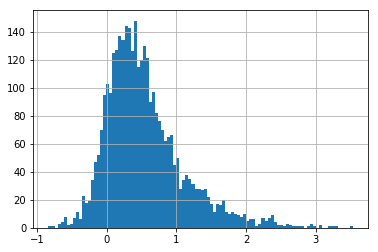

In [459]:
pd.Series([math.log(pmis_per_range[(1978,1988)][p]['score'], math.e) + 7
           for p in pmis_per_range[(1978,1988)]
         if pmis_per_range[(1978,1988)][p]['score']>0]).hist(bins=100)

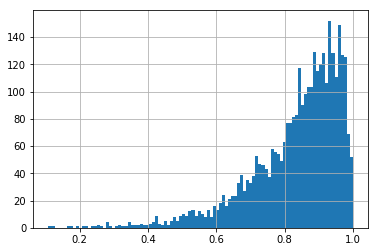

In [460]:
pd.Series([corrs_per_range[(1978,1988)][p]['score']
           for p in corrs_per_range[(1978,1988)]
]).hist(bins=100)

In [461]:
friends_to = {"arms_race": 0, "head_to_head": 0, "tryst": 0}
arms_race_to = {"friendship": 0, "head_to_head": 0, "tryst": 0}
head_to_head_to = {"arms_race": 0, "friendship": 0, "tryst": 0}
tryst_to = {"arms_race": 0, "head_to_head": 0, "friendship": 0}

all_rel_changes = []

score_thresh = 1

timespan = [1978, 2018]
timestep = 10

time_ranges = []

y0 = timespan[0]
for y1 in range(timespan[0]+timestep, timespan[1], timestep):
    time_ranges.append((y0, y1))
    y0 = y1

# skip the first one, it is weird
# time_ranges = time_ranges[1:]

def detect_relation_changes(cutoff=300):
    for t, r in enumerate(time_ranges):
        # changes in friendship
        sorted_friendships = sorted(friendship_per_range[r].items(), key=lambda f: f[1]['score'], reverse=True)
#         sorted_friendships = sorted(friendship_per_range[r].items(), key=lambda f: 
#                                     abs(corrs_per_range[r][f[0]]-corrs_per_range[r2][f[0]]), reverse=True)
        for i, (pair, d) in enumerate(sorted_friendships):
            score1 = friendship_per_range[r][pair]['score']
            for r2 in time_ranges[t:]:
                if pair in friendship_per_range[r2]:
#                     print(pair, "from", r, "consistent in", r2)
                    pass
                elif pair in arms_race_per_range[r2]:
                    score2 = arms_race_per_range[r2][pair]['score']
                    friends_to['arms_race'] += 1
                    all_rel_changes.append({'type1': 'friends', 'rel1': friendship_per_range[r][pair], 'r1':r,
                                            'type2': 'arms race', 'rel2': arms_race_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    print("Friends", pair, friendship_per_range[r][pair]['names'], 
                          score1, "corr", corrs_per_range[r][pair]['score'],
                          "from", r, "is now arms race in", r2, score2, "corr", corrs_per_range[r2][pair]['score'])
                elif pair in head_to_head_per_range[r2]:
                    score2 = head_to_head_per_range[r2][pair]['score']
                    friends_to['head_to_head'] += 1
                    all_rel_changes.append({'type1': 'friends', 'rel1': friendship_per_range[r][pair], 'r1':r,
                                            'type2': 'head to head', 'rel2': head_to_head_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    print("Friends", pair,  friendship_per_range[r][pair]['names'],
                          score1, "corr", corrs_per_range[r][pair]['score'],
                          "from", r, "is now head to head in", r2, score2, "corr", corrs_per_range[r2][pair]['score'])
                elif pair in tryst_per_range[r2]:
                    score2 = tryst_per_range[r2][pair]['score']
                    friends_to['tryst'] += 1
                    all_rel_changes.append({'type1': 'friends', 'rel1': friendship_per_range[r][pair], 'r1':r,
                                            'type2': 'tryst', 'rel2': tryst_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    
                    print("Friends", pair,  friendship_per_range[r][pair]['names'],
                          score1, "corr", corrs_per_range[r][pair]['score'], "mean corr", corr_mean,
                          "pmi", pmis_per_range[r][pair]['score'], "pmi mean", pmi_mean_per_range[r],
                          "from", r, "is now tryst in", r2, score2, "corr", corrs_per_range[r2][pair]['score'],
                         "mean corr", corr_mean,
                          "pmi", pmis_per_range[r2][pair]['score'], "pmi mean, std", pmi_mean,
                          pmi_std,
                         )
                    # Bring beginning of range to closest next even number
#                     plot_for_topics(pair, size=(5,3), all_years=range((r[0]+1)//2*2,r[1],2), smooth_win=1)
#                     plot_for_topics(pair, size=(5,3), all_years=range((r2[0]+1)//2*2,r2[1],2), smooth_win=1)
                    plt.show()
                else:
                    pass
#                     print("Found nowhere")
                if i > cutoff:
                    continue
                
                    
        # changes in arms_race
        for pair in arms_race_per_range[r]:
            score1 = arms_race_per_range[r][pair]['score']
            for r2 in time_ranges[t:]:
                if pair not in arms_race_per_range[r2]:
                    print(pair, "from", r, "no longer arms_race in", r2)
                if pair in friendship_per_range[r2]:
                    score2 = friendship_per_range[r2][pair]['score']
                    arms_race_to['friendship'] += 1
                    all_rel_changes.append({'type1': 'arms race', 'rel1': arms_race_per_range[r][pair], 'r1':r,
                                            'type2': 'friends', 'rel2': friendship_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    print("Arms race", pair, arms_race_per_range[r][pair]['names'], 
                          score1, "corr", corrs_per_range[r][pair]['score'],
                          "from", r, "is now friendship in", r2, score2, "corr", corrs_per_range[r2][pair]['score'])
                elif pair in head_to_head_per_range[r2]:
                    score2 = head_to_head_per_range[r2][pair]['score']
                    arms_race_to['head_to_head'] += 1
                    all_rel_changes.append({'type1': 'arms race', 'rel1': arms_race_per_range[r][pair], 'r1':r,
                                            'type2': 'head to head', 'rel2': head_to_head_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    print("Arms race", pair,  arms_race_per_range[r][pair]['names'],
                          score1, "corr", corrs_per_range[r][pair]['score'],
                          "from", r, "is now head to head in", r2, score2, "corr", corrs_per_range[r2][pair]['score'])
                elif pair in tryst_per_range[r2]:
                    score2 = tryst_per_range[r2][pair]['score']
                    arms_race_to['tryst'] += 1
                    all_rel_changes.append({'type1': 'arms race', 'rel1': arms_race_per_range[r][pair], 'r1':r,
                                            'type2': 'tryst', 'rel2': tryst_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    
                    print("Arms race", pair,  arms_race_per_range[r][pair]['names'],
                          score1, "corr", corrs_per_range[r][pair]['score'], "mean corr", corr_mean,
                          "pmi", pmis_per_range[r][pair]['score'], "pmi mean", pmi_mean_per_range[r],
                          "from", r, "is now tryst in", r2, score2, "corr", corrs_per_range[r2][pair]['score'],
                         "mean corr", corr_mean,
                          "pmi", pmis_per_range[r2][pair]['score'], "pmi mean, std", pmi_mean,
                          pmi_std,
                         )
                    # Bring beginning of range to closest next even number
#                     plot_for_topics(pair, size=(5,3), all_years=range((r[0]+1)//2*2,r[1],2), smooth_win=1)
#                     plot_for_topics(pair, size=(5,3), all_years=range((r2[0]+1)//2*2,r2[1],2), smooth_win=1)
                    plt.show()
                else:
                    pass
#                     print("Found nowhere")
                if i > cutoff:
                    continue
                
        # changes in head to head
        for pair in head_to_head_per_range[r]:
            score1 = head_to_head_per_range[r][pair]['score']

            for r2 in time_ranges[t:]:
                if pair not in head_to_head_per_range[r2]:
                    print(pair, "from", r, "no longer head to head in", r2)
                if pair in arms_race_per_range[r2]:
                    score2 = arms_race_per_range[r2][pair]['score']
                    head_to_head_to['arms_race'] += 1
                    all_rel_changes.append({'type1': 'head to head', 'rel1': head_to_head_per_range[r][pair], 'r1':r,
                                            'type2': 'arms race', 'rel2': arms_race_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    print("Arms race", pair, head_to_head_per_range[r][pair]['names'], 
                          score1, "corr", corrs_per_range[r][pair]['score'],
                          "from", r, "is now friendship in", r2, score2, "corr", corrs_per_range[r2][pair]['score'])
                elif pair in friendship_per_range[r2]:
                    score2 = friendship_per_range[r2][pair]['score']
                    head_to_head_to['friendship'] += 1
                    all_rel_changes.append({'type1': 'head to head', 'rel1': head_to_head_per_range[r][pair], 'r1':r,
                                            'type2': 'friendship', 'rel2': friendship_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    print("Head to head", pair,  head_to_head_per_range[r][pair]['names'],
                          score1, "corr", corrs_per_range[r][pair]['score'],
                          "from", r, "is now friendship in", r2, score2, "corr", corrs_per_range[r2][pair]['score'])
                elif pair in tryst_per_range[r2]:
                    score2 = tryst_per_range[r2][pair]['score']
                    all_rel_changes.append({'type1': 'head to head', 'rel1': head_to_head_per_range[r][pair], 'r1':r,
                                            'type2': 'tryst', 'rel2': tryst_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
                    head_to_head_to['tryst'] += 1
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    
                    print("Head to head", pair,  head_to_head_per_range[r][pair]['names'],
                          score1, "corr", corrs_per_range[r][pair]['score'], "mean corr", corr_mean,
                          "pmi", pmis_per_range[r][pair]['score'], "pmi mean", pmi_mean_per_range[r],
                          "from", r, "is now tryst in", r2, score2, "corr", corrs_per_range[r2][pair]['score'],
                         "mean corr", corr_mean,
                          "pmi", pmis_per_range[r2][pair]['score'], "pmi mean, std", pmi_mean,
                          pmi_std,
                         )
                    # Bring beginning of range to closest next even number
#                     plot_for_topics(pair, size=(5,3), all_years=range((r[0]+1)//2*2,r[1],2), smooth_win=1)
#                     plot_for_topics(pair, size=(5,3), all_years=range((r2[0]+1)//2*2,r2[1],2), smooth_win=1)
#                     plt.show()
                else:
                    pass
#                     print("Found nowhere")
                if i > cutoff:
                    continue
        # changes in tryst
        for pair in tryst_per_range[r]:
            score1 = tryst_per_range[r][pair]['score']
            
            for r2 in time_ranges[t:]:
#                 if pair not in tryst_per_range[r2]:
#                     print(pair, "from", r, "no longer tryst in", r2)
                if pair in friendship_per_range[r2]:
                    score2 = friendship_per_range[r2][pair]['score']
                    tryst_to['friendship'] += 1
                    all_rel_changes.append({'type1': 'tryst', 'rel1': tryst_per_range[r][pair], 'r1':r,
                                            'type2': 'friendship', 'rel2': friendship_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    print("Tryst", pair,  tryst_per_range[r][pair]['names'],
                          score1, "corr", corrs_per_range[r][pair]['score'],
                          "from", r, "is now friendship in", r2, score2, "corr", corrs_per_range[r2][pair]['score'])
                    # Bring beginning of range to closest next even number
#                     plot_for_topics(pair, size=(5,3), all_years=range((r[0]+1)//2*2,r[1],2), smooth_win=1)
#                     plot_for_topics(pair, size=(5,3), all_years=range((r2[0]+1)//2*2,r2[1],2), smooth_win=1)
#                     plt.show()
                elif pair in arms_race_per_range[r2]:
                    score2 = arms_race_per_range[r2][pair]['score']
                    tryst_to['arms_race'] += 1
                    all_rel_changes.append({'type1': 'tryst', 'rel1': tryst_per_range[r][pair], 'r1':r,
                                            'type2': 'arms race', 'rel2': arms_race_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    print("Tryst", pair,  tryst_per_range[r][pair]['names'],
                          score1, "corr", corrs_per_range[r][pair]['score'],
                          "from", r, "is now arms race in", r2, score2, "corr", corrs_per_range[r2][pair]['score'])
                elif pair in head_to_head_per_range[r2]:
                    score2 = head_to_head_per_range[r2][pair]['score']
                    tryst_to['head_to_head'] += 1
                    all_rel_changes.append({'type1': 'tryst', 'rel1': tryst_per_range[r][pair], 'r1':r,
                                            'type2': 'head to head', 'rel2': head_to_head_per_range[r2][pair], 'r2': r2,
                                            'pair': pair})
#                     if score1 < strength_mean_per_range[r] or score2 < strength_mean_per_range[r2]:
#                         continue
                    
                    print("Tryst", pair,  tryst_per_range[r][pair]['names'],
                          score1, "corr", corrs_per_range[r][pair]['score'], "mean corr", corr_mean,
                          "pmi", pmis_per_range[r][pair]['score'], "pmi mean", pmi_mean_per_range[r],
                          "from", r, "is now head to head in", r2, score2, "corr", corrs_per_range[r2][pair]['score'],
                         "mean corr", corr_mean,
                          "pmi", pmis_per_range[r2][pair]['score'], "pmi mean, std", pmi_mean,
                          pmi_std,
                         )
                    # Bring beginning of range to closest next even number
#                     plot_for_topics(pair, size=(5,3), all_years=range((r[0]+1)//2*2,r[1],2), smooth_win=1)
#                     plot_for_topics(pair, size=(5,3), all_years=range((r2[0]+1)//2*2,r2[1],2), smooth_win=1)
#                     plt.show()
                else:
                    pass
#                     print("Found nowhere")
                if i > cutoff:
                    continue
                
        
                
                
detect_relation_changes()
print(friends_to)
print(arms_race_to)
print(head_to_head_to)
print(tryst_to)
            

Friends (7, 39) ['SVMs', 'VECTOR SPACE/SEMANTIC SIMILARITY'] 23.597827003150233 corr 0.500812117976731 from (1978, 1988) is now arms race in (1988, 1998) 0.06965550819500739 corr 0.9536901122814958
Friends (7, 39) ['SVMs', 'VECTOR SPACE/SEMANTIC SIMILARITY'] 23.597827003150233 corr 0.500812117976731 from (1978, 1988) is now arms race in (1998, 2008) 0.05287891500282565 corr 0.901449747499104
Friends (31, 78) ['SUMMARIZATION', 'NEURAL MACHINE TRANSLATION'] 23.082172486650062 corr 0.6718592875216834 from (1978, 1988) is now arms race in (1998, 2008) 0.021519907939830763 corr 0.887757271304658
Friends (55, 78) ['EMBEDDINGS', 'NEURAL MACHINE TRANSLATION'] 22.469389860444476 corr 0.5542209688428104 from (1978, 1988) is now arms race in (1998, 2008) 0.22916166768361407 corr 0.8070660408843937
Friends (12, 78) ['CLUSTERING', 'NEURAL MACHINE TRANSLATION'] 22.42858367946024 corr 0.7355310696322865 from (1978, 1988) is now arms race in (1988, 1998) 2.841492718813574 corr 0.2885864578952649
Frien

Friends (32, 82) ['SPELLING CORRECTION', 'TWITTER/SOCIAL MEDIA'] 5.02195352357867 corr 0.7019775374717947 from (1978, 1988) is now arms race in (1988, 1998) 0.01739134478213413 corr 0.9252342930917304
Friends (32, 82) ['SPELLING CORRECTION', 'TWITTER/SOCIAL MEDIA'] 5.02195352357867 corr 0.7019775374717947 from (1978, 1988) is now arms race in (1998, 2008) 0.3725836619528523 corr 0.7173690716089057
Friends (39, 54) ['VECTOR SPACE/SEMANTIC SIMILARITY', 'RANKING'] 4.9980630121628735 corr 0.6249742734230771 from (1978, 1988) is now arms race in (1998, 2008) 0.20574733173407964 corr 0.9893087967847545
Friends (72, 78) ['PREDICTION', 'NEURAL MACHINE TRANSLATION'] 4.964425761620881 corr 0.9708372893084224 from (1978, 1988) is now arms race in (1988, 1998) 0.8045474912687579 corr 0.7133773757379595
Friends (72, 78) ['PREDICTION', 'NEURAL MACHINE TRANSLATION'] 4.964425761620881 corr 0.9708372893084224 from (1978, 1988) is now arms race in (1998, 2008) 0.1702153538609566 corr 0.8282873383068811


Friends (79, 83) ['RECURRENT NEURAL NETWORKS', 'TRANSLITERATION'] 2.985285564155653 corr 0.6380752067652078 from (1978, 1988) is now arms race in (1988, 1998) 0.36143885026296607 corr 0.761336490536808
Friends (79, 83) ['RECURRENT NEURAL NETWORKS', 'TRANSLITERATION'] 2.985285564155653 corr 0.6380752067652078 from (1978, 1988) is now arms race in (1998, 2008) 0.18230790058997748 corr 0.8342088382500916
Friends (55, 68) ['EMBEDDINGS', 'GRAPHS/ABSTRACT MEANING REPRESENTATION'] 2.9800497653675513 corr 0.6319213564595861 from (1978, 1988) is now arms race in (1998, 2008) 0.16481895628585058 corr 0.9592768534145875
Friends (15, 20) ['NAMED ENTITY RECOGNITION', 'STYLISTICS'] 2.9621118386427185 corr 0.6796451942557619 from (1978, 1988) is now arms race in (1988, 1998) 0.6381789625325425 corr 0.7102848474353071
Friends (15, 20) ['NAMED ENTITY RECOGNITION', 'STYLISTICS'] 2.9621118386427185 corr 0.6796451942557619 from (1978, 1988) is now arms race in (1998, 2008) 0.004213142054717618 corr 0.8798

Friends (31, 55) ['SUMMARIZATION', 'EMBEDDINGS'] 2.0182364802164403 corr 0.8068805326270277 from (1978, 1988) is now arms race in (1988, 1998) 0.04472241091757982 corr 0.9500473865757181
Friends (31, 55) ['SUMMARIZATION', 'EMBEDDINGS'] 2.0182364802164403 corr 0.8068805326270277 from (1978, 1988) is now arms race in (1998, 2008) 0.3084838503104159 corr 0.9819035234899343
Friends (7, 30) ['SVMs', 'SOCIAL MEDIA/WEB DATA'] 2.01759176875346 corr 0.6951682708932982 from (1978, 1988) is now arms race in (1988, 1998) 0.1664152903777783 corr 0.6974582183381659
Friends (7, 30) ['SVMs', 'SOCIAL MEDIA/WEB DATA'] 2.01759176875346 corr 0.6951682708932982 from (1978, 1988) is now arms race in (1998, 2008) 0.6633516848180521 corr 0.701412928722705
Friends (1, 78) ['FINITE STATE MACHINES', 'NEURAL MACHINE TRANSLATION'] 2.015421791639598 corr 0.6555434006311937 from (1978, 1988) is now arms race in (1988, 1998) 0.1503281038636962 corr 0.6419969063903752
Friends (1, 78) ['FINITE STATE MACHINES', 'NEURAL 

Friends (12, 90) ['CLUSTERING', 'COMBINATORY CATEGORICAL GRAMMAR/SUPERTAGGING'] 1.5378150070897605 corr 0.6842201613501251 from (1978, 1988) is now arms race in (1998, 2008) 0.06585209061342498 corr 0.9015723772177207
Friends (24, 86) ['TEXTUAL ENTAILMENT', 'HISTORICAL LINGUISTICS'] 1.5314063413819259 corr 0.6132268849657786 from (1978, 1988) is now arms race in (1988, 1998) 0.04870632965318577 corr 0.8423325497492145
Friends (24, 86) ['TEXTUAL ENTAILMENT', 'HISTORICAL LINGUISTICS'] 1.5314063413819259 corr 0.6132268849657786 from (1978, 1988) is now arms race in (1998, 2008) 0.12269091289942595 corr 0.9222098873874643
Friends (19, 54) ['PHONOLOGY', 'RANKING'] 1.5176610178243581 corr 0.7792910125704519 from (1978, 1988) is now arms race in (1988, 1998) 0.024738951070364137 corr 0.9092605955279084
Friends (19, 54) ['PHONOLOGY', 'RANKING'] 1.5176610178243581 corr 0.7792910125704519 from (1978, 1988) is now arms race in (1998, 2008) 0.08023016866382042 corr 0.9102123793183321
Friends (21, 

Friends (2, 52) ['MORPHOLOGY', 'MULTILINGUALITY'] 1.157594633346239 corr 0.9643647934690613 from (1978, 1988) is now arms race in (1998, 2008) 0.09963580547392215 corr 0.9367955095746088
Friends (82, 92) ['TWITTER/SOCIAL MEDIA', 'CLASSIFICATION'] 1.1522084740484133 corr 0.8385128269786035 from (1978, 1988) is now arms race in (1988, 1998) 0.060861716458471736 corr 0.844478327687767
Friends (82, 92) ['TWITTER/SOCIAL MEDIA', 'CLASSIFICATION'] 1.1522084740484133 corr 0.8385128269786035 from (1978, 1988) is now arms race in (1998, 2008) 0.05285461157381434 corr 0.9002428176538307
Friends (7, 71) ['SVMs', 'ONTOLOGIES'] 1.151953620271826 corr 0.745506634572382 from (1978, 1988) is now arms race in (1988, 1998) 0.5827897625275286 corr 0.6308705485731173
Friends (7, 71) ['SVMs', 'ONTOLOGIES'] 1.151953620271826 corr 0.745506634572382 from (1978, 1988) is now arms race in (1998, 2008) 0.6783713459023103 corr 0.6970642878804322
Friends (23, 35) ['LANGUAGE MODELS (CLASSICAL)', 'SEMANTIC ROLE LABEL

Friends (9, 54) ['ARGUMENT MINING', 'RANKING'] 0.9778285076574911 corr 0.8158575027992289 from (1978, 1988) is now arms race in (1998, 2008) 0.2303730193395274 corr 0.9561247683587216
Friends (23, 70) ['LANGUAGE MODELS (CLASSICAL)', 'NARRATIVES'] 0.9774537583946004 corr 0.9444299544105363 from (1978, 1988) is now arms race in (1988, 1998) 0.578589973426479 corr 0.5432978097964721
Friends (23, 70) ['LANGUAGE MODELS (CLASSICAL)', 'NARRATIVES'] 0.9774537583946004 corr 0.9444299544105363 from (1978, 1988) is now arms race in (1998, 2008) 0.23488300406833224 corr 0.9522667669839819
Friends (81, 92) ['OPINION MINING', 'CLASSIFICATION'] 0.9748887841491323 corr 0.7409064988243997 from (1978, 1988) is now arms race in (1988, 1998) 0.49468933599411147 corr 0.7173601234321105
Friends (81, 92) ['OPINION MINING', 'CLASSIFICATION'] 0.9748887841491323 corr 0.7409064988243997 from (1978, 1988) is now arms race in (1998, 2008) 0.1685789685525495 corr 0.9460404911536927
Friends (86, 91) ['HISTORICAL LIN

Friends (38, 78) ['SYNTACTICAL STRUCTURE', 'NEURAL MACHINE TRANSLATION'] 0.8157386482297985 corr 0.6384759032763858 from (1978, 1988) is now arms race in (1998, 2008) 0.60488528559767 corr 0.7405532495371356
Friends (36, 63) ['DISCOURSE', 'KNOWLEDGE BASE'] 0.8151770689141333 corr 0.8092213531607437 from (1978, 1988) is now arms race in (1998, 2008) 0.3984106057596878 corr 0.7371562988560805
Friends (16, 48) ['DISCOURSE SEGMENTATION', 'SPEECH RECOGNITION'] 0.8135025934947036 corr 0.8218893966664509 from (1978, 1988) is now arms race in (1998, 2008) 0.2052942061267438 corr 0.9886426501200147
Friends (59, 61) ['EVENT EXTRACTION', 'LOGICAL FORMS'] 0.8102018878904685 corr 0.7007756619162728 from (1978, 1988) is now arms race in (1988, 1998) 0.011086357298318635 corr 0.9403139864553275
Friends (59, 61) ['EVENT EXTRACTION', 'LOGICAL FORMS'] 0.8102018878904685 corr 0.7007756619162728 from (1978, 1988) is now arms race in (1998, 2008) 0.04651433688238919 corr 0.8621919730275376
Friends (28, 54)

Friends (39, 48) ['VECTOR SPACE/SEMANTIC SIMILARITY', 'SPEECH RECOGNITION'] 0.6925470767748929 corr 0.7569637986526108 from (1978, 1988) is now arms race in (1998, 2008) 0.20792434927194756 corr 0.939331262857611
Friends (5, 53) ['TREES', 'UNSUPERVISED LEARNING'] 0.6917827327569535 corr 0.6912009051601833 from (1978, 1988) is now arms race in (1988, 1998) 0.005663423562425447 corr 0.7266025555525889
Friends (5, 53) ['TREES', 'UNSUPERVISED LEARNING'] 0.6917827327569535 corr 0.6912009051601833 from (1978, 1988) is now arms race in (1998, 2008) 0.013294909673046465 corr 0.8852449513301803
Friends (30, 89) ['SOCIAL MEDIA/WEB DATA', 'INFORMATION RETRIEVAL'] 0.689463277256998 corr 0.9497061319268268 from (1978, 1988) is now arms race in (1998, 2008) 0.10756705000213383 corr 0.9414649630728363
Friends (25, 54) ['BIOMEDICAL', 'RANKING'] 0.6879579717062737 corr 0.9389024333315822 from (1978, 1988) is now arms race in (1988, 1998) 0.014850840132011298 corr 0.9114521443043417
Friends (25, 54) ['B

Friends (26, 39) ['ANAPHORA/COREFERENCE RESOLUTION', 'VECTOR SPACE/SEMANTIC SIMILARITY'] 0.5785881886806012 corr 0.6981622584796106 from (1978, 1988) is now arms race in (1998, 2008) 0.03929927321110814 corr 0.8676181449648116
Friends (0, 8) ['DOMAIN ADAPTATION', 'LINEAR PROGRAMMING'] 0.5785869386536646 corr 0.9646723829232197 from (1978, 1988) is now arms race in (1988, 1998) 0.024333880506331604 corr 0.9852158516124859
Friends (0, 8) ['DOMAIN ADAPTATION', 'LINEAR PROGRAMMING'] 0.5785869386536646 corr 0.9646723829232197 from (1978, 1988) is now arms race in (1998, 2008) 0.303481642254362 corr 0.9656614678213797
Friends (65, 87) ['INFORMATION EXTRACTION?', 'WORDNET/DISAMBIGUATION'] 0.5769647881400841 corr 0.8255208745311257 from (1978, 1988) is now arms race in (1998, 2008) 0.16922281412200102 corr 0.9734659003260075
Friends (51, 82) ['CONSTITUENT PARSING', 'TWITTER/SOCIAL MEDIA'] 0.5746675439870171 corr 0.5587324414797925 from (1978, 1988) is now arms race in (1988, 1998) 0.1697471137

Friends (94, 99) ['FRAME SEMANTICS', 'SCENE DESCRIPTION'] 0.5130546826745794 corr 0.9748929661590998 from (1978, 1988) is now arms race in (1988, 1998) 0.0019439165104042301 corr 0.980819822267934
Friends (94, 99) ['FRAME SEMANTICS', 'SCENE DESCRIPTION'] 0.5130546826745794 corr 0.9748929661590998 from (1978, 1988) is now arms race in (1998, 2008) 0.15106310006691176 corr 0.9412977326901251
Friends (76, 87) ['CROSS-LINGUAL/PARALLEL CORPORA', 'WORDNET/DISAMBIGUATION'] 0.5129842943814367 corr 0.8588257314020783 from (1978, 1988) is now arms race in (1988, 1998) 0.0976305657514409 corr 0.9785579865470228
Friends (76, 87) ['CROSS-LINGUAL/PARALLEL CORPORA', 'WORDNET/DISAMBIGUATION'] 0.5129842943814367 corr 0.8588257314020783 from (1978, 1988) is now arms race in (1998, 2008) 0.1456871825002265 corr 0.9407729355652191
Friends (26, 35) ['ANAPHORA/COREFERENCE RESOLUTION', 'SEMANTIC ROLE LABELING'] 0.5127396861444227 corr 0.9577732706307948 from (1978, 1988) is now arms race in (1988, 1998) 0.04

Friends (32, 87) ['SPELLING CORRECTION', 'WORDNET/DISAMBIGUATION'] 0.45794895955683174 corr 0.9412776183362388 from (1978, 1988) is now arms race in (1998, 2008) 0.2963408459633051 corr 0.9648876784126421
Friends (46, 81) ['TRANSFER LEARNING', 'OPINION MINING'] 0.4569276509119079 corr 0.9377617450881796 from (1978, 1988) is now arms race in (1988, 1998) 0.14412099921015173 corr 0.9969211866198977
Friends (46, 81) ['TRANSFER LEARNING', 'OPINION MINING'] 0.4569276509119079 corr 0.9377617450881796 from (1978, 1988) is now arms race in (1998, 2008) 0.24362943014942504 corr 0.9575209606324679
Friends (65, 92) ['INFORMATION EXTRACTION?', 'CLASSIFICATION'] 0.4568158240480339 corr 0.8342956674383606 from (1978, 1988) is now arms race in (1988, 1998) 0.023413188019335996 corr 0.9158676084354931
Friends (65, 92) ['INFORMATION EXTRACTION?', 'CLASSIFICATION'] 0.4568158240480339 corr 0.8342956674383606 from (1978, 1988) is now arms race in (1998, 2008) 0.2724637523192266 corr 0.977802324356801
Frie

Friends (4, 50) ['SENTIMENT ANALYSIS', 'LEXICONS'] 0.4038413978217462 corr 0.8049843913848256 from (1978, 1988) is now arms race in (1988, 1998) 0.011707735422665549 corr 0.8762946651236438
Friends (4, 50) ['SENTIMENT ANALYSIS', 'LEXICONS'] 0.4038413978217462 corr 0.8049843913848256 from (1978, 1988) is now arms race in (1998, 2008) 0.17885624897243424 corr 0.8214734790398573
Friends (50, 54) ['LEXICONS', 'RANKING'] 0.4030058183286987 corr 0.675934050833873 from (1978, 1988) is now arms race in (1988, 1998) 0.10334492185501556 corr 0.9266409669818422
Friends (50, 54) ['LEXICONS', 'RANKING'] 0.4030058183286987 corr 0.675934050833873 from (1978, 1988) is now arms race in (1998, 2008) 0.02059491129385716 corr 0.8872215311840262
Friends (85, 91) ['RELATION EXTRACTION', 'ASIAN LANGUAGES'] 0.4028015325310923 corr 0.8147578648187355 from (1978, 1988) is now arms race in (1988, 1998) 0.05112356456280922 corr 0.8386188247736098
Friends (85, 91) ['RELATION EXTRACTION', 'ASIAN LANGUAGES'] 0.40280

Friends (1, 72) ['FINITE STATE MACHINES', 'PREDICTION'] 0.3602594080729628 corr 0.7897447116580565 from (1978, 1988) is now arms race in (1998, 2008) 0.007020411096324611 corr 0.8791161263858935
Friends (9, 32) ['ARGUMENT MINING', 'SPELLING CORRECTION'] 0.360161568984229 corr 0.9558772880399873 from (1978, 1988) is now arms race in (1988, 1998) 0.06792487373677002 corr 0.9345914942537134
Friends (9, 32) ['ARGUMENT MINING', 'SPELLING CORRECTION'] 0.360161568984229 corr 0.9558772880399873 from (1978, 1988) is now arms race in (1998, 2008) 0.290927321221803 corr 0.9788224690532723
Friends (25, 87) ['BIOMEDICAL', 'WORDNET/DISAMBIGUATION'] 0.3598250844138416 corr 0.9822470692158557 from (1978, 1988) is now arms race in (1988, 1998) 0.011274047971864454 corr 0.9375115841293236
Friends (25, 87) ['BIOMEDICAL', 'WORDNET/DISAMBIGUATION'] 0.3598250844138416 corr 0.9822470692158557 from (1978, 1988) is now arms race in (1998, 2008) 0.24123746002183175 corr 0.9669409407113161
Friends (19, 93) ['PHO

Friends (1, 87) ['FINITE STATE MACHINES', 'WORDNET/DISAMBIGUATION'] 0.3211000825796371 corr 0.7619202684891315 from (1978, 1988) is now arms race in (1988, 1998) 0.39286857011819265 corr 0.984370941418611
Friends (1, 87) ['FINITE STATE MACHINES', 'WORDNET/DISAMBIGUATION'] 0.3211000825796371 corr 0.7619202684891315 from (1978, 1988) is now arms race in (1998, 2008) 0.3815707887473214 corr 0.9755227788981344
Friends (43, 66) ['STATISTICAL MACHINE TRANSLATION', 'HUMAN-COMPUTER INTERACTION/APPLICATION'] 0.320881462122037 corr 0.9369665504017533 from (1978, 1988) is now arms race in (1988, 1998) 0.0031269908672411505 corr 0.9850928865391391
Friends (43, 66) ['STATISTICAL MACHINE TRANSLATION', 'HUMAN-COMPUTER INTERACTION/APPLICATION'] 0.320881462122037 corr 0.9369665504017533 from (1978, 1988) is now arms race in (1998, 2008) 0.22873013636790288 corr 0.9569491223417002
Friends (5, 59) ['TREES', 'EVENT EXTRACTION'] 0.31987349356881156 corr 0.6959448419198369 from (1978, 1988) is now arms race

Friends (31, 35) ['SUMMARIZATION', 'SEMANTIC ROLE LABELING'] 0.280005443519561 corr 0.8344407461522707 from (1978, 1988) is now arms race in (1998, 2008) 0.23853549724177878 corr 0.9432853783283943
Friends (19, 87) ['PHONOLOGY', 'WORDNET/DISAMBIGUATION'] 0.2798773075097947 corr 0.8465860891218471 from (1978, 1988) is now arms race in (1988, 1998) 0.12890213234032802 corr 0.9347654800312206
Friends (19, 87) ['PHONOLOGY', 'WORDNET/DISAMBIGUATION'] 0.2798773075097947 corr 0.8465860891218471 from (1978, 1988) is now arms race in (1998, 2008) 0.30220025614050516 corr 0.956554001810215
Friends (4, 43) ['SENTIMENT ANALYSIS', 'STATISTICAL MACHINE TRANSLATION'] 0.27952334309059074 corr 0.7589824444022256 from (1978, 1988) is now arms race in (1988, 1998) 0.08663640700142353 corr 0.8562548784407558
Friends (4, 43) ['SENTIMENT ANALYSIS', 'STATISTICAL MACHINE TRANSLATION'] 0.27952334309059074 corr 0.7589824444022256 from (1978, 1988) is now arms race in (1998, 2008) 0.32307300926380694 corr 0.9640

Friends (2, 60) ['MORPHOLOGY', 'GRAMMARS'] 0.24534062756366104 corr 0.8006721834078815 from (1978, 1988) is now arms race in (1988, 1998) 0.07027199397272402 corr 0.9586770344782017
Friends (2, 60) ['MORPHOLOGY', 'GRAMMARS'] 0.24534062756366104 corr 0.8006721834078815 from (1978, 1988) is now arms race in (1998, 2008) 0.1305581107123873 corr 0.9235584934029202
Friends (26, 67) ['ANAPHORA/COREFERENCE RESOLUTION', 'DISAMBIGUATION'] 0.245233934898833 corr 0.9506915970057874 from (1978, 1988) is now arms race in (1988, 1998) 0.06877461142906684 corr 0.9810285635458061
Friends (26, 67) ['ANAPHORA/COREFERENCE RESOLUTION', 'DISAMBIGUATION'] 0.245233934898833 corr 0.9506915970057874 from (1978, 1988) is now arms race in (1998, 2008) 0.08177031445858755 corr 0.9170829892918515
Friends (11, 50) ['TOPIC MODELS', 'LEXICONS'] 0.2450957314460038 corr 0.8179705919969763 from (1978, 1988) is now arms race in (1988, 1998) 0.07224778684109784 corr 0.9136678874163825
Friends (11, 50) ['TOPIC MODELS', 'LE

Friends (48, 69) ['SPEECH RECOGNITION', 'NEURAL NETWORKS/DEEP LEARNING'] 0.21710281272237666 corr 0.9073279378566962 from (1978, 1988) is now arms race in (1998, 2008) 0.18626500719500252 corr 0.9513714039012848
Friends (0, 48) ['DOMAIN ADAPTATION', 'SPEECH RECOGNITION'] 0.21682731497352165 corr 0.9319670155146886 from (1978, 1988) is now arms race in (1988, 1998) 0.09109220971374475 corr 0.959286238367568
Friends (0, 48) ['DOMAIN ADAPTATION', 'SPEECH RECOGNITION'] 0.21682731497352165 corr 0.9319670155146886 from (1978, 1988) is now arms race in (1998, 2008) 0.22482472932595854 corr 0.9885071370023558
Friends (5, 21) ['TREES', 'POS TAGGING/STATISTICAL PARSING'] 0.2162268172881323 corr 0.9050768055775061 from (1978, 1988) is now arms race in (1988, 1998) 0.03649414164044309 corr 0.7506108712888594
Friends (5, 21) ['TREES', 'POS TAGGING/STATISTICAL PARSING'] 0.2162268172881323 corr 0.9050768055775061 from (1978, 1988) is now arms race in (1998, 2008) 0.250032789965486 corr 0.990657318993

Friends (16, 22) ['DISCOURSE SEGMENTATION', 'UNIFICATION'] 0.18746855534708115 corr 0.9611384191284684 from (1978, 1988) is now arms race in (1988, 1998) 0.06805411097508927 corr 0.8562123550065773
Friends (16, 22) ['DISCOURSE SEGMENTATION', 'UNIFICATION'] 0.18746855534708115 corr 0.9611384191284684 from (1978, 1988) is now arms race in (1998, 2008) 0.05998951803198508 corr 0.8983355703456913
Friends (17, 72) ['EVENTS/TEMPORAL', 'PREDICTION'] 0.18692605235093931 corr 0.8523301641654006 from (1978, 1988) is now arms race in (1988, 1998) 0.04398005159562283 corr 0.9250095450419654
Friends (17, 72) ['EVENTS/TEMPORAL', 'PREDICTION'] 0.18692605235093931 corr 0.8523301641654006 from (1978, 1988) is now arms race in (1998, 2008) 0.08687091932938294 corr 0.9086172573845966
Friends (85, 94) ['RELATION EXTRACTION', 'FRAME SEMANTICS'] 0.1868362244388652 corr 0.9221861158150416 from (1978, 1988) is now arms race in (1988, 1998) 0.017684283890167986 corr 0.8989226271663568
Friends (85, 94) ['RELATI

Friends (2, 35) ['MORPHOLOGY', 'SEMANTIC ROLE LABELING'] 0.16148067731322102 corr 0.9874875741475626 from (1978, 1988) is now arms race in (1998, 2008) 0.23746840820602605 corr 0.9479535350195303
Friends (38, 73) ['SYNTACTICAL STRUCTURE', 'QUANTITATIVE ANALYSIS/TEXT MINING'] 0.1613704130906021 corr 0.9441344188648032 from (1978, 1988) is now arms race in (1988, 1998) 0.09489503473899703 corr 0.7984629739951667
Friends (38, 73) ['SYNTACTICAL STRUCTURE', 'QUANTITATIVE ANALYSIS/TEXT MINING'] 0.1613704130906021 corr 0.9441344188648032 from (1978, 1988) is now arms race in (1998, 2008) 0.28364801951796903 corr 0.9738044116211095
Friends (9, 94) ['ARGUMENT MINING', 'FRAME SEMANTICS'] 0.16128667436514443 corr 0.8535331050524398 from (1978, 1988) is now arms race in (1998, 2008) 0.12963142140597878 corr 0.9148094618998617
Friends (25, 85) ['BIOMEDICAL', 'RELATION EXTRACTION'] 0.16087438687541775 corr 0.8481855942737042 from (1978, 1988) is now arms race in (1988, 1998) 0.1455022532258244 corr 

Friends (14, 54) ['GENERATION', 'RANKING'] 0.13799727957560953 corr 0.9024260822227244 from (1978, 1988) is now arms race in (1998, 2008) 0.050057259902422525 corr 0.865516471651028
Friends (17, 57) ['EVENTS/TEMPORAL', 'QUESTION ANSWERING'] 0.1374876310979155 corr 0.9280582649310174 from (1978, 1988) is now arms race in (1988, 1998) 0.09357582695476263 corr 0.9458508757692994
Friends (17, 57) ['EVENTS/TEMPORAL', 'QUESTION ANSWERING'] 0.1374876310979155 corr 0.9280582649310174 from (1978, 1988) is now arms race in (1998, 2008) 0.09936153263954156 corr 0.8408325963232358
Friends (16, 51) ['DISCOURSE SEGMENTATION', 'CONSTITUENT PARSING'] 0.13651464645964018 corr 0.9481257906649133 from (1978, 1988) is now arms race in (1988, 1998) 0.03917181550771747 corr 0.8583504913268618
Friends (16, 51) ['DISCOURSE SEGMENTATION', 'CONSTITUENT PARSING'] 0.13651464645964018 corr 0.9481257906649133 from (1978, 1988) is now arms race in (1998, 2008) 0.3720177341534608 corr 0.9907277906073187
Friends (35, 

Friends (16, 60) ['DISCOURSE SEGMENTATION', 'GRAMMARS'] 0.1186685631330258 corr 0.9303898768929362 from (1978, 1988) is now arms race in (1998, 2008) 0.29709602941681024 corr 0.9646930615552767
Friends (36, 70) ['DISCOURSE', 'NARRATIVES'] 0.11836540533016973 corr 0.8959940724373288 from (1978, 1988) is now arms race in (1988, 1998) 0.04296102676733248 corr 0.9396373605080639
Friends (36, 70) ['DISCOURSE', 'NARRATIVES'] 0.11836540533016973 corr 0.8959940724373288 from (1978, 1988) is now arms race in (1998, 2008) 0.061601680393956464 corr 0.9061562771545397
Friends (1, 35) ['FINITE STATE MACHINES', 'SEMANTIC ROLE LABELING'] 0.11826092598959624 corr 0.9667028592074528 from (1978, 1988) is now arms race in (1988, 1998) 0.001022298040459469 corr 0.8815965505114672
Friends (1, 35) ['FINITE STATE MACHINES', 'SEMANTIC ROLE LABELING'] 0.11826092598959624 corr 0.9667028592074528 from (1978, 1988) is now arms race in (1998, 2008) 0.3311268011748567 corr 0.9744307749831549
Friends (69, 72) ['NEUR

Friends (22, 65) ['UNIFICATION', 'INFORMATION EXTRACTION?'] 0.1004738443133812 corr 0.9231879342322983 from (1978, 1988) is now arms race in (1988, 1998) 0.015581421908445928 corr 0.8880924621564613
Friends (22, 65) ['UNIFICATION', 'INFORMATION EXTRACTION?'] 0.1004738443133812 corr 0.9231879342322983 from (1978, 1988) is now arms race in (1998, 2008) 0.37235235483343043 corr 0.7742792876897376
Friends (1, 91) ['FINITE STATE MACHINES', 'ASIAN LANGUAGES'] 0.10036362059578365 corr 0.8597111530245998 from (1978, 1988) is now arms race in (1988, 1998) 0.13551233381568256 corr 0.9630971464790399
Friends (1, 91) ['FINITE STATE MACHINES', 'ASIAN LANGUAGES'] 0.10036362059578365 corr 0.8597111530245998 from (1978, 1988) is now arms race in (1998, 2008) 0.23883256315329285 corr 0.9648898808370723
Friends (63, 70) ['KNOWLEDGE BASE', 'NARRATIVES'] 0.10017392510278368 corr 0.8644103767548185 from (1978, 1988) is now arms race in (1988, 1998) 0.04575813927721286 corr 0.9251634341866272
Friends (63, 7

Friends (19, 94) ['PHONOLOGY', 'FRAME SEMANTICS'] 0.07957230835229821 corr 0.9325309874569544 from (1978, 1988) is now arms race in (1988, 1998) 0.08149742351777771 corr 0.9158538359156525
Friends (19, 94) ['PHONOLOGY', 'FRAME SEMANTICS'] 0.07957230835229821 corr 0.9325309874569544 from (1978, 1988) is now arms race in (1998, 2008) 0.1803588742342715 corr 0.9245259585294311
Friends (8, 81) ['LINEAR PROGRAMMING', 'OPINION MINING'] 0.07950851756760205 corr 0.9455088987244631 from (1978, 1988) is now arms race in (1988, 1998) 0.17187093252933275 corr 0.962504319984484
Friends (8, 81) ['LINEAR PROGRAMMING', 'OPINION MINING'] 0.07950851756760205 corr 0.9455088987244631 from (1978, 1988) is now arms race in (1998, 2008) 0.009961808324221595 corr 0.8840685940034352
Friends (56, 59) ['PLAN-BASED DIALOGUE', 'EVENT EXTRACTION'] 0.07944393629380353 corr 0.868462083827092 from (1978, 1988) is now arms race in (1988, 1998) 0.04513064819031902 corr 0.940426435075183
Friends (56, 59) ['PLAN-BASED DIA

Friends (32, 40) ['SPELLING CORRECTION', 'MACHINE LEARNING'] 0.05789698367772047 corr 0.8963406479968681 from (1978, 1988) is now arms race in (1988, 1998) 0.024213742090104996 corr 0.9763663550027981
Friends (32, 40) ['SPELLING CORRECTION', 'MACHINE LEARNING'] 0.05789698367772047 corr 0.8963406479968681 from (1978, 1988) is now arms race in (1998, 2008) 0.019128781055616852 corr 0.8877759449517378
Friends (0, 68) ['DOMAIN ADAPTATION', 'GRAPHS/ABSTRACT MEANING REPRESENTATION'] 0.057867221091642315 corr 0.9206015122142127 from (1978, 1988) is now arms race in (1988, 1998) 0.26822147756668613 corr 0.9883752794800258
Friends (0, 68) ['DOMAIN ADAPTATION', 'GRAPHS/ABSTRACT MEANING REPRESENTATION'] 0.057867221091642315 corr 0.9206015122142127 from (1978, 1988) is now arms race in (1998, 2008) 0.3552049074025482 corr 0.9810520952488457
Friends (87, 99) ['WORDNET/DISAMBIGUATION', 'SCENE DESCRIPTION'] 0.05770850250816101 corr 0.892796064376195 from (1978, 1988) is now arms race in (1988, 1998) 

Friends (8, 73) ['LINEAR PROGRAMMING', 'QUANTITATIVE ANALYSIS/TEXT MINING'] 0.038473000763601 corr 0.9041869364756329 from (1978, 1988) is now arms race in (1988, 1998) 0.07090427425637584 corr 0.8430246376883959
Friends (8, 73) ['LINEAR PROGRAMMING', 'QUANTITATIVE ANALYSIS/TEXT MINING'] 0.038473000763601 corr 0.9041869364756329 from (1978, 1988) is now arms race in (1998, 2008) 0.31831417962427255 corr 0.9726500545808865
Friends (69, 81) ['NEURAL NETWORKS/DEEP LEARNING', 'OPINION MINING'] 0.03821329984146352 corr 0.887941547355545 from (1978, 1988) is now arms race in (1988, 1998) 0.04136267950445731 corr 0.9209759464394304
Friends (69, 81) ['NEURAL NETWORKS/DEEP LEARNING', 'OPINION MINING'] 0.03821329984146352 corr 0.887941547355545 from (1978, 1988) is now arms race in (1998, 2008) 0.24702948891447438 corr 0.80996380596492
Friends (11, 93) ['TOPIC MODELS', 'SEQUENCE ANALYSIS'] 0.03812914941636795 corr 0.8923837775499508 from (1978, 1988) is now arms race in (1988, 1998) 0.1085853023

Friends (1, 9) ['FINITE STATE MACHINES', 'ARGUMENT MINING'] 0.012983961749951024 corr 0.8884592799041793 from (1978, 1988) is now arms race in (1988, 1998) 0.2022331515913046 corr 0.9537393266984657
Friends (1, 9) ['FINITE STATE MACHINES', 'ARGUMENT MINING'] 0.012983961749951024 corr 0.8884592799041793 from (1978, 1988) is now arms race in (1998, 2008) 0.23382833013855772 corr 0.9376878799004404
Friends (86, 99) ['HISTORICAL LINGUISTICS', 'SCENE DESCRIPTION'] 0.01264380112520589 corr 0.8773675669634258 from (1978, 1988) is now arms race in (1988, 1998) 0.006870849715135718 corr 0.8975468964625208
Friends (86, 99) ['HISTORICAL LINGUISTICS', 'SCENE DESCRIPTION'] 0.01264380112520589 corr 0.8773675669634258 from (1978, 1988) is now arms race in (1998, 2008) 0.19071860037358224 corr 0.9390875546074444
Friends (38, 55) ['SYNTACTICAL STRUCTURE', 'EMBEDDINGS'] 0.012330002603136863 corr 0.88912141481256 from (1978, 1988) is now arms race in (1988, 1998) 0.0011607705338323598 corr 0.880403866848

Friends (20, 34) ['STYLISTICS', 'EVALUATION/ANNOTATION'] 0.3143507346752787 corr 0.7597807414543544 from (1988, 1998) is now arms race in (1998, 2008) 0.11874815289970107 corr 0.9336963831828957
Friends (84, 87) ['DICTIONARIES', 'WORDNET/DISAMBIGUATION'] 0.30520274133719216 corr 0.971970794847495 from (1988, 1998) is now arms race in (1998, 2008) 0.08058900326524827 corr 0.9434967607408847
Friends (39, 69) ['VECTOR SPACE/SEMANTIC SIMILARITY', 'NEURAL NETWORKS/DEEP LEARNING'] 0.3045717756242341 corr 0.7796318762542992 from (1988, 1998) is now arms race in (1998, 2008) 0.049556691054421995 corr 0.9019354003645543
Friends (76, 84) ['CROSS-LINGUAL/PARALLEL CORPORA', 'DICTIONARIES'] 0.30395192478383276 corr 0.995175727964328 from (1988, 1998) is now arms race in (1998, 2008) 0.09163867181662734 corr 0.8113692889979186
Friends (21, 23) ['POS TAGGING/STATISTICAL PARSING', 'LANGUAGE MODELS (CLASSICAL)'] 0.3038195385820516 corr 0.957202889889481 from (1988, 1998) is now arms race in (1998, 2008

Friends (53, 82) ['UNSUPERVISED LEARNING', 'TWITTER/SOCIAL MEDIA'] 0.06099690571746278 corr 0.9102411929041049 from (1988, 1998) is now arms race in (1998, 2008) 0.17091819781937645 corr 0.831691912306168
Friends (1, 83) ['FINITE STATE MACHINES', 'TRANSLITERATION'] 0.0607270479969748 corr 0.9193333348762579 from (1988, 1998) is now arms race in (1998, 2008) 0.06177002250987497 corr 0.9107551643566725
Friends (40, 72) ['MACHINE LEARNING', 'PREDICTION'] 0.060311298438634815 corr 0.8973202353778371 from (1988, 1998) is now arms race in (1998, 2008) 0.2036753045334361 corr 0.9735843305491109
Friends (12, 87) ['CLUSTERING', 'WORDNET/DISAMBIGUATION'] 0.059826030878330924 corr 0.9107515543762347 from (1988, 1998) is now arms race in (1998, 2008) 0.12060925140849045 corr 0.9436516602447887
Friends (76, 89) ['CROSS-LINGUAL/PARALLEL CORPORA', 'INFORMATION RETRIEVAL'] 0.058671781483002276 corr 0.9208430416602024 from (1988, 1998) is now arms race in (1998, 2008) 0.22449091067533253 corr 0.9759426

In [453]:
range_probs = {}
for r in time_ranges:
    range_probs[r] = {}
    for topic in range(100):
        range_probs[r][topic] = sum(_probs_for_topic(topic, df, range(*r)))

In [454]:
range_probs

{(1978, 1988): {0: 0.6511990456027154,
  1: 1.3161703128675606,
  2: 0.6849010316900226,
  3: 0.5837379440131734,
  4: 0.1381288436334308,
  5: 1.2470104513223779,
  6: 0.8703000974560609,
  7: 0.21077763215377895,
  8: 1.1907551164431898,
  9: 0.44266491917868067,
  10: 0.0,
  11: 0.33904157005074437,
  12: 0.17250764525993884,
  13: 0.5559501965923984,
  14: 1.2768188997546794,
  15: 0.254457438585879,
  16: 0.33671337836475457,
  17: 0.6650986322545956,
  18: 0.0,
  19: 0.5974826091339853,
  20: 0.5967392546291629,
  21: 0.26092952918640994,
  22: 1.4402349027119667,
  23: 0.09454212454212454,
  24: 0.6983082972073799,
  25: 0.47795644722250225,
  26: 0.6072003226131667,
  27: 0.0,
  28: 0.35258863460698325,
  29: 0.5467500084013845,
  30: 1.2171042107739356,
  31: 0.1647871089155493,
  32: 0.749088953859596,
  33: 0.0,
  34: 0.5086157878818429,
  35: 0.8148415498874214,
  36: 0.8732496555432334,
  37: 0.0,
  38: 3.2574560607588126,
  39: 0.19791746479819874,
  40: 0.297722888732063

In [419]:
friends_to_tryst = [c for c in all_rel_changes if c['type1']=='friends' and c['type2'] =='tryst'
                   if range_probs[c['r1']][c['pair'][0]]>0.0
                   and range_probs[c['r2']][c['pair'][1]]>0.0]
# ^^ excluding pairs where one of the topics is rare in the time range
sorted_friends_to_tryst = sorted(friends_to_tryst, key = lambda c: abs(corrs_per_range[c['r1']][c['pair']]['score']
       -corrs_per_range[c['r2']][c['pair']]['score']), reverse=True)
plot_for_topics(sorted_friends_to_tryst[0]['pair'], range(*sorted_friends_to_tryst[0]['r1']))
plot_for_topics(sorted_friends_to_tryst[0]['pair'], range(*sorted_friends_to_tryst[0]['r2']))

plot_for_topics(sorted_friends_to_tryst[1]['pair'], range(*sorted_friends_to_tryst[0]['r1']))
plot_for_topics(sorted_friends_to_tryst[1]['pair'], range(*sorted_friends_to_tryst[0]['r2']))

plot_for_topics(sorted_friends_to_tryst[2]['pair'], range(*sorted_friends_to_tryst[0]['r1']))
plot_for_topics(sorted_friends_to_tryst[2]['pair'], range(*sorted_friends_to_tryst[0]['r2']))

plot_for_topics(sorted_friends_to_tryst[3]['pair'], range(*sorted_friends_to_tryst[0]['r1']))
plot_for_topics(sorted_friends_to_tryst[3]['pair'], range(*sorted_friends_to_tryst[0]['r2']))

IndexError: list index out of range

In [420]:
tryst_to_friends = [c for c in all_rel_changes if c['type1']=='tryst' and c['type2'] =='friendship'
                   if range_probs[c['r1']][c['pair'][0]]>0.0
                   and range_probs[c['r2']][c['pair'][1]]>0.0]
# ^^ excluding pairs where one of the topics is rare in the time range
sorted_tryst_to_friends = sorted(tryst_to_friends, key = lambda c: abs(corrs_per_range[c['r1']][c['pair']]['score']
       -corrs_per_range[c['r2']][c['pair']]['score']), reverse=True)

plot_for_topics(sorted_tryst_to_friends[0]['pair'], range(*sorted_tryst_to_friends[0]['r1']))
plot_for_topics(sorted_tryst_to_friends[0]['pair'], range(*sorted_tryst_to_friends[0]['r2']))

plot_for_topics(sorted_tryst_to_friends[1]['pair'], range(*sorted_tryst_to_friends[0]['r1']))
plot_for_topics(sorted_tryst_to_friends[1]['pair'], range(*sorted_tryst_to_friends[0]['r2']))

plot_for_topics(sorted_tryst_to_friends[2]['pair'], range(*sorted_tryst_to_friends[0]['r1']))
plot_for_topics(sorted_tryst_to_friends[2]['pair'], range(*sorted_tryst_to_friends[0]['r2']))

plot_for_topics(sorted_tryst_to_friends[3]['pair'], range(*sorted_tryst_to_friends[0]['r1']))
plot_for_topics(sorted_tryst_to_friends[3]['pair'], range(*sorted_tryst_to_friends[0]['r2']))

IndexError: list index out of range

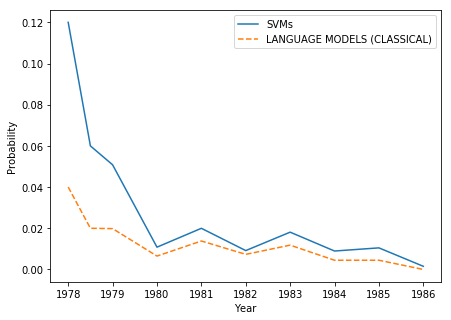

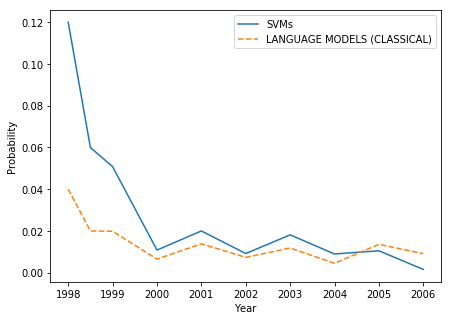

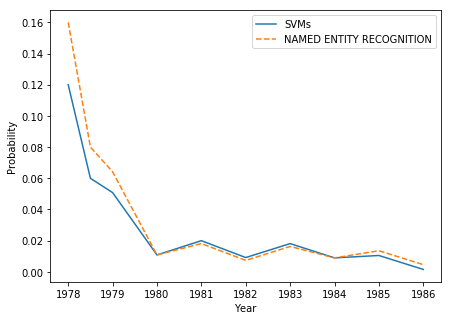

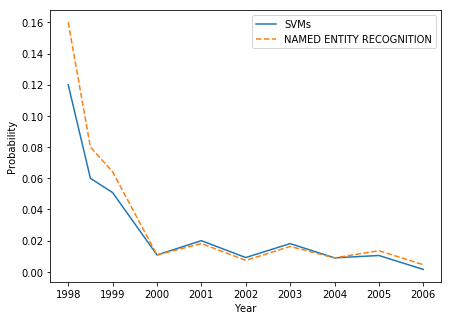

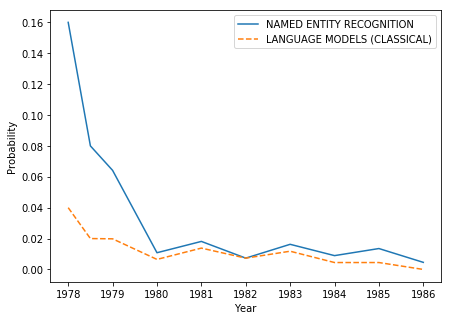

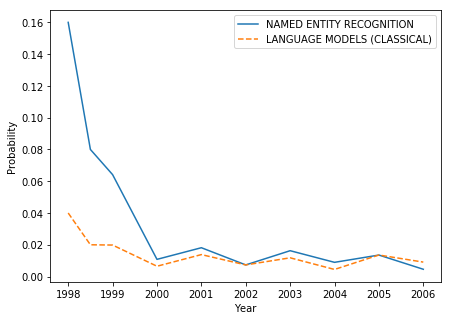

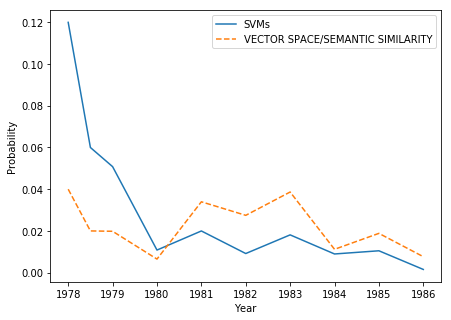

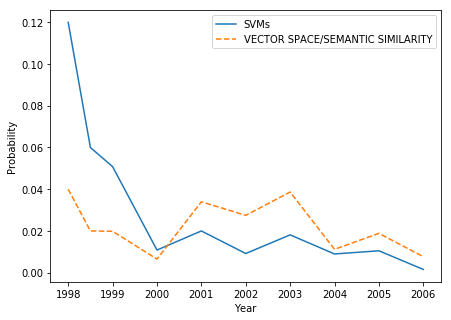

In [462]:
friends_to_arms_race = [c for c in all_rel_changes if c['type1']=='friends' and c['type2'] =='arms race'
                   if range_probs[c['r1']][c['pair'][0]]>0.2
                   and range_probs[c['r2']][c['pair'][1]]>0.2]
# ^^ excluding pairs where one of the topics is rare in the time range
sorted_friends_to_arms_race = sorted(friends_to_arms_race, key = lambda c: abs(pmis_per_range[c['r1']][c['pair']]['score']
       -pmis_per_range[c['r2']][c['pair']]['score']), reverse=True)

plot_for_topics(sorted_friends_to_arms_race[0]['pair'], range(*sorted_friends_to_arms_race[0]['r1']))
plot_for_topics(sorted_friends_to_arms_race[0]['pair'], range(*sorted_friends_to_arms_race[0]['r2']))

plot_for_topics(sorted_friends_to_arms_race[1]['pair'], range(*sorted_friends_to_arms_race[0]['r1']))
plot_for_topics(sorted_friends_to_arms_race[1]['pair'], range(*sorted_friends_to_arms_race[0]['r2']))

plot_for_topics(sorted_friends_to_arms_race[2]['pair'], range(*sorted_friends_to_arms_race[0]['r1']))
plot_for_topics(sorted_friends_to_arms_race[2]['pair'], range(*sorted_friends_to_arms_race[0]['r2']))

plot_for_topics(sorted_friends_to_arms_race[3]['pair'], range(*sorted_friends_to_arms_race[0]['r1']))
plot_for_topics(sorted_friends_to_arms_race[3]['pair'], range(*sorted_friends_to_arms_race[0]['r2']))

In [424]:
friends_to_head_to_head = [c for c in all_rel_changes if c['type1']=='friends' and c['type2'] =='head to head'
                   if range_probs[c['r1']][c['pair'][0]]>0.0
                   and range_probs[c['r2']][c['pair'][1]]>0.0]
# ^^ excluding pairs where one of the topics is rare in the time range
sorted_friends_to_head_to_head = sorted(friends_to_head_to_head, key = lambda c: abs(corrs_per_range[c['r1']][c['pair']]['score']
       -corrs_per_range[c['r2']][c['pair']]['score']), reverse=True)

plot_for_topics(sorted_friends_to_head_to_head[0]['pair'], range(*sorted_friends_to_head_to_head[0]['r1']))
plot_for_topics(sorted_friends_to_head_to_head[0]['pair'], range(*sorted_friends_to_head_to_head[0]['r2']))

plot_for_topics(sorted_friends_to_head_to_head[1]['pair'], range(*sorted_friends_to_head_to_head[0]['r1']))
plot_for_topics(sorted_friends_to_head_to_head[1]['pair'], range(*sorted_friends_to_head_to_head[0]['r2']))

plot_for_topics(sorted_friends_to_head_to_head[2]['pair'], range(*sorted_friends_to_head_to_head[0]['r1']))
plot_for_topics(sorted_friends_to_head_to_head[2]['pair'], range(*sorted_friends_to_head_to_head[0]['r2']))

plot_for_topics(sorted_friends_to_head_to_head[3]['pair'], range(*sorted_friends_to_head_to_head[0]['r1']))
plot_for_topics(sorted_friends_to_head_to_head[3]['pair'], range(*sorted_friends_to_head_to_head[0]['r2']))

IndexError: list index out of range

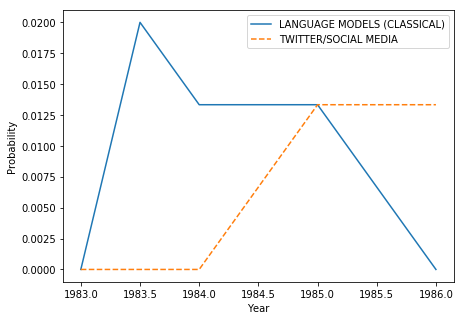

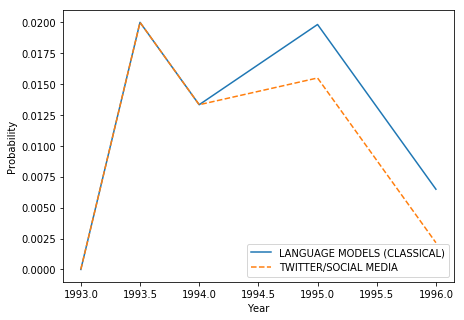

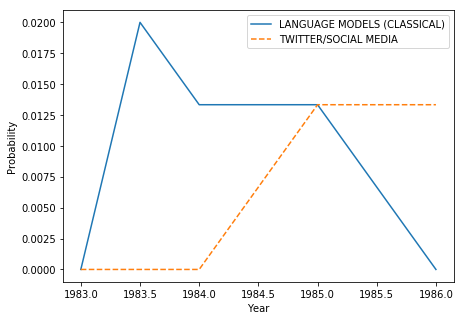

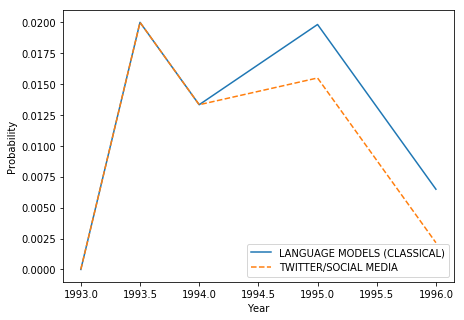

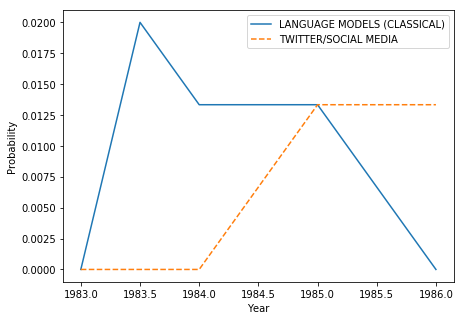

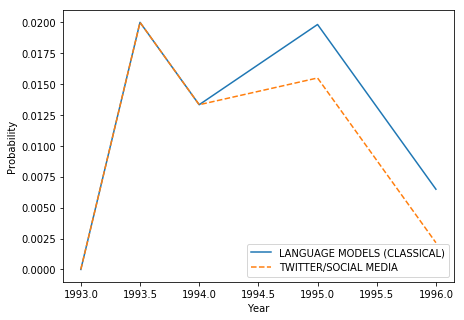

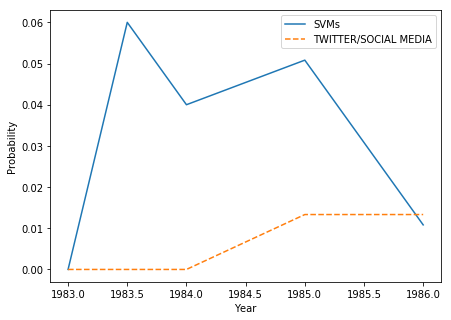

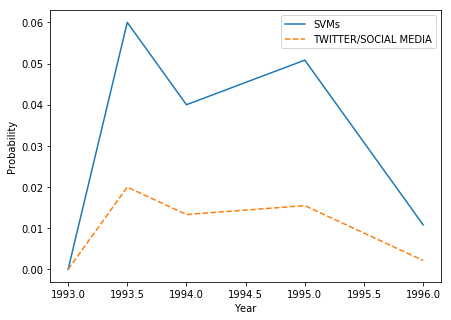

In [428]:
head_to_head_to_arms_race = [c for c in all_rel_changes if c['type1']=='head to head' and c['type2'] =='arms race'
                   if range_probs[c['r1']][c['pair'][0]]>0.0
                   and range_probs[c['r2']][c['pair'][1]]>0.0]
# ^^ excluding pairs where one of the topics is rare in the time range
sorted_head_to_head_to_arms_race = sorted(head_to_head_to_arms_race, key = lambda c: abs(corrs_per_range[c['r1']][c['pair']]['score']
       -corrs_per_range[c['r2']][c['pair']]['score']), reverse=True)

plot_for_topics(sorted_head_to_head_to_arms_race[0]['pair'], range(*sorted_head_to_head_to_arms_race[0]['r1']))
plot_for_topics(sorted_head_to_head_to_arms_race[0]['pair'], range(*sorted_head_to_head_to_arms_race[0]['r2']))

plot_for_topics(sorted_head_to_head_to_arms_race[1]['pair'], range(*sorted_head_to_head_to_arms_race[0]['r1']))
plot_for_topics(sorted_head_to_head_to_arms_race[1]['pair'], range(*sorted_head_to_head_to_arms_race[0]['r2']))

plot_for_topics(sorted_head_to_head_to_arms_race[2]['pair'], range(*sorted_head_to_head_to_arms_race[0]['r1']))
plot_for_topics(sorted_head_to_head_to_arms_race[2]['pair'], range(*sorted_head_to_head_to_arms_race[0]['r2']))

plot_for_topics(sorted_head_to_head_to_arms_race[3]['pair'], range(*sorted_head_to_head_to_arms_race[0]['r1']))
plot_for_topics(sorted_head_to_head_to_arms_race[3]['pair'], range(*sorted_head_to_head_to_arms_race[0]['r2']))

In [456]:
[c for c in all_rel_changes]

[{'pair': (7, 39),
  'r1': (1978, 1988),
  'r2': (1988, 1998),
  'rel1': {'names': ['SVMs', 'VECTOR SPACE/SEMANTIC SIMILARITY'],
   'score': 23.597827003150233},
  'rel2': {'names': ['SVMs', 'VECTOR SPACE/SEMANTIC SIMILARITY'],
   'score': 0.06965550819500739},
  'type1': 'friends',
  'type2': 'arms race'},
 {'pair': (7, 39),
  'r1': (1978, 1988),
  'r2': (1998, 2008),
  'rel1': {'names': ['SVMs', 'VECTOR SPACE/SEMANTIC SIMILARITY'],
   'score': 23.597827003150233},
  'rel2': {'names': ['SVMs', 'VECTOR SPACE/SEMANTIC SIMILARITY'],
   'score': 0.05287891500282565},
  'type1': 'friends',
  'type2': 'arms race'},
 {'pair': (31, 78),
  'r1': (1978, 1988),
  'r2': (1988, 1998),
  'rel1': {'names': ['SUMMARIZATION', 'NEURAL MACHINE TRANSLATION'],
   'score': 23.082172486650062},
  'rel2': {'names': ['SUMMARIZATION', 'NEURAL MACHINE TRANSLATION'],
   'score': 4.752655529375269},
  'type1': 'friends',
  'type2': 'arms race'},
 {'pair': (31, 78),
  'r1': (1978, 1988),
  'r2': (1998, 2008),
  'r

In [343]:
sum(_probs_for_topic(20, df, range(1978,1983)))

0.4704395604395604

## Conference divergence

In [555]:
texts_topics_df_uniq = texts_topics_df_all.drop_duplicates(['Dominant_Topic', 'Document'])

def documents_per_year_for_confs(df, conferences):
    return df[df['Conference'].isin(conferences)].groupby([
        'Title'], as_index=False).first().groupby('Year').count()[['Document']].to_dict()['Document']
        

def _topic_distribution(df, conferences, year, documents_per_year=None, shift=None, topics=None):
    # count documents per year
    if not documents_per_year:
        documents_per_year = documents_per_year_for_confs(df, conferences)
    freq = documents_per_year.get(year,0)
    if topics:
        df = df[df['Dominant_Topic'].isin(topics)]
    topics_for_conf = df[df['Conference'].isin(conferences)][
        df['Year']==year].groupby('Dominant_Topic').count()
    topics_for_conf['Probability'] = topics_for_conf['Document']/freq
    topics_for_conf = topics_for_conf.reindex(range(0,100), fill_value=0)
    if shift:
        topics_for_conf = topics_for_conf.shift(shift, fill_value=topics_for_conf.Probability.values[0])
#     [topics_for_conf['Year']==2006]['Probability'])
#     topics_for_conf = topics_for_conf[topics_for_conf['Year']==year].groupby(['Dominant_Topic'], as_index=False).sum()
    return topics_for_conf.Probability.values
    
from scipy.spatial.distance import jensenshannon

def conf_divergences(df, confs1=['ACL', 'COLING', 'NAACL', 'EMNLP'], confs2=['NIPS'], years=range(1992,2018,2),
                    shift=None, topics=None):
    documents_per_year1 = documents_per_year_for_confs(df, confs1)
    documents_per_year2 = documents_per_year_for_confs(df, confs2)
    divergences = []
    common_years = [1984, 1998, 2006]
    for year in years:
        probs1 = _topic_distribution(df, confs1, year, documents_per_year1, shift, topics)
        probs2 = _topic_distribution(df, confs2, year, documents_per_year2, topics=topics)
        if year in common_years:
            if confs1 == ['COLING']:
                probs1 = _topic_distribution(df, ['ACL', 'COLING'], year, shift, topics)
            if confs2 == ['COLING']:
                probs2 = _topic_distribution(df, ['ACL', 'COLING'], year, topics=topics)
            
        # hack
        div = jensenshannon(probs1, probs2)
        print(year, div)
        if not np.isnan(div):
            divergences.append(div)
    return divergences

In [556]:
documents_per_year_for_confs(texts_topics_df_uniq, ['ACL'])


{1978: 25,
 1980: 70,
 1982: 63,
 1984: 149,
 1986: 75,
 1988: 69,
 1990: 95,
 1992: 102,
 1994: 109,
 1996: 131,
 1998: 334,
 2000: 106,
 2002: 160,
 2004: 263,
 2006: 508,
 2008: 461,
 2010: 606,
 2012: 618,
 2014: 683,
 2016: 1156}

In [547]:
from matplotlib.ticker import MaxNLocator

def plot_divergences(df, confsl1, confsl2, years, ylabel, conf1label=None):
    styles = ['-', '--', '-.', ':']
    cnt = 0
    ax = plt.figure().gca()
    if not confsl2:
        same2 = True
    else:
        same2 = False
    for i, confs1 in enumerate(confsl1):
        if same2:
            confsl2 = confsl1[i+1:]
        for confs2 in confsl2:
            divergences = conf_divergences(df, confs1, confs2, years)
            print(confs1, divergences)
            df_plt = pd.DataFrame({'years': years, 'divergences': divergences}).rolling(3).mean()
            if not conf1label:
                conf1label = " ".join(confs1)
            plt.plot([int(y) for y in years], df_plt['divergences'], styles[cnt%len(styles)],
                     label="-".join([conf1label, ",".join(confs2)]))
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            cnt += 1
    plt.legend()
    plt.ylabel(ylabel)

/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


['EMNLP'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.35663660960285004, 0.32311739837682013, 0.32782582170281693, 0.3115593557890111, 0.30608707547472197, 0.2904413184546221]
['ACL'] [nan, nan, nan, 0.3537890241893995, 0.3631866843413437, 0.3817831762862576, 0.35417775920069383, 0.35063108819188593, 0.332756111138863, 0.34271239979367174, 0.3239135111491675, 0.3319800492323698, 0.33257968512537595, 0.32295645643833654, 0.30036326540782254]
['NAACL'] [nan, nan, nan, nan, nan, nan, 0.3496713192353379, 0.35030108739530036, 0.3419045669313215, 0.3235820250534215, 0.3133803238170867, 0.3412882516294452, 0.3331047825913203, 0.3297620067623778, 0.30538717828001294]
['COLING'] [nan, nan, nan, 0.3985918082154249, 0.3977847987655844, 0.3840127072962605, 0.38448452131467387, 0.3773380178197446, 0.3643404768003906, nan, 0.3515656295289884, 0.36112021774252784, 0.3649197007755825, 0.35566490433837267, 0.33056879341491624]


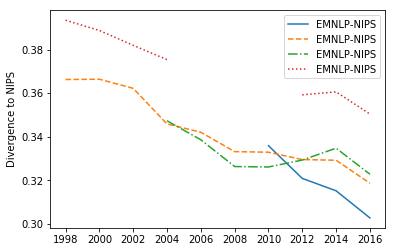

In [548]:
plot_divergences(df=texts_topics_df_uniq, confsl1=[['EMNLP'], ['ACL'], ['NAACL'], ['COLING']], 
                 confsl2=[['NIPS']], years=range(1988, 2018, 2),
                ylabel='Divergence to NIPS')

/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


['ACL', 'EMNLP', 'COLING', 'NAACL'] [nan, 0.09745628901176469, 0.05331759641844245, 0.05331759641844245, 0.04558895015680858, 0.04525903946105737, 0.04677971835952733, 0.050551505911446255, 0.058670593862023314, 0.05248731400602618, 0.05248731400602618, 0.0843632893599386, 0.07668285763472218, 0.07122876001824097, 0.07122876001824097, 0.07840113271923255, 0.066182954036993, 0.07318695138939552, 0.08517484873453038, 0.06409499955001055]
['ACL', 'EMNLP', 'COLING', 'NAACL'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.062493763916966795, 0.07340271918793238, 0.07492505171547835, 0.04471195150190492, 0.04386388177181442]
['ACL', 'EMNLP', 'COLING', 'NAACL'] [0.0, 0.13540423149225478, 0.1114408287380357, 0.1114408287380357, 0.10070235697320787, 0.12109118266907078, 0.11611194872546758, 0.09550942046805828, 0.10247684883701642, 0.07351690970175345, 0.07351690970175345, 0.06367849083081163, 0.07074012603305997, 0.04770470712675904, 0.04770470712675904, 0.027766

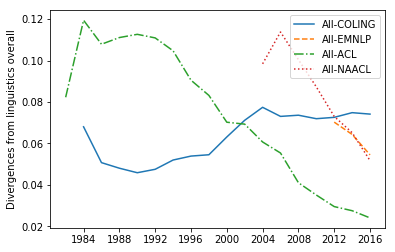

In [434]:
years = range(1978, 2018, 2)
plot_divergences(texts_topics_df_uniq, [['ACL', 'EMNLP', 'COLING', 'NAACL']],
                 [['COLING'], ['EMNLP'], ['ACL'], ['NAACL']], years,
                 'Divergences from linguistics overall', 'All')


/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


['COLING'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.1213655306841563, 0.11545346715125279, 0.13116776340364097, 0.1211226392520449, 0.10433242802472549]
['COLING'] [nan, 0.2344622726402726, 0.16909046896589078, 0.1418249385773628, 0.15931549294415395, 0.16788184078602797, 0.15873945314421298, 0.14347701873252525, 0.15992256053976095, 0.12849671286332692, 0.11010153512514369, 0.13321354884681672, 0.13266793894468, 0.11016335501252611, 0.08294241416910743, 0.09133545672287706, 0.08612223318466922, 0.0889416388069482, 0.09616239018733476, 0.07480351892609319]
['COLING'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.14791450341933796, 0.17994994187325172, 0.16282578071001633, 0.14515912185379445, 0.12884775349574656, 0.1222988964537539, 0.11957361971809477, 0.09463782543372853, 0.07354304727803135]
['EMNLP'] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0789099803513084, 0.08746359552438798, 0.0820651906895091

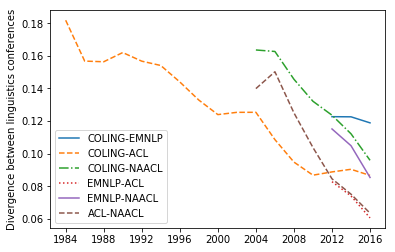

In [272]:
years = range(1978, 2018, 2)
plot_divergences([['COLING'], ['EMNLP'], ['ACL'], ['NAACL']],
                 confsl2=None,
                years=years, ylabel='Divergence between linguistics conferences')


/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


1988 nan
1990 nan
1992 nan
1994 0.5038984256896586
1996 0.49996069302655716
1998 0.4991879593889716
2000 0.48709979247463675
2002 0.4807012955525358
2004 0.492063869194518
2006 0.49496842589319967
2008 0.49984877843719944
2010 0.5037710959825755
2012 0.5076312303994818
2014 0.5028777125180242
2016 0.49810263628506574
-10 0.5970111914842423
1988 nan
1990 nan
1992 nan
1994 0.5436523681890416
1996 0.5409767343180321
1998 0.5373900130080238
2000 0.5151444202389497
2002 0.5088604038697887
2004 0.5043907102919822
2006 0.5077751653420923
2008 0.5002189422681932
2010 0.4992877152321942
2012 0.5001284648189067
2014 0.49386166579235713
2016 0.4821808015141934
-9 0.6133867404883755
1988 nan
1990 nan
1992 nan
1994 0.5223349352916046
1996 0.5150392668596755
1998 0.5234894224558345
2000 0.5075006661477057
2002 0.505569662195109
2004 0.5100518669300371
2006 0.5124343165715683
2008 0.5053983384833572
2010 0.5114353010026335
2012 0.5074049325734666
2014 0.5039513995491984
2016 0.4970502685395086
-8 0.6

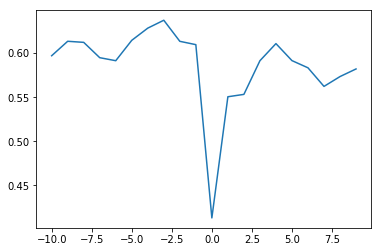

In [558]:
avgdivs = []
for shift in range(-10, 10):
    divergences = conf_divergences(texts_topics_df_uniq[texts_topics_df_uniq['Year']>=1988], 
                                   ['ACL', 'EMNLP', 'NAACL', 'COLING'], ['NIPS'], years=range(1988, 2018, 2), 
                                   shift=shift, topics=range(100))
    avgdiv = sum(divergences)/10
    print(shift, avgdiv)
    avgdivs.append(avgdiv)

plt.plot(range(-10,10), avgdivs)

## Conference correlation

In [667]:
neural_topics = [69, 78, 79, 55]

In [701]:
def _probs_for_conf(df, confs, topic=None, shift=None, years=None):
    counts_per_year = df[df['Conference'].isin(confs)][
                                     df['Dominant_Topic']==topic].groupby('Year', as_index=False).count()
    counts_per_year['Docs_per_year'] = counts_per_year['Year'].apply(lambda y: documents_per_year[y])
    counts_per_year['Probability'] = counts_per_year['Document']/counts_per_year['Docs_per_year']
    counts_per_year = counts_per_year.set_index('Year')
    if not years:
        years = range(1978, 2018, 2)
    probs = counts_per_year.reindex(years, fill_value=0)
    if shift:
        probs = probs.shift(shift, fill_value=probs.Probability.values[0])
    return probs.index, probs.Probability.values

def corr(df, conf1, conf2, topic=None, shift=None, plot=False, label1=None, label2=None, years=None):
    y, c1 = _probs_for_conf(df, conf1, topic, shift, years=years)
    y, c2 = _probs_for_conf(df, conf2, topic, years=years)
    if plot:
        if not label1:
            label1=",".join(conf1) + " - " + topic_names[topic]
        plt.plot(y, c1, '-', label=label1)
        if not label2:
            label2 = ",".join(conf2) + " - " + topic_names[topic]
        plt.plot(y, c2, '--', label=label2)
        plt.legend()
        plt.xlabel('Year')
        plt.ylabel('Correlation')
    corr = pearsonr(c1, c2)
    return corr[0]

max_corr = 0
max_topic = 0
correlated_topics = pd.DataFrame()
sumcorr = 0
cnt = 0
for t in range(100):
    if t in topics_to_remove or t in topics_to_merge:
        continue
    c = corr(texts_topics_df_uniq[texts_topics_df_uniq['Year']>=1994],
             ['ACL', 'EMNLP', 'COLING', 'NAACL'], 
             ['NIPS'], t, shift=0)
    sumcorr += c
    cnt += 1
    print(topic_names[t], c)
    correlated_topics = correlated_topics.append(pd.Series([c, t, topic_names[t]]), ignore_index=True)
    if c > max_corr:
        max_corr = c
        max_topic = t
correlated_topics.columns = ['Correlation', 'Topic', 'Topic_Name']
max_topic = correlated_topics.sort_values('Correlation', ascending=False).head(1).Topic
avg_corr = sumcorr/cnt
print("avg cor", avg_corr)

/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


DOMAIN ADAPTATION 0.7055956683329324
FINITE STATE MACHINES 0.9088108090479181
MORPHOLOGY 0.7932607124778218
MULTI-WORD EXPRESSIONS 0.7891308942090002
SENTIMENT ANALYSIS 0.26303901156156145
TREES 0.9022985462034528
REINFORCEMENT LEARNING 0.931594474369853
SVMs 0.49166312072131824
LINEAR PROGRAMMING 0.793898045321868
ARGUMENT MINING 0.6311156250963877
TOPIC MODELS 0.7331055481836125
CLUSTERING 0.74361031060182
LANGUAGE ACQUISITION/SIMPLIFICATION 0.7030954798421383
GENERATION 0.8796811184174357
NAMED ENTITY RECOGNITION 0.5304426763907232
DISCOURSE SEGMENTATION 0.7870290656341161
EVENTS/TEMPORAL 0.7882579582218249
PHONOLOGY 0.8034972049670527
STYLISTICS 0.5442469399041157
POS TAGGING/STATISTICAL PARSING 0.8724554424455434
UNIFICATION 0.7427269492186768
LANGUAGE MODELS (CLASSICAL) 0.6616042863926717
TEXTUAL ENTAILMENT 0.6290483188444188
BIOMEDICAL 0.7277677305130309
ANAPHORA/COREFERENCE RESOLUTION 0.7374779984082902
DEPENDENCY PARSING 0.4515902345779119
DATABASE/RESOURCE? 0.7570428810953651

/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Correlation  Topic                  Topic_Name
6      0.931594    6.0      REINFORCEMENT LEARNING
76     0.911081   91.0             ASIAN LANGUAGES
1      0.908811    1.0       FINITE STATE MACHINES
54     0.904286   67.0              DISAMBIGUATION
49     0.903439   60.0                    GRAMMARS
5      0.902299    5.0                       TREES
65     0.894116   80.0         COMPLEXITY ANALYSIS
44     0.890197   54.0                     RANKING
63     0.881443   78.0  NEURAL MACHINE TRANSLATION
13     0.879681   14.0                  GENERATION

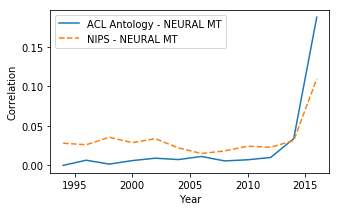

In [713]:
max_topic=correlated_topics.sort_values('Correlation', ascending=False).head(1).Topic.values[0]
plt.figure(figsize=(5,3))
corr(texts_topics_df_uniq[texts_topics_df_uniq['Year']>=1994], ['ACL', 'EMNLP', 'COLING', 'NAACL'],
     ['NIPS'], 78, shift=0, plot=True, label1='ACL Antology - NEURAL MT', label2='NIPS - NEURAL MT', 
     years=range(1994,2018,2))
correlated_topics.sort_values('Correlation', ascending=False).head(10)


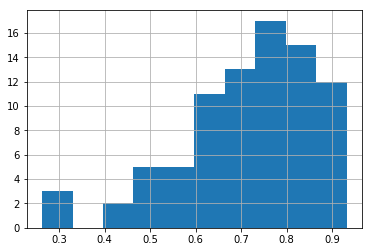

In [705]:
correlated_topics.Correlation.hist()

In [686]:
corrs = []
shift_range = range(-35, 35)

for s in shift_range:
    tot_corr = 0
    cnt = 0
    for t in neural_topics:
        c = corr(texts_topics_df_uniq[texts_topics_df_uniq['Year']>=1994], ['ACL', 'EMNLP', 'NAACL', 'COLING'], 
                 ['NIPS'], t, s)
        if not np.isnan(c):
            tot_corr += c
            cnt += 1
    if cnt:
        corrs.append(tot_corr/cnt)
    else:
        corrs.append(np.nan)
print(corrs, np.nanargmax(corrs)+shift_range[0])



/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.21508030743537354, -0.28151960567879997, -0.3114712202568239, -0.3332960838621822, -0.35209558513881145, -0.3728941451288521, -0.3939558928978454, -0.41045174147276176, -0.028832445191358094, 0.18756854040641555, 0.2275923391087975, 0.26338290100240763, 0.20790928349230403, 0.17658376573990037, 0.07875286038255166, 0.06883666750696876, 0.08462148810705689, 0.12206283169374395, 0.1330717386868625, 0.5349926353450971, 0.6130148016805411, 0.5066655483462619, 0.39225341092152016, 0.23505158256520844, 0.25569742868074674, 0.23150488270508746, 0.275406614855336, 0.2553739654284318, 0.19623383408886552, 0.30298405307374104, 0.2916967516674571, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] 1


Text(0, 0.5, 'Correlation')

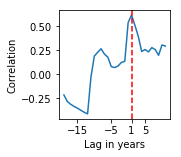

In [708]:
ax = plt.figure(figsize=(2,2))
# corrs_all_topics=corrs
plt.plot(shift_range, corrs)
plt.axvline(x=np.nanargmax(corrs)+shift_range[0], c='r', ls='--')
plt.xticks(list(range(-15, 15, 10))+[np.nanargmax(corrs)+shift_range[0]])
plt.xlabel('Lag in years')
plt.ylabel('Correlation')

Text(0, 0.5, 'Correlation')

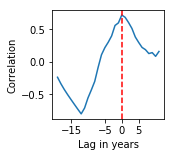

In [709]:
ax = plt.figure(figsize=(2,2))
# corrs_all_topics=corrs
plt.plot(shift_range, corrs_all_topics)
plt.axvline(x=np.nanargmax(corrs_all_topics)+shift_range[0], c='r', ls='--')
plt.xticks(list(range(-15, 15, 10))+[np.nanargmax(corrs_all_topics)+shift_range[0]])
plt.xlabel('Lag in years')
plt.ylabel('Correlation')

/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -0.24130441649470083, -0.341174090251015, -0.42908103705466, -0.5086866363950855, -0.5844909039408434, -0.6586205947627891, -0.7319764358311641, -0.8032241959895192, -0.7138209444040232, -0.5591807384153208, -0.4360041961170383, -0.30500197688935005, -0.18323235901108598, -0.08896585704670384, 0.013377146891014888, 0.09046516212301445, 0.17666812318624137, 0.317433471052181, 0.3451573945531212, 0.4495342438492773, 0.592017008038719, 0.7311773372004197, 0.6643677455905552, 0.5712993136613452, 0.5365109364291453, 0.43167524998335993, 0.30008769443862, 0.18441172323009877, 0.19632665687153672, 0.14050560983119803, 0.08840876817259113, 0.07914738287839063, 0.16309860005557142, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
-35


Text(0, 0.5, 'Correlation')

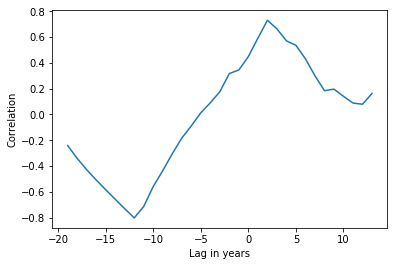

In [595]:
corrs = []
shift_range = range(-35, 35)
all_topics = set(texts_topics_df.Dominant_Topic.values)
for s in shift_range:
    tot_corr = 0
    for t in all_topics:
        c = corr(texts_topics_df_uniq[texts_topics_df_uniq['Year']>1988], ['ACL', 'EMNLP', 'COLING', 'NAACL'], 
                 ['NIPS'], t, s)
        tot_corr += c
    corrs.append(tot_corr/len(all_topics))
print(corrs)
print(np.argmax(corrs)+shift_range[0])
plt.plot(shift_range, corrs)
plt.xlabel('Lag in years')
plt.ylabel('Correlation')

In [566]:
corr(texts_topics_df_uniq[texts_topics_df_uniq['Year']>1988=, ['ACL', 'EMNLP', 'COLING', 'NAACL'], ['NIPS'], max_topic, 0, plot=True)

/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


KeyError: 1964

/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


0.7890474225875365

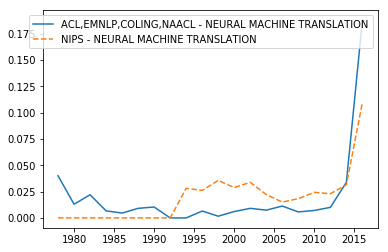

In [536]:
corr(texts_topics_df_uniq[texts_topics_df_uniq['Year']>=1978], ['ACL', 'EMNLP', 'COLING', 'NAACL'], ['NIPS'], 78, 0, plot=True)

/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


[-0.3820182260820846, -0.4123579487549751, -0.44059947949369355, -0.4635235470252066, -0.09200825708753026, 0.10495767921577173, 0.13905264499645364, 0.1904794896710757, 0.15449104831691216, 0.14591895030349983, 0.05884570835374289, 0.060383082456899176, 0.07723527510269496, 0.1147813773022692, 0.13022764407189416, 0.5276636397952004, 0.5716487015127447, 0.5988422782674419, 0.6868249116475884, 0.5410558115420471, 0.49872134254959466, 0.40567217953833634, 0.3202119194708154, 0.19261199785072086, 0.09676833791219694, 0.1487771814594312, 0.09624945804506581, 0.10272077587831302, 0.3253335476659209, 0.43394998771213655]
3


Text(0, 0.5, 'Correlation')

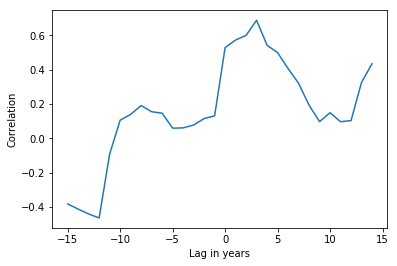

In [604]:
corrs = []
shift_range = range(-15, 15)
max_corr = 0
max_topic = 0
max_shift = 0
for s in shift_range:
    tot_corr = 0
    for t in neural_topics:
        c = corr(texts_topics_df_uniq[texts_topics_df_uniq['Year']>=1988], 
                 ['ACL', 'EMNLP', 'COLING', 'NAACL'], ['NIPS'], t, s)
        if not np.isnan(c):
            tot_corr += c
        if c > max_corr:
            max_corr = c
            max_topic = t
            max_shift = s
    corrs.append(tot_corr/len(neural_topics))
print(corrs)
print(np.nanargmax(corrs)+shift_range[0])
plt.plot(shift_range, corrs)
plt.xlabel('Lag in years')
plt.ylabel('Correlation')

In [601]:
texts_topics_df_uniq[texts_topics_df_uniq['Conference']=='NIPS'].sort_values('Year')

Document  \
304704                  1160-harmony-networks-do-not-work   
308869  1020-a-computational-model-of-prefrontal-corte...   
308870  1020-a-computational-model-of-prefrontal-corte...   
308871  1020-a-computational-model-of-prefrontal-corte...   
308872  1020-a-computational-model-of-prefrontal-corte...   
308873  1020-a-computational-model-of-prefrontal-corte...   
308874  1020-a-computational-model-of-prefrontal-corte...   
287624  1155-exploiting-tractable-substructures-in-int...   
287623  1155-exploiting-tractable-substructures-in-int...   
308868  1020-a-computational-model-of-prefrontal-corte...   
287622  1155-exploiting-tractable-substructures-in-int...   
287620  1155-exploiting-tractable-substructures-in-int...   
287619  1155-exploiting-tractable-substructures-in-int...   
287618  1155-exploiting-tractable-substructures-in-int...   
287617  1155-exploiting-tractable-substructures-in-int...   
287616  1155-exploiting-tractable-substructures-in-int...   
287615  1155-exploiting-tractable-substructures-in-int...   
287614  1155-exploiting-tractable-substructures-in-int...   
287612  1155-exploiting-tractable-substructures-in-int...   
287621  1155-exploiting-tractable-substructures-in-int...   
308867  1020-a-computational-model-of-prefrontal-corte...   
308866  1020-a-computational-model-of-prefrontal-corte...   
308864  1020-a-computational-model-of-prefrontal-corte...   
276695                           1112-learning-model-bias   
276697                           1112-learning-model-bias   
276698                           1112-learning-model-bias   
313557  1147-geometry-of-early-stopping-in-linear-netw...   
313558  1147-geometry-of-early-stopping-in-linear-netw...   
313559  1147-geometry-of-early-stopping-in-linear-netw...   
313560  1147-geometry-of-early-stopping-in-linear-netw...   
...                                                   ...   
341563  I18-KONG: Kernels for ordered-neighborhood graphs   
341564  I18-KONG: Kernels for ordered-neighborhood graphs   
341593  I17-Scalable trust-region method for deep rein...   
341592  I17-Scalable trust-region method for deep rein...   
341591  I17-Scalable trust-region method for deep rein...   
341590  I17-Scalable trust-region method for deep rein...   
341589  I17-Scalable trust-region method for deep rein...   
341588  I17-Scalable trust-region method for deep rein...   
341587  I18-Sparse DNNs with Improved Adversarial Robu...   
341586  I18-Sparse DNNs with Improved Adversarial Robu...   
341585  I18-Sparse DNNs with Improved Adversarial Robu...   
341584  I18-Sparse DNNs with Improved Adversarial Robu...   
341583  I18-Sparse DNNs with Improved Adversarial Robu...   
341582  I18-Sparse DNNs with Improved Adversarial Robu...   
341596  I17-Scalable trust-region method for deep rein...   
341581  I18-Sparse DNNs with Improved Adversarial Robu...   
341578  I18-Sparse DNNs with Improved Adversarial Robu...   
341577  I18-Sparse DNNs with Improved Adversarial Robu...   
341576  I18-Sparse DNNs with Improved Adversarial Robu...   
341575  I18-Sparse DNNs with Improved Adversarial Robu...   
341573  I18-Sparse DNNs with Improved Adversarial Robu...   
341572  I18-Sparse DNNs with Improved Adversarial Robu...   
341571  I18-KONG: Kernels for ordered-neighborhood graphs   
341570  I18-KONG: Kernels for ordered-neighborhood graphs   
341569  I18-KONG: Kernels for ordered-neighborhood graphs   
341568  I18-KONG: Kernels for ordered-neighborhood graphs   
341567  I18-KONG: Kernels for ordered-neighborhood graphs   
341566  I18-KONG: Kernels for ordered-neighborhood graphs   
341579  I18-Sparse DNNs with Improved Adversarial Robu...   
366139     I18-Deepcode: Feedback Codes via Deep Learning   

                                                    Title  Dominant_Topic  \
304704                       Harmony Networks Do Not Work             8.0   
308869  A Computational Model of Prefrontal Cortex Fun...            46.0   
308870  A Computational Model of Pr

/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


8 0.6980807211382133


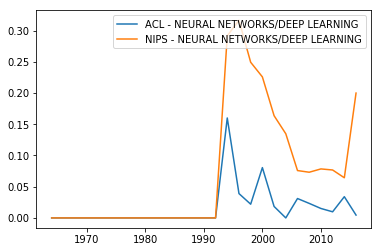

In [452]:
corr(texts_topics_df_uniq, ['ACL'], ['NIPS'], max_topic, max_shift, plot=True)
print(max_shift, max_corr)

In [171]:
corrs = []
shift_range = range(-10, 30)
recurring_topics = set()
for s in shift_range:
    for t in range(100):
        c = corr(['ACL'], ['ACL'], t, s)
        if c > 0.6 and abs(s)>8:
            print(s, c, topic_names[t])
            recurring_topics.add(t)
        corrs.append(c)
            


/home/ana/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


8 0.6534764401382607 ESTIMATORS/STATISTICAL METHODS?
8 0.6942169499856427 LANGUAGE MODELS (CLASSIC)
8 0.7848400987798827 CLASSIFICATION
8 0.7708355766610249 MACHINE LEARNING
8 0.6493150976422705 LEXICAL SEMANTICS
8 0.7550287408283989 POS TAGGING
8 0.704891364163786 MANUAL ANNOTATION
15 0.643065805401374 ESTIMATORS/STATISTICAL METHODS?
16 0.6155896877266327 CLASSIFICATION
22 0.6411105587230056 DEPENDENCY PARSING
22 0.681920994711958 MANUAL ANNOTATION
23 0.6282670447771327 MANUAL ANNOTATION
27 0.6071181628481648 CLASSIFICATION


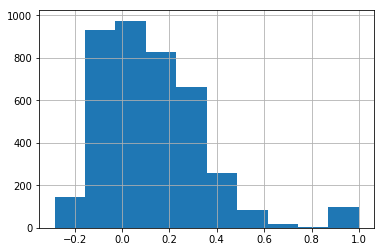

In [172]:
pd.Series(corrs).hist()

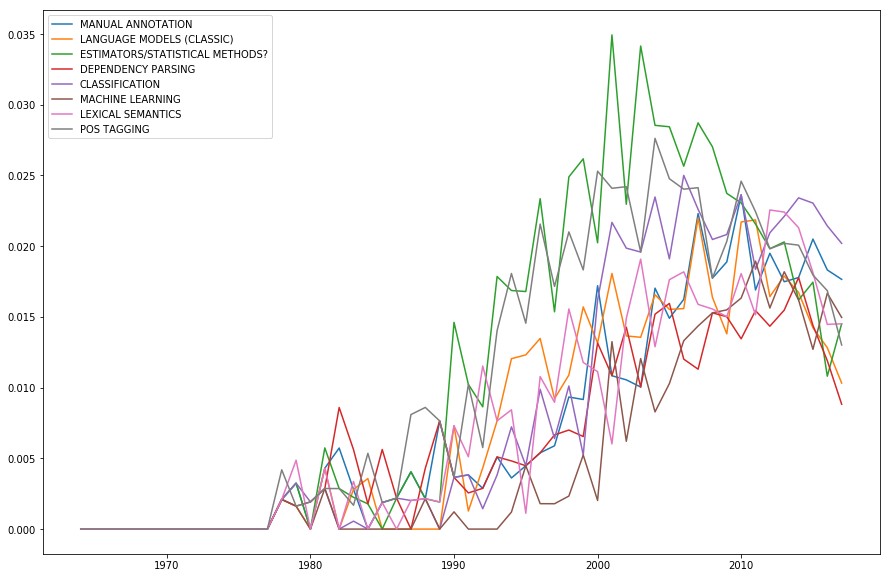

In [173]:
plot_for_topics(recurring_topics, conferences=['ACL'])

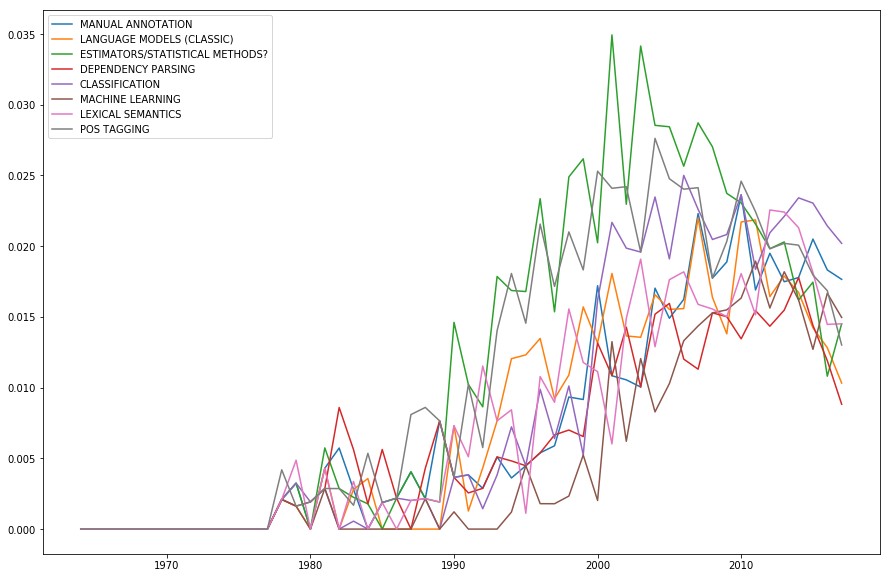

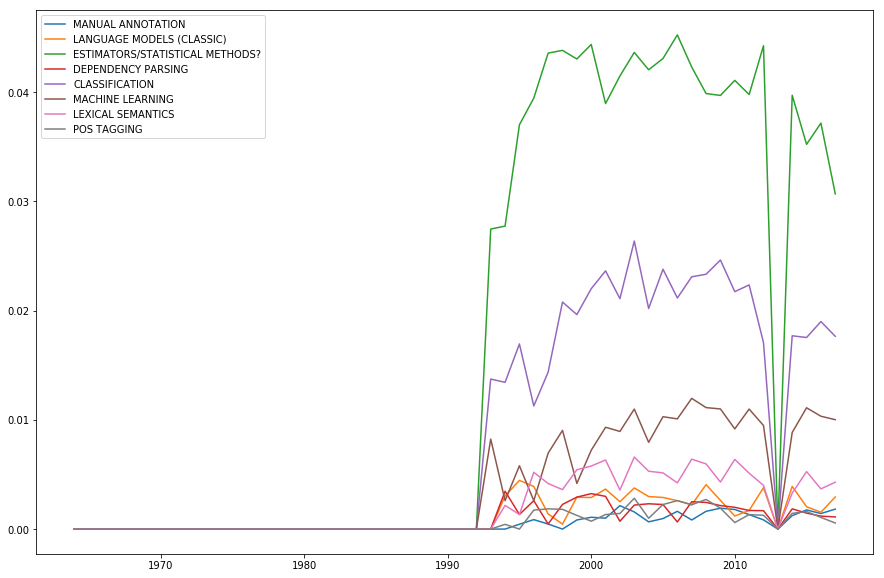

In [175]:
plot_for_topics(recurring_topics, conferences=['ACL'])
plot_for_topics(recurring_topics, conferences=['NIPS'])